Nicholas Brower<br>
Springboard DSCT May 2022<br>
Capstone 2

# American Express Default Prediction

## Exploratory Data Analysis

#### Loading and imports

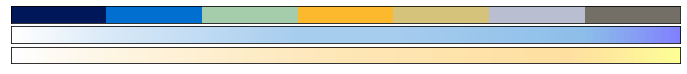

In [1]:
from spaghetti import *

Load training and test data.

In [2]:
working_files = [
    PandasFile(name, f'{WORKING_DATA}{name}_df.pickle', f'{WORKING_DATA}{name}_df.pickle')
    for name in ['train_data', 'train_labels', 'test_data']
]
train_data, train_labels, test_data = [file.load() for file in working_files]
dataset = [train_data, test_data]

In [3]:
print('\n-\n'.join(f'{df.attrs["name"]}\n{df.shape}'
                for df in [train_data, train_labels, test_data]) + '\n-')

train_data
(5531451, 188)
-
train_labels
(458913, 1)
-
test_data
(11363762, 188)
-


Assign unique identifiers for train_data and test_data to the variables train_customers and test_customers. Assign the target feature, target labels, and target names to variables.

In [4]:
train_customers = pd.Index(sorted(pd.unique(train_data.index.get_level_values(0))))
test_customers = pd.Index(sorted(pd.unique(test_data.index.get_level_values(0))))
train_default_ratio = train_labels.target.value_counts(normalize=True)[1]
assert all(train_labels.index==train_customers)
target_feature = train_labels.target
target_labels = sorted(pd.unique(target_feature.values))
target_names = ['no default', 'default']
target_map = dict(enumerate(target_names))
default_customers = train_labels.index[train_labels.target==1]
no_default_customers = train_labels.index[train_labels.target==0]

Categorize features by data type. Create a list of unprocessed features. Initialize a dictionary of preprocessing steps. Initialize an empty list of features with finalized preprocessing methods.

In [5]:
numeric_features = [
    'B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 'B_7', 'B_8', 'B_9', 'B_10', 
    'B_11', 'B_12', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_18', 'B_19', 
    'B_20', 'B_21', 'B_22', 'B_23', 'B_24', 'B_25', 'B_26', 'B_27', 'B_28', 
    'B_29', 'B_32', 'B_33', 'B_36', 'B_37', 'B_39', 'B_40', 'B_41', 'B_42', 
    'D_39', 'D_41', 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 
    'D_49', 'D_50', 'D_51', 'D_52', 'D_53', 'D_54', 'D_55', 'D_56', 'D_58', 
    'D_59', 'D_60', 'D_61', 'D_62', 'D_65', 'D_69', 'D_70', 'D_71', 'D_72', 
    'D_73', 'D_74', 'D_75', 'D_76', 'D_77', 'D_78', 'D_79', 'D_80', 'D_81', 
    'D_82', 'D_83', 'D_84', 'D_86', 'D_87', 'D_88', 'D_89', 'D_91', 'D_92', 
    'D_93', 'D_94', 'D_96', 'D_102', 'D_103', 'D_104', 'D_105', 'D_106', 
    'D_107', 'D_108', 'D_109', 'D_110', 'D_111', 'D_112', 'D_113', 'D_115', 
    'D_118', 'D_119', 'D_121', 'D_122', 'D_123', 'D_124', 'D_125', 'D_127', 
    'D_128', 'D_129', 'D_130', 'D_131', 'D_132', 'D_133', 'D_134', 'D_135', 
    'D_136', 'D_137', 'D_138', 'D_139', 'D_140', 'D_141', 'D_142', 'D_143', 
    'D_144', 'D_145', 'P_2', 'P_3', 'P_4', 'R_1', 'R_2', 'R_3', 'R_4', 
    'R_5', 'R_6', 'R_7', 'R_8', 'R_9', 'R_10', 'R_11', 'R_12', 'R_13', 
    'R_14', 'R_15', 'R_16', 'R_17', 'R_18', 'R_19', 'R_20', 'R_21', 'R_22', 
    'R_23', 'R_24', 'R_25', 'R_26', 'R_27', 'R_28', 'S_3', 'S_5', 'S_6', 
    'S_7', 'S_8', 'S_9', 'S_11', 'S_12', 'S_13', 'S_15', 'S_16', 'S_17', 
    'S_18', 'S_19', 'S_20', 'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'S_27'
]
categorical_features = [
    'B_30', 'B_31', 'B_38', 'D_63', 'D_64', 'D_66', 'D_68', 'D_114', 
    'D_116', 'D_117', 'D_120', 'D_126'
]
features = [*numeric_features, *categorical_features]
feature_folders = {
    feature: f'{WORKING_DATA}/features/{feature}/' for feature in features
}
to_drop = {}

#### Selections, Subsets, and Analysis

Load the results of analysis conducted in previous notebooks. Add null percentage summary statistics by target class to the numeric analysis DataFrame.

In [6]:
numeric_analysis = pd.read_pickle(f'{WORKING_DATA}numeric_analysis.pickle')
if path.exists(f'{WORKING_DATA}numeric_analysis_w_target.pickle'):
    numeric_analysis_w_target = pd.read_pickle(f'{WORKING_DATA}numeric_analysis_w_target.pickle')
else:
    numeric_analysis_w_target = numeric_analysis.copy()
    for subset_name, subset in zip(['no default', 'default'], [no_default_customers, default_customers]):
        for feature in numeric_features:
            ind = (feature, subset_name)
            d = train_data.loc[subset, feature].isna().copy()
            numeric_analysis_w_target.loc[ind, 'null_by_obs'] = d.mean()
            numeric_analysis_w_target.loc[ind, 'null_by_cust_any'] = d.groupby(level=0).any().mean()
            numeric_analysis_w_target.loc[ind, 'null_by_cust_all'] = d.groupby(level=0).all().mean()
            numeric_analysis_w_target.loc[ind, 'null_by_cust_mean'] = d.groupby(level=0).mean().mean()
            del d
    with open(f'{WORKING_DATA}numeric_analysis_w_target.pickle', 'wb') as file:
        numeric_analysis_w_target.to_pickle(file)
print(f'numeric_analysis\n{numeric_analysis.shape}\n-')

numeric_analysis
(352, 19)
-


Fill missing values of the known boolean feature D_87.

In [7]:
for df in [train_data, test_data]:
    df.loc[:, 'D_87'] = df.loc[:, 'D_87'].fillna(0)

Create a list of features for which each customer has at least one nonnull value in both train_data and test_data.

In [8]:
nonnull_numeric = nat_sorted([
    col for col in numeric_features if all(numeric_analysis.loc[col, 'is_nonnull'])
])
null_numeric = nat_sorted(set(numeric_features).difference(nonnull_numeric))
print(f'{len(nonnull_numeric)} numeric features have at least 1 observation per customer')
print(f'{len(null_numeric)} numeric features missing 1 or more values')

61 numeric features have at least 1 observation per customer
115 numeric features missing 1 or more values


In [9]:
processed_and_nonnull = nonnull_numeric.copy()
processed_and_nonnull.append(null_numeric.pop(null_numeric.index('D_87')))

Assign the mostly non-null subsets of numeric features to separate variables. These will be used in training and testing imputation models.

In [10]:
null_by_obs = numeric_analysis.null_by_obs
mostly_nonnull = nat_sorted(null_by_obs[null_by_obs<0.01].index.get_level_values(0).unique())
largely_nonnull = nat_sorted(null_by_obs[null_by_obs<0.05].index.get_level_values(0).unique())

Print the variable name, filter criterion, and composotion of each feature subset defined in the previous cell.

In [11]:
mnn_vs_nn = nat_sorted(set(mostly_nonnull).difference(nonnull_numeric))
lnn_vs_mnn = nat_sorted(set(largely_nonnull).difference(mostly_nonnull))
print(f'nonnull_numeric:\n{HR}')
print(f'{len(nonnull_numeric)} numeric features with no missing values:')
print(indented(', '.join(nonnull_numeric)) + '\n    -')
for addtnl_ftrs, pct, name in zip([mnn_vs_nn, lnn_vs_mnn], [1, 5], ['mostly', 'largely']):
    previous = {'mostly': 'nonnull numeric', 'largely': 'mostly nonnull'}[name]
    print(f'{name}_nonnull: < {pct} % values missing\n{HR}')
    print(f'{previous} + {len(addtnl_ftrs)} features ')
    print(indented(', '.join(addtnl_ftrs)) + '\n    -')

nonnull_numeric:
----------------------------------------------------------------------
61 numeric features with no missing values:
    B_1, B_4, B_5, B_7, B_9, B_10, B_11, B_12, B_14, B_18, B_21, B_23,
    B_24, B_28, B_32, B_36, D_39, D_47, D_51, D_58, D_60, D_65, D_71,
    D_75, D_92, D_93, D_94, D_96, D_127, P_4, R_1, R_2, R_3, R_4, R_5,
    R_6, R_8, R_10, R_11, R_13, R_15, R_16, R_17, R_18, R_19, R_21,
    R_22, R_23, R_24, R_25, R_28, S_5, S_6, S_8, S_11, S_13, S_15,
    S_16, S_18, S_19, S_20
    -
mostly_nonnull: < 1 % values missing
----------------------------------------------------------------------
nonnull numeric + 58 features 
    B_2, B_3, B_6, B_8, B_13, B_15, B_16, B_19, B_20, B_22, B_25,
    B_26, B_27, B_33, B_37, B_40, B_41, D_41, D_45, D_52, D_54, D_72,
    D_74, D_79, D_80, D_81, D_84, D_86, D_89, D_102, D_103, D_104,
    D_107, D_109, D_112, D_128, D_129, D_130, D_131, D_133, D_139,
    D_140, D_141, D_143, D_144, D_145, P_2, R_7, R_12, R_14, R_20,
    S_12, S_

Determine the locations of null and non-null values for each numeric feature with any null values. Create a dictionary pairing each incomplete feature with a sample of the index where it its values are null. These samples will be used to determine which features may be used to train imputation models.

In [12]:
numeric_null_ind_samples = {feature: {} for feature in null_numeric}
times = []
for i, feature in enumerate(null_numeric):
    start_time = datetime.now()
    feature_folder = feature_folders[feature]
    for df in dataset:
        df_name = df.attrs['name']
        is_null_path = f'{feature_folder}{df_name}_is_null_ind.pickle'
        not_null_path = f'{feature_folder}{df_name}_not_null_ind.pickle'
        is_null_sample_path = f'{feature_folder}{df_name}_is_null_ind_sample.pickle'
        filepaths = [is_null_path, not_null_path, is_null_sample_path]
        if all([path.exists(filepath) for filepath in filepaths]):
            try:
                numeric_null_ind_samples[feature][df_name] = load_pickled(
                    is_null_sample_path
                )
                times = []
                continue
            except EOFError:
                print('file corrupt, incomplete, or missing. rebuilding...')
        f_is_null = df[feature].isnull()
        f_is_null_ind = df.index[f_is_null]
        f_not_null_ind = df.index[~f_is_null]
        del f_is_null
        for ind, filepath in zip([f_is_null_ind, f_not_null_ind], [is_null_path, not_null_path]):
            with open(filepath, 'wb') as file:
                pickle.dump(ind, file)
        del f_not_null_ind
        if len(f_is_null_ind) > 1000:
            f_is_null_ind_sample = np.random.choice(f_is_null_ind, 1000, replace=False)
        else:
            f_is_null_ind_sample = f_is_null_ind
        numeric_null_ind_samples[feature][df_name] = f_is_null_ind_sample
        is_null_sample_path = f'{feature_folder}{df_name}_is_null_ind_sample.pickle'
        dump_pickle(f_is_null_ind_sample, is_null_sample_path)
        del f_is_null_ind; del f_is_null_ind_sample
    times.append((datetime.now() - start_time).total_seconds())
    iter_progress(times=times, i=i, n_items=len(null_numeric), report_interval=30)

|   0% complete || remaining:                    |
|  26% complete || remaining:                    |
|  53% complete || remaining:                    |
|  79% complete || remaining:                    |


Create a dictionary pairing each incomplete numeric feature with a larger sample of the index where values are not null. These values will enable cross-validation of imputation models.

In [13]:
numeric_not_null_ind_samples = {feature: {} for feature in null_numeric}
times = []
for i, feature in enumerate(null_numeric):
    start_time = datetime.now()
    feature_folder = feature_folders[feature]
    for df in dataset:
        df_name = df.attrs['name']
        not_null_ind_filepath = f'{feature_folder}{df_name}_not_null_ind.pickle'
        not_null_ind_sample_filepath = f'{feature_folder}{df_name}_not_null_ind_sample.pickle'
        built = 0
        if path.exists(not_null_ind_sample_filepath):
            try:
                f_not_null_ind_sample = load_pickled(not_null_ind_sample_filepath)
                built = 1
                times = []
            except EOFError:
                print('file corrupt or missing. rebuilding...')
        if not built:
            f_not_null_ind = load_pickled(not_null_ind_filepath)
            if len(f_not_null_ind) > 3000:
                f_not_null_ind_sample = np.random.choice(f_not_null_ind, 3000, replace=False)
            else:
                f_not_null_ind_sample = f_not_null_ind
            del f_not_null_ind
            dump_pickle(f_not_null_ind_sample, not_null_ind_sample_filepath)
        numeric_not_null_ind_samples[feature][df_name] = f_not_null_ind_sample
        del f_not_null_ind_sample
    times.append((datetime.now() - start_time).total_seconds())
    iter_progress(times=times, i=i, n_items=len(null_numeric), report_interval=30)

|   0% complete || remaining:             1.78 s |
|  26% complete || remaining:             1.31 s |
|  53% complete || remaining:             1.20 s |
|  79% complete || remaining:                    |


Take a random sample of customers from the training and test subsets.

In [14]:
tr_sample_customers = np.random.choice(train_customers, 100000, replace=False)
ts_sample_customers = np.random.choice(test_customers, 100000, replace=False)

Take random samples of numeric feature values from each subset of this dataset.

In [15]:
if path.exists('tr_numeric_samples.pickle'):
    tr_numeric_samples, ts_numeric_samples = [
        load_pickled(f'{_}_numeric_samples.pickle') for _ in ['tr', 'ts']
    ]
else:
    tr_numeric_samples, ts_numeric_samples = [
        {feature: {} for feature in numeric_features}
        for _ in range(2)
    ]
    times, n_items = [], len(numeric_features)
    for i, feature in enumerate(numeric_features, 1):
        start = datetime.now()
        for sample_dict, df in zip([tr_numeric_samples, ts_numeric_samples], dataset):
            f_data = df.loc[:, feature].dropna()
            f_customers = f_data.index.get_level_values(0).unique()
            if len(f_customers) > 10000:
                f_customers = np.random.choice(f_customers, 10000, replace=False)
                f_data = f_data.loc[f_customers]
            del f_customers
            sample_dict[feature]['by_obs'] = f_data
            sample_dict[feature]['by_cust'] = f_data.groupby(level=0).mean()
            del f_data
        times.append((datetime.now() - start).total_seconds())
        iter_progress(times=times, i=i, n_items=n_items, report_interval=25)
    with open('tr_numeric_samples.pickle', 'wb') as file:
        pickle.dump(tr_numeric_samples, file)
    with open('ts_numeric_samples.pickle', 'wb') as file:
        pickle.dump(ts_numeric_samples, file)
numeric_samples = [tr_numeric_samples, ts_numeric_samples]

Take random samples of members in each target class for each numeric feature.

In [16]:
if path.exists('target_samples.pickle'):
    target_samples = load_pickled('target_samples.pickle')
    target_bal_by_any_nonull = load_pickled(
        'target_bal_by_any_nonnull.pickle'
    )
else:
    target_samples = {
        feature: {_: {} for _ in ['by_obs', 'by_cust']} 
        for feature in numeric_features
    }
    target_bal_by_any_nonnull = pd.DataFrame(
        index=numeric_features, columns=[0, 1]
    )
    for feature in numeric_features:
        # Select feature subset, unique customers, and target classes
        f_data = train_data.loc[:, feature].dropna()
        f_cust = f_data.index.get_level_values(0).unique()
        f_labels = train_labels.target.loc[f_cust]
        
        # Determine the class balance of customers with any non-null values
        f_bal = (
            f_labels.value_counts(normalize=True)
            .reindex([0, 1], fill_value=0)
        )
        target_bal_by_any_nonnull.loc[feature, 0] = f_bal.loc[0]
        target_bal_by_any_nonnull.loc[feature, 1] = f_bal.loc[1]
        del f_bal
        
        # Select members by class. Use random sampling for lengthy subsets
        no_def_cust, def_cust = f_cust[f_labels==0], f_cust[f_labels==1]
        if len(no_def_cust) > 10000:
            no_def_cust = np.random.choice(no_def_cust, 10000, replace=False)
        if len(def_cust) > 10000:
            def_cust = np.random.choice(def_cust, 10000, replace=False)
        
        # Update target_samples with data by subset and grouping
        no_def_data, def_data = f_data.loc[no_def_cust], f_data.loc[def_cust]
        target_samples[feature]['by_obs'][0] = no_def_data
        target_samples[feature]['by_obs'][1] = def_data
        del [no_def_data, def_data]
        f_data = f_data.groupby(level=0).mean()
        no_def_data, def_data = f_data.loc[no_def_cust], f_data.loc[def_cust]
        target_samples[feature]['by_cust'][0] = no_def_data
        target_samples[feature]['by_cust'][1] = def_data
        del [f_data, no_def_data, def_data]
    with open('target_samples.pickle', 'wb') as file:
        pickle.dump(target_samples, file)
    with open('target_bal_by_any_nonnull.pickle', 'wb') as file:
        pickle.dump(target_bal_by_any_nonnull, file)

Determine which numeric features contain the value 0. This will inform selection of imputation and transformation methods for numeric features.

In [17]:
numeric_with_zero = []
for feature in numeric_features:
    if any([0 in train_data[feature], 0 in test_data[feature]]):
        numeric_with_zero.append(feature)
print(f'{len(numeric_with_zero)} numeric features contain zero')

0 numeric features contain zero


Numeric features in this dataset are restricted to nonzero values. Missing values may be imputed with zero for these features.<br><br>
Drop related columns from the numeric_analysis DataFrame.

In [18]:
equal_zero_cols = [col for col in numeric_analysis.columns if 'equal' in col]
numeric_analysis.drop(columns=equal_zero_cols, inplace=True)

Determine which numeric features contain negative values.

In [19]:
contains_negative = numeric_analysis[
    ~numeric_analysis.is_nonnegative
].index.get_level_values(0).unique()
num_w_negative = len(contains_negative)
print(f'{num_w_negative} of {len(numeric_features)} '
      + 'numeric features contain negative values')

43 of 176 numeric features contain negative values


Create a list of features for each feature category defined in the competition metadata. Use these lists to create a dictionary matching each category name with its respective list.

In [20]:
balance, spend, payment, delinquency, risk = [
    [feature for feature in features if feature.startswith(_)]
    for _ in 'BSPDR'
]
b_numeric, s_numeric, p_numeric, d_numeric, r_numeric = [
    [feature for feature in numeric_features if feature.startswith(_)]
    for _ in 'BSPDR'
]
features_by_category = dict(
    balance=balance, spend=spend, payment=payment, 
    delinquency=delinquency, risk=risk
)

Generate a map of unique values by categorical feature.

In [21]:
categorical_feature_values = {
    feature: sorted(set([
        *train_data.loc[:, feature].dropna().unique(),
        *test_data.loc[:, feature].dropna().unique()
    ]), key=str)
    for feature in categorical_features
}
cat_feature_map = {
    feature: {v: i for i, v in enumerate(vals)}
    for feature, vals in categorical_feature_values.items()
}
timeseries_dummies = partial(pd_timeseries_dummies, cat_feature_map=cat_feature_map)

In [22]:
categorical_feature_values

{'B_30': [0.0, 1.0, 2.0],
 'B_31': [0, 1],
 'B_38': [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0],
 'D_63': ['CL', 'CO', 'CR', 'XL', 'XM', 'XZ'],
 'D_64': ['-1', 'O', 'R', 'U'],
 'D_66': [0.0, 1.0],
 'D_68': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0],
 'D_114': [0.0, 1.0],
 'D_116': [0.0, 1.0],
 'D_117': [-1.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0],
 'D_120': [0.0, 1.0],
 'D_126': [-1.0, 0.0, 1.0]}

Create numeric transforms of categorical features.

In [23]:
train_categorical = timeseries_dummies(train_data.loc[:, categorical_features])
test_categorical = timeseries_dummies(test_data.loc[:, categorical_features])

Take a random sample of the train_data DataFrame. Create selections of this sample for each target feature class. Calculate mean values per customer for numeric features.

In [35]:
_ld = None
if path.exists('no_def_by_cust.pickle'):
    try:
        train_s_by_obs = pd.read_pickle('train_s_by_obs.pickle')
        train_s_by_cust = pd.read_pickle('train_s_by_cust.pickle')
        no_def_by_obs = pd.read_pickle('no_def_by_obs.pickle')
        def_by_obs = pd.read_pickle('def_by_obs.pickle')
        no_def_by_cust = pd.read_pickle('no_def_by_cust.pickle')
        def_by_cust = pd.read_pickle('def_by_cust.pickle')
        _ld = 1
    except EOFError:
        _ld = 0
if not _ld:
    train_sample = pd_stratified_sample(train_labels.target, 10000)
    train_s_by_obs = train_data.loc[train_sample]
    train_s_by_cust = train_s_by_obs.groupby(level=0).mean()
    sample_labels = train_labels.target.loc[train_sample]
    sample_no_def, sample_def = [
        sample_labels[sample_labels==lbl].index for lbl in [0, 1]
    ]
    no_def_by_obs, def_by_obs = [
        train_s_by_obs.loc[ind] for ind in [sample_no_def, sample_def]
    ]
    no_def_by_cust, def_by_cust = [
        train_s_by_cust.loc[ind] for ind in [sample_no_def, sample_def]
    ]
    with open ('train_s_by_obs.pickle', 'wb') as file:
        train_s_by_obs.to_pickle(file)
    with open ('train_s_by_cust.pickle', 'wb') as file:
        train_s_by_cust.to_pickle(file)
    with open ('no_def_by_obs.pickle', 'wb') as file:
        no_def_by_obs.to_pickle(file)
    with open ('def_by_obs.pickle', 'wb') as file:
        def_by_obs.to_pickle(file)
    with open ('no_def_by_cust.pickle', 'wb') as file:
        no_def_by_cust.to_pickle(file)
    with open ('def_by_cust.pickle', 'wb') as file:
        def_by_cust.to_pickle(file)
    del train_sample, sample_labels, sample_no_def, sample_def

Take a random sample of the test_data DataFrame. Calculate mean values as above.

In [40]:
_ld = None
if path.exists('test_s_by_obs.pickle'):
    try:
        test_s_by_obs = pd.read_pickle('test_s_by_obs.pickle')
        test_s_by_cust = pd.read_pickle('test_s_by_cust.pickle')
        _ld = 1
    except:
        _ld = 0
if not _ld:
    test_sample = np.random.choice(test_customers, 10000, replace=False)
    test_s_by_obs = test_data.loc[test_sample]
    test_s_by_cust = test_s_by_obs.groupby(level=0).mean()
    with open('test_s_by_obs.pickle', 'wb') as file:
        test_s_by_obs.to_pickle(file)
    with open('test_s_by_cust.pickle', 'wb') as file:
        test_s_by_cust.to_pickle(file)

Create a dictionary pairing each numeric feature with a list of numeric features it is most correlated with.

In [26]:
train_num_corr = train_s_by_obs.loc[:, numeric_features].corr().abs()
test_num_corr = test_s_by_obs.loc[:, numeric_features].corr().abs()
train_nf_corr, test_nf_corr = {}, {}
for corr_df, _dict in zip([train_num_corr, test_num_corr], [train_nf_corr, test_nf_corr]):
    for feature, row  in corr_df.items():
        srtd = sorted(
            row.loc[mostly_nonnull].index, key=lambda _: row.loc[_], reverse=True
        )
        if feature in mostly_nonnull:
            srtd = srtd[1:]
        _dict[feature] = srtd[:20]

Generate summary statistics for subsets of train_data and test_data.

In [45]:
_ld = None
if path.exists('trts_agg.pickle'):
    try:
        trts_agg = pd.read_pickle('trts_agg.pickle')
        trgt_agg = pd.read_pickle('trgt_agg.pickle')
        _ld =1
    except:
        _ld = 0
if not _ld:
    tr_obs_agg = train_data[numeric_features].agg(['mean', 'median', 'std']).T
    tr_obs_agg.loc[:, 'source'] = 'train_data'; tr_obs_agg.loc[:, 'weight'] = 'by_obs'
    ts_obs_agg = test_data[numeric_features].agg(['mean', 'median', 'std']).T
    ts_obs_agg.loc[:, 'source'] = 'test_data'; ts_obs_agg.loc[:, 'weight'] = 'by_obs'
    tr_cust_agg = train_data[numeric_features].groupby(level=0).mean().agg(['mean', 'median', 'std']).T
    tr_cust_agg.loc[:, 'source'] = 'train_data'; tr_cust_agg.loc[:, 'weight'] = 'by_cust'
    ts_cust_agg = test_data[numeric_features].groupby(level=0).mean().agg(['mean', 'median', 'std']).T
    ts_cust_agg.loc[:, 'source'] = 'test_data'; ts_cust_agg.loc[:, 'weight'] = 'by_cust'
    no_def_obs_agg = train_data.loc[no_default_customers, numeric_features].agg(['mean', 'median', 'std']).T
    no_def_obs_agg.loc[:, 'target'] = 0; no_def_obs_agg.loc[:, 'weight'] = 'by_obs'
    default_obs_agg = train_data.loc[default_customers, numeric_features].agg(['mean', 'median', 'std']).T
    default_obs_agg.loc[:, 'target'] = 1; default_obs_agg.loc[:, 'weight'] = 'by_obs'
    no_def_cust_agg = (
        train_data.loc[no_default_customers, numeric_features].groupby(level=0).mean()
        .agg(['mean', 'median', 'std']).T
    )
    default_cust_agg = (
        train_data.loc[default_customers, numeric_features].groupby(level=0).mean()
        .agg(['mean', 'median', 'std']).T
    )
    no_def_cust_agg.loc[:, 'target'] = 0; no_def_cust_agg.loc[:, 'weight'] = 'by_cust'
    default_cust_agg.loc[:, 'target'] = 1; default_cust_agg.loc[:, 'weight'] = 'by_cust'

Combine aggregates in multi-indexed DataFrames.

In [46]:
if not _ld or not path.exists('trgt_agg.pickle'):
    trts_agg = pd.concat([tr_obs_agg, ts_obs_agg, tr_cust_agg, ts_cust_agg])
    trgt_agg = pd.concat([no_def_obs_agg, default_obs_agg, no_def_cust_agg, default_cust_agg])
    trts_agg = trts_agg.reset_index().set_index(['index', 'source', 'weight'])
    trgt_agg = trgt_agg.reset_index().set_index(['index', 'target', 'weight'])
    trts_agg = trts_agg.copy(); trgt_agg = trgt_agg.copy()
    del [tr_obs_agg, ts_obs_agg, tr_cust_agg, ts_cust_agg, no_def_obs_agg, default_obs_agg,
         no_def_cust_agg, default_cust_agg]
    with open('trts_agg.pickle', 'wb') as file:
        trts_agg.to_pickle(file)
    with open('trgt_agg.pickle', 'wb') as file:
        trgt_agg.to_pickle(file)

Calculate the interquartile range of each numeric feature for various weights and subsets in train_data and test_data.

In [47]:
if path.exists('iqr_df.pickle'):
    iqr_df = pd.read_pickle('iqr_df.pickle')
    iqr_by_target_df = pd.read_pickle('iqr_by_target_df.pickle')
else:
    # Create MultiIndex objects
    iqr_levels = (numeric_features, ('train_data', 'test_data'), ('by_obs', 'by_cust'))
    iqr_by_target_levels = (numeric_features, ('by_obs', 'by_cust'), (0, 1))
    iqr_df_ind = pd.MultiIndex.from_product(iqr_levels)
    iqr_by_target_ind = pd.MultiIndex.from_product(iqr_by_target_levels)
    iqr_df_cols, iqr_qs = ['p25', 'median', 'p75'], [0.25, 0.5, 0.75]
    iqr_col_map = dict(zip(iqr_qs, iqr_df_cols))

    # Create DataFrames
    iqr_df = pd.DataFrame(index=iqr_df_ind, columns=iqr_df_cols)
    iqr_by_target_df = pd.DataFrame(index=iqr_by_target_ind, columns=iqr_df_cols)
    del iqr_levels, iqr_df_ind, iqr_df_cols, iqr_by_target_levels, iqr_by_target_ind
    
    times = []
    for i, feature in enumerate(numeric_features):
        start  = datetime.now()
        skip_condition = (
            all(iqr_df.loc[feature].notna().all()) 
            and all(iqr_by_target_df.loc[feature].notna().all())
        )
        if skip_condition:
            times = []
            continue
    
        for df in dataset:
        
            # Select subset
            df_name = df.attrs['name']
            by_src_inds = [(feature, df_name, _) for _ in ['by_obs', 'by_cust']]
            f_data = df[feature].dropna()
        
            # Calculate unweighted iqr
            iqr_by_obs = f_data.quantile(iqr_qs).rename(index=iqr_col_map)
        
            # Calculate iqr at equal weight by customer
            iqr_by_cust = (
                f_data.groupby(level=0).mean().quantile(iqr_qs).rename(index=iqr_col_map)
            )
            by_src_data = (iqr_by_obs, iqr_by_cust)
        
            # Perform the same calculations for each target class
            if df_name == 'train_data':
                by_obs_by_target_ind = [(feature, 'by_obs', 0), (feature, 'by_obs', 1)]
                by_cust_by_target_ind = [(feature, 'by_cust', 0), (feature, 'by_cust', 1)]
                f_cust = f_data.index.get_level_values(0).unique()
                f_labels = train_labels.target.loc[f_cust]
                no_def_c, def_c = f_cust[f_labels==0], f_cust[f_labels==1]
                no_def_data, def_data = f_data.loc[no_def_c], f_data.loc[def_c]
                by_obs_by_target_iqr = [
                    d.quantile(iqr_qs).rename(iqr_col_map) for d in [no_def_data, def_data]
                ]
                by_cust_by_target_iqr = [
                    d.groupby(level=0).mean().quantile(iqr_qs).rename(iqr_col_map)
                    for d in [no_def_data, def_data]
                ]
                by_obs_by_target = zip(by_obs_by_target_ind, by_obs_by_target_iqr)
                by_cust_by_target = zip(by_cust_by_target_ind, by_cust_by_target_iqr)
                for ind, data in by_obs_by_target:
                    iqr_by_target_df.loc[ind, :] = data
                for ind, data in by_cust_by_target:
                    iqr_by_target_df.loc[ind, :] = data
                del [
                    f_cust, no_def_c, def_c, no_def_data, def_data, by_obs_by_target_iqr,
                    by_cust_by_target_iqr, by_obs_by_target, by_cust_by_target,
                    by_cust_by_target_ind, by_obs_by_target_ind
                ]
            for ind, data in zip(by_src_inds, by_src_data):
                iqr_df.loc[ind, :] = data
            del [f_data, iqr_by_obs, iqr_by_cust, by_src_data, by_src_inds]
            
        # Print estimated time remaining
        times.append((datetime.now() - start).total_seconds())
        iter_progress(times=times, i=i, n_items=len(numeric_features), report_interval=5)
        
    with open('iqr_df.pickle', 'wb') as file:
        iqr_df.to_pickle(file)
    with open('iqr_by_target_df.pickle', 'wb') as file:
        iqr_by_target_df.to_pickle(file)
    del iqr_col_map, iqr_qs

#### Plots and Tables

Generate plots for each numeric feature.<br><br>
Compare distributions of numeric feature values in the train_data and test_data DataFrames using histograms and boxplots. Do the same for the no default and default classes of the target feature.<br><br>
Begin by creating convenience functions to generate histograms, boxplots, and a printed report of summary statistics for a given feature.

In [311]:
numeric_features_ = iter(numeric_features)
num_ftr_plots = partial(
    numeric_feature_plots, tr_numeric_samples=tr_numeric_samples, 
    ts_numeric_samples=ts_numeric_samples, target_numeric_samples=target_samples,
    iqr_df=iqr_df, iqr_by_target=iqr_by_target_df
)
print_aggs = partial(agg_report, trts_agg=trts_agg, trgt_agg=trgt_agg,
                     numeric_analysis=numeric_analysis_w_target)
def plot_next() -> None:
    try:
        f = next(numeric_features_)
        num_ftr_plots(f)
        print_aggs(feature=f)
    except StopIteration:
        print('All numeric features plotted')

Define a dataclass to facilitate analysis and organization of features.

In [88]:
@dataclass
class Feature:
    name: str
    data_type: Union[Type, str] = field(default_factory=str)
    feature_type: str = field(default_factory=str)
    category: str = field(default_factory=str)
    source: str = field(default_factory=str)
    dist_type: str = field(default_factory=str)
    subset_dist_types: dict=field(default_factory=dict)
    processing_steps: dict=field(default_factory=dict)
    flags: list[str] = field(default_factory=list)
    boxcox_lambda: float = field(init=False)
    yeojohnson_lambda: float=field(init=False)

Create a Feature instance for each feature in this dataset.

In [89]:
[
    B_1, B_2, B_3, B_4, B_5, B_6, B_7, B_8, B_9, B_10, B_11, B_12, B_13, 
    B_14, B_15, B_16, B_17, B_18, B_19, B_20, B_21, B_22, B_23, B_24, B_25,
    B_26, B_27, B_28, B_29, B_32, B_33, B_36, B_37, B_39, B_40, B_41, B_42,
    D_39, D_41, D_42, D_43, D_44, D_45, D_46, D_47, D_48, D_49, D_50, D_51,
    D_52, D_53, D_54, D_55, D_56, D_58, D_59, D_60, D_61, D_62, D_65, D_69,
    D_70, D_71, D_72, D_73, D_74, D_75, D_76, D_77, D_78, D_79, D_80, D_81,
    D_82, D_83, D_84, D_86, D_87, D_88, D_89, D_91, D_92, D_93, D_94, D_96,
    D_102, D_103, D_104, D_105, D_106, D_107, D_108, D_109, D_110, D_111,
    D_112, D_113, D_115, D_118, D_119, D_121, D_122, D_123, D_124, D_125,
    D_127, D_128, D_129, D_130, D_131, D_132, D_133, D_134, D_135, D_136,
    D_137, D_138, D_139, D_140, D_141, D_142, D_143, D_144, D_145, P_2, P_3,
    P_4, R_1, R_2, R_3, R_4, R_5, R_6, R_7, R_8, R_9, R_10, R_11, R_12, R_13,
    R_14, R_15, R_16, R_17, R_18, R_19, R_20, R_21, R_22, R_23, R_24, R_25,
    R_26, R_27, R_28, S_3, S_5, S_6, S_7, S_8, S_9, S_11, S_12, S_13, S_15,
    S_16, S_17, S_18, S_19, S_20, S_22, S_23, S_24, S_25, S_26, S_27, B_30,
    B_31, B_38, D_63, D_64, D_66, D_68, D_114, D_116, D_117, D_120, D_126
] = [Feature(name=feature) for feature in features]

Iterate through numeric features. Generate plots and print statistics for each.

#### Balance Features

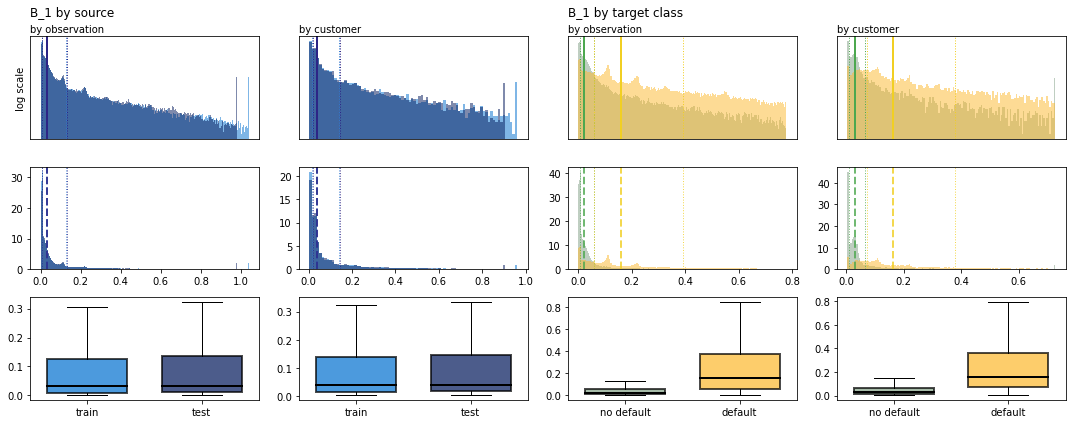


-

B_1
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.03133           0.03335           0.02043           0.15835
              mean           0.12401           0.12795           0.07642           0.26747
               std           0.21199           0.21269           0.15475           0.28427
----------------------------------------------------------------------------------------------------
by_cust     median           0.03872           0.03924           0.02906           0.16288
              mean           0.12663           0.12812           0.07911           0.26261
               std           0.19829           0.19597           0.14354           0.26064
----------------------------------------------------------------------------------------------------
___________________________________________________

In [90]:
plot_next()

Feature B_1 is similarly distributed in train_data and test_data. Customers in the training set who defaulted within the observation period exhibit a much wider range of values than those who did not. Defaulting customer values have nearly twice the standard deviation of non-defaulting customer values. The central tendency statistics for customers who defaulted are also much higher than those of customers who did not default.<br><br>
The distribution of values in B_1 appears to be exponential. Plot a histogram of B_1 in the train subset at the default y scale. Plot histograms of the entire range of B_1 values in train_data on a logarithmic scale.

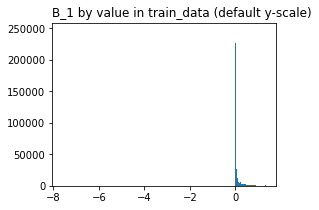

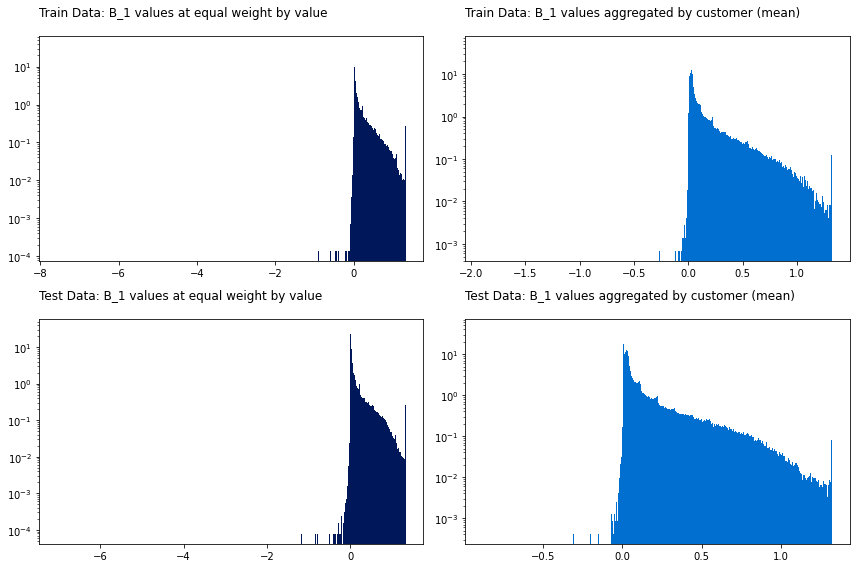

In [91]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.hist(train_data.B_1, bins='auto')
ax.set_title('B_1 by value in train_data (default y-scale)', x=0, loc='left')
plt.show()
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
for row, df in enumerate(dataset):
    df_name = df.attrs['name'].title().replace('_', ' ')
    axs[row, 0].hist(
        df.B_1.dropna(), bins='auto', density=True, log=True, 
        color=PALETTE[0]
    )
    axs[row, 0].set_title(
        f'{df_name}: B_1 values at equal weight by value',
        x=0, loc='left', pad=20
    )
    axs[row, 1].hist(
        df.B_1.dropna().groupby(level=0).mean(), 
        bins='auto', density=True, log=True, color=PALETTE[1]
    )
    axs[row, 1].set_title(
        f'{df_name}: B_1 values aggregated by customer (mean)', 
        x=0, loc='left', pad=20
    );
fig.tight_layout();

The first plot generated conirms B_1 has a largely exponential distribution, though the relatively small number of values less than 0 shown in subsequent plots is somewhat suggestive of either an extreme value type I distribution or an F distribution. All plots in the subplot grid indicate significant outliers below zero.<br><br> Print the percentage of non-null values in B_1 that are negative for each DataFrame in the dataset. Print the correlation coefficients of negative value aggregates with the target feature.

In [93]:
print(f'Negative values in B_1 by subset:\n{HR}')
for df in dataset:
    b_1_negative = 100 * (df.B_1 < 0).mean()
    print(f'{df.attrs["name"]:<10}{b_1_negative:>10.2f} % of nonnull values < 0')
    del b_1_negative
print(f'-\nNegative values in B_1 versus target class:\n{HR}')
n_b_1_any = (train_data.B_1.dropna() < 0).groupby(level=0).any()
n_b_1_all = (train_data.B_1.dropna() < 0).groupby(level=0).all()
n_b_1_mean = train_data.B_1.dropna().groupby(level=0).mean() < 0
n_b_1_last = train_data.B_1.dropna().groupby(level=0).last() < 0
_aggs = [n_b_1_any, n_b_1_all, n_b_1_mean, n_b_1_last]
_desc, _s = ['Any', "All", 'Mean', 'Last'], ['', 's', '', '']
for agg, name, s in zip(_aggs, _desc, _s):
    print(f'{name} B_1 value{s} < 0'.ljust(20)
          + f'{agg.corr(train_labels.target.loc[agg.index]):>10.3f}')
del [n_b_1_any, n_b_1_all, n_b_1_mean, n_b_1_last, _aggs, _desc, _s]

Negative values in B_1 by subset:
----------------------------------------------------------------------
train_data      0.27 % of nonnull values < 0
test_data       0.29 % of nonnull values < 0
-
Negative values in B_1 versus target class:
----------------------------------------------------------------------
Any B_1 value < 0       -0.053
All B_1 values < 0      -0.001
Mean B_1 value < 0      -0.011
Last B_1 value < 0      -0.024


Less than 1% of all non-null values are less than zero for B_1. Negative values in B_1 are not associated with target class.<br><br>
Negative values will be clipped or dropped. Update the Feature instance for B_1.

In [94]:
B_1.dist_type = 'exponential'; B_1.flags.append('Low outliers')

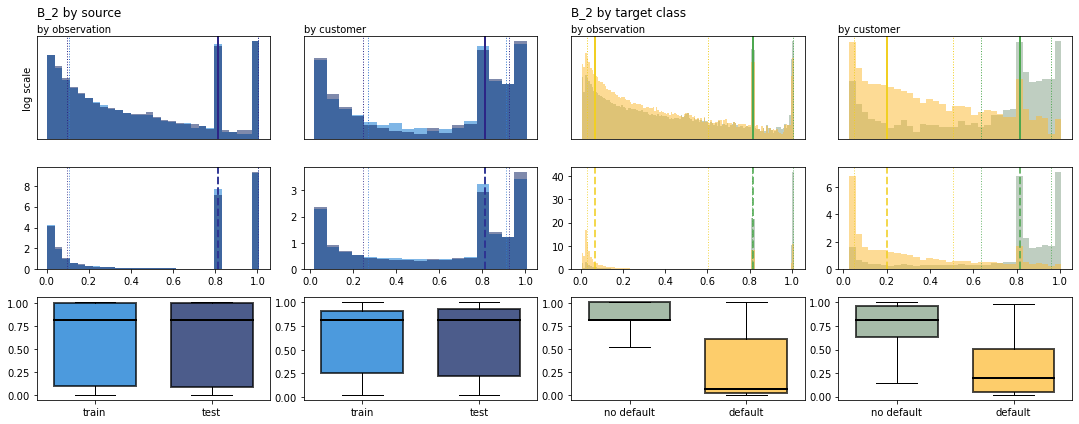


-

B_2
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.81433           0.81430           0.81747           0.06563
              mean           0.62149           0.61676           0.73318           0.28472
               std           0.40149           0.40592           0.34683           0.36537
----------------------------------------------------------------------------------------------------
by_cust     median           0.81405           0.81406           0.81628           0.20328
              mean           0.62105           0.61898           0.73134           0.30540
               std           0.35025           0.35683           0.29907           0.28868
----------------------------------------------------------------------------------------------------
___________________________________________________

In [95]:
plot_next()

Feature B_2 appears to have a multimodal exponential or multimodeal inverse Gaussian distribution. Values are clustered towards the extremes of the range. At equal weight by observation,  distributions by source and target class are right-tailed with peaks around 0.8 and 1. The histogrrams of average B_2 values by customer are more revealing. In the training set, customers with values towards the upper end of B_2's range predominantly did not default. The boxplots show no overlap in the iqrs of default and no default subsets.<br><br>
Update the Feature instance for B_2.

In [96]:
B_2.dist_type = 'multimodel exponential'

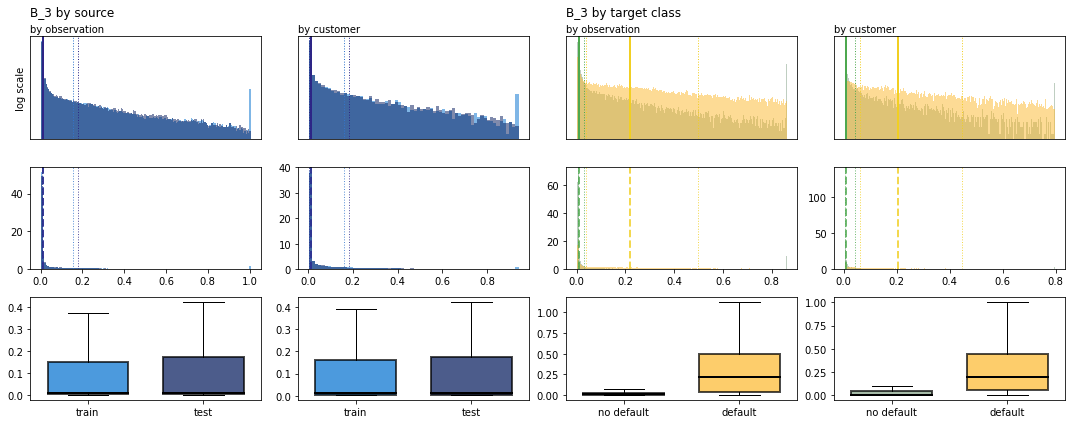


-

B_3
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00978           0.01065           0.00814           0.21790
              mean           0.13254           0.14340           0.07439           0.30787
               std           0.23499           0.24511           0.17173           0.30309
----------------------------------------------------------------------------------------------------
by_cust     median           0.01188           0.01320           0.00722           0.20522
              mean           0.12790           0.13811           0.07235           0.28691
               std           0.21466           0.22501           0.15778           0.26944
----------------------------------------------------------------------------------------------------
___________________________________________________

In [97]:
plot_next()

B_3 is similar to feature B_1. A long right-tailed distribution is present in both the training and test data. Median values are towards the lower quarter of values in this feature's range. As with feature B_1, the default customer subset has a much higher mean, median, and standard deviation than its non-default counterpart. Features B_3 and B_1 may be collinear.<br><br>
Update Feature B_3.

In [98]:
B_3.dist_type = 'light-tailed exponential'

Print a correlation matrix for features B_1 and B_3. Generate a scatterplot of these features, encoding target class by color.

correlation matrix: B_1 x B_3:
----------------------------------------------------------------------
          B_1       B_3
B_1  1.000000  0.761843
B_3  0.761843  1.000000
----------------------------------------------------------------------
 scatterplot:


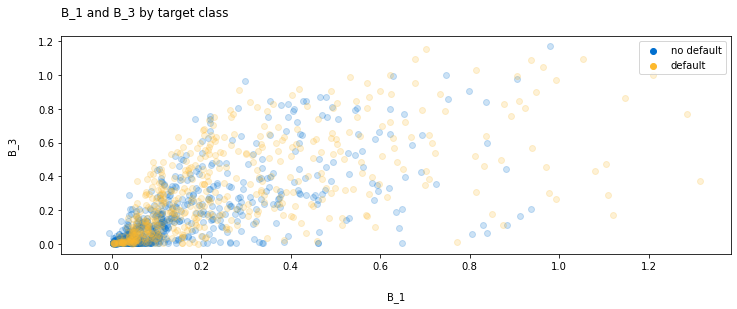

In [99]:
b1_b3 = train_data.loc[:, ['B_1', 'B_3']].dropna().groupby(level=0).mean()
print(f'correlation matrix: B_1 x B_3:\n{HR}\n{b1_b3.corr()}')
print(f'{HR}\n scatterplot:')

b1_b3_sample = pd_stratified_sample(train_labels.target.loc[b1_b3.index], 2000)
b1_b3 = b1_b3.loc[b1_b3_sample]; 
b1_b3_c = train_labels.target.loc[b1_b3_sample]
_nd, _d = b1_b3_c[b1_b3_c==0].index, b1_b3_c[b1_b3_c==1].index
fig, ax = plt.subplots(figsize=(12, 4))
ax.set_title('B_1 and B_3 by target class', x=0, loc='left', pad=20)
for ind, color, label, z in zip([_nd, _d], [PALETTE[1], PALETTE[3]], ['no default', 'default'], [1, 1]):
    ax.scatter(b1_b3.loc[ind].B_1, b1_b3.loc[ind].B_3, color=color, alpha=0.2, zorder=z)
    ax.scatter([], [], color=color, label=label)
ax.set_xlabel('B_1', labelpad=20); ax.set_ylabel('B_3', labelpad=20);
ax.legend();

These features are indeed correlated, but they may be better visualized after they are preprocessed and transformed. Though their summary statistics suggest a certain measure of separation of the target classes, their combination offers no apparent decision boundary in the scatterplot shown above.

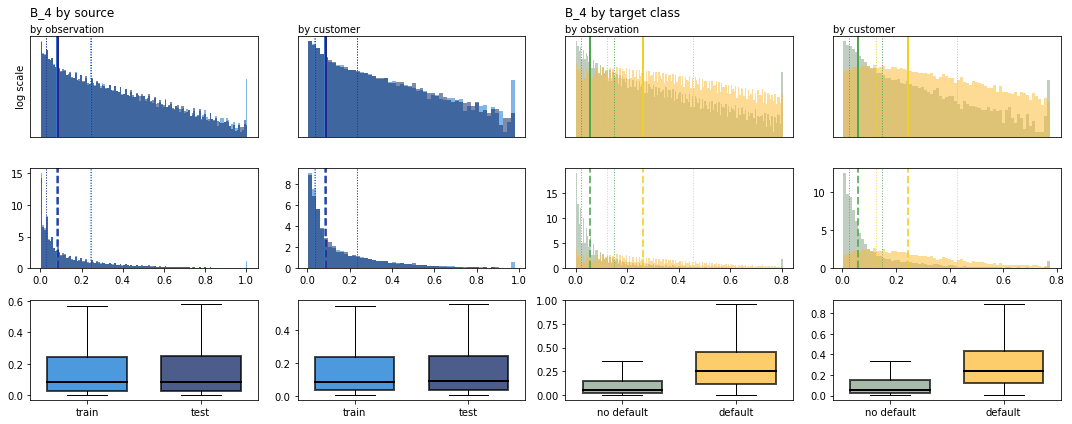


-

B_4
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.08223           0.08399           0.05485           0.26004
              mean           0.17255           0.17527           0.12085           0.32840
               std           0.22241           0.22493           0.16984           0.28158
----------------------------------------------------------------------------------------------------
by_cust     median           0.08514           0.08643           0.05761           0.24613
              mean           0.16987           0.17241           0.12002           0.31252
               std           0.20894           0.21204           0.15960           0.26123
----------------------------------------------------------------------------------------------------
___________________________________________________

In [100]:
plot_next()

Feature B_4's distributions in the default and no default subsets are less distinct than other features in the balance caegory when viewed on a logarithmic scale. Otherwise, values in the no default subset tend to be lower than those of the default subset. Values appear clustered at discrete steps. If these values are quantized or nearly quantized, they may be used in training a noise reduction model. <br><br>
Update the Feature instance for B_4.

In [101]:
B_4.dist_type = 'exponential'
B_4.subset_dist_types['default'] = 'chi square'
B_4.subset_dist_types['no default'] = 'exponential'

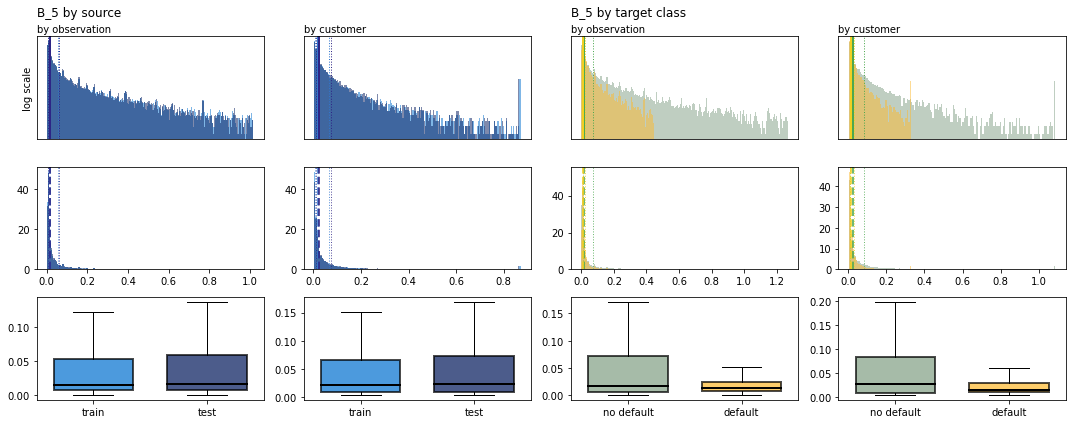


-

B_5
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.01538           0.01683           0.01738           0.01264
              mean           0.08311           0.08922           0.09804           0.03812
               std           0.39704           0.38321           0.43833           0.22581
----------------------------------------------------------------------------------------------------
by_cust     median           0.02124           0.02406           0.02648           0.01492
              mean           0.08010           0.08718           0.09542           0.03624
               std           0.31148           0.29844           0.34542           0.17497
----------------------------------------------------------------------------------------------------
___________________________________________________

In [102]:
plot_next()

The interquartile range of feature B_5 is somewhat inconsistent between the train and test subsets. As with feature B_3, the test subset's iqr for feature B_5 is larger than that of the train subset, due mostly to a higher 75th percentile. Values for customers in the default subset are restricted to a much narrower range of than values of those in the no default subset. There do not appear to be any values higher than 0.4, which seems somewhat suspicious. This will require further investigation. 

In [103]:
B_5.dist_type='exponential'

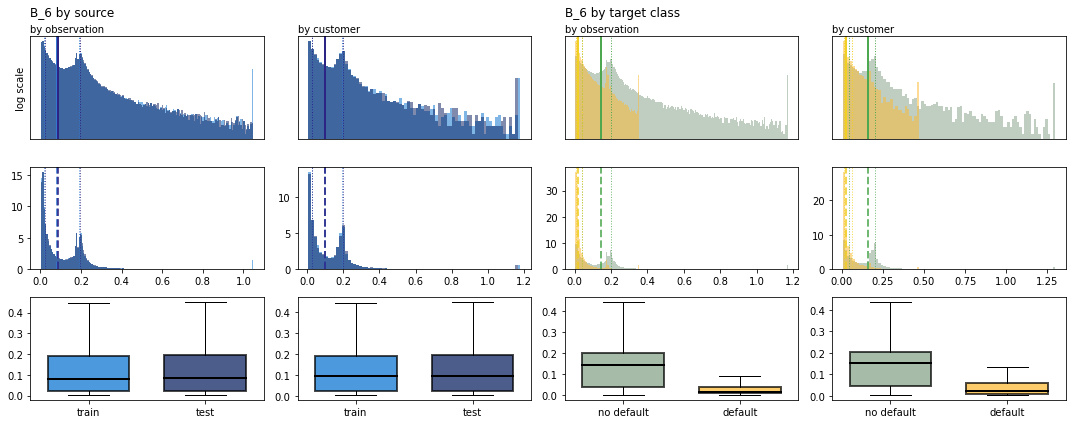


-

B_6
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.08338           0.08705           0.14604           0.01787
              mean           0.15212           0.15546           0.18602           0.04992
               std           1.47677           0.72790           1.68913           0.37454
----------------------------------------------------------------------------------------------------
by_cust     median           0.09591           0.09998           0.15679           0.02446
              mean           0.16010           0.16075           0.19502           0.06016
               std           1.01431           0.50934           1.16873           0.22491
----------------------------------------------------------------------------------------------------
___________________________________________________

In [104]:
plot_next()

Feature B_6 is bimodal. It exhibits some of the same quirks as feature B_5. Customers in the no default subset apper to follow an almost log-normal distribution. Customers in the default subset appear to be distributed in a manner that quite closely resembles their distribution for feature B_5.

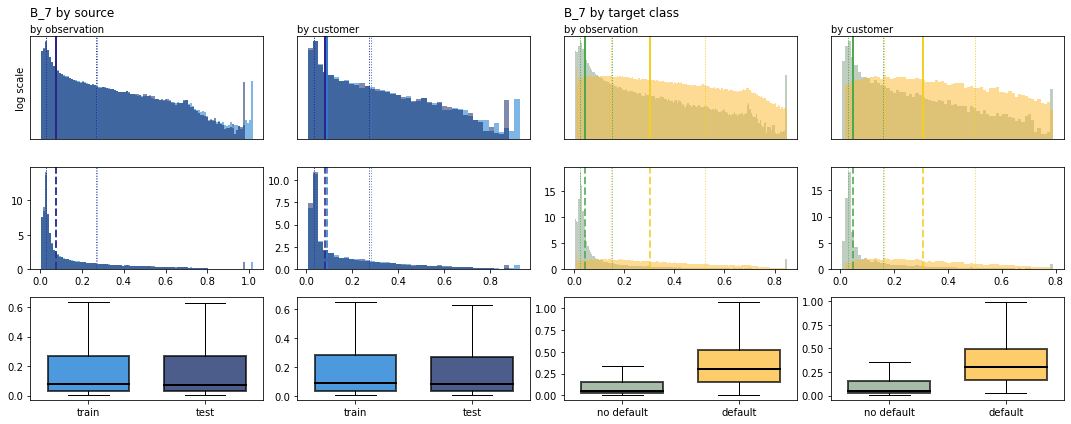


-

B_7
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.07575           0.07328           0.04464           0.30254
              mean           0.18608           0.18268           0.12890           0.35848
               std           0.23042           0.22656           0.18595           0.26330
----------------------------------------------------------------------------------------------------
by_cust     median           0.08804           0.08258           0.04716           0.30597
              mean           0.18896           0.18355           0.13161           0.35308
               std           0.21648           0.21150           0.17569           0.23727
----------------------------------------------------------------------------------------------------
___________________________________________________

In [105]:
plot_next()

Feature B_7 appears quite similar to B_4. The class distinctions mentioned for B_4 also apply to B_7.

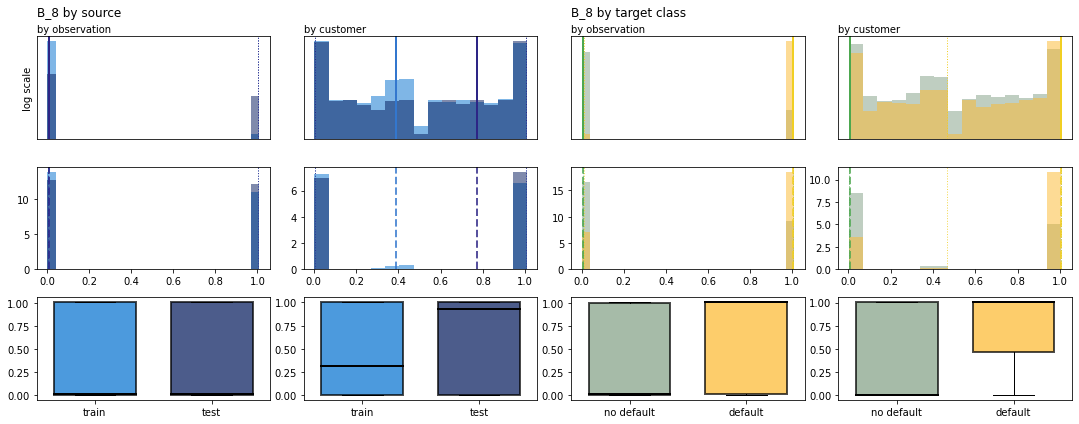


-

B_8
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00902           0.00976           0.00773           1.00291
              mean           0.45058           0.49287           0.35793           0.73021
               std           0.49694           0.49975           0.47781           0.44626
----------------------------------------------------------------------------------------------------
by_cust     median           0.38794           0.77295           0.00592           1.00437
              mean           0.48097           0.51574           0.38571           0.75412
               std           0.48403           0.49232           0.46679           0.42505
----------------------------------------------------------------------------------------------------
___________________________________________________

In [106]:
plot_next()

Feature B_8 appears to be binary data with added noise. The distributions of mean values by customer are quantized at discrete steps formed by the number of observations per customer. Values are split somewhat evenly between 0 and 1. There average value per customer is much closer to one in test_data than it is in train_data. This feature may be dropped for this reason. <br><br>

In [107]:
B_8.feature_type = 'binary'
B_8.dist_type = 'binary + noise'
B_8.processing_steps['as binary'] = methodcaller('round')

Print value counts of rounded values in feature B_8.

In [108]:
print(f'feature B_8: binary + noise?\n{HR}')
for df in dataset:
    print(f'{df.attrs["name"]}\n'
         + f'{round(100 * round(train_data.B_8, 1).value_counts(normalize=True))}\n-')

feature B_8: binary + noise?
----------------------------------------------------------------------
train_data
0.0    55.0
1.0    45.0
Name: B_8, dtype: float64
-
test_data
0.0    55.0
1.0    45.0
Name: B_8, dtype: float64
-


Rounded to a single decimal place, all values in train_data and test_data are 0 or 1 for feature B_8.<br><br>
Print the number of B_8 values in train_data that are equal to 0 and 1.

In [112]:
print(f'number of values equal to 1: {(train_data.B_8==1).sum()}')
print(f'number of values equal to 0: {(train_data.B_8==0).sum()}')

number of values equal to 1: 0
number of values equal to 0: 0


Though all values are quite near 0 and 1, no values are equal to 0 and 1. Feature B_8 will be an excellent training source for noise reduction models.

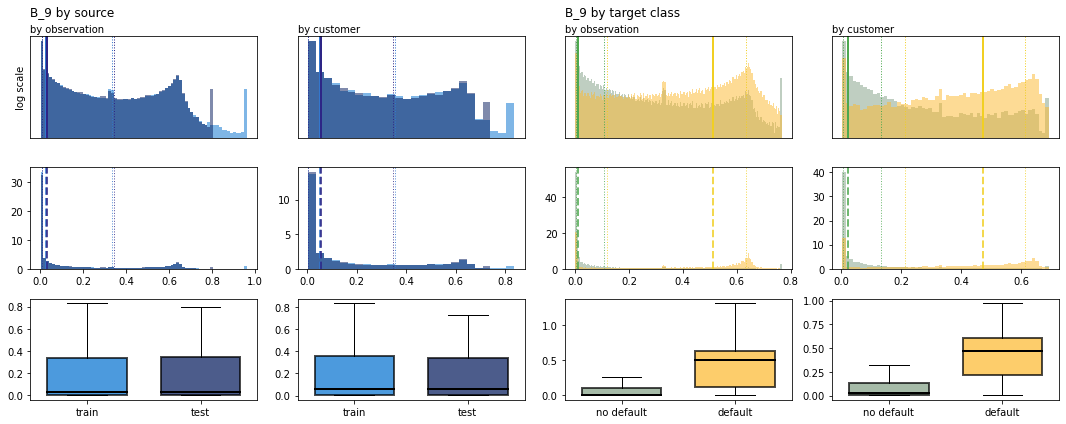


-

B_9
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.02588           0.03135           0.00943           0.51144
              mean           0.18952           0.18860           0.11106           0.42604
               std           0.28627           0.27509           0.21216           0.34470
----------------------------------------------------------------------------------------------------
by_cust     median           0.05445           0.05638           0.02089           0.47086
              mean           0.19194           0.18905           0.11332           0.41696
               std           0.25326           0.24810           0.18819           0.27933
----------------------------------------------------------------------------------------------------
___________________________________________________

In [113]:
plot_next()

Feature B_9 somewhat resembles the inverse of feature B_2 combined with the inverse of feature B_6. This distribution appears multimodal, with distinct peaks around 0.36, 0.64, and 0.8. Class Distinctions are somewhat unclear. If this feature is a modulation or combination of other balance features in this dataset, it may be used in rendering a more comprehensible composite feature. In its current state, B_9 is not easily interpretable.

In [114]:
B_9.dist_type = 'multimodal, exponential'

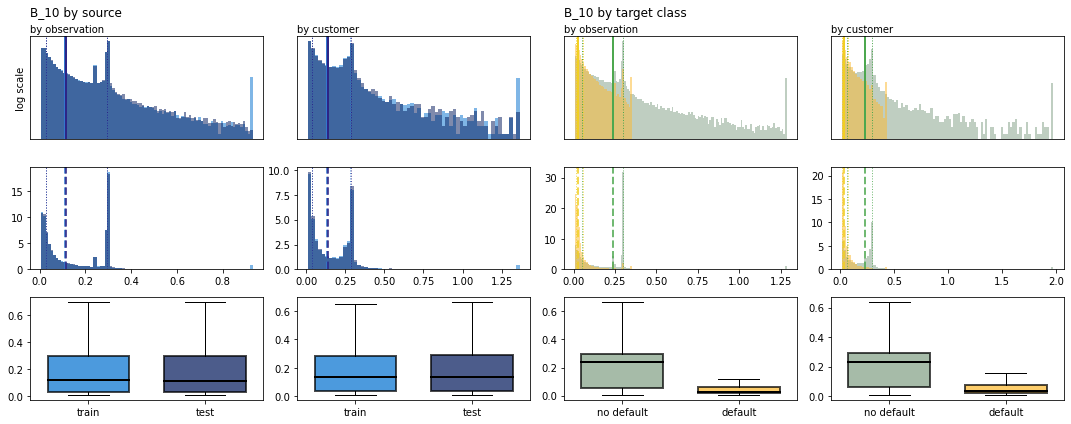


-

B_10
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.11056           0.11546           0.23905           0.02762
              mean           0.23160           0.25306           0.28192           0.07990
               std           4.79985           5.54123           5.25276           3.04679
----------------------------------------------------------------------------------------------------
by_cust     median           0.13074           0.13874           0.23147           0.03452
              mean           0.23300           0.25501           0.28450           0.08561
               std           2.15628           2.08502           2.43229           0.99780
----------------------------------------------------------------------------------------------------
__________________________________________________

In [115]:
plot_next()

Feature B_10 is quite similar to features B_5 and B_6. The decay of its right-tail is somewhat steeper, and values for the default subset are clustered closer together than they are in features B_5 and B_6.

In [116]:
B_10.dist_type = 'exponential multimodal'

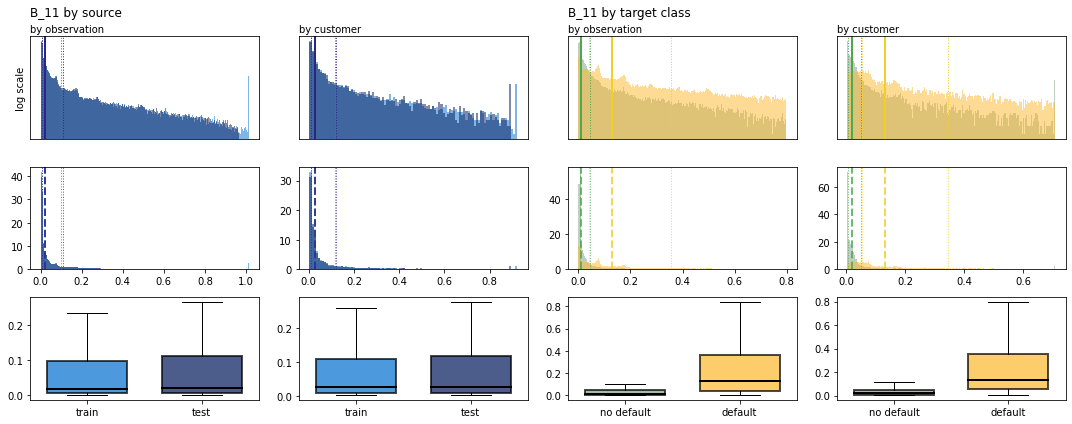


-

B_11
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.01945           0.02152           0.01038           0.12832
              mean           0.11097           0.11507           0.06672           0.24437
               std           0.20826           0.20963           0.15085           0.28603
----------------------------------------------------------------------------------------------------
by_cust     median           0.02794           0.02866           0.01920           0.13309
              mean           0.11292           0.11482           0.06888           0.23898
               std           0.19434           0.19270           0.13953           0.26209
----------------------------------------------------------------------------------------------------
__________________________________________________

In [117]:
plot_next()

Feature B_11 follows an exponential distribution overall. The default subset appears to follow a multimodal exponential distribution, with several peaks resembling the upper portion of a theoretical extreme value type I distribution. Values in the no default subset have a much smaller iqr than those in the default subset.

In [118]:
B_11.dist_type = 'exponential'
B_11.subset_dist_types['default'] = 'exponential multimodal extreme val type I peaks'
B_11.subset_dist_types['no default'] = 'exponential'

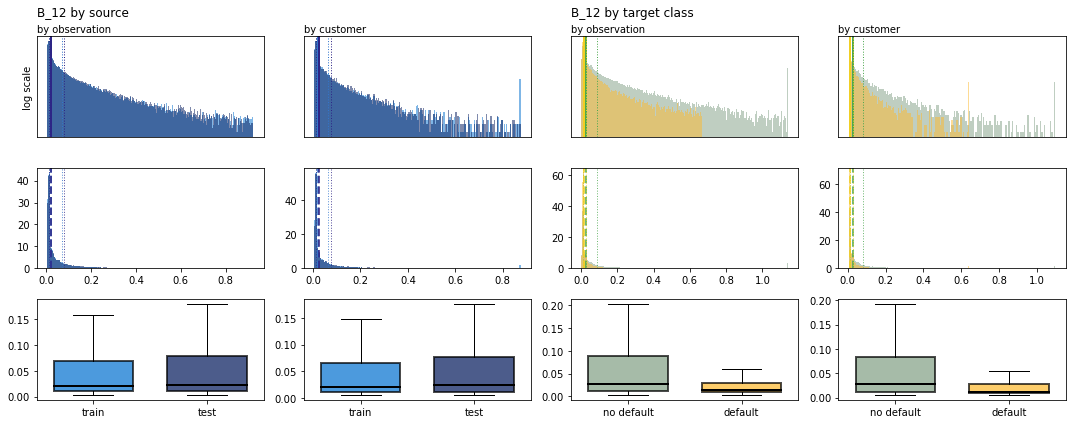


-

B_12
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.01944           0.02265           0.02552           0.01379
              mean           0.09370           0.10389           0.10682           0.05413
               std           0.82043           0.59781           0.92047           0.38209
----------------------------------------------------------------------------------------------------
by_cust     median           0.02039           0.02385           0.02663           0.01213
              mean           0.08998           0.10169           0.10351           0.05125
               std           0.78009           0.59567           0.88029           0.36105
----------------------------------------------------------------------------------------------------
__________________________________________________

In [119]:
plot_next()

B_12 follows an exponential distribution. As with features B_5, B_6, and B_10, values for feature B_12 in the default subset are constrained to a narrower range than those of the default subset.

In [120]:
B_12.dist_type = 'exponential'

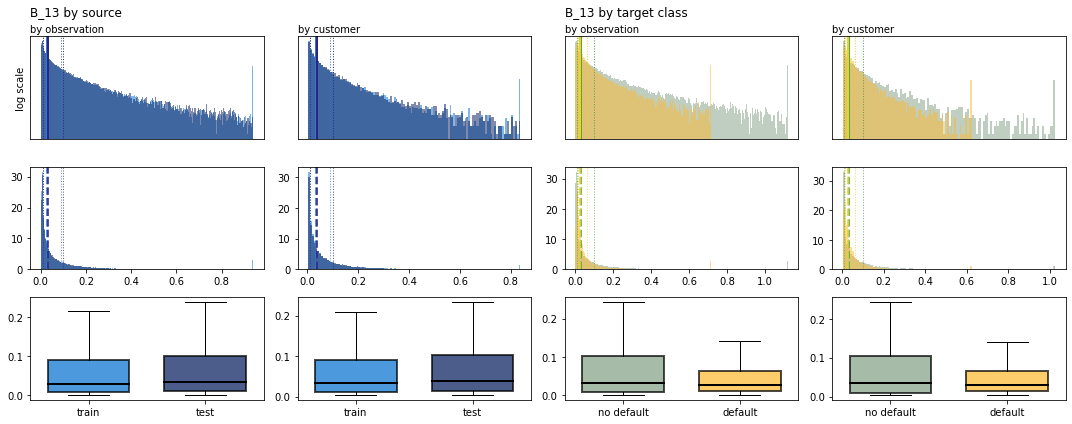


-

B_13
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.02931           0.03249           0.03112           0.02597
              mean           0.10072           0.11080           0.11015           0.07195
               std           0.55938           0.53870           0.61003           0.36218
----------------------------------------------------------------------------------------------------
by_cust     median           0.03349           0.03782           0.03590           0.02948
              mean           0.09838           0.10928           0.10811           0.07049
               std           0.48490           0.50870           0.52872           0.32663
----------------------------------------------------------------------------------------------------
__________________________________________________

In [121]:
plot_next()

B_13 is remarkably similar to feature B_12. The same comments and analysis apply.

In [122]:
B_13.dist_type = 'exponential'

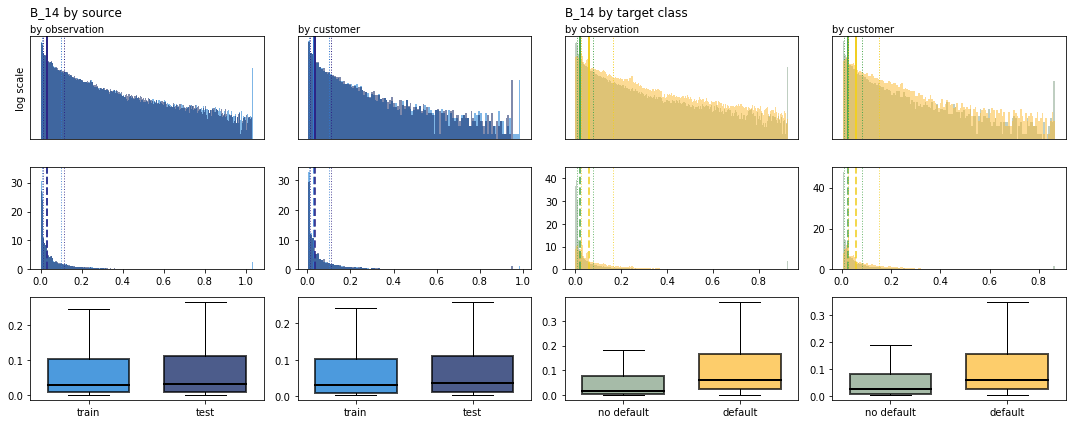


-

B_14
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.02849           0.03174           0.01924           0.05928
              mean           0.10115           0.11070           0.08747           0.14239
               std           0.28358           0.28666           0.27700           0.29880
----------------------------------------------------------------------------------------------------
by_cust     median           0.03231           0.03671           0.02477           0.05911
              mean           0.09808           0.10790           0.08534           0.13455
               std           0.25471           0.26097           0.24728           0.27157
----------------------------------------------------------------------------------------------------
__________________________________________________

In [123]:
plot_next()

B_14 is notable for having no missing values and for following a relatively smooth exponential distribution.

In [124]:
B_14.dist_type = 'exponential'

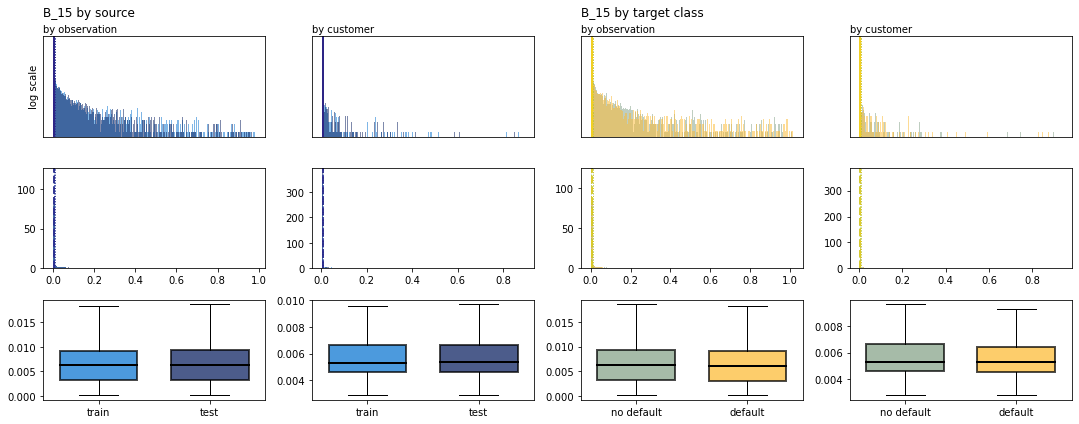


-

B_15
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00623           0.00627           0.00628           0.00610
              mean           0.05281           0.05562           0.05153           0.05665
               std           0.30055           0.29882           0.29795           0.30822
----------------------------------------------------------------------------------------------------
by_cust     median           0.00533           0.00534           0.00534           0.00528
              mean           0.05039           0.05408           0.04956           0.05278
               std           0.26878           0.27145           0.26524           0.27864
----------------------------------------------------------------------------------------------------
__________________________________________________

In [125]:
plot_next()

The majority of values for feature B_15 are between 0 and 0.01. Create additional plots to examine the distribution of values within this range.

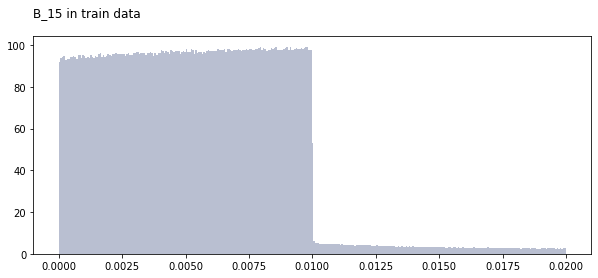

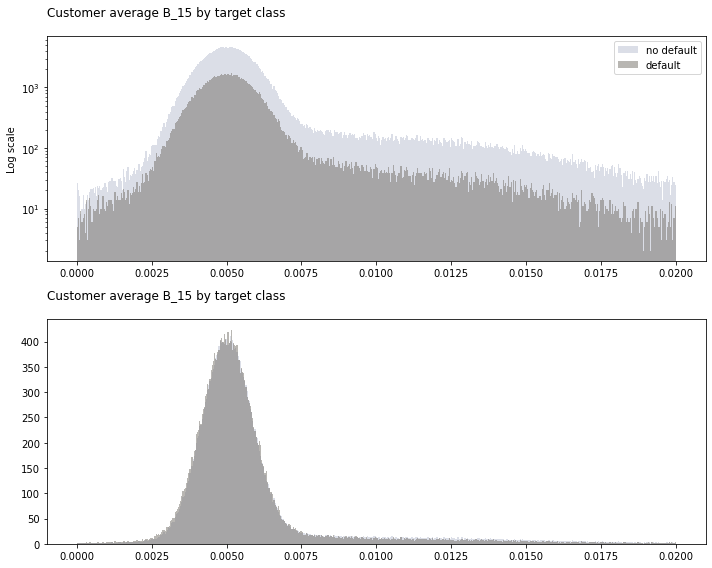

In [190]:
fig, ax = plt.subplots(figsize=(10, 4))
subset = train_data.B_15[(train_data.B_15 < 0.02) & (train_data.B_15 > 0)]
ax.hist(subset, color=PALETTE[-2], density=True, bins='auto')
ax.set_title('B_15 in train data', x=0, loc='left', pad=20)
plt.show()
fig, axs = plt.subplots(2, 1, figsize=(10, 8))
subset = subset.groupby(level=0).mean()
subset_labels = train_labels.target.loc[subset.index]
nd_sub, d_sub = subset_labels[subset_labels==0], subset_labels[subset_labels==1]
nd_sub, d_sub = nd_sub.index, d_sub.index
bins = np.histogram_bin_edges(subset, bins='auto')
for _sub, color, lbl in zip([nd_sub, d_sub], PALETTE[-2:], ['no ', '']):
    axs[0].hist(subset.loc[_sub], color=color, label=f'{lbl}default', alpha=0.5,
            log=True, bins=bins)
axs[0].set_title('Customer average B_15 by target class', x=0, loc='left',
                 pad=20);
axs[0].set_ylabel('Log scale')
for _sub, color, lbl in zip([nd_sub, d_sub], PALETTE[-2:], ['no ', '']):
    axs[1].hist(subset.loc[_sub], color=color, label=f'{lbl}default', alpha=0.5,
            density=True, bins=bins)
axs[1].set_title('Customer average B_15 by target class', x=0, loc='left',
                 pad=20);
axs[0].legend()
fig.tight_layout()

The first in the series of plots above shows that values are almost uniformly distributed in the interval between 0 and 0.2.<br><br>
Target class distributions are indistinguishable from one another in the plots above. The second of the three plots above was generated using actual bin counts to allow comparison of distribution shapes.<br><br>
This feature appears to be random noise.

In [191]:
B_15.dist_type = 'uniform, noise'

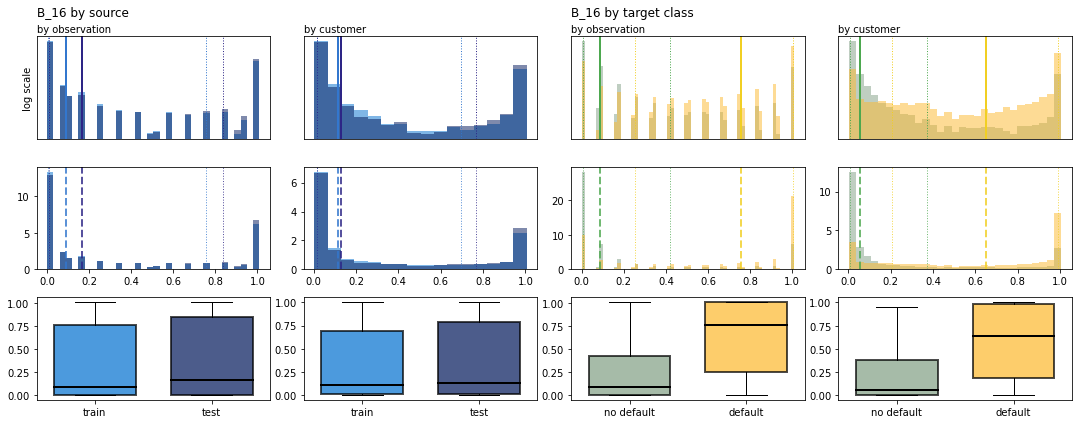


-

B_16
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.09174           0.16706           0.08462           0.75603
              mean           0.34868           0.37140           0.25677           0.62578
               std           0.40236           0.41021           0.36123           0.39285
----------------------------------------------------------------------------------------------------
by_cust     median           0.11294           0.12847           0.05583           0.65204
              mean           0.33364           0.35622           0.24780           0.57930
               std           0.38328           0.39320           0.34521           0.38060
----------------------------------------------------------------------------------------------------
__________________________________________________

In [126]:
plot_next()

Values for feaure B_16 are distributed at discrete intervals. Distributions by target class are distinct. Values at the lower end of this feature's range are mostly from customers in the no default subset. As with other balance features, the interquartile range of values in the test subset is larger than that of the train susbet.<br><br>
The overall shape of B_16 resembles a beta distribution, with peaks at either end.<br><br>
The distribution of values in B_16 at equal weight by observation somewhat resembles the distribution of a binary feature aggregated by customer, as intermediate steps are formed at regular intervals between zero and one. This phenomenon is not likely the result of aliasing from bin bias, as it remains noticeable even at very high bin counts.

In [127]:
B_16.dist_type = 'Poisson, beta'

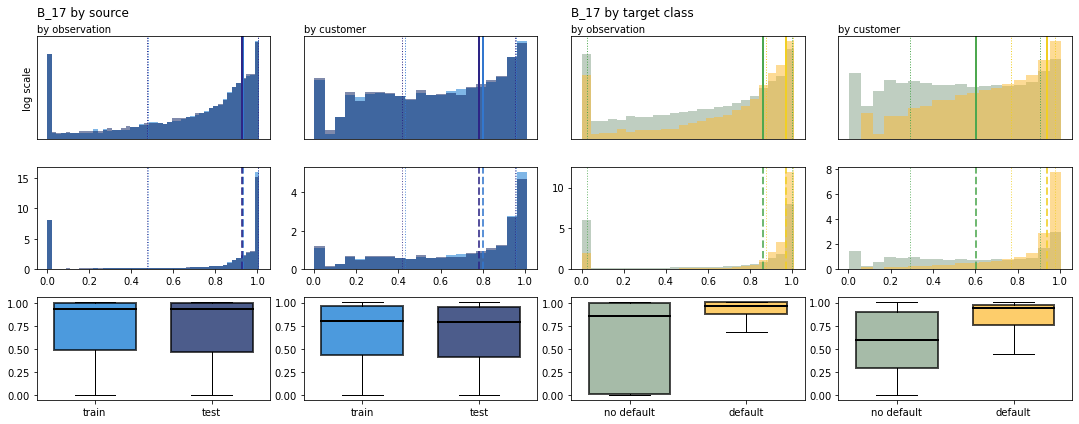


-

B_17
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.93209           0.92888           0.86118           0.97017
              mean           0.71524           0.71268           0.62528           0.84213
               std           0.38667           0.38535           0.41768           0.29466
----------------------------------------------------------------------------------------------------
by_cust     median           0.79897           0.78239           0.60224           0.93926
              mean           0.68079           0.67151           0.57522           0.84023
               std           0.31419           0.31443           0.32800           0.20751
----------------------------------------------------------------------------------------------------
__________________________________________________

In [128]:
plot_next()

Feature B_17 appears to follow a multimodal exponential distribution, with significant peaks at zero and one.

In [129]:
B_17.dist_type = 'multimodal exponential'

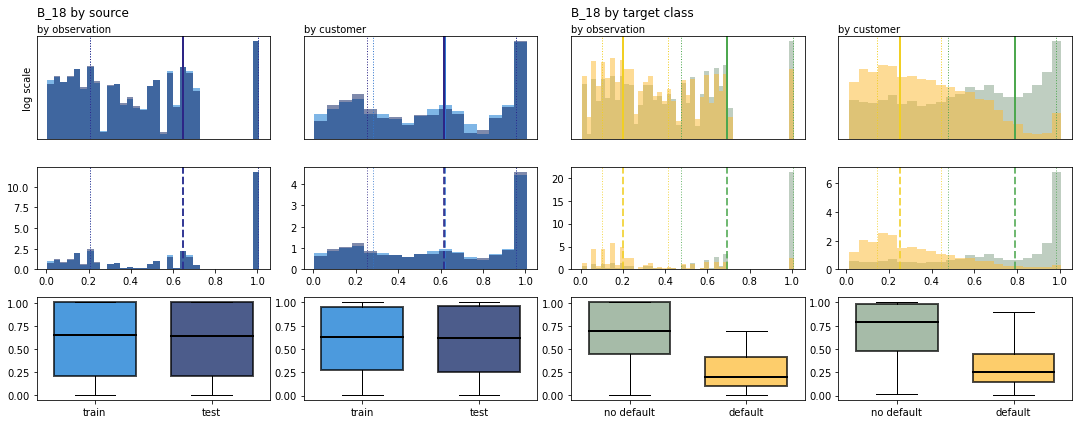


-

B_18
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.64663           0.64566           0.69500           0.20164
              mean           0.59624           0.59012           0.69887           0.28685
               std           0.36561           0.37101           0.33758           0.25613
----------------------------------------------------------------------------------------------------
by_cust     median           0.62113           0.61818           0.78977           0.25310
              mean           0.59843           0.59400           0.69940           0.30943
               std           0.33455           0.34215           0.30727           0.22211
----------------------------------------------------------------------------------------------------
__________________________________________________

In [130]:
plot_next()

Values for feature B_18 are lumped in discrete intervals, with a notable gap between 0.7 and 1. Customers in the no default subset account for the majority of values approximately equal to 1, while cutstomers in the default subset account for the majority of values less than 0.4. In its current state, feature B_18 is largely unituitive.

In [131]:
B_18.dist_type = 'multimodal'
B_18.subset_dist_types['default'] = 'chi square'
B_18.subset_dist_types['no default'] = 'exponential multimodal'

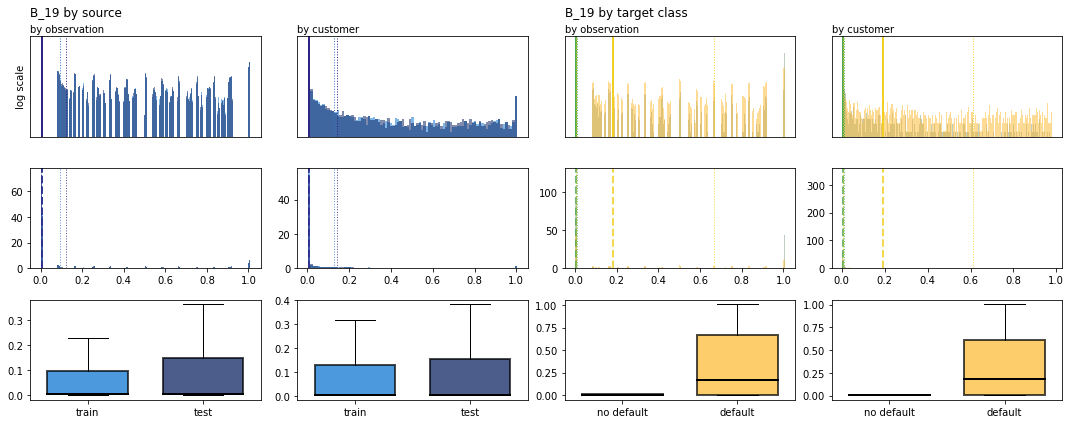


-

B_19
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00691           0.00704           0.00603           0.18377
              mean           0.15014           0.15766           0.08534           0.34551
               std           0.28962           0.29563           0.22155           0.37143
----------------------------------------------------------------------------------------------------
by_cust     median           0.00576           0.00578           0.00539           0.19188
              mean           0.14693           0.15350           0.08400           0.32705
               std           0.27239           0.27950           0.20977           0.34181
----------------------------------------------------------------------------------------------------
__________________________________________________

In [132]:
plot_next()

Feature B_19 appears to follow a poisson distribution with a low lambda value. The interquartile ranges of the default and no default subsets are quite different, and there are few missing values for this feature. B_19 may be especially useful during model training.

In [133]:
B_19.dist_type = 'Poisson'

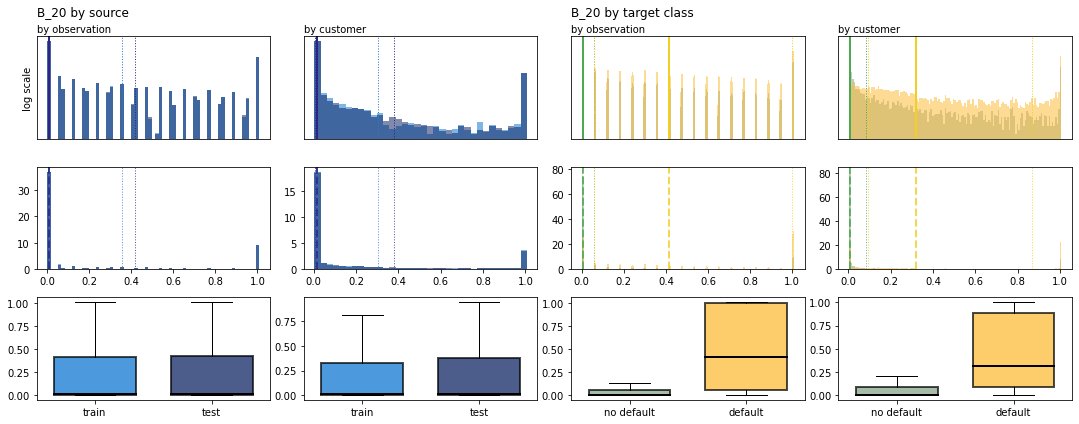


-

B_20
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00807           0.00829           0.00671           0.41554
              mean           0.23630           0.25378           0.15391           0.48472
               std           0.37370           0.38516           0.32079           0.41021
----------------------------------------------------------------------------------------------------
by_cust     median           0.01377           0.01485           0.00608           0.31741
              mean           0.22572           0.24328           0.14833           0.44721
               std           0.34713           0.35943           0.29747           0.38196
----------------------------------------------------------------------------------------------------
__________________________________________________

In [134]:
plot_next()

Features B_19 and B_20 are both distirbuted at discrete steps between 0 and 1, but B_20 features fewer steps and offers less interquartile range distinction between targfet classes. That said, central tendency statistics for target classes have higher contrast in feature B_20.

In [135]:
B_20.dist_type = 'Poisson'

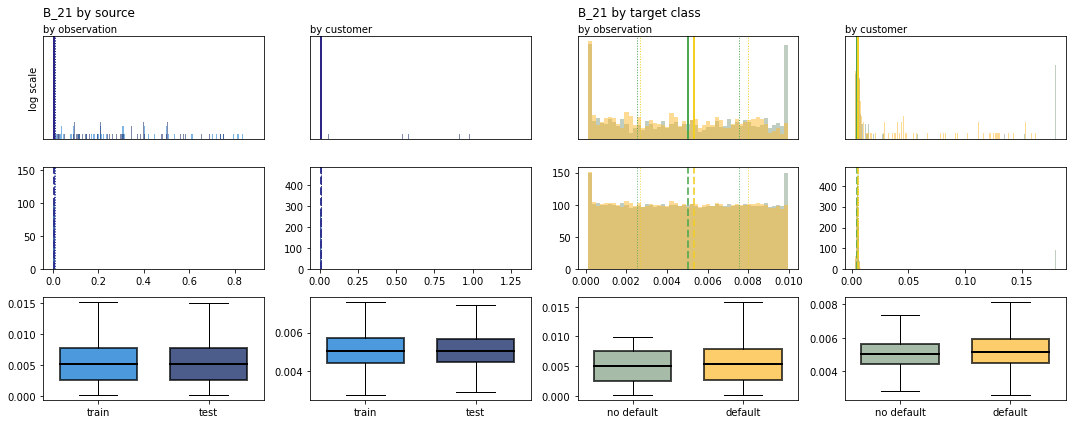


-

B_21
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00510           0.00509           0.00504           0.00531
              mean           0.05315           0.04400           0.01615           0.16470
               std           0.71964           0.66124           0.28703           1.34688
----------------------------------------------------------------------------------------------------
by_cust     median           0.00506           0.00506           0.00503           0.00518
              mean           0.06159           0.04799           0.01760           0.18748
               std           0.61772           0.52538           0.23583           1.13715
----------------------------------------------------------------------------------------------------
__________________________________________________

In [136]:
plot_next()

Values for feature B_21 are largely restricted to the narrow range between 0 and 0.01. The distribution of values within this range is nearly uniform. Values for the default subset are much more widely distributed than those of the no default subset.

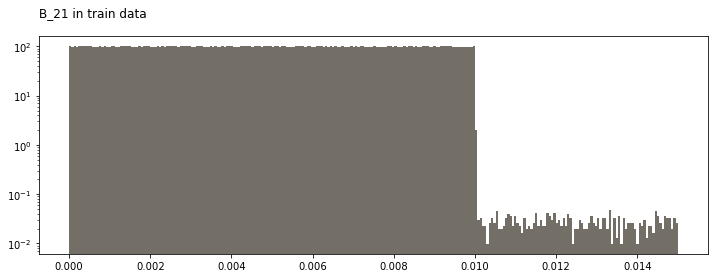

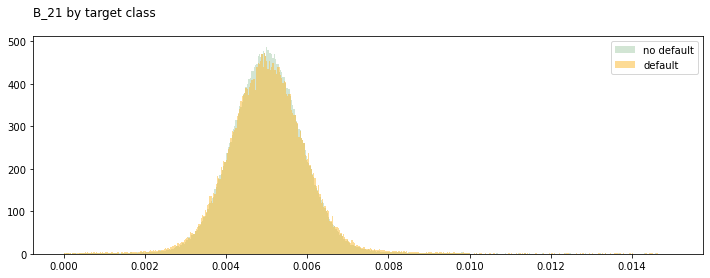

In [215]:
fig, ax = plt.subplots(figsize=(12, 4))
subset = train_data.B_21[(train_data.B_21 < 0.015) & (train_data.B_21 > -0.1)]
ax.hist(subset, density=True, color=PALETTE[-1], bins='auto', log=True)
ax.set_title('B_21 in train data', loc='left', x=0, pad=20);
subset = train_data.B_21.groupby(level=0).mean()
subset = subset[(subset > -0.1) & (subset < 0.015)]
sub_lbl = train_labels.target.loc[subset.index]
nd_sub, d_sub = sub_lbl[sub_lbl==0], sub_lbl[sub_lbl==1]
nd_sub, d_sub = nd_sub.index, d_sub.index
bins = np.histogram_bin_edges(subset, bins='auto')
fig, ax = plt.subplots(figsize=(12, 4))
for sub, n, c in zip([nd_sub, d_sub], ['no ', ''], PALETTE[2:]):
    ax.hist(subset.loc[sub], color=c, label=f'{n}default', 
            density=True, bins=bins, alpha=0.5)
ax.set_title('B_21 by target class', x=0, loc='left', pad=20)
ax.legend();

Apparent distinctions in target classes for B_21 are artifacts of the influence of outliers. The distributions shown above are nearly identical. This feature also appears to be largely comprised of noise.

In [216]:
B_21.dist_type = 'uniform'

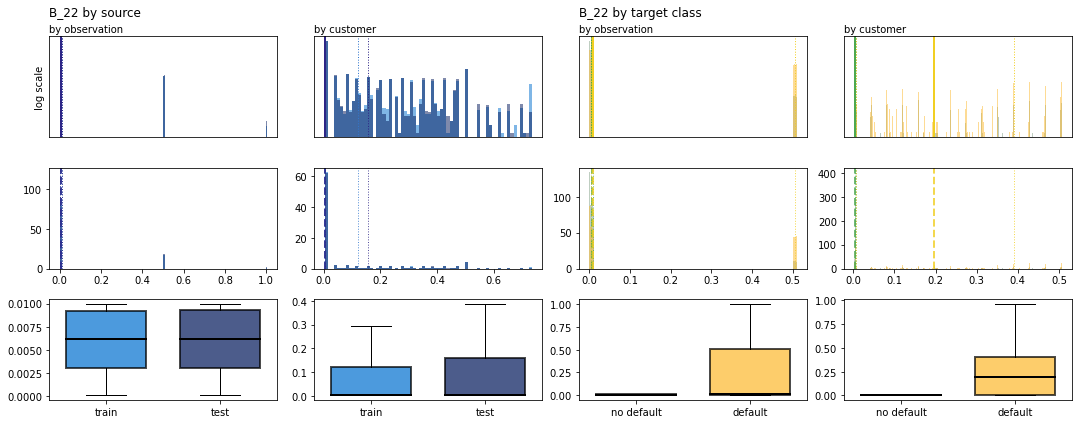


-

B_22
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00616           0.00622           0.00556           0.00910
              mean           0.10723           0.11255           0.05968           0.25060
               std           0.22326           0.23001           0.16980           0.29297
----------------------------------------------------------------------------------------------------
by_cust     median           0.00557           0.00559           0.00527           0.19722
              mean           0.10395           0.10921           0.05832           0.23454
               std           0.18494           0.19146           0.14148           0.22759
----------------------------------------------------------------------------------------------------
__________________________________________________

In [137]:
plot_next()

B_22 appears to follow a Poisson or other discrete distribution. Features are distributed at fixed steps between 0 and 1.<br><br>
Generate higher resolution histograms of each of these regions

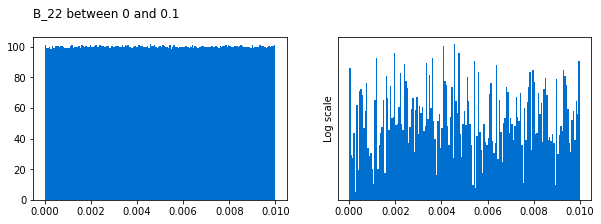

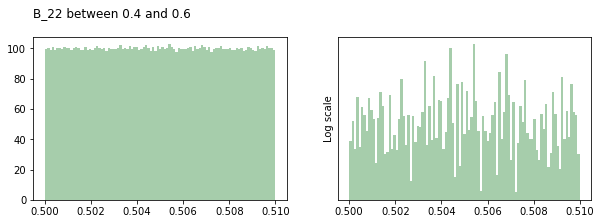

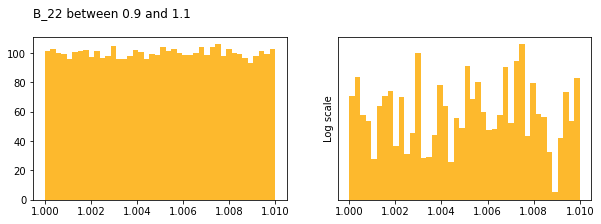

In [265]:

for i, (a_mn, a_mx) in enumerate([(0, 0.1), (0.4, 0.6), (0.9, 1.1)]):
    fig, axs = plt.subplots(1, 2, figsize=(10, 3))
    axs[0].set_title(f'B_22 between {a_mn} and {a_mx}', loc='left', x=0, pad=20)
    axs[0].hist(
        train_data.B_22[(train_data.B_22 > a_mn) & (train_data.B_22 < a_mx)],
        density=True, bins='auto', color=PALETTE[i + 1], alpha=0.7
    )
    axs[1].hist(
        train_data.B_22[(train_data.B_22 > a_mn) & (train_data.B_22 < a_mx)],
        density=True, bins='auto', color=PALETTE[i + 1], log=True, alpha=0.7
    )
    axs[1].set_ylabel('Log scale'); axs[1].set_yticks([], [], minor=True);
    axs[1].set_yticks([], [])
    fig.tight_layout;

The histograms within each subset plotted above reveal values uniformly distributed at radius of 0.005 from the mean of each subset. This likely the influence of added noise.

In [266]:
B_22.dist_type = 'Poisson'

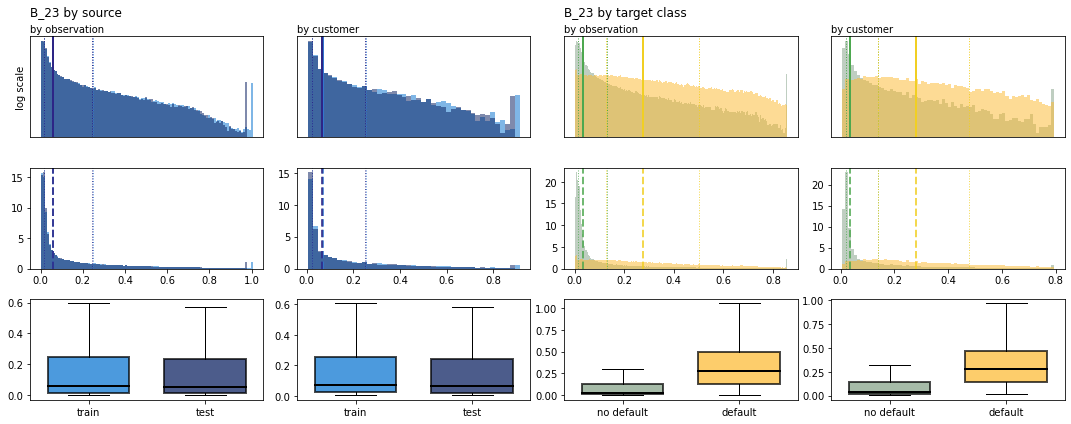


-

B_23
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.05951           0.05801           0.03223           0.27745
              mean           0.17148           0.16897           0.11558           0.33999
               std           0.22935           0.22601           0.18381           0.26741
----------------------------------------------------------------------------------------------------
by_cust     median           0.07064           0.06648           0.03479           0.27895
              mean           0.17340           0.16919           0.11769           0.33285
               std           0.21551           0.21115           0.17382           0.24207
----------------------------------------------------------------------------------------------------
__________________________________________________

In [139]:
plot_next()

B_23 follows an exponential distribution and has no missing values. It appears to be one of the most useful and uncomplicated features in the balance category.

In [316]:
B_23.dist_type = 'exponential'

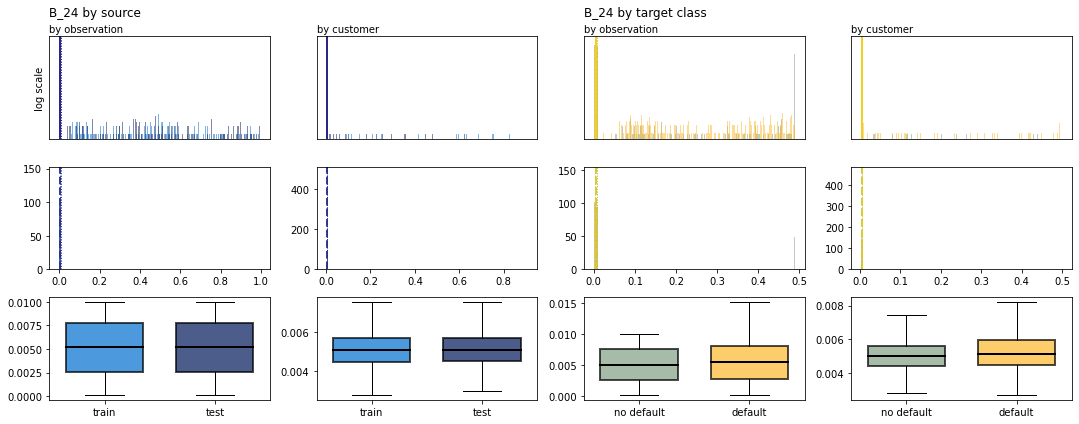


-

B_24
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00517           0.00520           0.00510           0.00542
              mean           0.03965           0.04713           0.01973           0.09970
               std           0.31722           0.36224           0.17028           0.55836
----------------------------------------------------------------------------------------------------
by_cust     median           0.00507           0.00508           0.00504           0.00516
              mean           0.03934           0.04663           0.01954           0.09600
               std           0.23444           0.26816           0.12215           0.40648
----------------------------------------------------------------------------------------------------
__________________________________________________

In [141]:
plot_next()

The histograms for feature B_24 are difficult to read. The boxplots indicate a very narrow interquartile range for this feature. Plot a histogram of the middle 90% of customers.

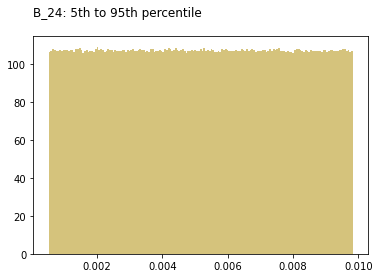

In [301]:
plt.hist(train_data.B_24[
    (train_data.B_24 > train_data.B_24.quantile(0.05))
    & (train_data.B_24 < train_data.B_24.quantile(0.95))
], density=True, bins='auto', color=PALETTE[4])
plt.title('B_24: 5th to 95th percentile', x=0, loc='left', pad=20);

The middle 90% of values for this feature are uniformly distributed. PLot histograms of the extremes of this feature's range.

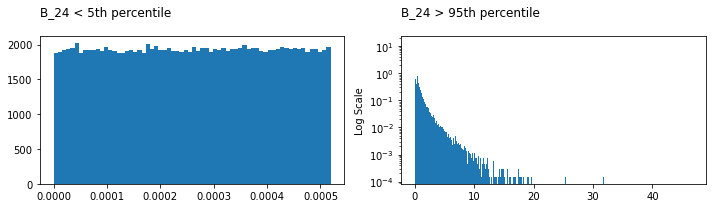

In [307]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
p05, p95 = train_data.B_24.quantile([0.05, 0.95])
axs[0].hist(train_data.B_24[train_data.B_24 < p05], density=True, bins='auto')
axs[1].hist(train_data.B_24[train_data.B_24 > p95], density=True, log=True, bins='auto')
for title, ax, in zip(['B_24 < 5th percentile', 'B_24 > 95th percentile'], axs):
    ax.set_title(title, loc='left', x=0, pad=20)
axs[1].set_ylabel('Log Scale')
fig.tight_layout(); fig.tight_layout();

The bottom 95% of values in B_24 are uniformly distributed. The top 5% follow an exponential distribution.

In [308]:
B_24.dist_type = 'uniform'
B_24.subset_dist_types['greater than 95th percentile by obs'] = 'exponential'

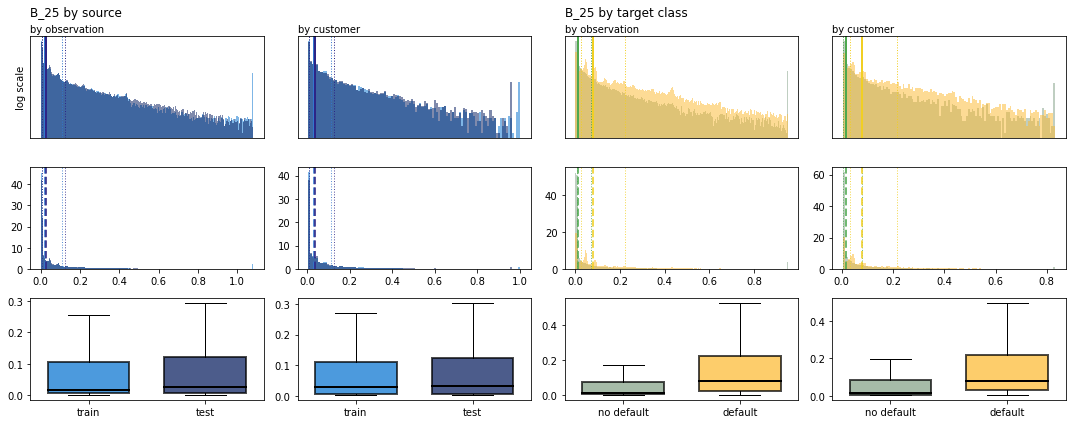


-

B_25
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.01986           0.02523           0.00975           0.07853
              mean           0.10387           0.11654           0.08152           0.17118
               std           0.20871           0.22764           0.18826           0.24891
----------------------------------------------------------------------------------------------------
by_cust     median           0.03075           0.03527           0.01674           0.07793
              mean           0.10203           0.11389           0.08067           0.16309
               std           0.18984           0.20787           0.16923           0.22840
----------------------------------------------------------------------------------------------------
__________________________________________________

In [143]:
plot_next()

As with most features in this dataset, B_25 follows an exponential distribution.

In [310]:
B_25.dist_type = 'exponential'

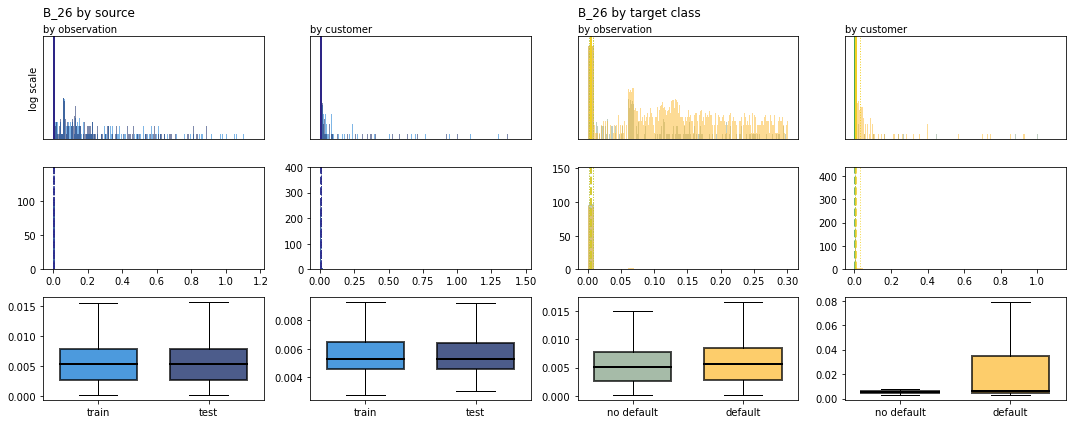


-

B_26
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00524           0.00523           0.00512           0.00563
              mean           0.09062           0.08926           0.06103           0.17984
               std           2.58821           2.29894           1.67386           4.29397
----------------------------------------------------------------------------------------------------
by_cust     median           0.00530           0.00529           0.00516           0.00618
              mean           0.08877           0.08828           0.05922           0.17334
               std           1.48092           1.22049           0.84248           2.53551
----------------------------------------------------------------------------------------------------
__________________________________________________

In [315]:
plot_next()

B_26 offers an interesting distinction in the distribution of its values by target class. Average values of customers in the no default subset have an incredibly narrow iqr compared to every other measured subset.

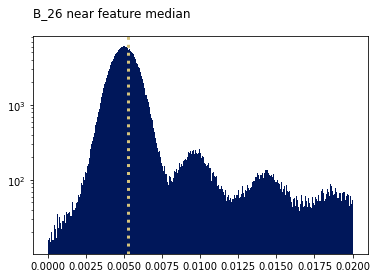

In [345]:
subset = train_data.B_26.groupby(level=0).mean()
plt.hist(subset[subset < 0.02], bins='auto', density=False, color=PALETTE[0], log=True);
plt.title('B_26 near feature median', x=0, loc='left', pad=20)
plt.axvline(train_data.B_26.median(), ls=':', color=PALETTE[4], lw=3)

At this resolution, B_26 appears to follow a multimodal power normal distribution.<br><br>
Fitting this feature to a normal distribution will require a power transformer.

In [353]:
B_26.dist_type = 'multimodal power normal'

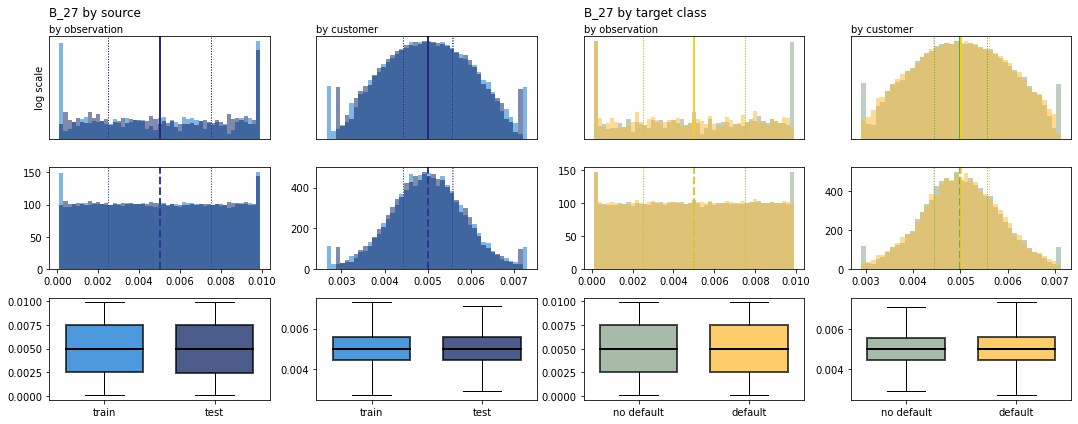


-

B_27
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00500           0.00500           0.00500           0.00501
              mean           0.00501           0.00501           0.00500           0.00503
               std           0.00301           0.00294           0.00289           0.00335
----------------------------------------------------------------------------------------------------
by_cust     median           0.00500           0.00500           0.00500           0.00501
              mean           0.00501           0.00501           0.00500           0.00503
               std           0.00099           0.00091           0.00091           0.00118
----------------------------------------------------------------------------------------------------
__________________________________________________

In [352]:
plot_next()

Feature B_27 somewhat resembles gaussian noise. At equal weight by observation, values are distributed uniformly, with peaks at the minimum and maximum values of this range. At equal weight by customer, the distribution appears normal. This feature does not appear to offer much separation of the target classes. It will most likely be dropped. <br><br>
Add this feature and reasoning to the to_drop dictionary.

In [355]:
to_drop['B_27'] = 'little to no information/no class distinction'
B_27.dist_type = 'uniform'

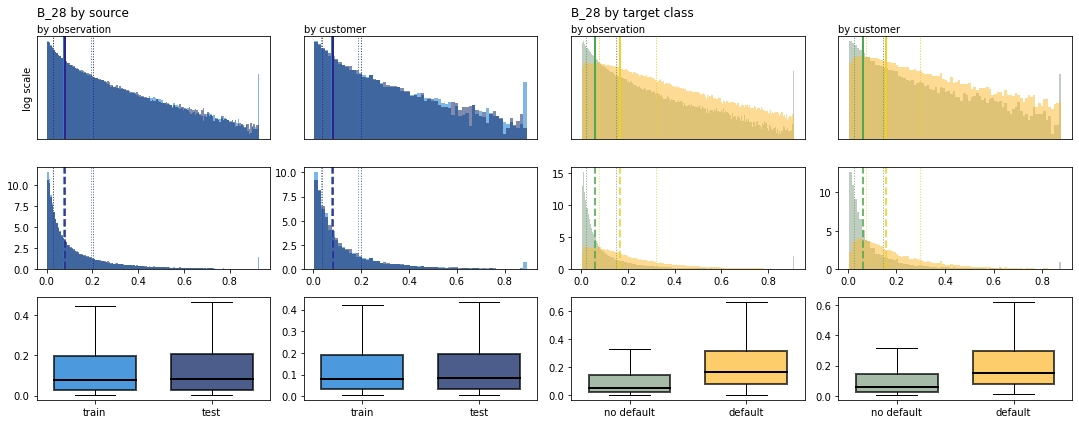


-

B_28
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.07706           0.08201           0.05724           0.16568
              mean           0.15453           0.16222           0.12499           0.24358
               std           0.22750           0.23334           0.20370           0.26859
----------------------------------------------------------------------------------------------------
by_cust     median           0.07888           0.08393           0.06032           0.15583
              mean           0.15109           0.15900           0.12314           0.23108
               std           0.21277           0.21944           0.18943           0.25201
----------------------------------------------------------------------------------------------------
__________________________________________________

In [356]:
plot_next()

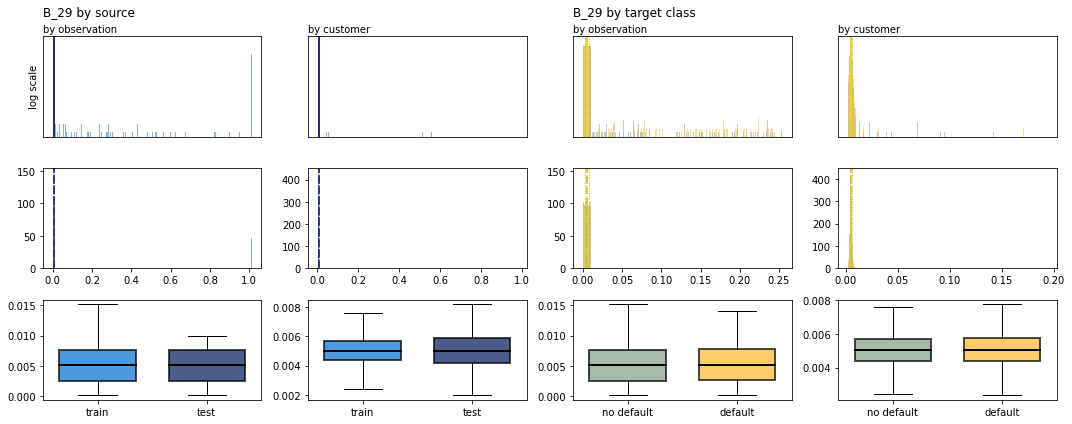


-

B_29
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00509           0.00503           0.00506           0.00518
              mean           0.03300           0.01412           0.02236           0.07071
               std           0.27651           0.16053           0.21061           0.43404
----------------------------------------------------------------------------------------------------
by_cust     median           0.00503           0.00501           0.00502           0.00506
              mean           0.02997           0.00938           0.02011           0.06370
               std           0.23584           0.10263           0.18189           0.36237
----------------------------------------------------------------------------------------------------
__________________________________________________

In [358]:
plot_next()

Feature B_29 somewhat resembles features B_20 and B_24. Uncharacteristically for features in the balance category, the train subset exhibits a wider interquartile range than the test subset. Otherwise, the plots shown above do not reveal any actionable information. This feature will be dropped.

In [359]:
to_drop['B_29'] = 'no information. train/test mismatch'

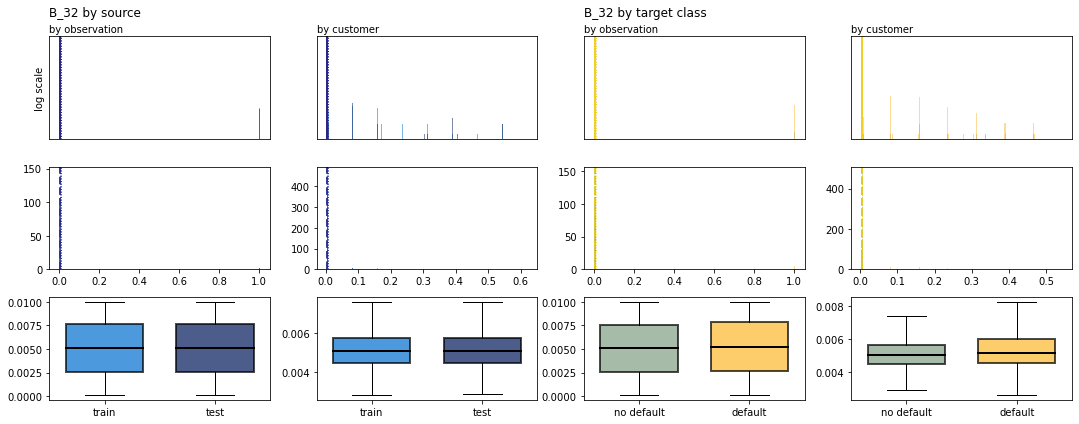


-

B_32
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00511           0.00513           0.00507           0.00526
              mean           0.02742           0.03139           0.01870           0.05370
               std           0.14806           0.16032           0.11626           0.21526
----------------------------------------------------------------------------------------------------
by_cust     median           0.00507           0.00508           0.00504           0.00517
              mean           0.02621           0.03030           0.01811           0.04939
               std           0.10538           0.11384           0.08570           0.14542
----------------------------------------------------------------------------------------------------
__________________________________________________

In [360]:
plot_next()

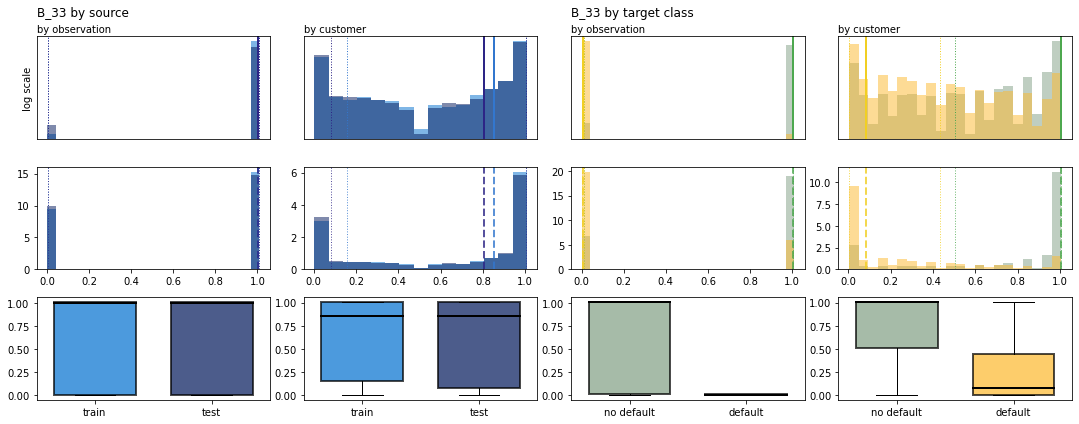


-

B_33
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           1.00177           1.00157           1.00319           0.00644
              mean           0.61220           0.59818           0.73960           0.22806
               std           0.48838           0.49125           0.44156           0.41631
----------------------------------------------------------------------------------------------------
by_cust     median           0.85012           0.80501           1.00331           0.08334
              mean           0.61571           0.60416           0.74075           0.25787
               std           0.41669           0.42167           0.37064           0.32342
----------------------------------------------------------------------------------------------------
__________________________________________________

In [361]:
plot_next()

Values for feature B_33 appear to be binary with added noise. Perform the same tests applied to feature B_8.

In [362]:
print(f'feature B_33: binary + noise?\n{HR}')
for df in dataset:
    print(f'{df.attrs["name"]}\n'
         + f'{round(100 * round(train_data.B_33, 1).value_counts(normalize=True))}\n-')


feature B_33: binary + noise?
----------------------------------------------------------------------
train_data
1.0    61.0
0.0    39.0
Name: B_33, dtype: float64
-
test_data
1.0    61.0
0.0    39.0
Name: B_33, dtype: float64
-


Feature B_33 is another good candidate for training a noise reduction model. Values in the default subset are mouch closer to 0 than those in the no default subset. This feature offers strong separation of the target classes.

In [363]:
B_33.dist_type = 'binary + noise'
B_33.processing_steps['as binary'] = methodcaller('round')

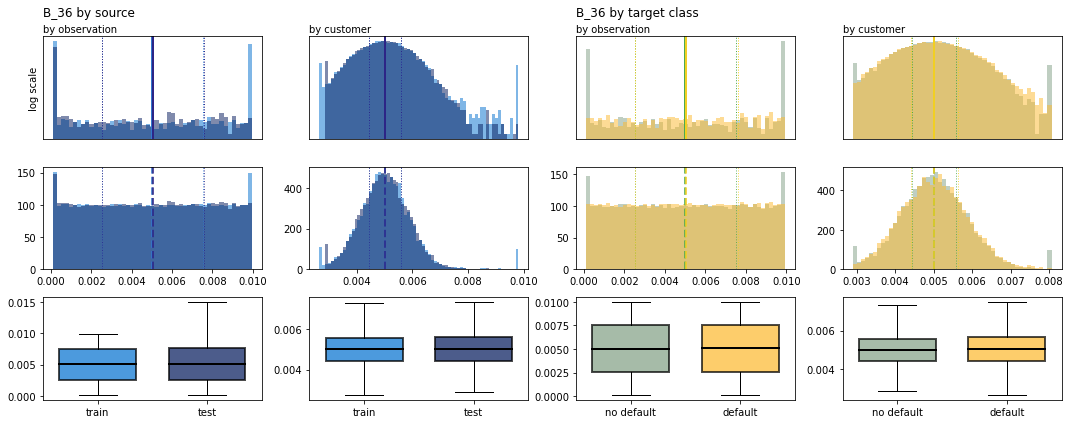


-

B_36
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00503           0.00505           0.00502           0.00506
              mean           0.00636           0.00725           0.00581           0.00801
               std           0.02124           0.02707           0.01676           0.03099
----------------------------------------------------------------------------------------------------
by_cust     median           0.00501           0.00502           0.00501           0.00502
              mean           0.00627           0.00713           0.00577           0.00769
               std           0.01698           0.02288           0.01324           0.02468
----------------------------------------------------------------------------------------------------
__________________________________________________

In [364]:
plot_next()

B_36 is the second feature in the balance category to resemble a uniform distribution at equal weight by observation while resembling gaussian noise at average value by customer. The cause of this phenomenon remains unclear. <br><br>

PLot the train and test subsets of B_36 without clipping values above and below the 99th and 1st percentiles, respectively

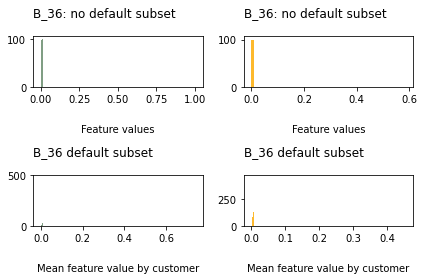

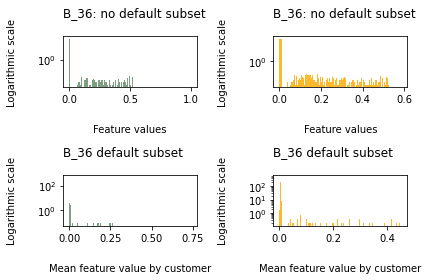

In [365]:
for log in [False, True]:
    fig, axs = styled_subplots(nrows=2, ncols=2, n_items=4, figsize=(10, 6))
    for ax, ind, _by_cust, color, xlabel, title in zip(
            axs.flat, 2*[no_default_customers, default_customers], [0, 0, 1, 1],
            2*target_colors, 2*['Feature values'] + 2*['Mean feature value by customer'],
            2*['B_36: no default subset'] + 2*['B_36 default subset']
    ):
        d = train_data.loc[ind, 'B_36'].dropna().copy()
        d = d.groupby(level=0).mean() if _by_cust else d
        ax.hist(d, bins='auto', density=True, color=color, log=log)
        ax.set_xlabel(xlabel, labelpad=20); ax.set_title(title, loc='left', x=0, pad=20)
        if log:
            ax.set_ylabel('Logarithmic scale', labelpad=20)
        del d, ind
    fig.tight_layout(); plt.show();

The subplots shown above reveal a small number values uniformly distributed in the range between the feature's 99th percentile and 0.7. These values will be clipped before applying any analysis or transformation methods thare are not robust to outliers. <br><br>
Update the Feature instance assigned to B_36.

In [456]:
B_36.dist_type = 'uniform'
B_36.flags.append('outliers')

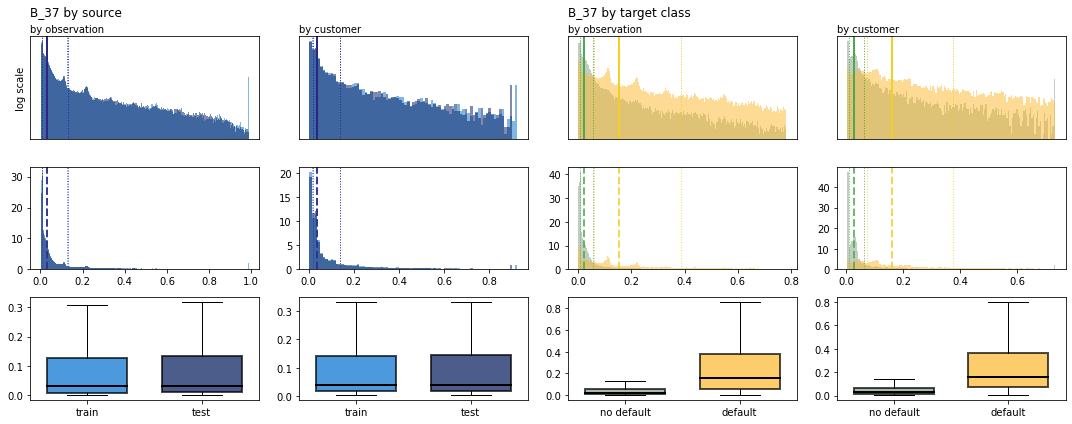


-

B_37
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.03114           0.03294           0.02038           0.15494
              mean           0.12319           0.12702           0.07597           0.26554
               std           0.21178           0.21321           0.15449           0.28481
----------------------------------------------------------------------------------------------------
by_cust     median           0.03869           0.03898           0.02907           0.16035
              mean           0.12589           0.12726           0.07870           0.26095
               std           0.19801           0.19620           0.14320           0.26099
----------------------------------------------------------------------------------------------------
__________________________________________________

In [367]:
plot_next()

Feature B_37 is roughly exponentially distributed. The distribution of the default subset is multimodal.

In [ ]:
B_37.dist_type = 'exponential'
B_37.subset_dist_types['default'] = 'multimodal'
B_37.subset_dist_types['no default'] = 'exponential'

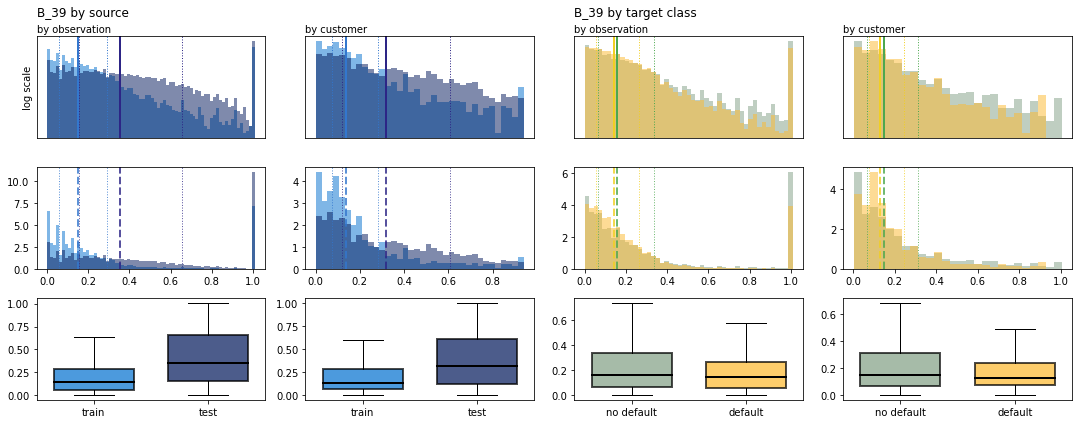


-

B_39
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.14923           0.35566           0.15901           0.14191
              mean           0.25547           0.43623           0.28610           0.23025
               std           0.29789           0.33240           0.32314           0.27281
----------------------------------------------------------------------------------------------------
by_cust     median           0.13600           0.31758           0.14997           0.12879
              mean           0.21335           0.39298           0.23229           0.19658
               std           0.21526           0.31473           0.23391           0.19580
----------------------------------------------------------------------------------------------------
__________________________________________________

In [368]:
plot_next()

Feature B_39 exhibits markedly different distributions in the train and test subsets. The vast majority of values for this feature are missing. It will be dropped for this reason.

In [369]:
to_drop['B_39'] = 'significant difference in train and test distributions'
B_39.flags.append('train/test difference, missing values')

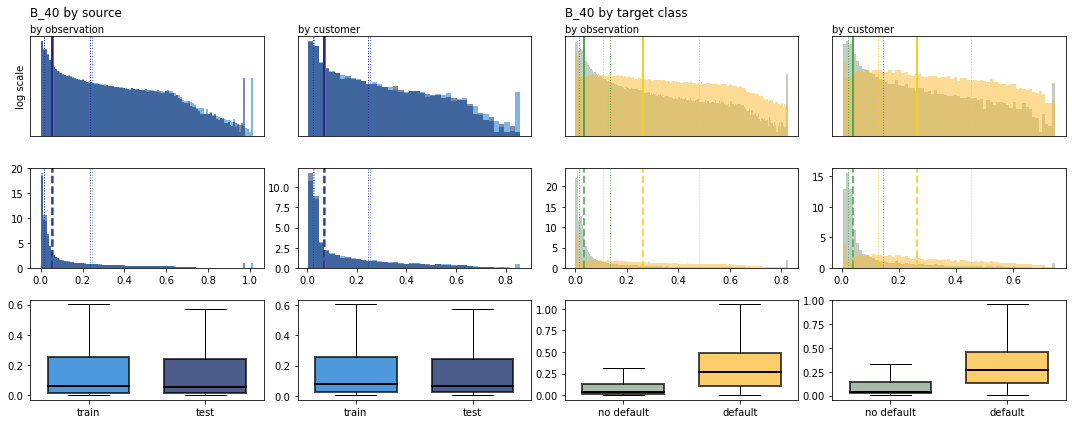


-

B_40
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.05831           0.05424           0.03466           0.26263
              mean           0.20326           0.18378           0.13388           0.41241
               std           8.08134           2.99700           4.69076          13.99257
----------------------------------------------------------------------------------------------------
by_cust     median           0.07354           0.06666           0.04084           0.26294
              mean           0.20188           0.18210           0.13508           0.39304
               std           5.57842           1.61973           2.24130          10.28371
----------------------------------------------------------------------------------------------------
__________________________________________________

In [370]:
plot_next()

As with several other features in the balance category, the distribution of values varies by target class for B_40. The no default subset and default subset have distinct distribution shapes.

In [371]:
B_40.dist_type = 'exponential'
B_40.subset_dist_types['no default'] = 'exponential'
B_40.subset_dist_types['default'] = 'chi square'

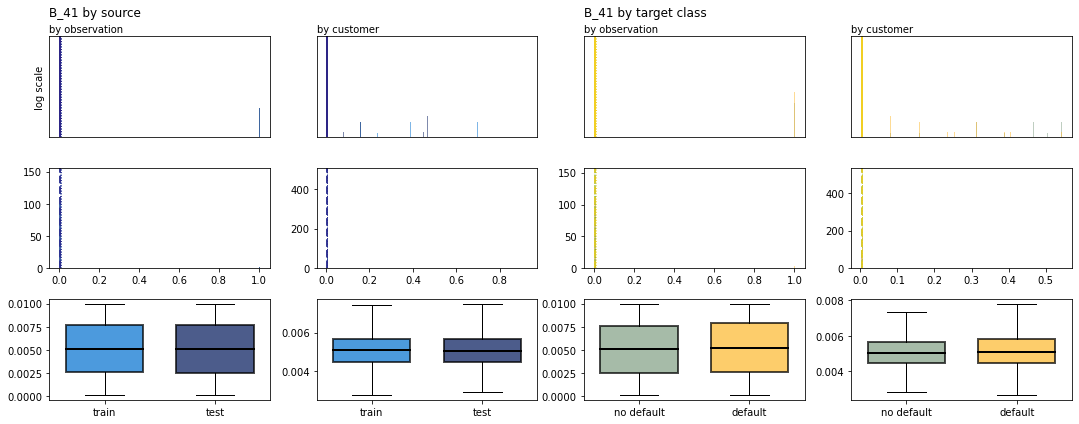


-

B_41
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00511           0.00512           0.00507           0.00523
              mean           0.03235           0.03623           0.02035           0.06851
               std           0.22231           0.24454           0.15053           0.35825
----------------------------------------------------------------------------------------------------
by_cust     median           0.00504           0.00505           0.00502           0.00510
              mean           0.03189           0.03588           0.02022           0.06529
               std           0.18461           0.20341           0.12551           0.29161
----------------------------------------------------------------------------------------------------
__________________________________________________

In [372]:
plot_next()

Values for feature B_41 are restricted to a very narrow range. At equal weight by observation, The histograms for this feature are nearly blank. If transformation methods cannot render this as more useful information, B_41 will be dropped. attempt to plot histograms of this feature within 2 standard deciations of its mean.

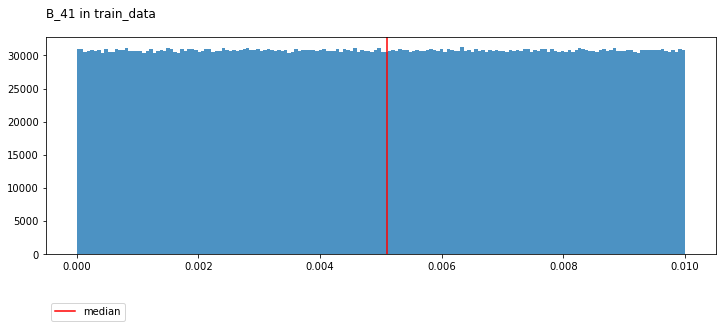

In [373]:
b_41_mn = train_data.B_41.mean()
b_41_std = train_data.B_41.std()
b_41_md = train_data.B_41.median()
xlim = b_41_mn + (2*b_41_std)
fig, ax = plt.subplots(figsize=(12, 4))
ax.hist(train_data.B_41[train_data.B_41 < 0.5].dropna(), bins='auto', alpha=0.8)
ax.axvline(b_41_md, color='r', label='median')
ax.set_title('B_41 in train_data', x=0, loc='left', pad=20)
ax.legend(bbox_to_anchor=(0, -0.2), loc= 'upper left');

Excepting outliers, B_41 follows a uniform distribution.

In [374]:
B_41.dist_type = 'uniform'

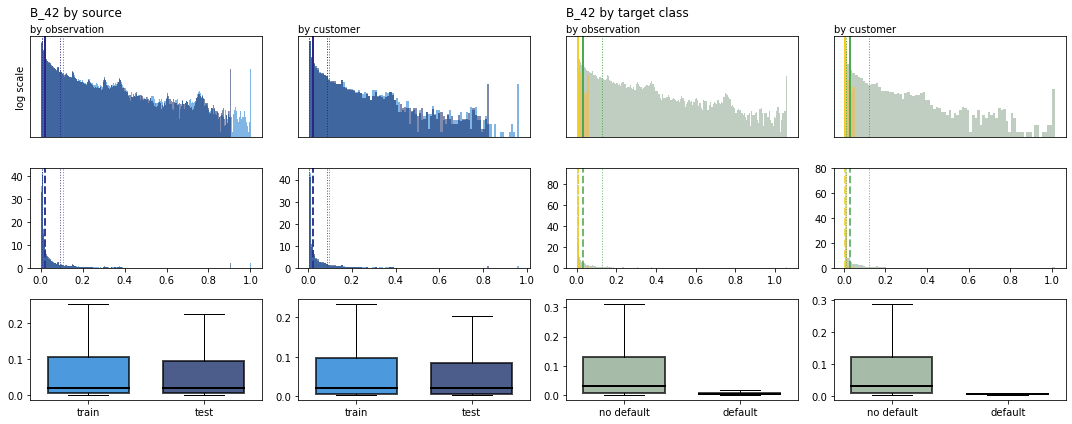


-

B_42
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.02160           0.02184           0.03118           0.00595
              mean           0.11004           0.09853           0.12339           0.00793
               std           0.31370           0.25025           0.33119           0.01941
----------------------------------------------------------------------------------------------------
by_cust     median           0.02094           0.02104           0.02997           0.00559
              mean           0.10454           0.08986           0.11787           0.00780
               std           0.31175           0.22589           0.33026           0.01609
----------------------------------------------------------------------------------------------------
__________________________________________________

In [375]:
plot_next()

Feature B_42 offers strong separation of target classes. The standard deviation of values in the defualt subset is an order of magnitude less than that of the no default subset. The mean and median are also significantly less than those of the no default subset.<br><br>
The distribution of values by target class in B_42 resembles that of those in B_5, B_6, B_10, and B_12. In this case the default subset is significantly more confined than in previously examples.

In [376]:
B_42.dist_type = 'exponential'

#### Delinquency Features

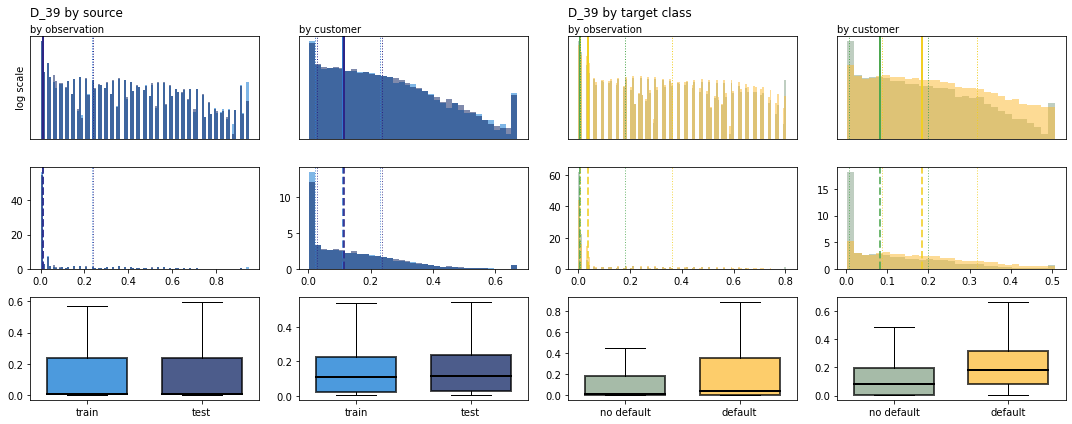


-

D_39
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00906           0.00939           0.00828           0.03634
              mean           0.15312           0.15628           0.12512           0.23752
               std           0.27007           0.26576           0.21270           0.38333
----------------------------------------------------------------------------------------------------
by_cust     median           0.10980           0.11458           0.08356           0.18420
              mean           0.15170           0.15382           0.12282           0.23438
               std           0.16487           0.15622           0.12977           0.21808
----------------------------------------------------------------------------------------------------
__________________________________________________

In [377]:
plot_next()

The first of the numeric delinquency features, D_39 has values that are quantized at discrete steps. The relative proportion of values at each step is extremely consistent between the train and test subsets. This feature exhibits a multimodal Poisson distribution. This and other multimodal features may be more useful after segmenting customers using a clustering algorithm.

In [457]:
D_39.dist_type = 'multimodal Poisson'

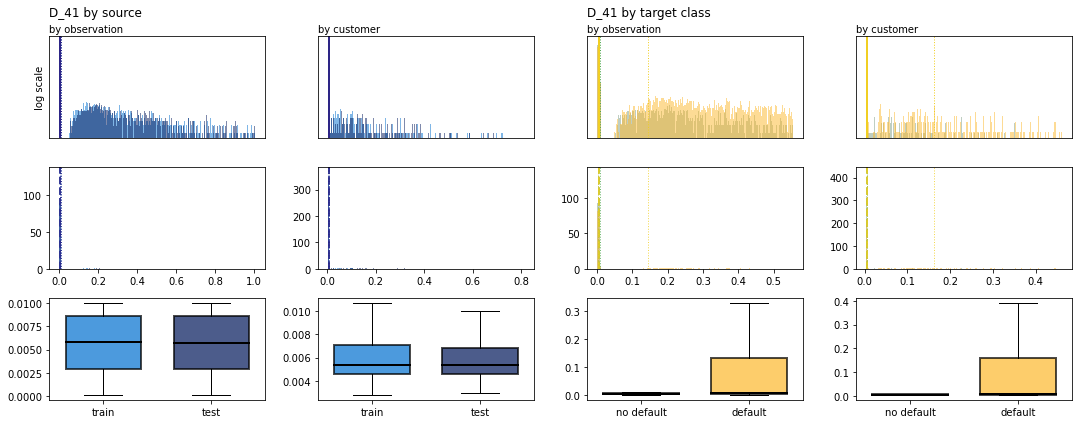


-

D_41
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00575           0.00573           0.00546           0.00685
              mean           0.05978           0.05915           0.03100           0.14658
               std           0.20254           0.20070           0.11704           0.33672
----------------------------------------------------------------------------------------------------
by_cust     median           0.00534           0.00533           0.00519           0.00672
              mean           0.05860           0.05772           0.03019           0.13991
               std           0.16745           0.16385           0.09987           0.26612
----------------------------------------------------------------------------------------------------
__________________________________________________

In [378]:
plot_next()

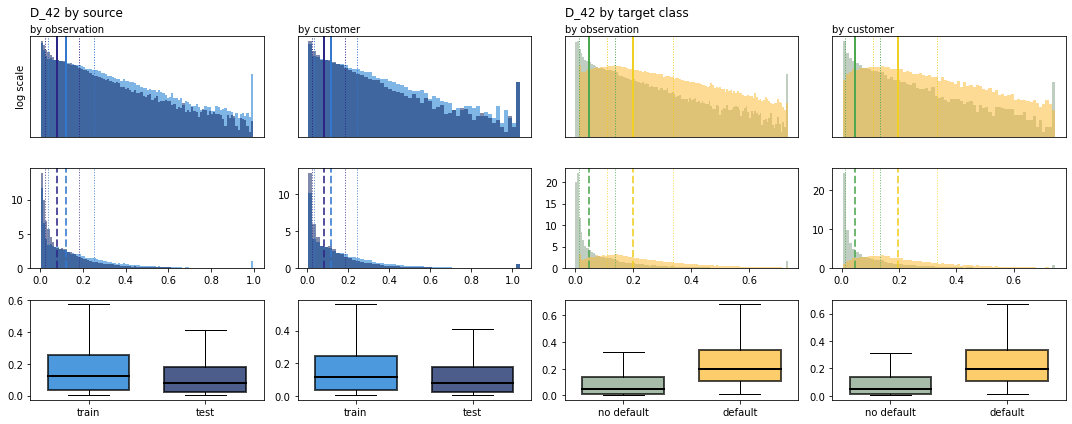


-

D_42
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.12052           0.07822           0.04788           0.19959
              mean           0.18497           0.14809           0.10818           0.26232
               std           0.22818           0.25112           0.18570           0.24054
----------------------------------------------------------------------------------------------------
by_cust     median           0.11486           0.07972           0.04643           0.19500
              mean           0.18057           0.14795           0.10693           0.25973
               std           0.23332           0.24396           0.19269           0.24688
----------------------------------------------------------------------------------------------------
__________________________________________________

In [379]:
plot_next()

Feature D_42 has a high percentage of missing values. More than three quarters of all customers in the train and test subsets have no no-null values for this feature. As a feature in the delinquency category, it may be that missing values represent dates when statement dates on which the customer was not delinquent. In this case, it may be sensible to impute missing values with 0 or negative 1.<br><br>
The default subset appears to follow a chi-square distribution. The no default subset appears to follow an exponential distribution.<br><br>
Print the class balance of customers who have no any non-null values in D_42.

In [380]:
print(f'Target feature class balance by subset: customers with D_42 values\n{HR}')
print(round(100 *( train_labels.target.loc[
    train_customers[train_data.D_42.notna().groupby(level=0).any()]
].value_counts(normalize=True).rename('   has non-null values').to_frame().join(
    train_labels.target.loc[~(train_data.D_42.notna().groupby(level=0).any())]
    .value_counts(normalize=True).rename('   no non-null values')
).rename(index=target_map))).astype(str) + ' %')
pct_nd_nn = 100 * train_data.loc[no_default_customers, 'D_42'].notna().groupby(level=0).any().mean()
pct_d_nn = 100 * train_data.loc[default_customers, 'D_42'].notna().groupby(level=0).any().mean()
print(f'\n-\nPercentage of target class members with any non-null values:\n{HR}')
for cust_subset, pct in zip(['no default', 'default'], [pct_nd_nn, pct_d_nn]):
    print(f'{cust_subset:<12}{pct:>10.2f} %')

print(f'\n-\nMean non-null value ratio: correlation with target feature{HR}')
print(f'{train_data.D_42.notna().groupby(level=0).mean().corr(train_labels.target):.4f}')

Target feature class balance by subset: customers with D_42 values
----------------------------------------------------------------------
              has non-null values    no non-null values
no default                 52.0 %                81.0 %
default                    48.0 %                19.0 %

-
Percentage of target class members with any non-null values:
----------------------------------------------------------------------
no default       17.29 %
default          46.04 %

-
Mean non-null value ratio: correlation with target feature----------------------------------------------------------------------
0.2597


Around half of the customers in the default subset have one or more non-null values in D_42. Less than a quarter of customers in the no default subset have non-null values. On its own, the percentage of missing values per customer is not directly correlated with the target feature. This feature will be transformed or dropped. <br><br>
Add the information gathered in the last three cells to the D_42 Feature instance.

In [381]:
D_42.flags.append('null percentage')
D_42.dist_type = 'exponential'
D_42.subset_dist_types['default'] = 'chi-square'

In [382]:
train_data.D_42.notna().groupby(level=0).any().mean()

0.2473758642705698

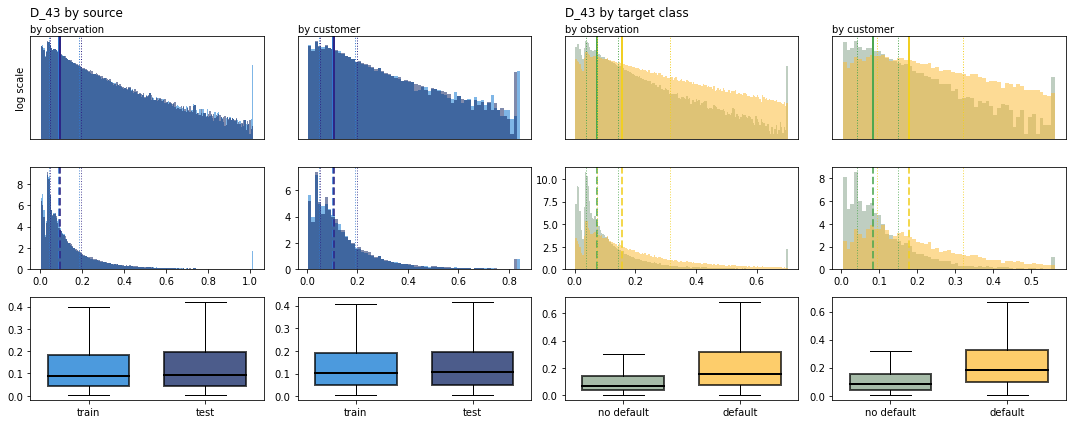


-

D_43
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.08851           0.09430           0.07233           0.15735
              mean           0.15468           0.16190           0.11654           0.25079
               std           0.21340           0.21189           0.14580           0.30628
----------------------------------------------------------------------------------------------------
by_cust     median           0.10215           0.10503           0.08356           0.17918
              mean           0.15394           0.15661           0.11540           0.24973
               std           0.18076           0.17695           0.12005           0.25533
----------------------------------------------------------------------------------------------------
__________________________________________________

In [383]:
plot_next()

The distribution of values in feature D_43 resembles a series of exponential distributions superimposed with varying X offsets.<br><br>
Given the high ratio of missing values, D_43 will be dropped.

In [384]:
to_drop['D_43'] = 'null percentage'
D_43.dist_type = 'exponential'

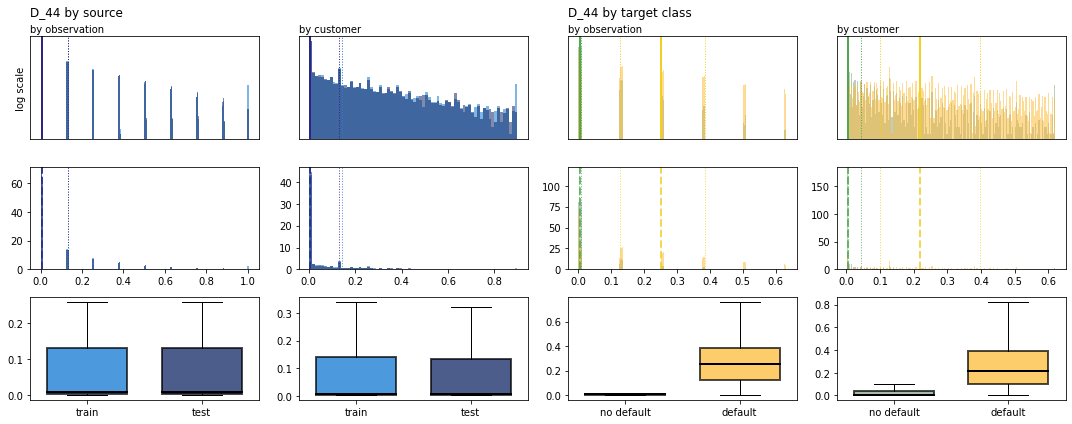


-

D_44
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00767           0.00758           0.00632           0.25229
              mean           0.11844           0.11788           0.05841           0.29898
               std           0.22130           0.22509           0.14197           0.30367
----------------------------------------------------------------------------------------------------
by_cust     median           0.00712           0.00652           0.00562           0.21754
              mean           0.11844           0.11614           0.05877           0.28755
               std           0.20625           0.20900           0.13352           0.27184
----------------------------------------------------------------------------------------------------
__________________________________________________

In [385]:
plot_next()

Feature D_44 has discrete values at a fixed interval. The standard deviation of values in the no default subset is less than half that of those in the default subset.

In [386]:
D_44.dist_type = 'discrete'

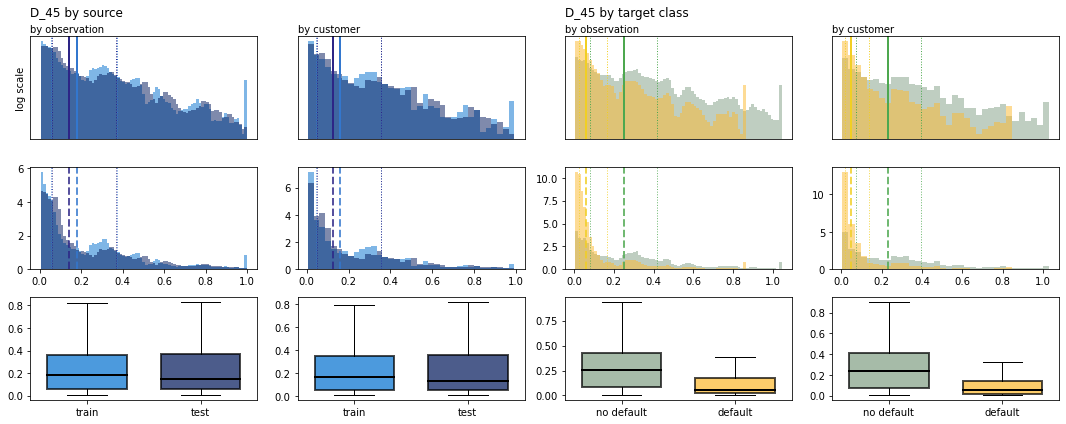


-

D_45
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.18081           0.14267           0.25125           0.05822
              mean           0.25219           0.24525           0.29000           0.13818
               std           0.24268           0.24502           0.24744           0.18590
----------------------------------------------------------------------------------------------------
by_cust     median           0.16065           0.12759           0.23226           0.05035
              mean           0.23778           0.23399           0.27670           0.12639
               std           0.23947           0.24392           0.24548           0.17961
----------------------------------------------------------------------------------------------------
__________________________________________________

In [387]:
plot_next()

Feature D_45 has a multimodal distribution with an overall exponential shape. Customers in the default subset have a constricted iqr compared to the no default subset.

In [388]:
D_45.dist_type = 'multimodal exponential'

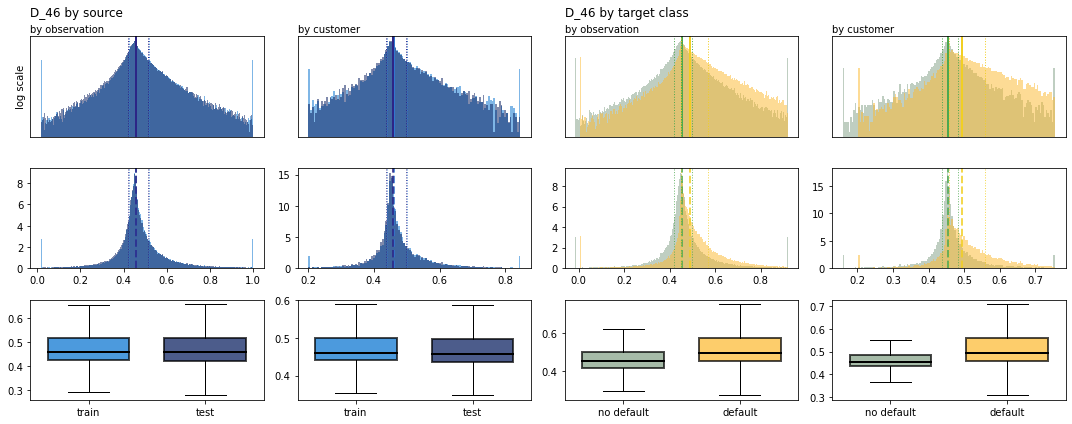


-

D_46
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.45967           0.45719           0.45183           0.49074
              mean           0.47548           0.47157           0.45953           0.51980
               std           0.16989           0.17554           0.15708           0.19452
----------------------------------------------------------------------------------------------------
by_cust     median           0.46091           0.45790           0.45499           0.49380
              mean           0.47652           0.47191           0.45981           0.52038
               std           0.11225           0.11450           0.09411           0.14061
----------------------------------------------------------------------------------------------------
__________________________________________________

In [389]:
plot_next()

D_46 values follow a double exponential distribution. The default and no default subsets resemble horizontally mirrored versions of each other.

In [458]:
D_46.dist_type = 'double exponential'

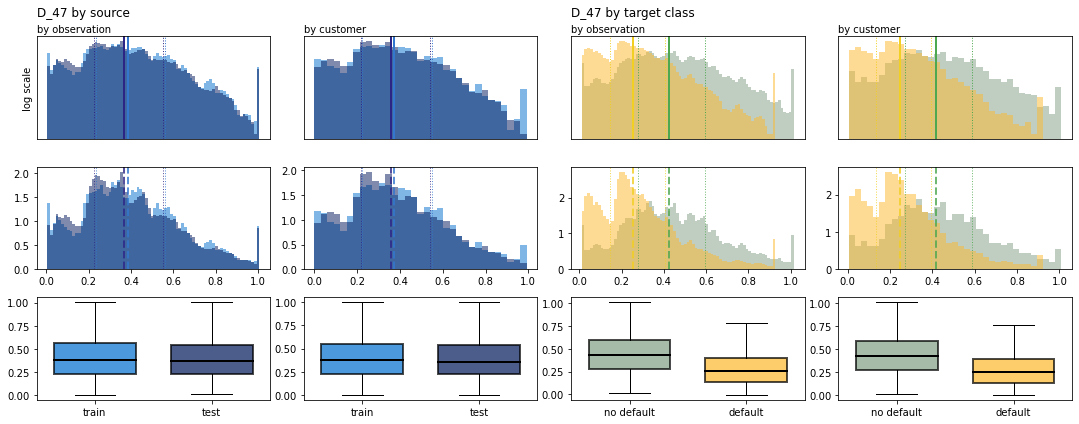


-

D_47
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.38317           0.36624           0.42591           0.25601
              mean           0.40711           0.39626           0.44498           0.29294
               std           0.23480           0.23267           0.23133           0.20650
----------------------------------------------------------------------------------------------------
by_cust     median           0.37220           0.35923           0.41847           0.24847
              mean           0.39687           0.38863           0.43643           0.28365
               std           0.23374           0.23210           0.23109           0.20212
----------------------------------------------------------------------------------------------------
__________________________________________________

In [390]:
plot_next()

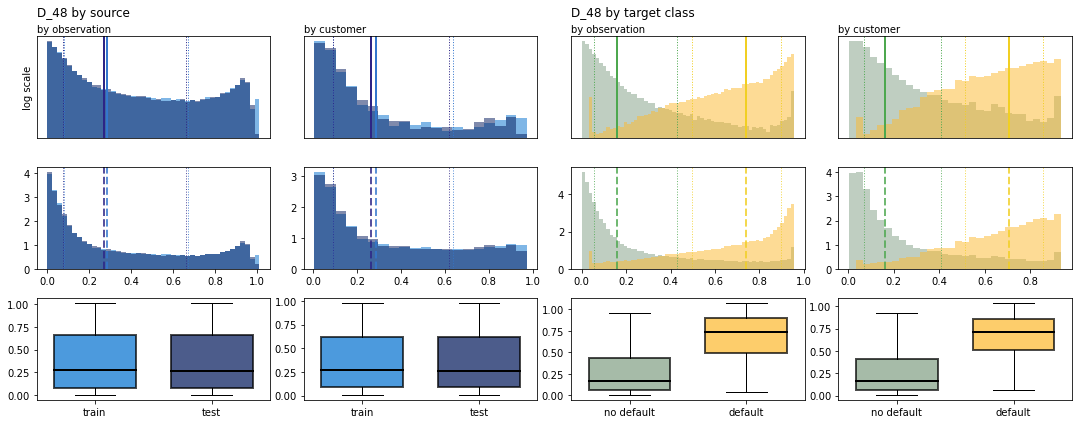


-

D_48
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.28617           0.27290           0.15956           0.73950
              mean           0.38162           0.37642           0.27308           0.67799
               std           0.32648           0.32741           0.27529           0.26589
----------------------------------------------------------------------------------------------------
by_cust     median           0.28383           0.26289           0.16178           0.70775
              mean           0.37220           0.36257           0.26487           0.66699
               std           0.30694           0.30667           0.25483           0.23681
----------------------------------------------------------------------------------------------------
__________________________________________________

In [391]:
plot_next()

Combined, the vlaues for feature D_48 follow a beta distribution. By target class, the default and no default subsets are both exponentially distributed. Theyir probability densities vary inversely across D_48's range. Given this useful distinction, it may be useful to train an imputation model for this feature's missing values.

In [459]:
D_48.dist_type = 'beta'
D_48.subset_dist_types['default'] = 'exponential'
D_48.subset_dist_types['no default'] = 'exponential'

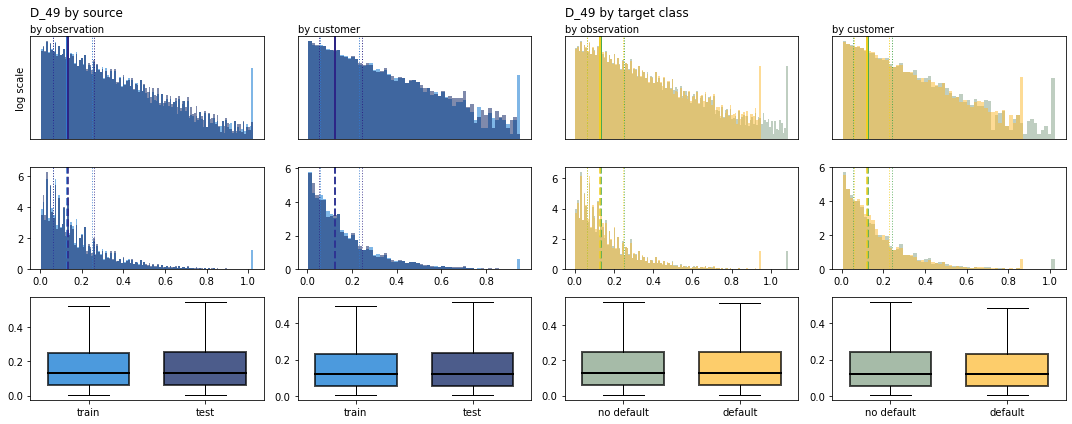


-

D_49
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.13037           0.13326           0.13098           0.12988
              mean           0.19193           0.19927           0.19772           0.18719
               std           0.27839           0.29501           0.35014           0.20140
----------------------------------------------------------------------------------------------------
by_cust     median           0.12221           0.12585           0.12337           0.12128
              mean           0.18101           0.18550           0.19006           0.17358
               std           0.31688           0.30503           0.42484           0.18552
----------------------------------------------------------------------------------------------------
__________________________________________________

In [392]:
plot_next()

In [460]:
D_49.dist_type = 'exponential'

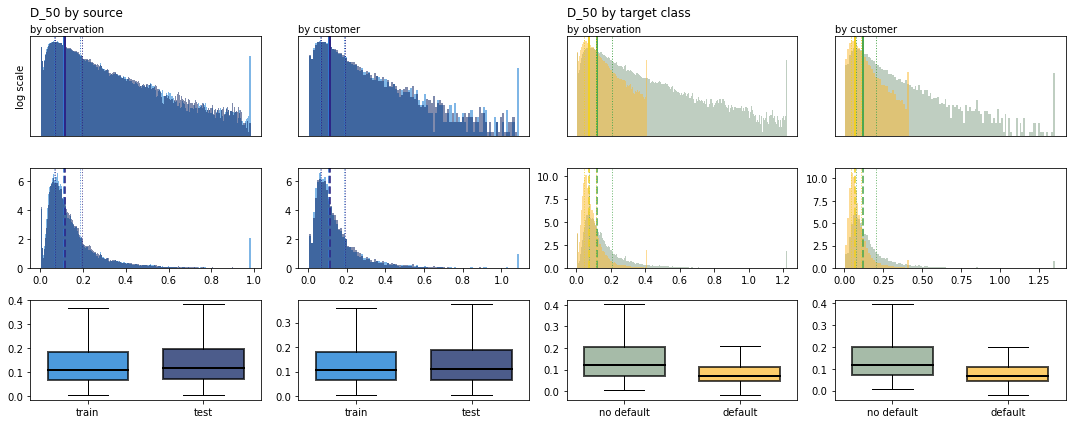


-

D_50
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.10941           0.11439           0.12108           0.07171
              mean           0.17443           0.18585           0.19255           0.09270
               std           0.63375           0.75776           0.68104           0.33608
----------------------------------------------------------------------------------------------------
by_cust     median           0.10674           0.11167           0.11941           0.06959
              mean           0.17495           0.18770           0.19498           0.09076
               std           0.53484           0.75378           0.58375           0.21734
----------------------------------------------------------------------------------------------------
__________________________________________________

In [393]:
plot_next()

All histograms of feature D_50 resemble those of a theoretical power lognormal distribution. Default customers have a much narrower iqr than customers in the no default subset.

In [394]:
D_50.dist_type = 'power lognormal'

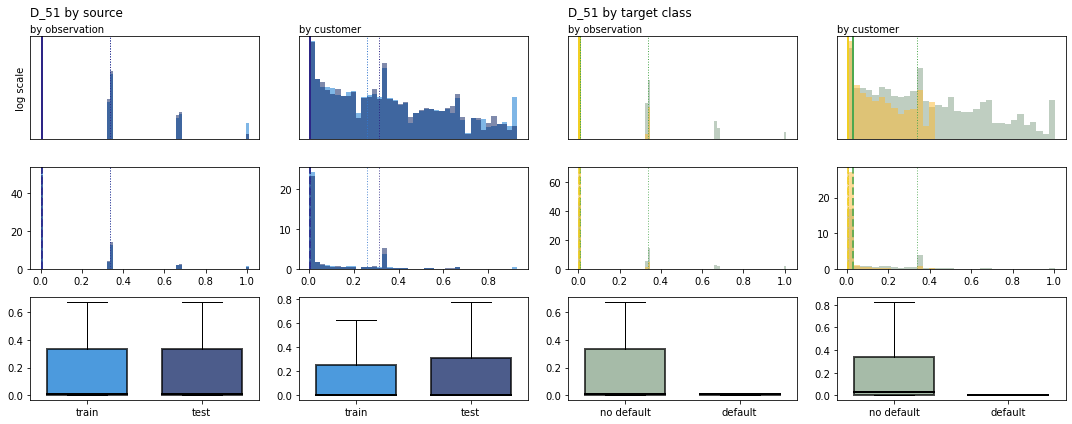


-

D_51
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00728           0.00760           0.00815           0.00552
              mean           0.14508           0.15940           0.17985           0.04025
               std           0.24233           0.25184           0.26221           0.11771
----------------------------------------------------------------------------------------------------
by_cust     median           0.00617           0.00634           0.03137           0.00531
              mean           0.13929           0.15475           0.17440           0.03881
               std           0.21736           0.22995           0.23629           0.09513
----------------------------------------------------------------------------------------------------
__________________________________________________

In [395]:
plot_next()

In [396]:
D_51.dist_type = 'Poisson'

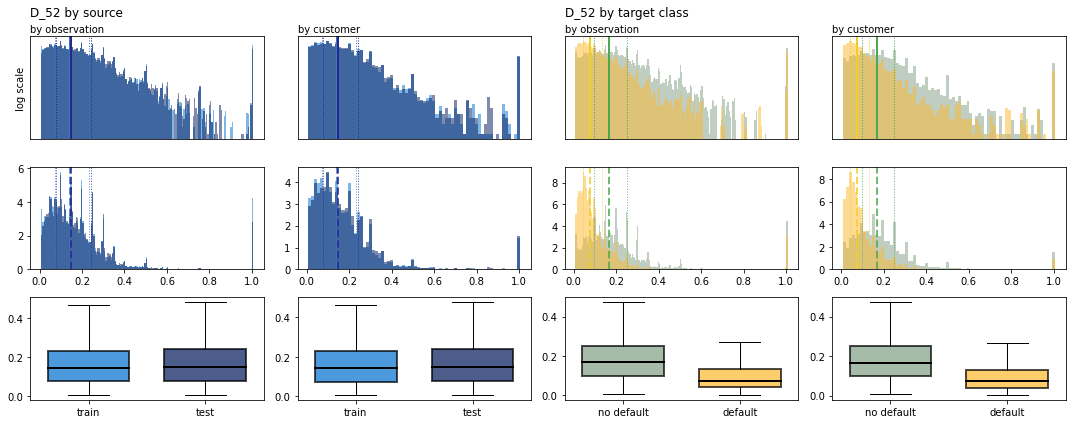


-

D_52
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.14443           0.14799           0.16754           0.07424
              mean           0.18005           0.18652           0.20263           0.11177
               std           0.17386           0.17771           0.17652           0.14564
----------------------------------------------------------------------------------------------------
by_cust     median           0.14164           0.14795           0.16681           0.07287
              mean           0.17673           0.18467           0.20019           0.10967
               std           0.16808           0.17210           0.17136           0.13784
----------------------------------------------------------------------------------------------------
__________________________________________________

In [397]:
plot_next()

Histograms of D_52 resemble Poisson and Weibull distributions. The default subset appears to be exponentially distributed.

In [461]:
D_52.dist_type = 'multimodal, Weibull, Poisson'
D_52.subset_dist_types['default'] = 'multimodal, exponential, Poisson'
D_52.subset_dist_types['no default'] = 'multimodal, Weibull, Poisson'

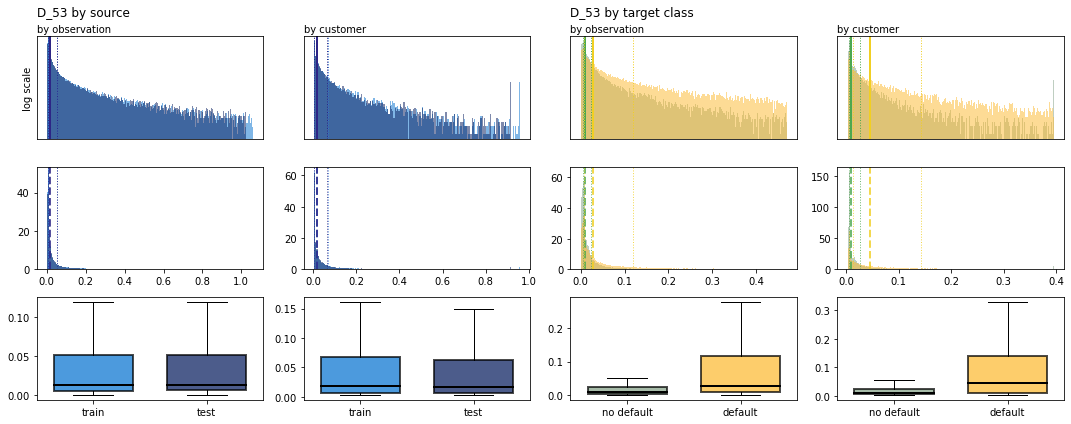


-

D_53
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.01338           0.01416           0.00934           0.02774
              mean           0.07618           0.07998           0.03561           0.12908
               std           0.20269           0.20535           0.10169           0.27608
----------------------------------------------------------------------------------------------------
by_cust     median           0.01734           0.01747           0.00859           0.04480
              mean           0.07850           0.07894           0.03390           0.12935
               std           0.17861           0.17836           0.09073           0.23247
----------------------------------------------------------------------------------------------------
__________________________________________________

In [398]:
plot_next()

In [399]:
D_53.dist_type = 'exponential'

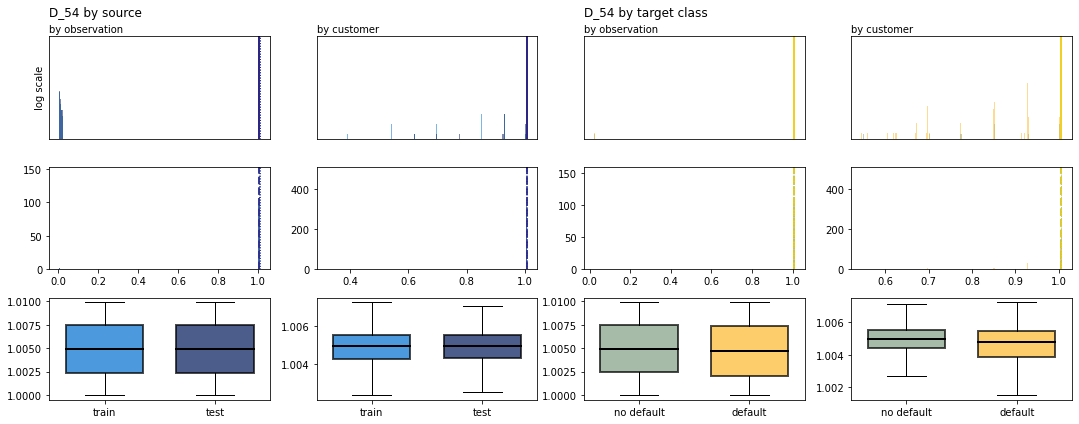


-

D_54
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           1.00489           1.00490           1.00495           1.00472
              mean           0.98464           0.98543           0.99584           0.95087
               std           0.14111           0.13839           0.09509           0.22619
----------------------------------------------------------------------------------------------------
by_cust     median           1.00494           1.00494           1.00498           1.00479
              mean           0.98497           0.98585           0.99607           0.95320
               std           0.10748           0.10608           0.07532           0.16436
----------------------------------------------------------------------------------------------------
__________________________________________________

In [400]:
plot_next()

Feature D_54 may be another binary feature with added noise. <br><br>
Test this by plotting a histogram of the difference in values between D_54 and D_54 rounded to the nearest integer.


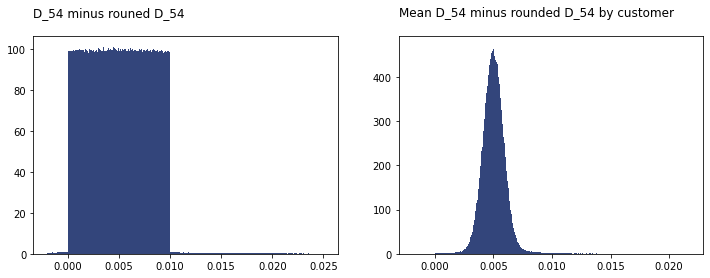

In [401]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].hist(
    (train_data.D_54 - train_data.D_54.round()), bins='auto', density=True,
    color=PALETTE[0], alpha=0.8
)
axs[1].hist(
    (train_data.D_54 - train_data.D_54.round()).groupby(level=0).mean(),
    bins='auto', density=True, color=PALETTE[0], alpha=0.8
);
for ax, title in zip(
        axs.flat, 
        ['D_54 minus rouned D_54', 'Mean(D_54 minus rounded D_54) by customer']
):
    ax.set_title(title, loc='left', x=0, pad=20)

The difference between D_54 and a rounded copy of itself is uniformly distributed. Aggregated by customer, these values appear to be distributed in a manner that resembles power normal, Cauchy, and T distributions.

Create histograms of D_54 values near 0 and D_54 values near 1.

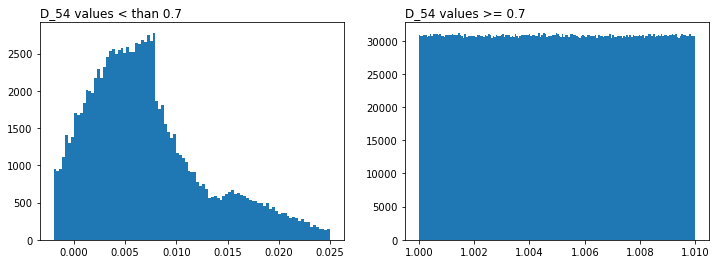

2.04% of values in train_data < 0.7
97.96% of values in train_data >= 0.7


In [402]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
d54_lt = (train_data.D_54 < 0.7).sum() / train_data.D_54.notna().sum()
d54_gt = (train_data.D_54 >= 0.7).sum() / train_data.D_54.notna().sum()
axs[0].hist(train_data.D_54[train_data.D_54 < 0.7].dropna(), bins='auto')
axs[1].hist(train_data.D_54[train_data.D_54 >= 0.7].dropna(), bins='auto')
axs[0].set_title('D_54 values < than 0.7', loc='left', x=0)
axs[1].set_title('D_54 values >= 0.7', loc='left', x=0)
plt.show()

print(f'{100 * d54_lt:.2f}% of values in train_data < 0.7')
print(f'{100 * d54_gt:.2f}% of values in train_data >= 0.7')





At right above, a histogram shows values at or above 0.7 are uniformly distributed.

In [403]:
D_54.dist_type = 'binary'
D_54.processing_steps['as binary'] = methodcaller('round')

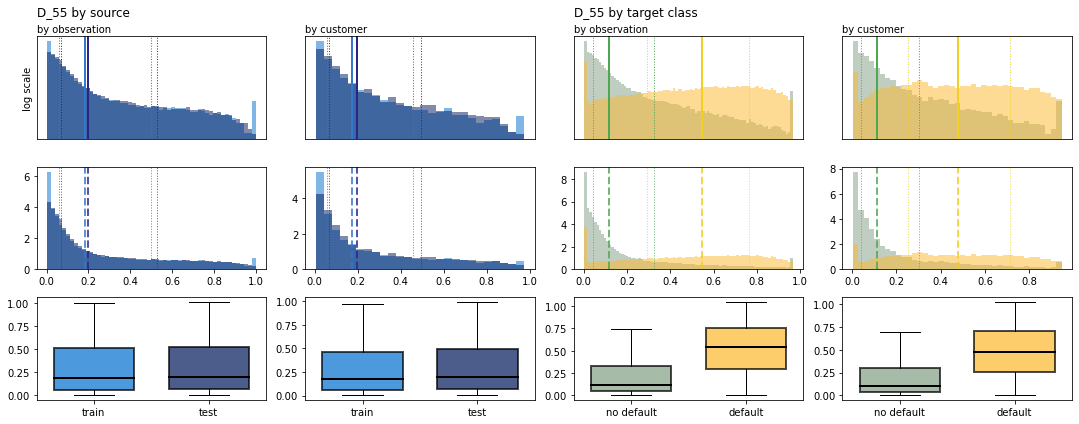


-

D_55
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.18167           0.20002           0.11670           0.54484
              mean           0.29809           0.31432           0.22163           0.52549
               std           0.28874           0.29286           0.24497           0.28940
----------------------------------------------------------------------------------------------------
by_cust     median           0.17203           0.19460           0.11061           0.47764
              mean           0.28028           0.30236           0.20908           0.48407
               std           0.27498           0.28129           0.23444           0.28049
----------------------------------------------------------------------------------------------------
__________________________________________________

In [404]:
plot_next()

In [462]:
D_55.dist_type = 'exponential'

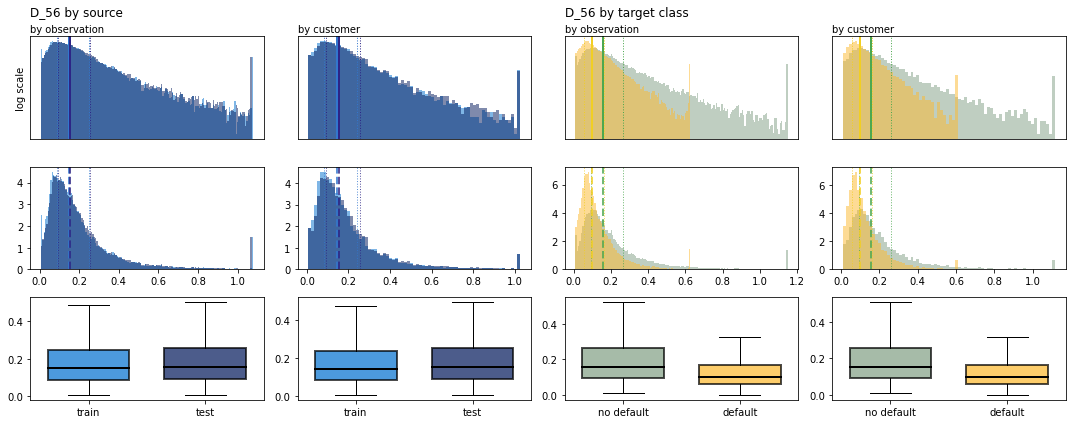


-

D_56
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.14943           0.15574           0.16038           0.09992
              mean           0.20371           0.21056           0.21708           0.13137
               std           0.21216           0.21477           0.21992           0.14377
----------------------------------------------------------------------------------------------------
by_cust     median           0.14382           0.15411           0.15566           0.09691
              mean           0.19710           0.20782           0.21152           0.12750
               std           0.21091           0.20783           0.22064           0.13550
----------------------------------------------------------------------------------------------------
__________________________________________________

In [405]:
plot_next()

In [463]:
D_56.dist_type = 'lognormal'

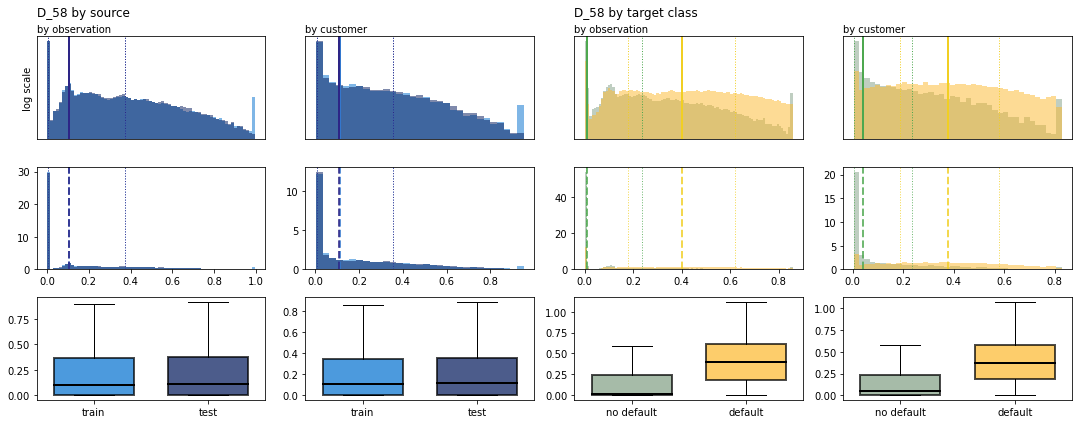


-

D_58
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.10659           0.10487           0.00940           0.40301
              mean           0.21553           0.21429           0.14823           0.41840
               std           0.26044           0.26066           0.21140           0.28770
----------------------------------------------------------------------------------------------------
by_cust     median           0.11409           0.10843           0.04227           0.37708
              mean           0.21323           0.21142           0.14760           0.40104
               std           0.24489           0.24583           0.19888           0.26611
----------------------------------------------------------------------------------------------------
__________________________________________________

In [406]:
plot_next()

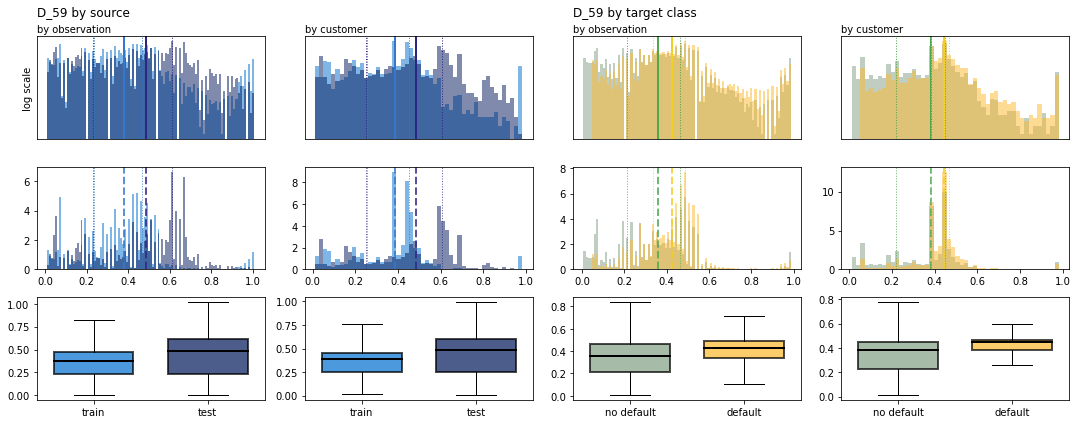


-

D_59
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.37841           0.48382           0.35729           0.42534
              mean           0.36242           0.44128           0.34094           0.42838
               std           0.19313           0.28687           0.18968           0.18864
----------------------------------------------------------------------------------------------------
by_cust     median           0.38746           0.48410           0.38349           0.44605
              mean           0.37178           0.44933           0.34914           0.43664
               std           0.18215           0.27712           0.18043           0.17116
----------------------------------------------------------------------------------------------------
__________________________________________________

In [407]:
plot_next()

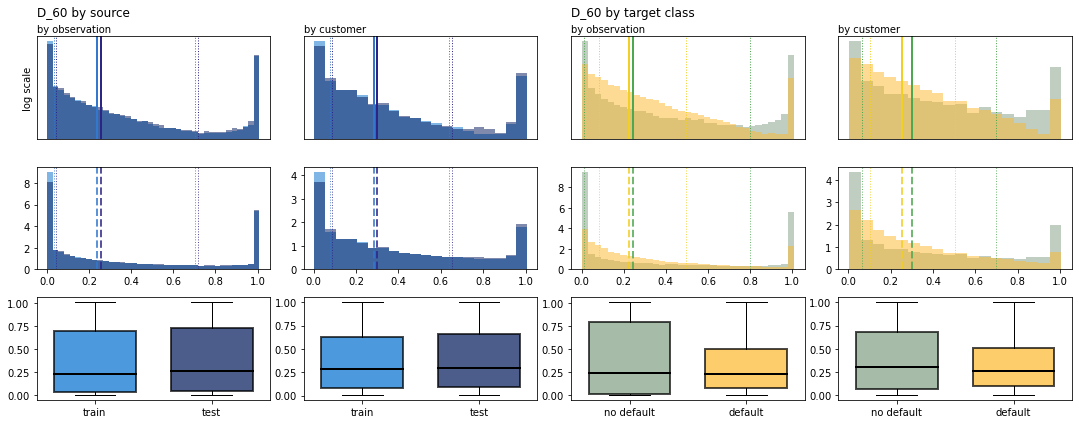


-

D_60
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.23534           0.25601           0.24148           0.22583
              mean           0.37615           0.38639           0.39254           0.32677
               std           0.37183           0.37004           0.39092           0.30188
----------------------------------------------------------------------------------------------------
by_cust     median           0.28379           0.29946           0.30088           0.25501
              mean           0.37806           0.38826           0.39360           0.33358
               std           0.33296           0.33337           0.34905           0.27708
----------------------------------------------------------------------------------------------------
__________________________________________________

In [408]:
plot_next()

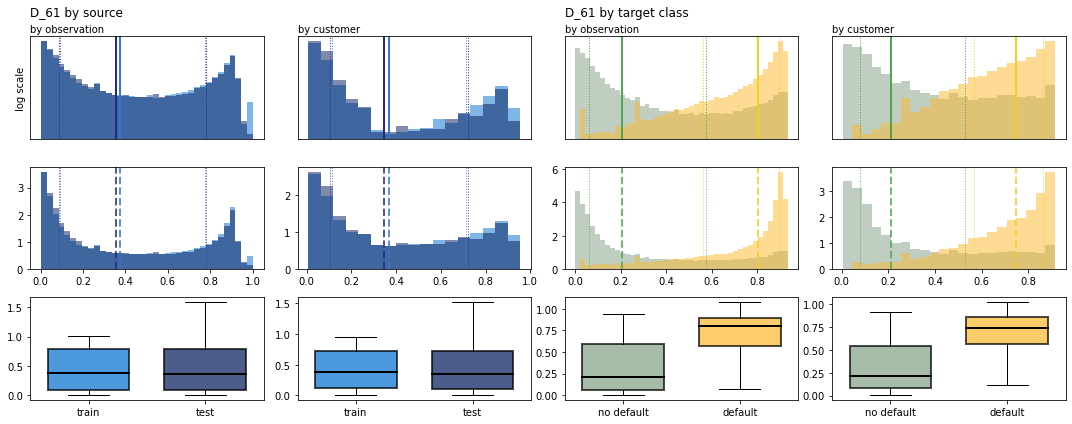


-

D_61
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.37227           0.35711           0.20526           0.80385
              mean           0.42963           0.45069           0.32713           0.70815
               std           0.52453           0.62685           0.55346           0.29025
----------------------------------------------------------------------------------------------------
by_cust     median           0.36747           0.34494           0.21121           0.74804
              mean           0.41668           0.43351           0.31593           0.69275
               std           0.33800           0.51879           0.31096           0.24148
----------------------------------------------------------------------------------------------------
__________________________________________________

In [409]:
plot_next()

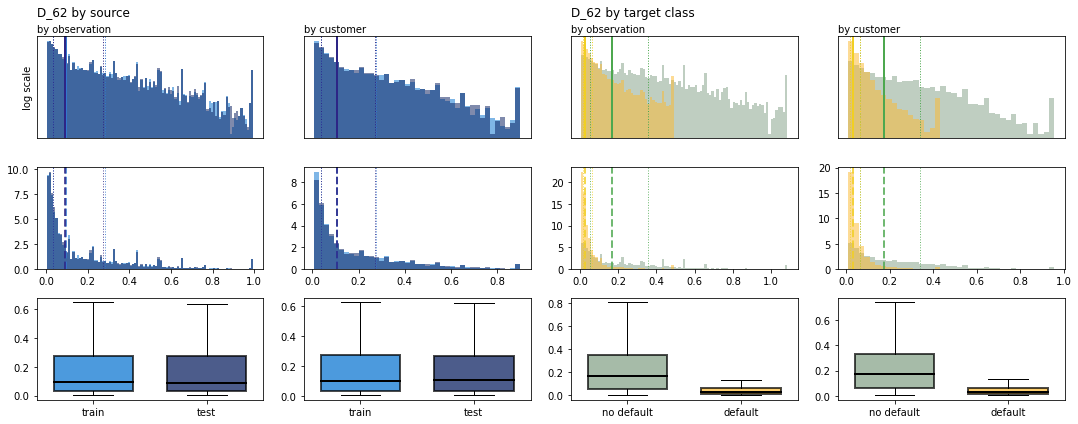


-

D_62
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.09444           0.08948           0.16736           0.02853
              mean           0.19066           0.18704           0.24008           0.05756
               std           0.23026           0.22801           0.24577           0.09400
----------------------------------------------------------------------------------------------------
by_cust     median           0.10498           0.10434           0.17505           0.03240
              mean           0.18567           0.18584           0.23325           0.05657
               std           0.20966           0.20996           0.22229           0.07969
----------------------------------------------------------------------------------------------------
__________________________________________________

In [410]:
plot_next()

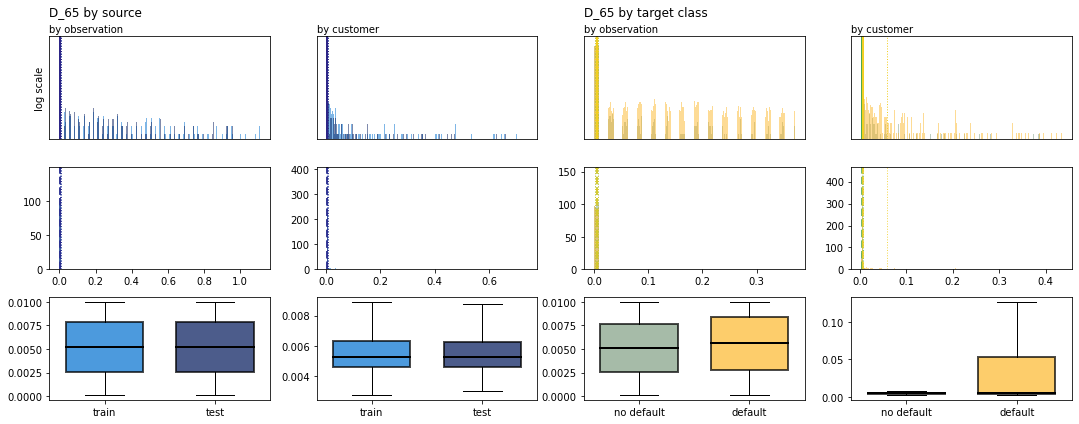


-

D_65
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00522           0.00522           0.00510           0.00562
              mean           0.03976           0.03686           0.02079           0.09695
               std           0.47310           0.53914           0.31561           0.77065
----------------------------------------------------------------------------------------------------
by_cust     median           0.00527           0.00526           0.00514           0.00613
              mean           0.04338           0.03840           0.02100           0.10744
               std           0.48018           0.43715           0.27777           0.81495
----------------------------------------------------------------------------------------------------
__________________________________________________

In [411]:
plot_next()

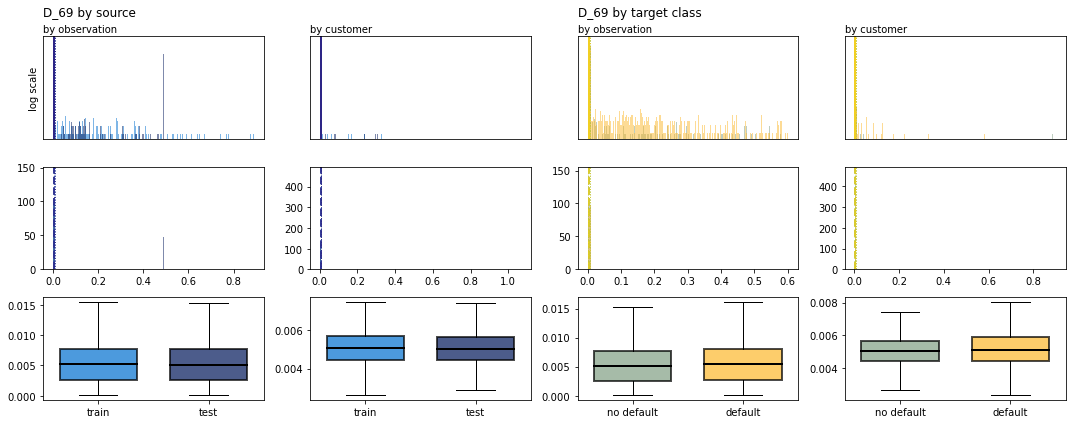


-

D_69
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00517           0.00511           0.00510           0.00537
              mean           0.15404           0.14719           0.11325           0.28149
               std          16.00965          32.22903          17.58249           9.55120
----------------------------------------------------------------------------------------------------
by_cust     median           0.00505           0.00504           0.00503           0.00512
              mean           0.15561           0.14555           0.11497           0.27247
               std          11.49841          28.79038          12.51621           7.86756
----------------------------------------------------------------------------------------------------
__________________________________________________

In [412]:
plot_next()

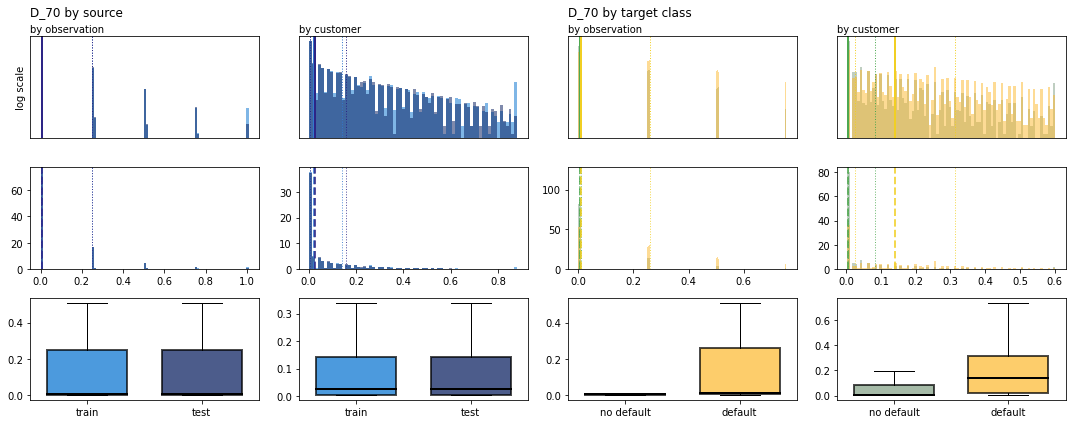


-

D_70
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00679           0.00685           0.00617           0.00976
              mean           0.11057           0.11402           0.07084           0.23229
               std           0.22774           0.23240           0.16266           0.33174
----------------------------------------------------------------------------------------------------
by_cust     median           0.02396           0.02439           0.00606           0.13998
              mean           0.11046           0.11296           0.07129           0.22279
               std           0.19102           0.19323           0.13258           0.27147
----------------------------------------------------------------------------------------------------
__________________________________________________

In [413]:
plot_next()

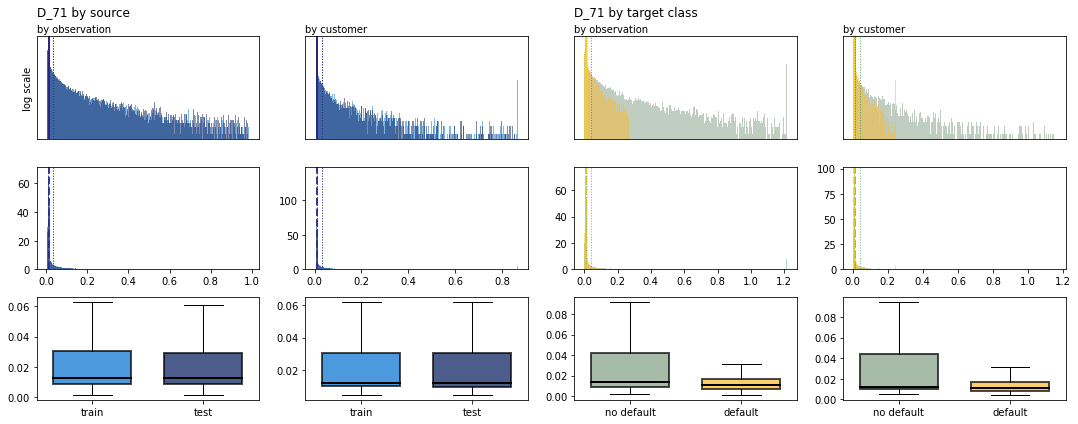


-

D_71
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.01280           0.01260           0.01345           0.01094
              mean           0.07083           0.07350           0.08592           0.02534
               std           0.32601           0.33218           0.36991           0.10697
----------------------------------------------------------------------------------------------------
by_cust     median           0.01182           0.01173           0.01200           0.01107
              mean           0.06751           0.07101           0.08262           0.02427
               std           0.27027           0.27987           0.30912           0.07802
----------------------------------------------------------------------------------------------------
__________________________________________________

In [414]:
plot_next()

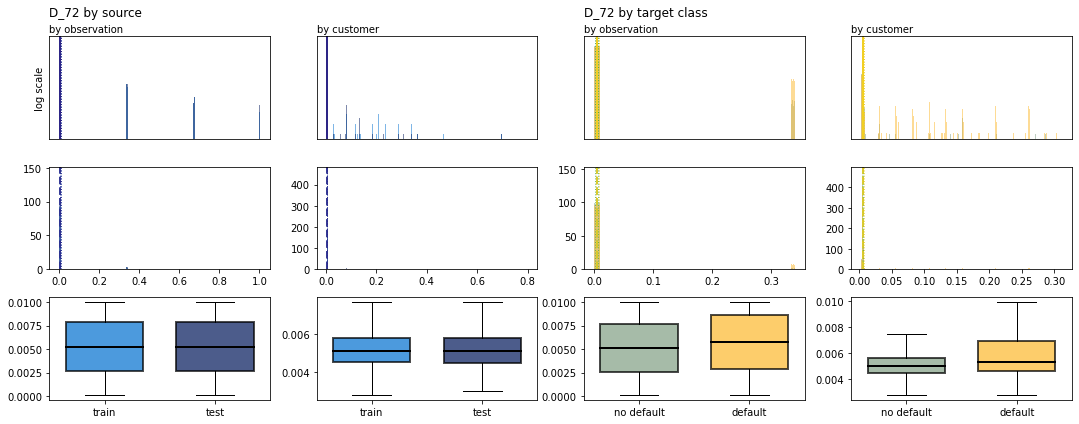


-

D_72
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00525           0.00525           0.00510           0.00577
              mean           0.03757           0.04121           0.01628           0.10189
               std           0.20292           0.22351           0.10983           0.35162
----------------------------------------------------------------------------------------------------
by_cust     median           0.00511           0.00510           0.00504           0.00536
              mean           0.03749           0.04053           0.01643           0.09766
               std           0.17557           0.19269           0.09813           0.29414
----------------------------------------------------------------------------------------------------
__________________________________________________

In [415]:
plot_next()

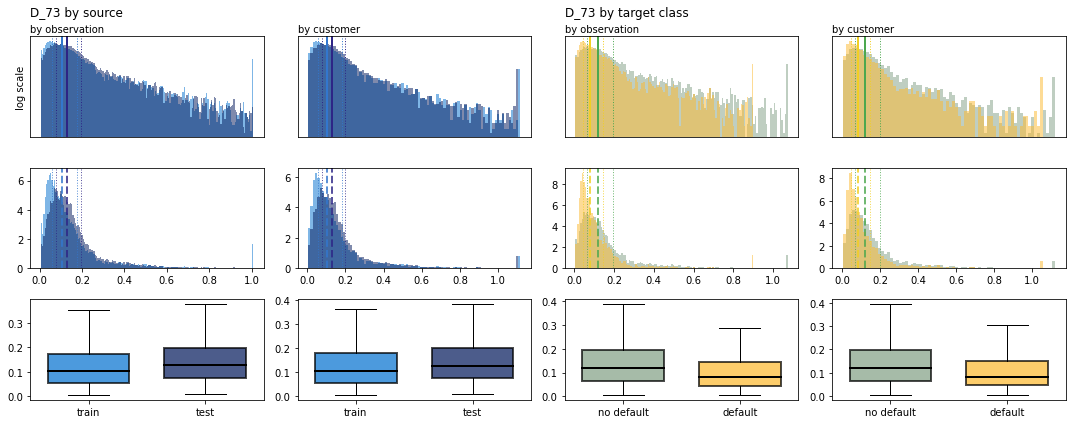


-

D_73
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.10309           0.12684           0.11879           0.08044
              mean           0.15649           0.17685           0.17295           0.12910
               std           0.20495           0.22264           0.20122           0.20816
----------------------------------------------------------------------------------------------------
by_cust     median           0.10390           0.12693           0.11935           0.08176
              mean           0.16368           0.18256           0.17823           0.14081
               std           0.22402           0.24332           0.21464           0.23626
----------------------------------------------------------------------------------------------------
__________________________________________________

In [416]:
plot_next()

Most values for feature D_73 are missing. The available values differ in distribution shape bewteen the train and test subsets. This feature will be dropped.

In [ ]:
D_73.dist_type = 'lognormal'
D_73.flags.append('null')
to_drop['D_73'] = 'missing values'

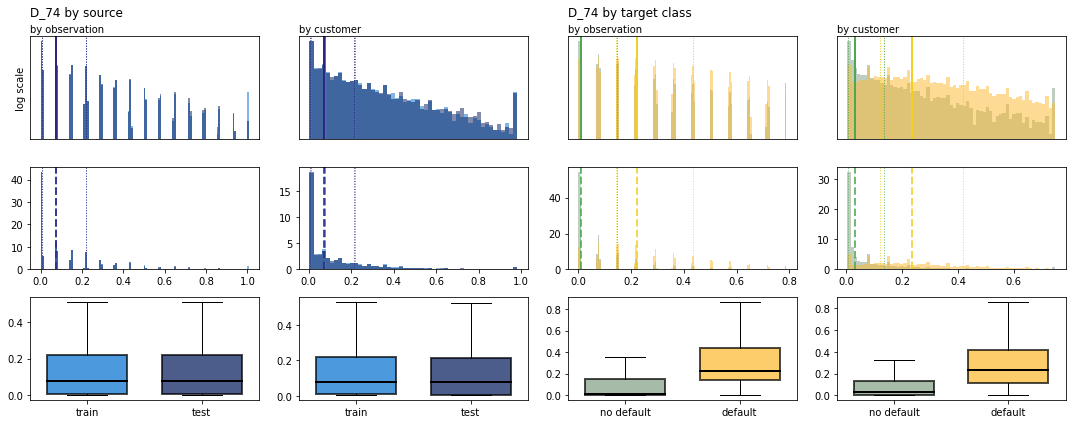


-

D_74
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.07571           0.07538           0.00944           0.22316
              mean           0.15349           0.15319           0.10025           0.31373
               std           0.21919           0.22292           0.16388           0.27857
----------------------------------------------------------------------------------------------------
by_cust     median           0.07561           0.07186           0.03261           0.23504
              mean           0.15318           0.15162           0.10071           0.30313
               std           0.21109           0.21436           0.15860           0.26393
----------------------------------------------------------------------------------------------------
__________________________________________________

In [417]:
plot_next()

D_74 follows a Poisson distribution with a low lambda. Values for customers in the no default subset are less widely distributed than those of the default subset.

In [418]:
D_74.dist_type = 'Poisson'

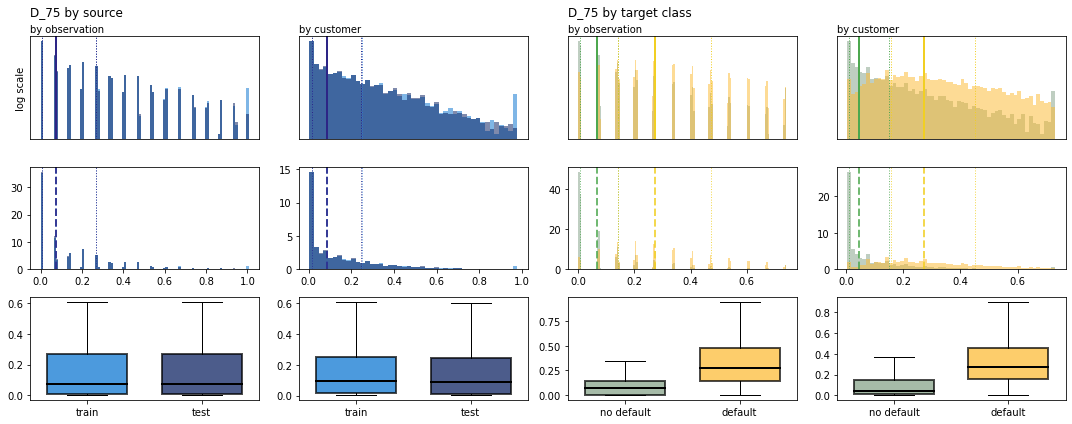


-

D_75
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.07437           0.07431           0.06786           0.27446
              mean           0.17120           0.17260           0.11211           0.34932
               std           0.22421           0.22902           0.16925           0.27058
----------------------------------------------------------------------------------------------------
by_cust     median           0.08783           0.08647           0.04565           0.27264
              mean           0.17019           0.17040           0.11218           0.33623
               std           0.21520           0.21991           0.16317           0.25582
----------------------------------------------------------------------------------------------------
__________________________________________________

In [419]:
plot_next()

In [ ]:
D_75.dist_type = 'Poisson'

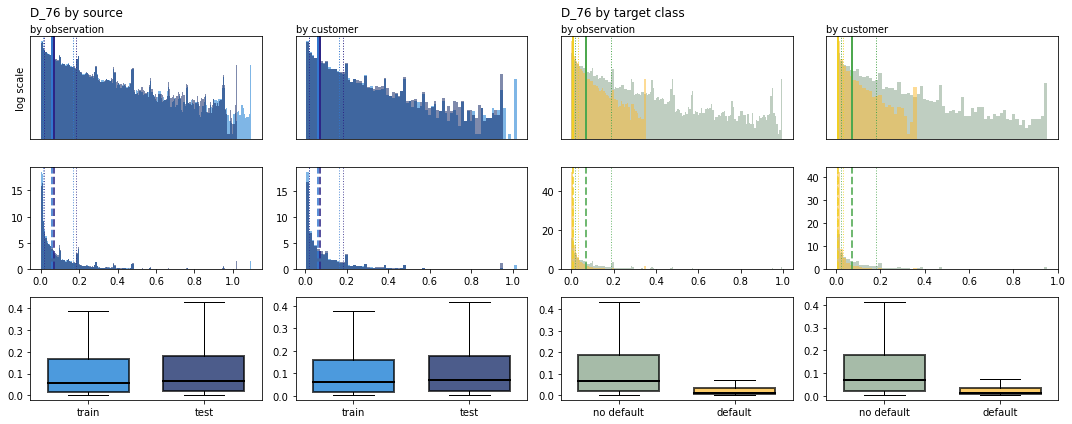


-

D_76
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.05874           0.06769           0.06935           0.01074
              mean           0.14050           0.15354           0.15250           0.03540
               std           0.29013           0.34047           0.30272           0.08027
----------------------------------------------------------------------------------------------------
by_cust     median           0.06008           0.06848           0.07068           0.01125
              mean           0.13827           0.15100           0.15026           0.03591
               std           0.27822           0.32459           0.29051           0.07788
----------------------------------------------------------------------------------------------------
__________________________________________________

In [420]:
plot_next()

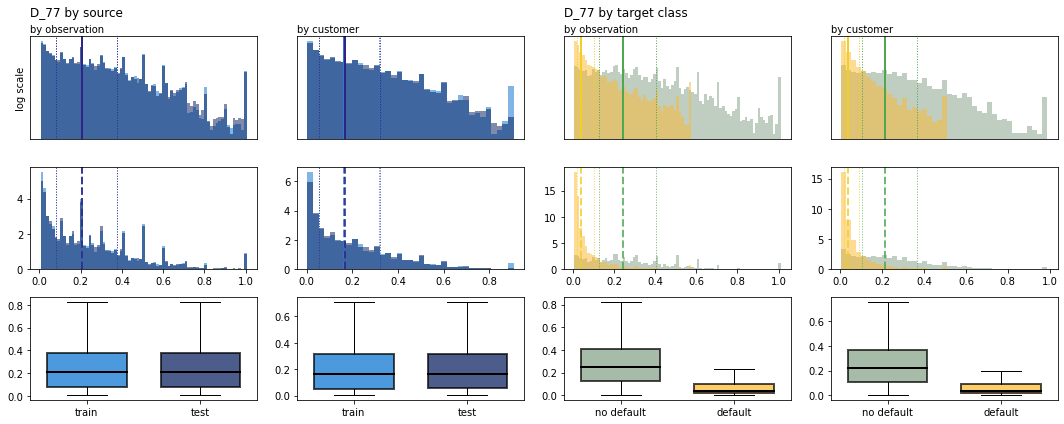


-

D_77
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.20583           0.20599           0.24573           0.04041
              mean           0.25656           0.25812           0.29234           0.08639
               std           0.23264           0.23202           0.23416           0.12538
----------------------------------------------------------------------------------------------------
by_cust     median           0.16374           0.16711           0.21539           0.03817
              mean           0.21532           0.22018           0.25961           0.07464
               std           0.20950           0.21133           0.21482           0.10338
----------------------------------------------------------------------------------------------------
__________________________________________________

In [421]:
plot_next()

D_77's distribution is somewhat reminiscent of several balance features, as the default subset is confined to a much narrower range than the no default subset. The overall shape is exponential, and the distribution type is multimodal.

In [422]:
D_77.dist_type = 'multimodal exponential'

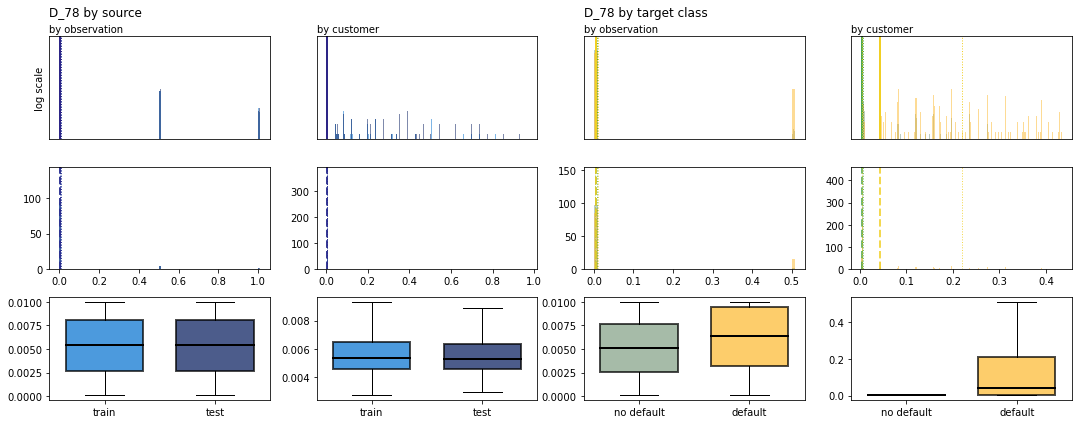


-

D_78
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00540           0.00541           0.00514           0.00635
              mean           0.06261           0.06593           0.02228           0.18390
               std           0.25934           0.27273           0.12267           0.45240
----------------------------------------------------------------------------------------------------
by_cust     median           0.00529           0.00528           0.00511           0.04330
              mean           0.06323           0.06527           0.02250           0.17870
               std           0.19930           0.20831           0.09388           0.33059
----------------------------------------------------------------------------------------------------
__________________________________________________

In [423]:
plot_next()

Values for D_78 are distributed discretely. 

In [ ]:
D_78.dist_type = 'Poisson'

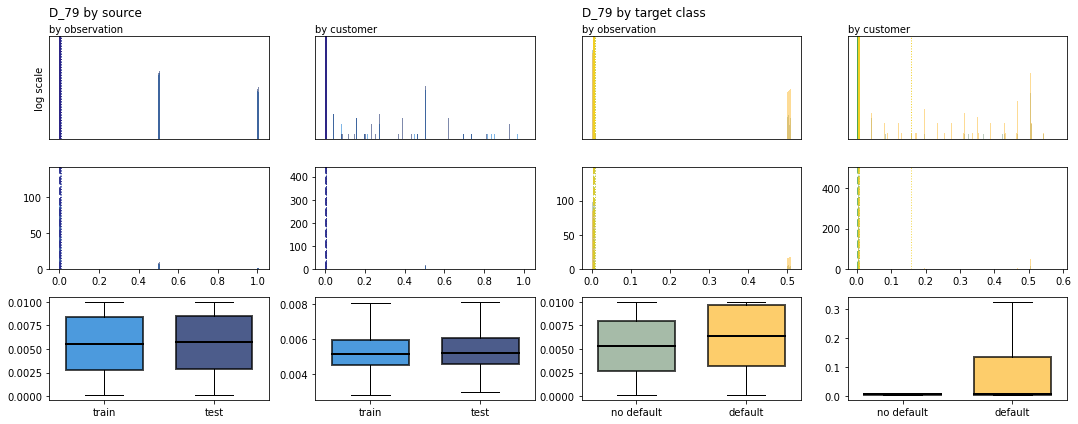


-

D_79
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00556           0.00569           0.00532           0.00643
              mean           0.06913           0.08554           0.04099           0.15476
               std           0.22013           0.25891           0.15779           0.33229
----------------------------------------------------------------------------------------------------
by_cust     median           0.00517           0.00520           0.00509           0.00546
              mean           0.07125           0.08608           0.04201           0.15483
               std           0.21147           0.24287           0.15151           0.31224
----------------------------------------------------------------------------------------------------
__________________________________________________

In [424]:
plot_next()

Most values in feature D_79 are clustered around 0 and 0.5. A very small percentage of values exists at 1.<br><br>
Print value counts of feature D_79 rounded to one decimal place.

In [464]:
train_data.D_79.round(1).value_counts()

0.0     4909979
0.5      431463
1.0       87237
1.5       19263
2.0        4962
2.5        1458
3.0         552
3.5         211
4.0         136
4.5         106
5.0          33
5.5          24
7.0          15
6.0          14
6.5          11
9.5          10
8.5          10
9.0           9
7.5           9
8.0           4
10.5          2
11.5          2
18.0          1
17.0          1
Name: D_79, dtype: int64

In [ ]:
D_79.dist_type = 'Poisson, exponential'

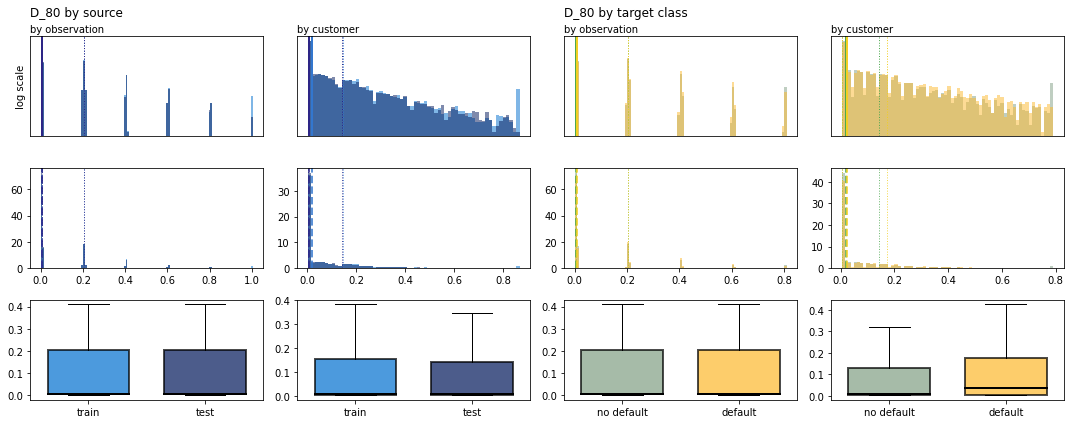


-

D_80
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00725           0.00712           0.00714           0.00760
              mean           0.11201           0.10875           0.10463           0.13420
               std           0.21475           0.21485           0.19988           0.25300
----------------------------------------------------------------------------------------------------
by_cust     median           0.01981           0.00686           0.01885           0.02372
              mean           0.11016           0.10759           0.10354           0.12910
               std           0.18704           0.18863           0.17467           0.21746
----------------------------------------------------------------------------------------------------
__________________________________________________

In [426]:
plot_next()

Values in D_80 follow a discrete distribution.

In [427]:
D_80.dist_type = 'discrete, Poisson'

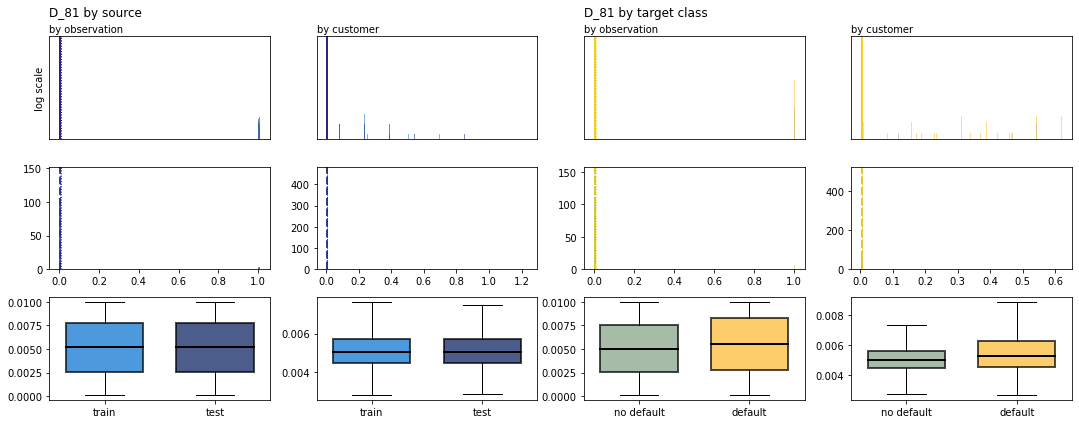


-

D_81
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00517           0.00518           0.00506           0.00554
              mean           0.05492           0.05987           0.01962           0.16166
               std           0.34000           0.36044           0.16876           0.60325
----------------------------------------------------------------------------------------------------
by_cust     median           0.00507           0.00507           0.00502           0.00525
              mean           0.05299           0.05773           0.01907           0.14999
               std           0.27495           0.29134           0.14183           0.47071
----------------------------------------------------------------------------------------------------
__________________________________________________

In [428]:
plot_next()

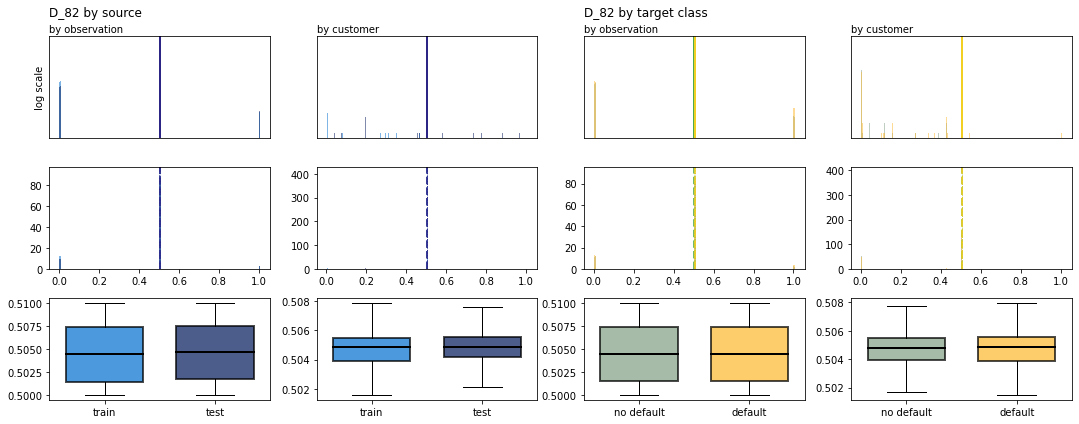


-

D_82
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.50443           0.50463           0.50441           0.50451
              mean           0.45771           0.47287           0.45597           0.46443
               std           0.19000           0.17529           0.18835           0.19605
----------------------------------------------------------------------------------------------------
by_cust     median           0.50483           0.50490           0.50483           0.50483
              mean           0.44382           0.47011           0.44159           0.45196
               std           0.19769           0.17224           0.19668           0.20115
----------------------------------------------------------------------------------------------------
__________________________________________________

In [429]:
plot_next()

In [ ]:
D_82.dist_type = 'discrete'
D_82.processing_steps['round discrete'] = lambda srs: (2*srs).round()

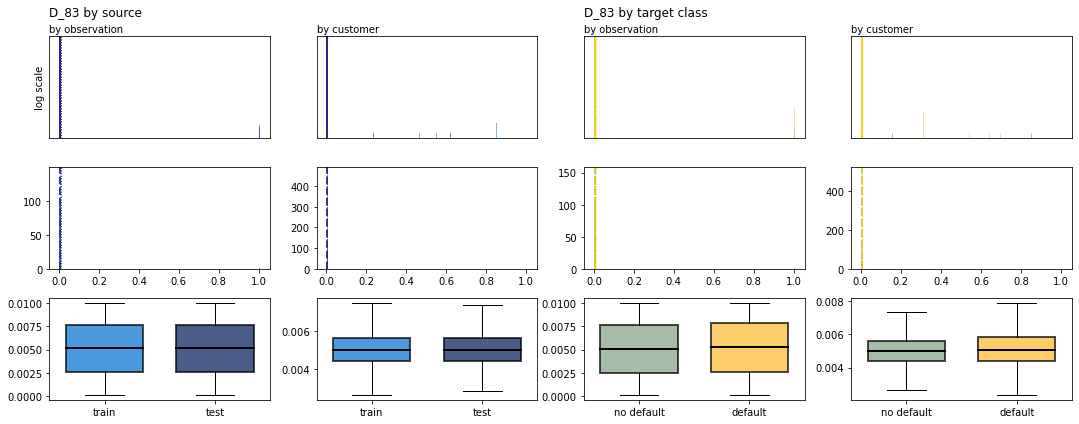


-

D_83
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00512           0.00509           0.00508           0.00527
              mean           0.04093           0.03143           0.02705           0.08430
               std           0.30595           0.25535           0.23383           0.46124
----------------------------------------------------------------------------------------------------
by_cust     median           0.00504           0.00503           0.00502           0.00509
              mean           0.04361           0.03228           0.02839           0.08738
               std           0.29884           0.24164           0.22511           0.44478
----------------------------------------------------------------------------------------------------
__________________________________________________

In [430]:
plot_next()

In [ ]:
D_83.dist_type = 'binary'
D_83.processing_steps['as binary'] = methodcaller('round')

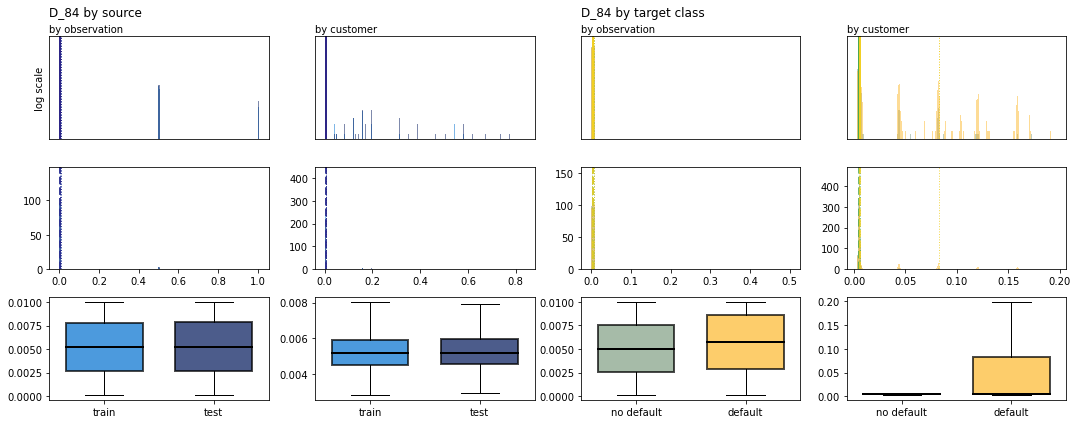


-

D_84
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00521           0.00521           0.00506           0.00571
              mean           0.04475           0.04772           0.01365           0.13876
               std           0.28507           0.30219           0.10812           0.52901
----------------------------------------------------------------------------------------------------
by_cust     median           0.00516           0.00516           0.00505           0.00566
              mean           0.04487           0.04671           0.01369           0.13399
               std           0.20727           0.21067           0.07611           0.37215
----------------------------------------------------------------------------------------------------
__________________________________________________

In [431]:
plot_next()

Values for D_84 are distributed uniformly from discrete steps centered around 0, 0.5, and 1.

In [ ]:
D_84.dist_type = 'discrete'
D_84.processing_steps['round discrete'] = lambda srs: (2*srs).round()

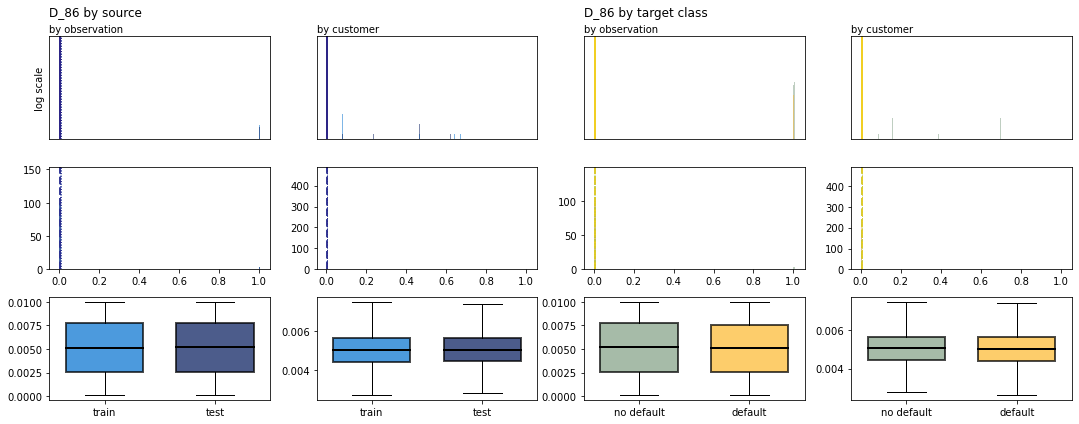


-

D_86
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00517           0.00516           0.00520           0.00506
              mean           0.03750           0.03559           0.04436           0.01680
               std           0.17734           0.17222           0.19448           0.10800
----------------------------------------------------------------------------------------------------
by_cust     median           0.00505           0.00505           0.00506           0.00502
              mean           0.03565           0.03446           0.04259           0.01580
               std           0.15925           0.14946           0.17562           0.09561
----------------------------------------------------------------------------------------------------
__________________________________________________

In [432]:
plot_next()

In [ ]:
D_86.dist_type = 'binary'
D_86.processing_steps = methodcaller('round')

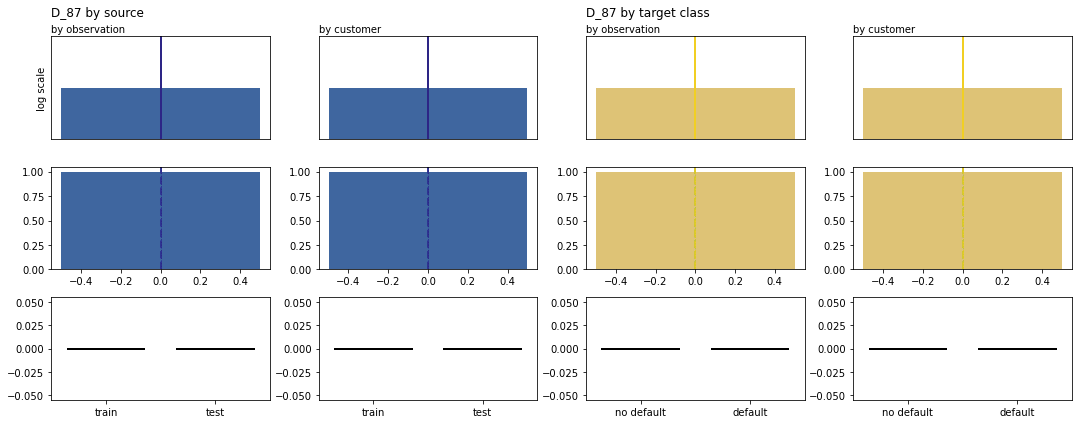


-

D_87
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00000           0.00000           0.00000           0.00000
              mean           0.00070           0.00097           0.00012           0.00243
               std           0.02642           0.03106           0.01112           0.04926
----------------------------------------------------------------------------------------------------
by_cust     median           0.00000           0.00000           0.00000           0.00000
              mean           0.00066           0.00092           0.00012           0.00221
               std           0.02101           0.02347           0.00925           0.03817
----------------------------------------------------------------------------------------------------
__________________________________________________

In [433]:
plot_next()

D_87 is a known binary feature.

In [ ]:
D_87.dist_type = 'binary'
D_87.processing_steps = methodcaller('fillna', fill_value=0)

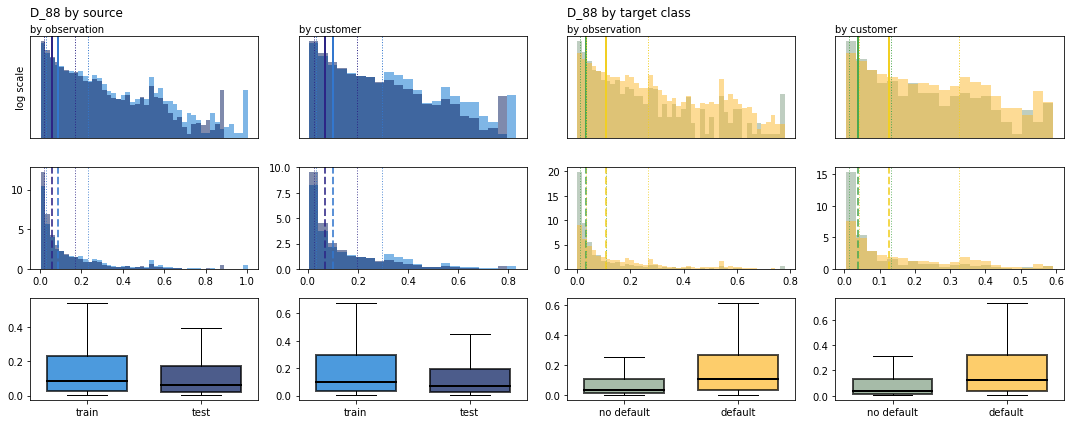


-

D_88
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.08562           0.05953           0.03452           0.10754
              mean           0.17230           0.13431           0.09928           0.19100
               std           0.21806           0.19194           0.15574           0.22761
----------------------------------------------------------------------------------------------------
by_cust     median           0.09945           0.06830           0.04023           0.12671
              mean           0.18027           0.13818           0.10186           0.20029
               std           0.19877           0.17361           0.13373           0.20754
----------------------------------------------------------------------------------------------------
__________________________________________________

In [434]:
plot_next()

In [ ]:
D_88.dist_type = 'exponential'

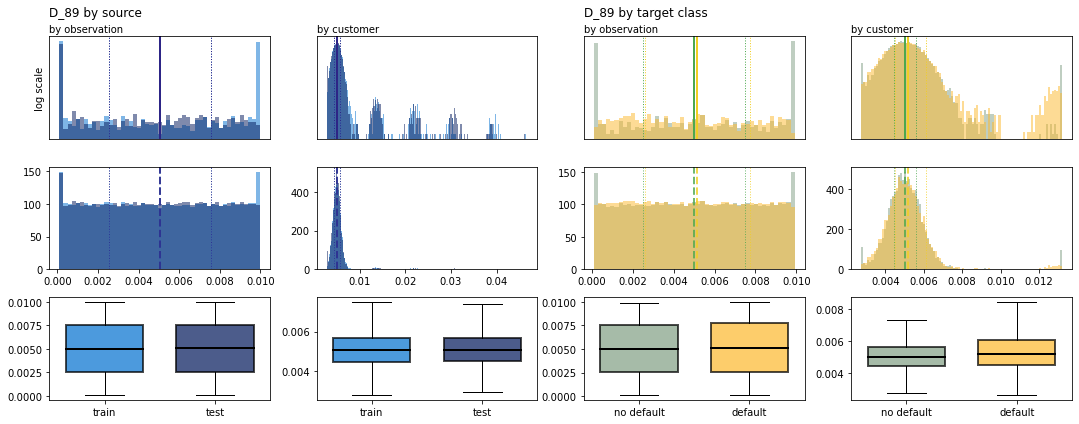


-

D_89
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00505           0.00505           0.00501           0.00516
              mean           0.00645           0.00654           0.00523           0.01012
               std           0.01903           0.01978           0.00736           0.03571
----------------------------------------------------------------------------------------------------
by_cust     median           0.00506           0.00506           0.00501           0.00520
              mean           0.00645           0.00650           0.00523           0.00994
               std           0.01016           0.00934           0.00335           0.01870
----------------------------------------------------------------------------------------------------
__________________________________________________

In [435]:
plot_next()

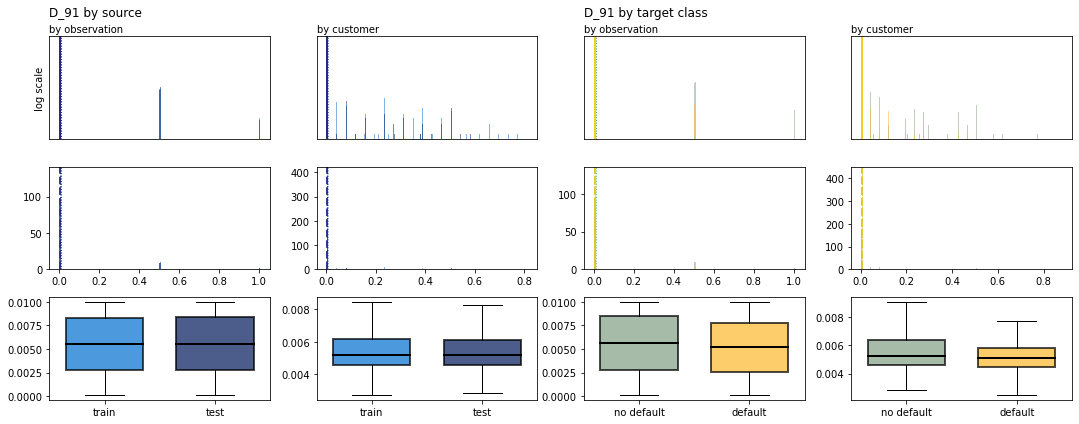


-

D_91
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00555           0.00558           0.00568           0.00517
              mean           0.06221           0.06555           0.07501           0.02227
               std           0.18643           0.19167           0.20487           0.10070
----------------------------------------------------------------------------------------------------
by_cust     median           0.00523           0.00521           0.00528           0.00508
              mean           0.05993           0.06391           0.07324           0.02128
               std           0.16151           0.17082           0.17889           0.08308
----------------------------------------------------------------------------------------------------
__________________________________________________

In [436]:
plot_next()

D_91 is another feature with vlaues distributed uniformly from steps at 0, 0.5, and 1.

In [ ]:
D_91.dist_type = 'discrete'
D_91.processing_steps['round discrete'] = lambda srs: (2*srs).round()

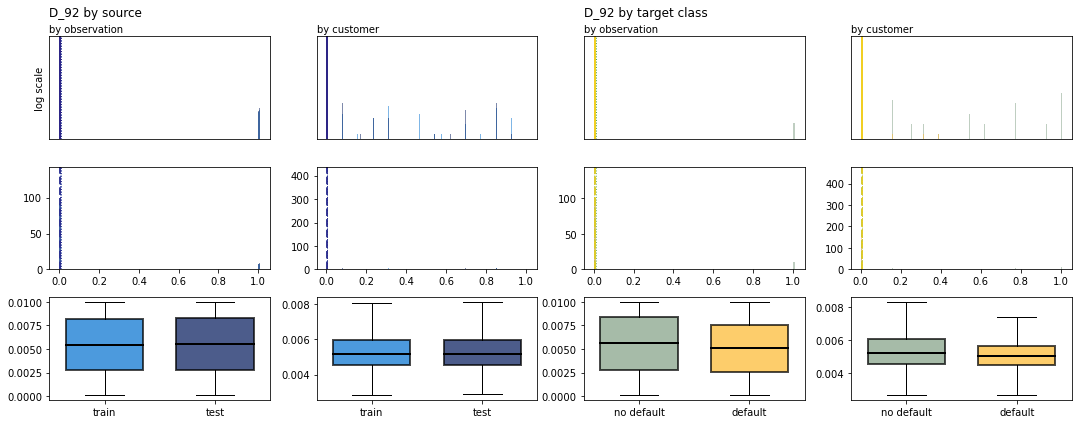


-

D_92
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00545           0.00551           0.00559           0.00505
              mean           0.09102           0.10278           0.11599           0.01574
               std           0.29362           0.31417           0.32892           0.11142
----------------------------------------------------------------------------------------------------
by_cust     median           0.00516           0.00518           0.00521           0.00503
              mean           0.08659           0.09854           0.11165           0.01488
               std           0.25276           0.27146           0.28550           0.08069
----------------------------------------------------------------------------------------------------
__________________________________________________

In [437]:
plot_next()

In [ ]:
D_92.dist_type = 'binary'
D_92.processing_steps['as binary'] = methodcaller('round')

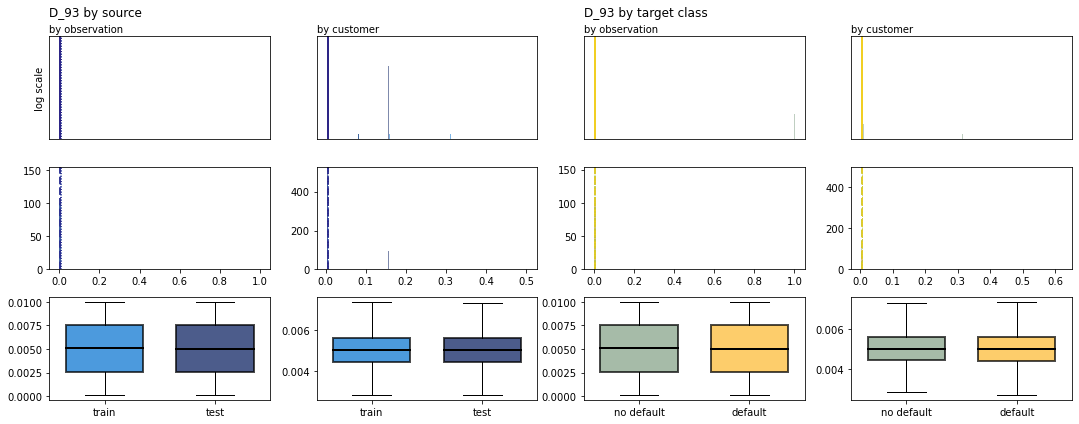


-

D_93
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00505           0.00503           0.00506           0.00502
              mean           0.01511           0.01238           0.01720           0.00879
               std           0.10006           0.08564           0.10981           0.06154
----------------------------------------------------------------------------------------------------
by_cust     median           0.00502           0.00501           0.00502           0.00500
              mean           0.01472           0.01218           0.01685           0.00862
               std           0.08873           0.07406           0.09754           0.05590
----------------------------------------------------------------------------------------------------
__________________________________________________

In [438]:
plot_next()

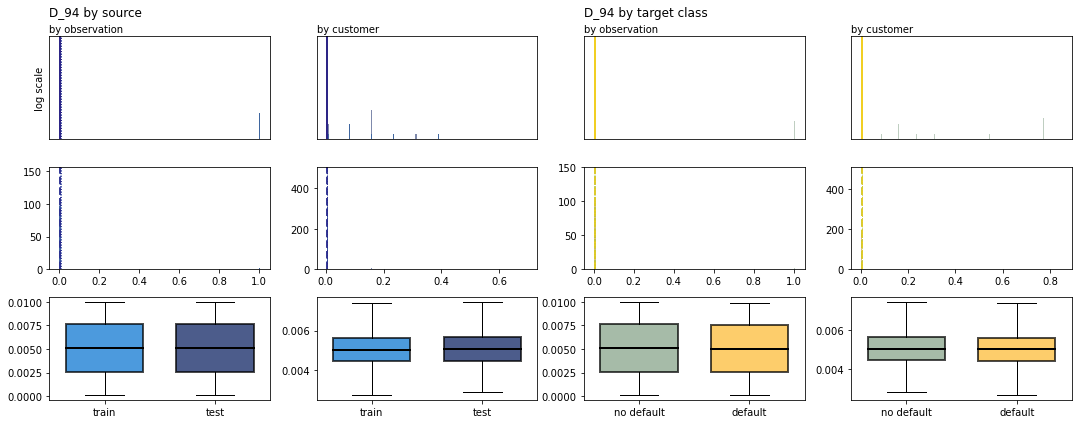


-

D_94
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00509           0.00509           0.00512           0.00501
              mean           0.02227           0.02341           0.02743           0.00672
               std           0.13031           0.13448           0.14811           0.04153
----------------------------------------------------------------------------------------------------
by_cust     median           0.00504           0.00504           0.00505           0.00501
              mean           0.02126           0.02265           0.02638           0.00660
               std           0.10591           0.11074           0.12126           0.03076
----------------------------------------------------------------------------------------------------
__________________________________________________

In [439]:
plot_next()

In [ ]:
D_94.dist_type = 'binary'
D_94.processing_steps['as binary'] = methodcaller('round')

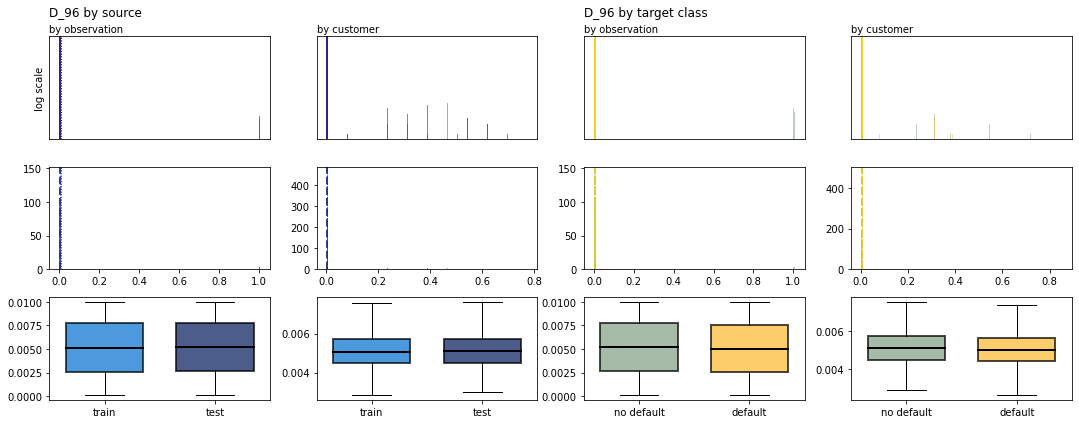


-

D_96
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00516           0.00518           0.00519           0.00506
              mean           0.03572           0.03895           0.04170           0.01768
               std           0.17258           0.18112           0.18805           0.11195
----------------------------------------------------------------------------------------------------
by_cust     median           0.00507           0.00508           0.00508           0.00503
              mean           0.03435           0.03799           0.04041           0.01702
               std           0.13384           0.14176           0.14693           0.08358
----------------------------------------------------------------------------------------------------
__________________________________________________

In [440]:
plot_next()

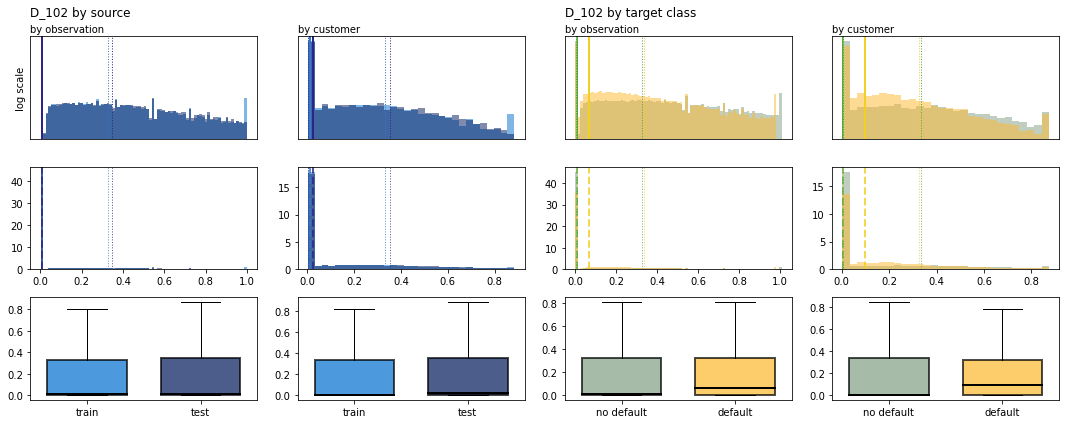


-

D_102
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00890           0.00907           0.00843           0.06586
              mean           0.18984           0.19769           0.18669           0.19937
               std           0.27480           0.27960           0.27992           0.25842
----------------------------------------------------------------------------------------------------
by_cust     median           0.01033           0.02316           0.00640           0.09886
              mean           0.18698           0.19519           0.18451           0.19403
               std           0.24805           0.25197           0.25326           0.23234
----------------------------------------------------------------------------------------------------
_________________________________________________

In [441]:
plot_next()

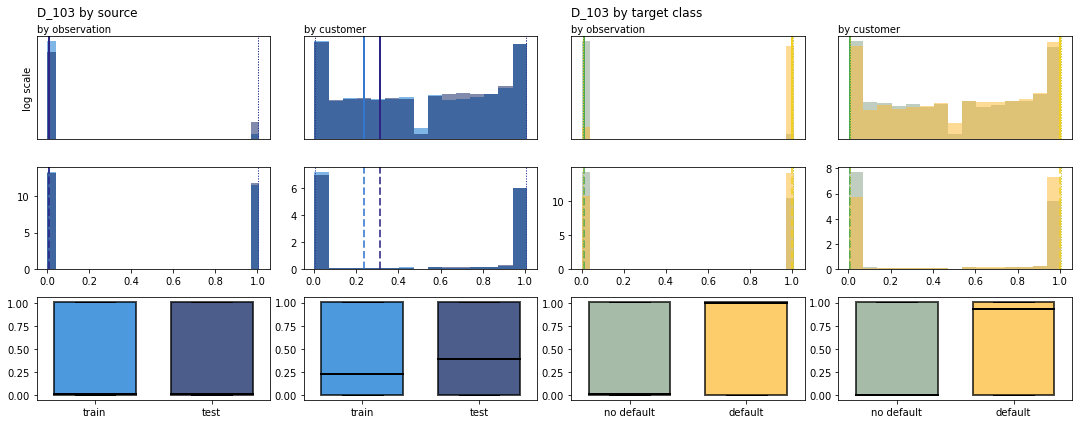


-

D_103
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00930           0.00944           0.00872           1.00123
              mean           0.46726           0.47513           0.43174           0.57551
               std           0.49858           0.49911           0.49461           0.49501
----------------------------------------------------------------------------------------------------
by_cust     median           0.23526           0.31099           0.00669           1.00152
              mean           0.46985           0.47548           0.43363           0.57337
               std           0.47750           0.47622           0.47313           0.47480
----------------------------------------------------------------------------------------------------
_________________________________________________

In [442]:
plot_next()

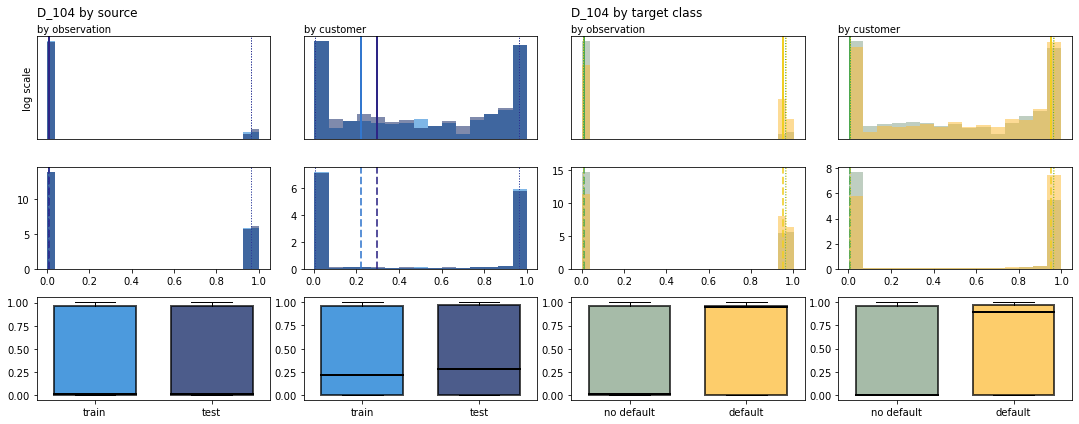


-

D_104
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00930           0.00944           0.00873           0.95308
              mean           0.45063           0.45857           0.41658           0.55439
               std           0.48074           0.48165           0.47714           0.47679
----------------------------------------------------------------------------------------------------
by_cust     median           0.22349           0.29487           0.00669           0.95093
              mean           0.45306           0.45886           0.41836           0.55221
               std           0.46039           0.45952           0.45640           0.45730
----------------------------------------------------------------------------------------------------
_________________________________________________

In [443]:
plot_next()

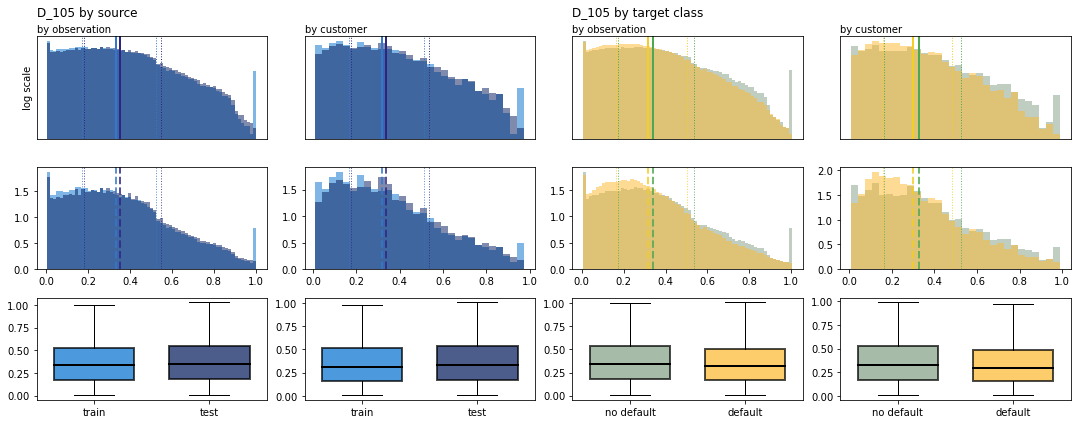


-

D_105
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.33385           0.35336           0.34223           0.31670
              mean           0.37012           0.38560           0.37626           0.35612
               std           0.25052           0.25372           0.25266           0.24500
----------------------------------------------------------------------------------------------------
by_cust     median           0.31679           0.33713           0.32837           0.29982
              mean           0.35857           0.37455           0.36445           0.34539
               std           0.24693           0.25036           0.24998           0.23943
----------------------------------------------------------------------------------------------------
_________________________________________________

In [444]:
plot_next()

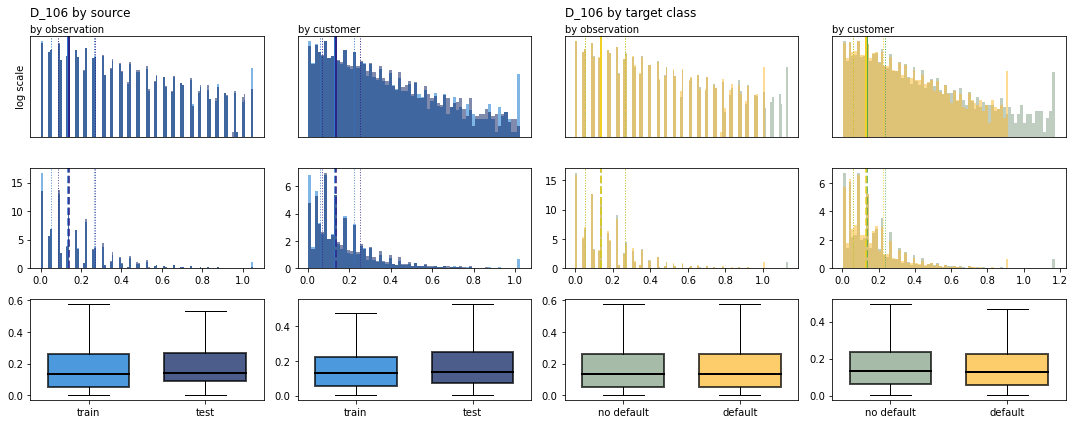


-

D_106
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.13634           0.13819           0.13678           0.13599
              mean           0.20524           0.21508           0.21609           0.19637
               std           1.25759           0.72838           1.83435           0.35064
----------------------------------------------------------------------------------------------------
by_cust     median           0.13387           0.13562           0.13498           0.12885
              mean           0.19425           0.20389           0.21377           0.17821
               std           1.28007           0.60254           1.88325           0.26516
----------------------------------------------------------------------------------------------------
_________________________________________________

In [445]:
plot_next()

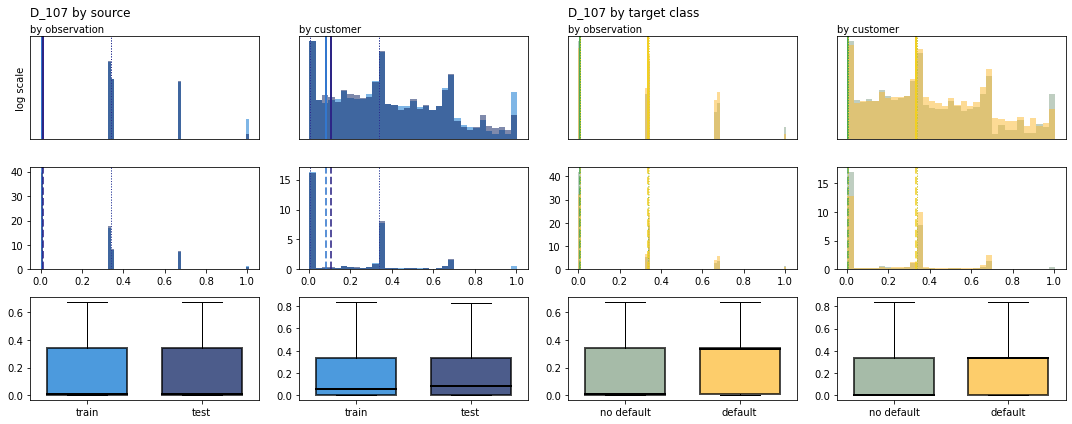


-

D_107
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00930           0.00944           0.00872           0.33505
              mean           0.20690           0.21120           0.18893           0.26164
               std           0.25725           0.25905           0.24870           0.27458
----------------------------------------------------------------------------------------------------
by_cust     median           0.08155           0.10655           0.00668           0.33645
              mean           0.20805           0.21121           0.18977           0.26031
               std           0.24836           0.24907           0.23990           0.26418
----------------------------------------------------------------------------------------------------
_________________________________________________

In [446]:
plot_next()

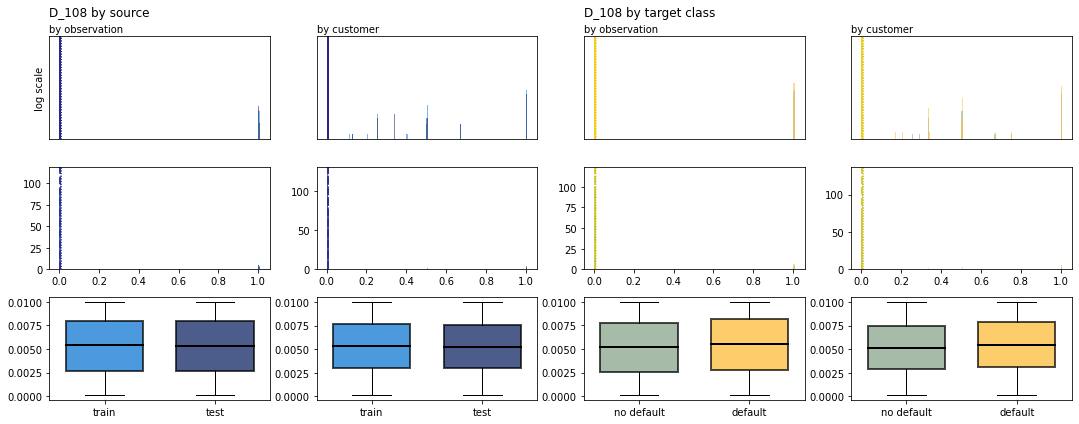


-

D_108
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00535           0.00523           0.00523           0.00554
              mean           0.07148           0.05732           0.04950           0.10073
               std           0.32173           0.26554           0.25098           0.39488
----------------------------------------------------------------------------------------------------
by_cust     median           0.00528           0.00521           0.00516           0.00545
              mean           0.05686           0.04416           0.03913           0.08140
               std           0.25480           0.20699           0.19616           0.31700
----------------------------------------------------------------------------------------------------
_________________________________________________

In [447]:
plot_next()

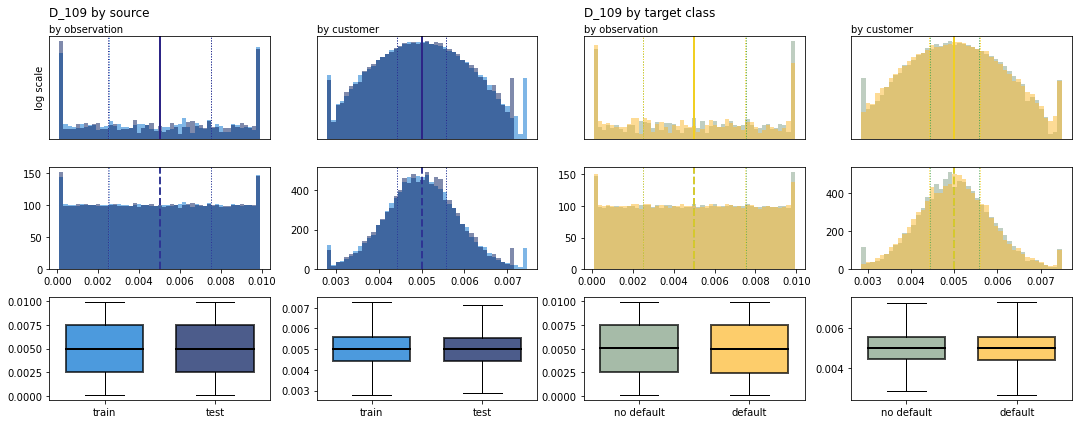


-

D_109
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00501           0.00500           0.00501           0.00501
              mean           0.00666           0.00597           0.00714           0.00520
               std           0.04081           0.03135           0.04634           0.01445
----------------------------------------------------------------------------------------------------
by_cust     median           0.00500           0.00500           0.00500           0.00500
              mean           0.00658           0.00597           0.00707           0.00519
               std           0.03915           0.03117           0.04475           0.01357
----------------------------------------------------------------------------------------------------
_________________________________________________

In [448]:
plot_next()

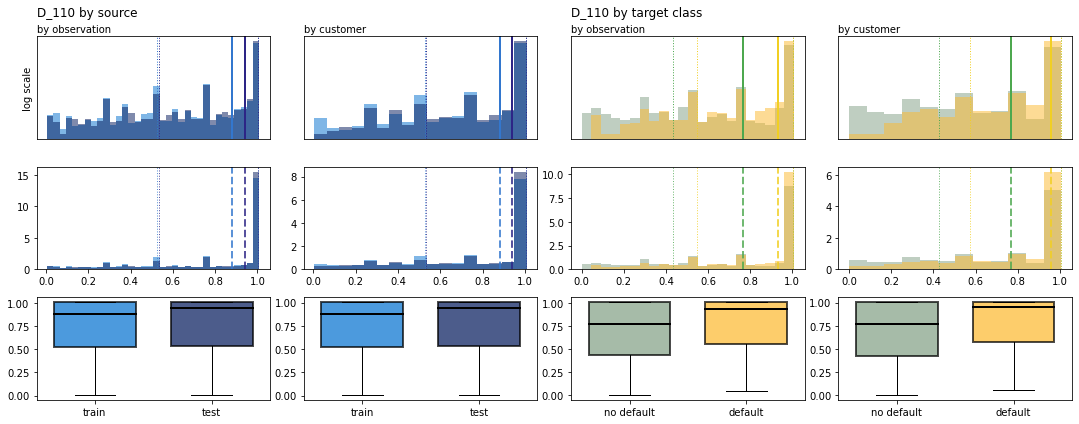


-

D_110
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.87885           0.94319           0.76919           0.93482
              mean           0.73926           0.76363           0.69328           0.77570
               std           0.30829           0.30082           0.32893           0.28571
----------------------------------------------------------------------------------------------------
by_cust     median           0.88184           0.93981           0.76734           0.95643
              mean           0.74035           0.76199           0.69113           0.78392
               std           0.30757           0.30240           0.32771           0.28156
----------------------------------------------------------------------------------------------------
_________________________________________________

In [449]:
plot_next()

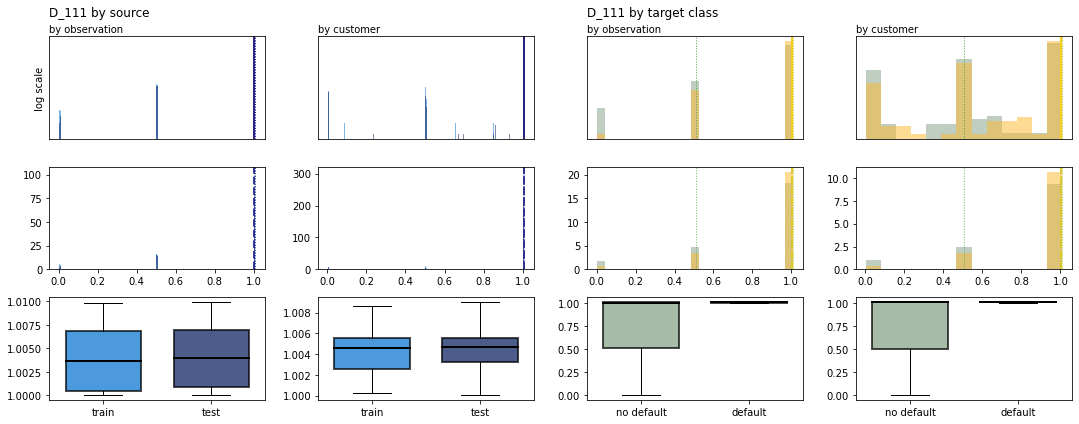


-

D_111
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           1.00368           1.00394           1.00321           1.00402
              mean           0.87455           0.90153           0.83435           0.90640
               std           0.26949           0.24525           0.30556           0.23217
----------------------------------------------------------------------------------------------------
by_cust     median           1.00458           1.00469           1.00439           1.00468
              mean           0.86892           0.88936           0.82866           0.90456
               std           0.27485           0.26518           0.31062           0.23311
----------------------------------------------------------------------------------------------------
_________________________________________________

In [450]:
plot_next()

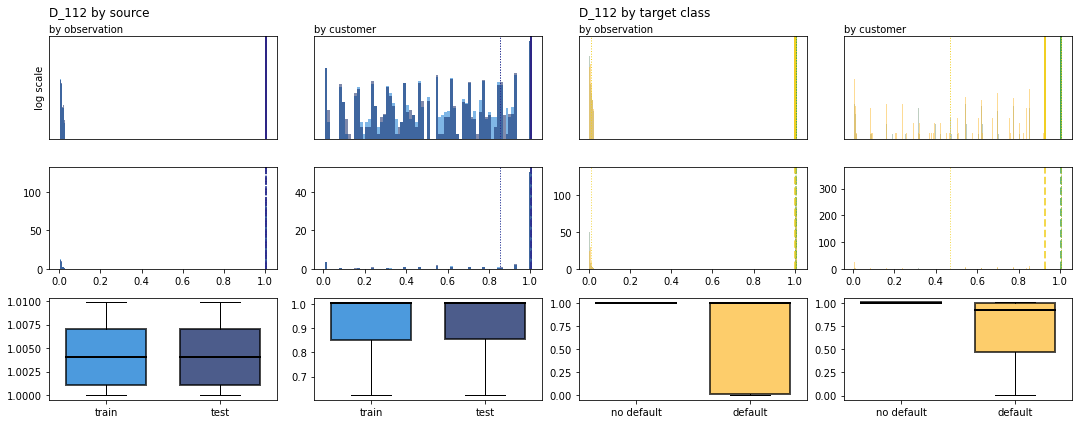


-

D_112
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           1.00401           1.00402           1.00433           1.00282
              mean           0.84104           0.84225           0.88715           0.70204
               std           0.36941           0.36829           0.32156           0.45870
----------------------------------------------------------------------------------------------------
by_cust     median           1.00453           1.00453           1.00470           0.92859
              mean           0.84634           0.84664           0.89111           0.71823
               std           0.30139           0.30108           0.26256           0.36245
----------------------------------------------------------------------------------------------------
_________________________________________________

In [451]:
plot_next()

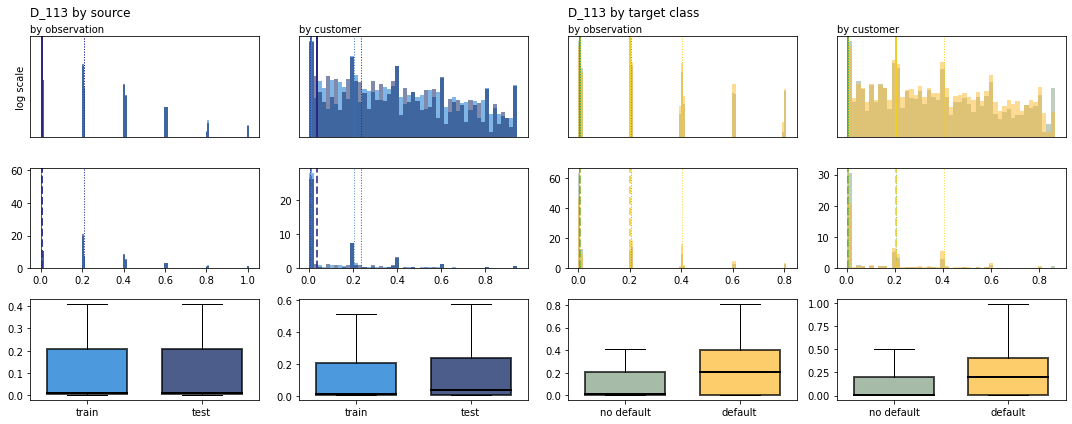


-

D_113
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00871           0.00892           0.00811           0.20226
              mean           0.15696           0.16285           0.13660           0.22042
               std           0.22667           0.23029           0.21137           0.25872
----------------------------------------------------------------------------------------------------
by_cust     median           0.00839           0.03569           0.00618           0.20383
              mean           0.16246           0.16723           0.14065           0.22520
               std           0.22315           0.22504           0.20715           0.25357
----------------------------------------------------------------------------------------------------
_________________________________________________

In [452]:
plot_next()

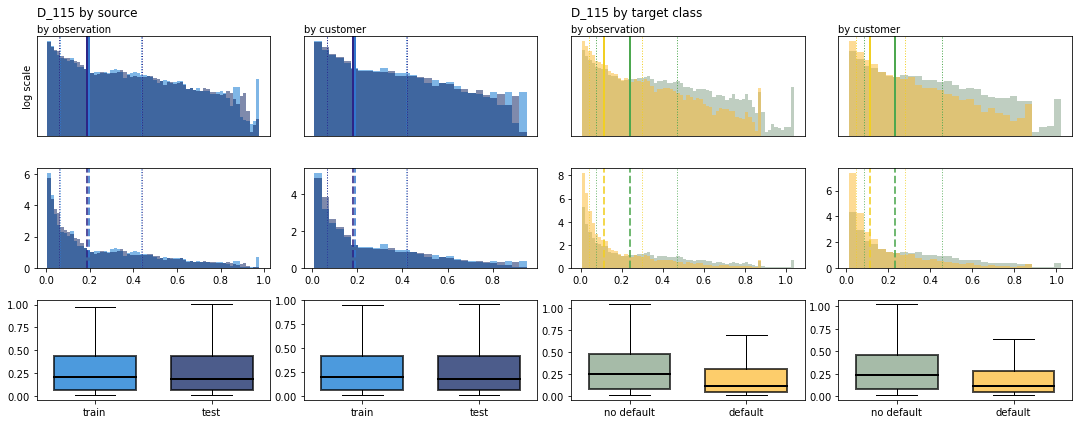


-

D_115
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.19914           0.18736           0.24140           0.11390
              mean           0.27813           0.27870           0.30390           0.19778
               std           0.25621           0.26171           0.26367           0.21220
----------------------------------------------------------------------------------------------------
by_cust     median           0.18947           0.18114           0.23090           0.11205
              mean           0.27009           0.27288           0.29749           0.19128
               std           0.24604           0.25327           0.25422           0.20099
----------------------------------------------------------------------------------------------------
_________________________________________________

In [453]:
plot_next()

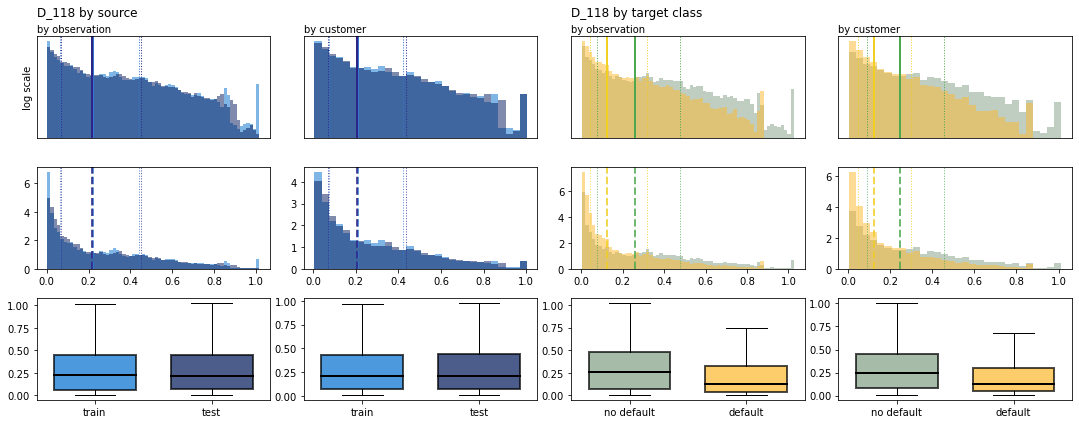


-

D_118
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.22046           0.21676           0.25982           0.12524
              mean           0.28351           0.28933           0.30819           0.20657
               std           0.25595           0.26047           0.26307           0.21488
----------------------------------------------------------------------------------------------------
by_cust     median           0.20863           0.20692           0.24566           0.12390
              mean           0.27565           0.28358           0.30182           0.20037
               std           0.24340           0.25365           0.25086           0.20251
----------------------------------------------------------------------------------------------------
_________________________________________________

In [454]:
plot_next()

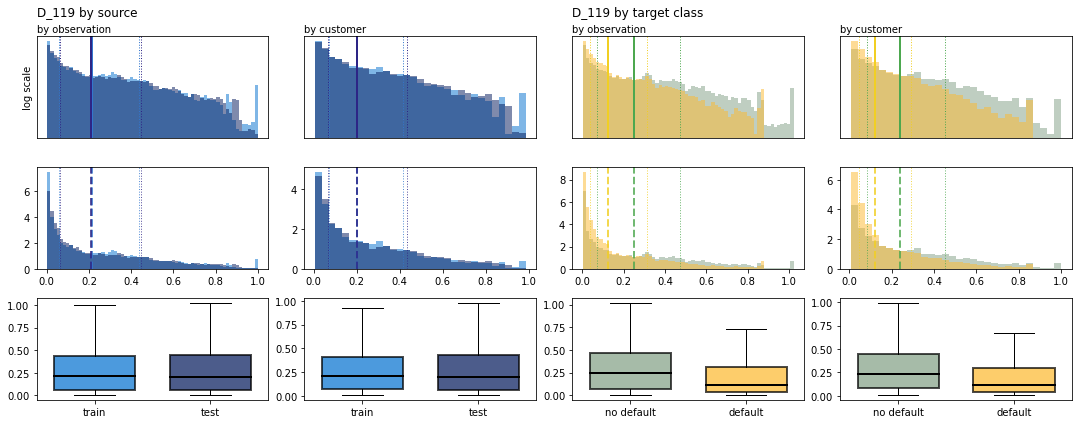


-

D_119
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.21339           0.21066           0.25204           0.12140
              mean           0.27941           0.28579           0.30390           0.20307
               std           0.25647           0.26114           0.26386           0.21467
----------------------------------------------------------------------------------------------------
by_cust     median           0.20145           0.20161           0.23836           0.11990
              mean           0.27162           0.28006           0.29759           0.19693
               std           0.24410           0.25431           0.25183           0.20258
----------------------------------------------------------------------------------------------------
_________________________________________________

In [455]:
plot_next()

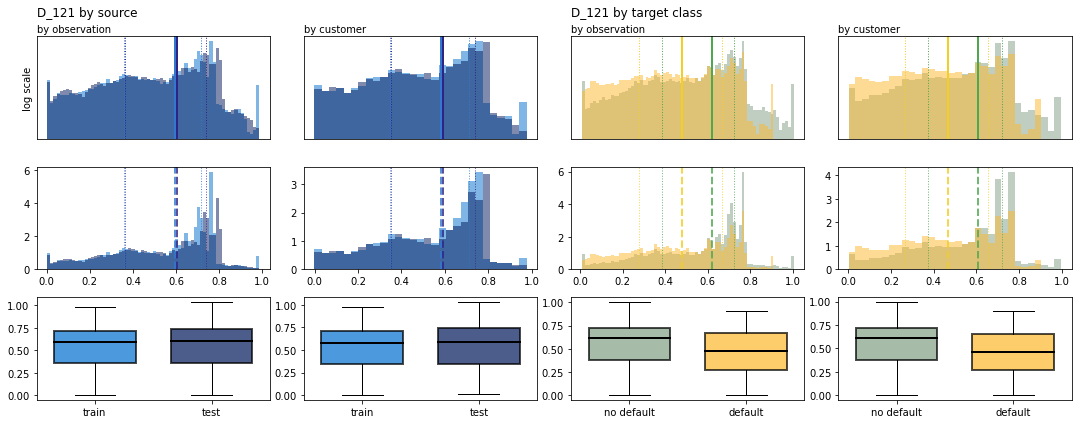


-

D_121
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.59538           0.60238           0.61847           0.47747
              mean           0.53224           0.54288           0.55464           0.46243
               std           0.23381           0.24384           0.22862           0.23603
----------------------------------------------------------------------------------------------------
by_cust     median           0.58245           0.59072           0.60931           0.46582
              mean           0.52214           0.53503           0.54615           0.45309
               std           0.23680           0.24647           0.23191           0.23717
----------------------------------------------------------------------------------------------------
_________________________________________________

In [466]:
plot_next()

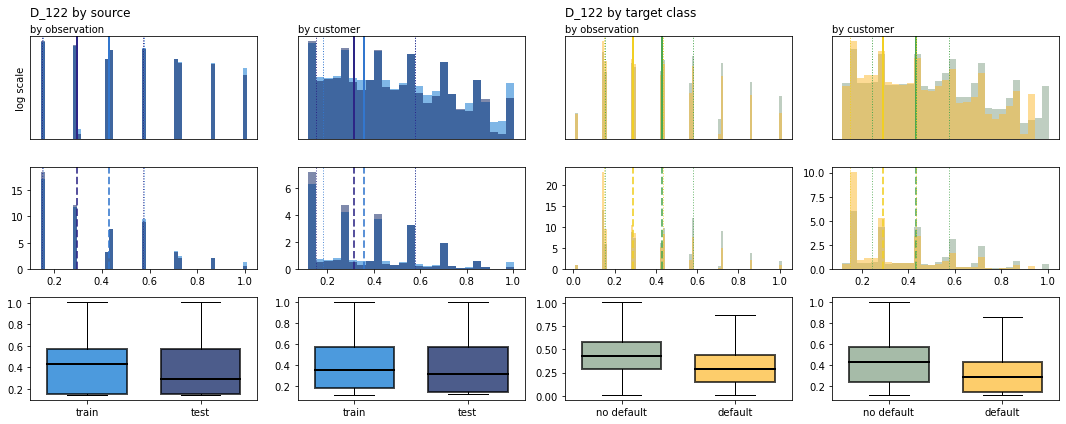


-

D_122
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.42918           0.29472           0.43141           0.29021
              mean           0.40442           0.38983           0.42548           0.33877
               std           0.23691           0.23339           0.23961           0.21546
----------------------------------------------------------------------------------------------------
by_cust     median           0.35801           0.31239           0.43082           0.29020
              mean           0.39800           0.38561           0.42057           0.33307
               std           0.22557           0.22432           0.22865           0.20294
----------------------------------------------------------------------------------------------------
_________________________________________________

In [468]:
plot_next()

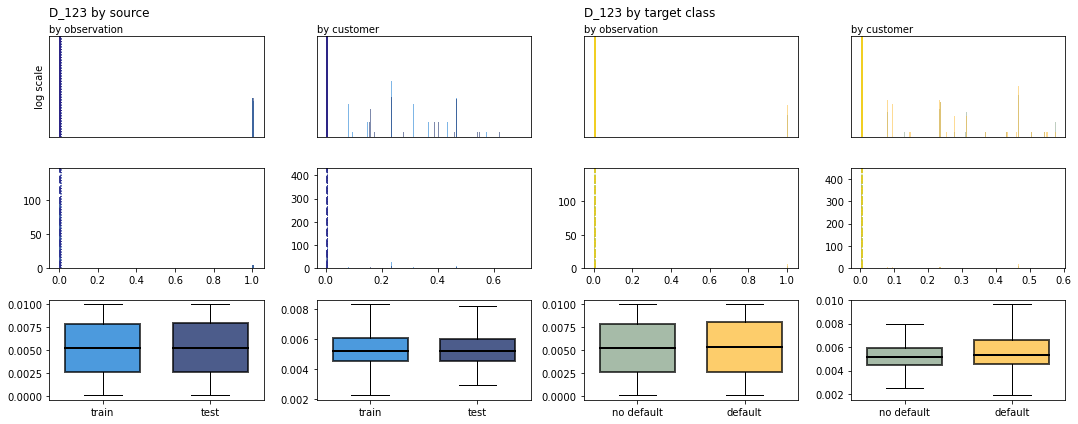


-

D_123
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00524           0.00525           0.00519           0.00537
              mean           0.05051           0.05455           0.04242           0.07570
               std           0.24560           0.34539           0.24046           0.25937
----------------------------------------------------------------------------------------------------
by_cust     median           0.00518           0.00518           0.00514           0.00531
              mean           0.05325           0.05677           0.04439           0.07875
               std           0.17987           0.26267           0.18007           0.17685
----------------------------------------------------------------------------------------------------
_________________________________________________

In [469]:
plot_next()

In [577]:
D_123.dist_type = 'binary'
D_123.processing_steps['as binary'] = methodcaller('round')

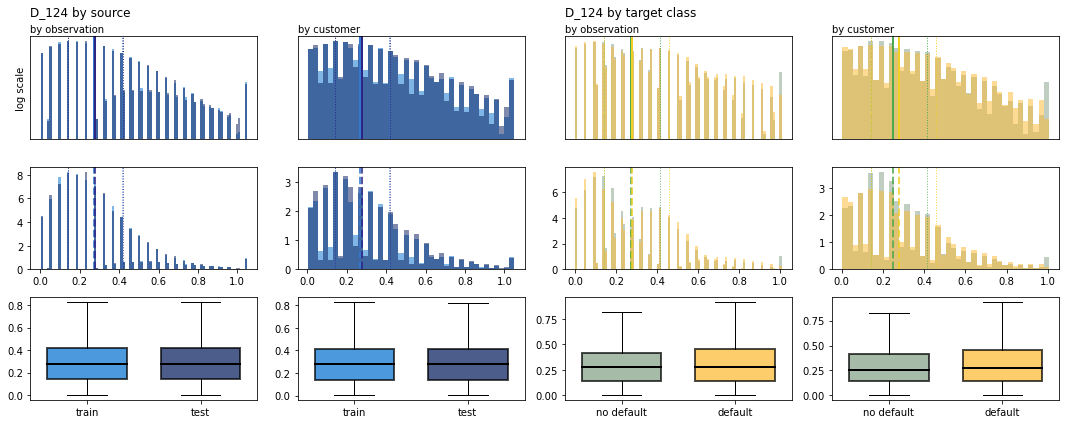


-

D_124
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.27420           0.27519           0.27320           0.27768
              mean           0.30555           0.31165           0.29847           0.32762
               std           0.22613           0.23163           0.21618           0.25338
----------------------------------------------------------------------------------------------------
by_cust     median           0.26747           0.27678           0.24835           0.27758
              mean           0.30387           0.30996           0.29673           0.32440
               std           0.22686           0.23188           0.21660           0.25297
----------------------------------------------------------------------------------------------------
_________________________________________________

In [470]:
plot_next()

In [578]:
D_124.dist_type = 'Poisson'

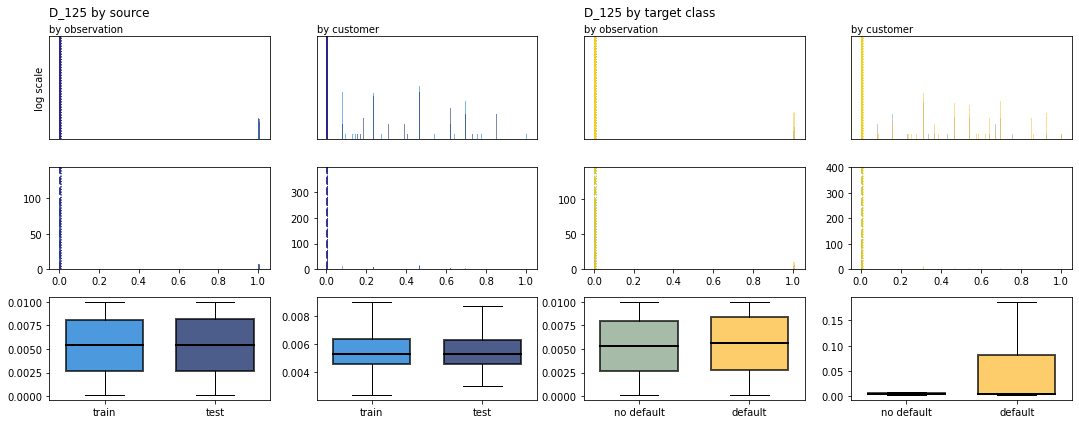


-

D_125
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00540           0.00540           0.00534           0.00561
              mean           0.08434           0.08454           0.07233           0.12180
               std           0.29226           0.29464           0.27105           0.34757
----------------------------------------------------------------------------------------------------
by_cust     median           0.00525           0.00526           0.00521           0.00539
              mean           0.08873           0.08814           0.07547           0.12688
               std           0.22168           0.21155           0.20173           0.26737
----------------------------------------------------------------------------------------------------
_________________________________________________

In [471]:
plot_next()

In [ ]:
D_125.dist_type = 'binary'
D_125.processing_steps['as binary'] = methodcaller('round')

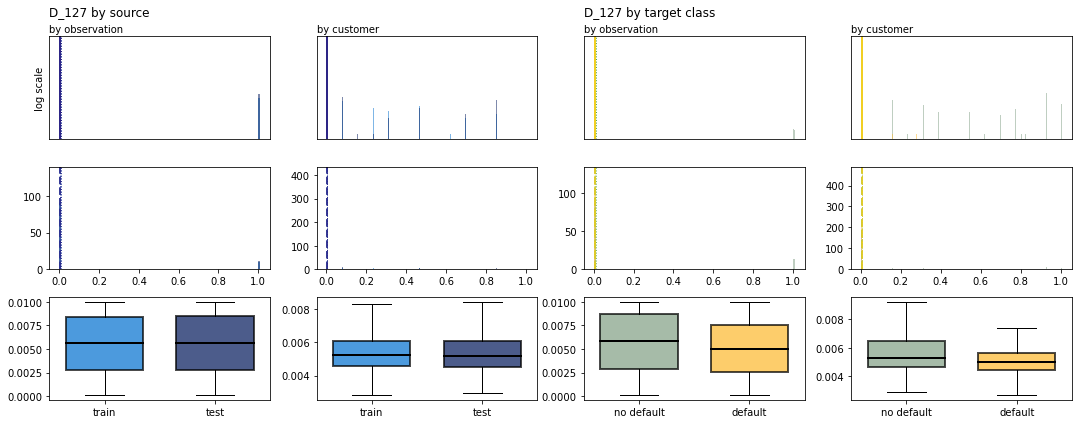


-

D_127
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00557           0.00566           0.00578           0.00504
              mean           0.10755           0.12170           0.13915           0.01229
               std           0.30338           0.32108           0.34082           0.08514
----------------------------------------------------------------------------------------------------
by_cust     median           0.00521           0.00522           0.00529           0.00503
              mean           0.10278           0.11801           0.13449           0.01201
               std           0.25860           0.28220           0.29152           0.06269
----------------------------------------------------------------------------------------------------
_________________________________________________

In [472]:
plot_next()

In [ ]:
D_127.dist_type = 'binary'
D_127.processing_steps['as binary'] = methodcaller('round')

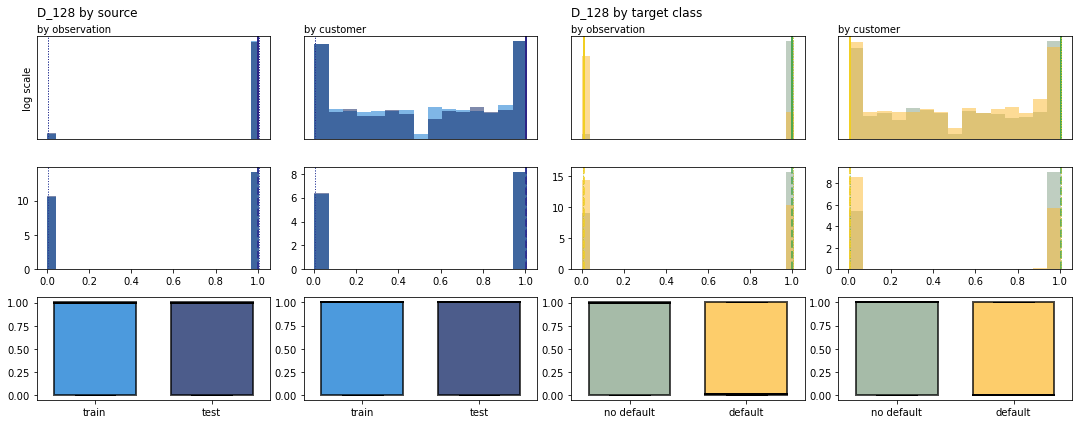


-

D_128
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           1.00042           1.00031           1.00113           0.00858
              mean           0.58412           0.57663           0.63740           0.42176
               std           0.49315           0.49430           0.48152           0.49267
----------------------------------------------------------------------------------------------------
by_cust     median           1.00287           1.00289           1.00323           0.00602
              mean           0.57121           0.56814           0.62804           0.40880
               std           0.48906           0.49006           0.47835           0.48292
----------------------------------------------------------------------------------------------------
_________________________________________________

In [473]:
plot_next()

In [ ]:
D_128.dist_type = 'binary'
D_128.processing_steps['as binary'] = methodcaller('round')

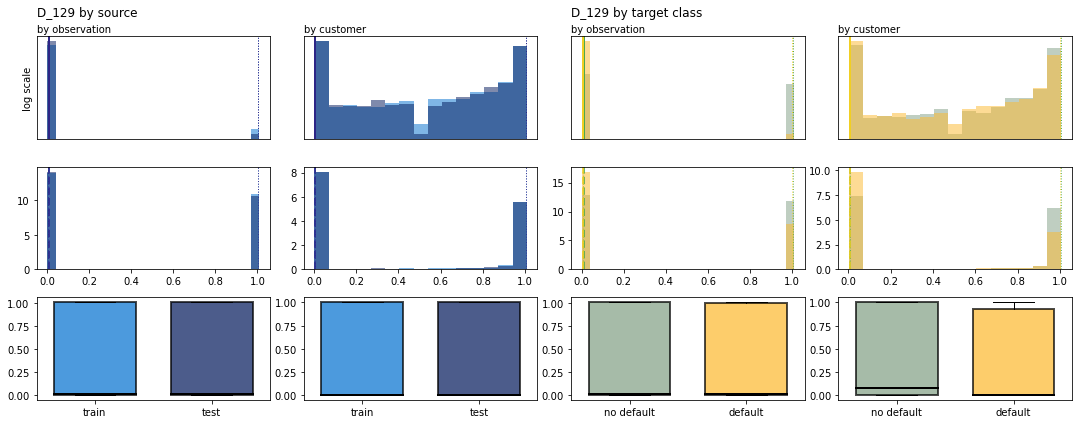


-

D_129
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00885           0.00879           0.00950           0.00732
              mean           0.43995           0.43596           0.47848           0.32251
               std           0.49576           0.49522           0.49930           0.46551
----------------------------------------------------------------------------------------------------
by_cust     median           0.00628           0.00621           0.00962           0.00563
              mean           0.43069           0.43018           0.47175           0.31334
               std           0.47936           0.48027           0.48368           0.44643
----------------------------------------------------------------------------------------------------
_________________________________________________

In [474]:
plot_next()

In [ ]:
D_129.dist_type = 'binary'
D_129.processing_steps = methodcaller('round')

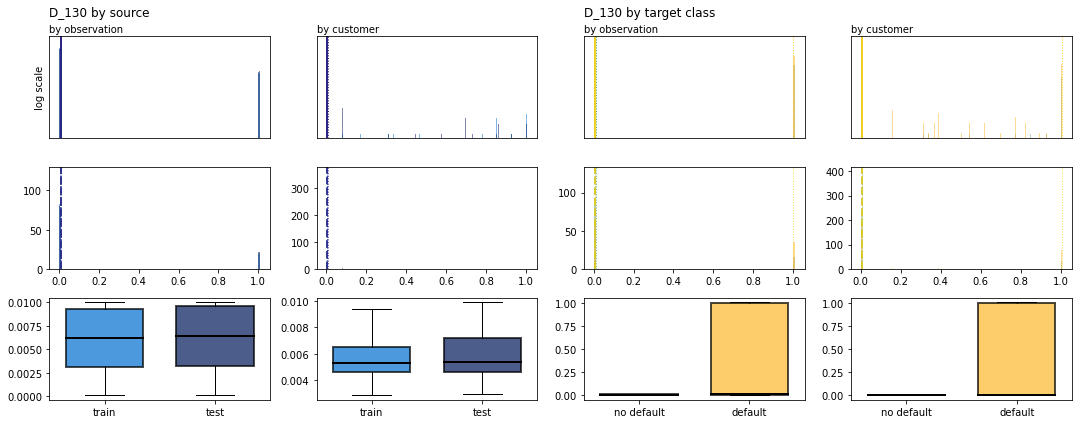


-

D_130
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00622           0.00643           0.00587           0.00760
              mean           0.20166           0.22680           0.15359           0.34815
               std           0.39749           0.41548           0.35570           0.47480
----------------------------------------------------------------------------------------------------
by_cust     median           0.00531           0.00535           0.00521           0.00577
              mean           0.20487           0.22745           0.15561           0.34567
               std           0.39126           0.40645           0.35136           0.45937
----------------------------------------------------------------------------------------------------
_________________________________________________

In [475]:
plot_next()

In [ ]:
D_130.dist_type = 'binary'
D_130.processing_steps['as binary'] = methodcaller('round')

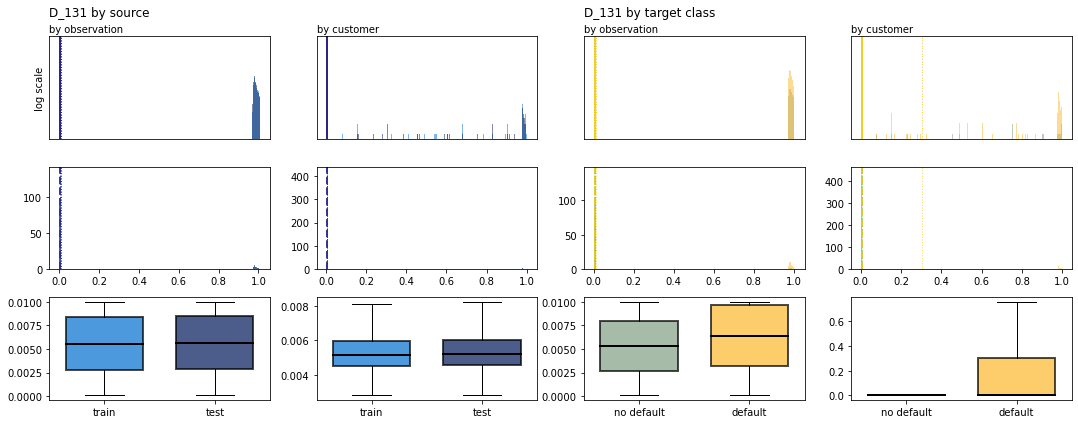


-

D_131
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00556           0.00569           0.00532           0.00644
              mean           0.10338           0.12333           0.06398           0.22343
               std           0.29533           0.32007           0.23408           0.40854
----------------------------------------------------------------------------------------------------
by_cust     median           0.00517           0.00520           0.00510           0.00547
              mean           0.10649           0.12419           0.06559           0.22338
               std           0.28114           0.30092           0.22216           0.38137
----------------------------------------------------------------------------------------------------
_________________________________________________

In [476]:
plot_next()

In [ ]:
D_131.dist_type = 'unknown, binary-like'

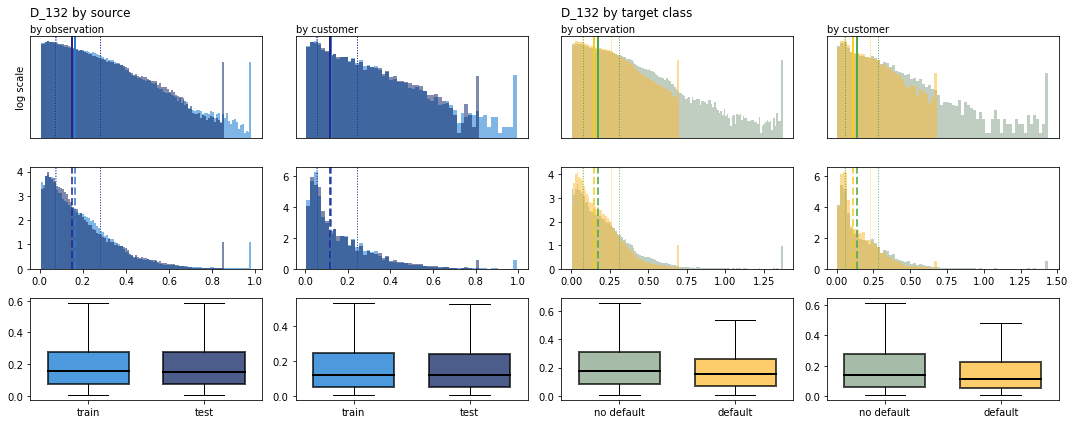


-

D_132
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.16148           0.15067           0.17740           0.15042
              mean           0.21020           0.20572           0.23765           0.18772
               std           0.24763           0.22873           0.29867           0.19331
----------------------------------------------------------------------------------------------------
by_cust     median           0.12197           0.11892           0.13685           0.11183
              mean           0.18597           0.18228           0.21459           0.16243
               std           0.25576           0.22973           0.31572           0.18975
----------------------------------------------------------------------------------------------------
_________________________________________________

In [477]:
plot_next()

In [ ]:
D_132.dist_type = 'exponential'

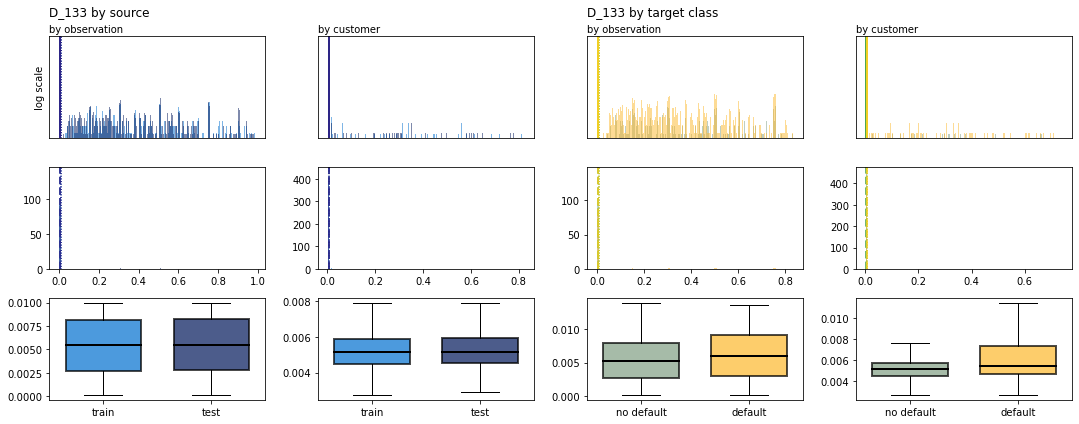


-

D_133
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00544           0.00554           0.00526           0.00607
              mean           0.04614           0.05412           0.03255           0.08743
               std           0.17209           0.18824           0.14658           0.22810
----------------------------------------------------------------------------------------------------
by_cust     median           0.00514           0.00516           0.00508           0.00536
              mean           0.04616           0.05362           0.03271           0.08465
               std           0.15224           0.16325           0.13039           0.19710
----------------------------------------------------------------------------------------------------
_________________________________________________

In [478]:
plot_next()

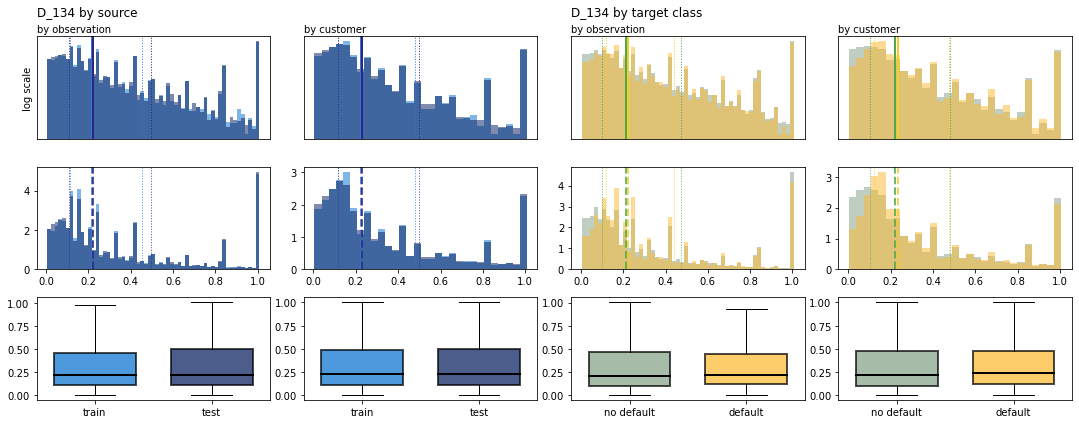


-

D_134
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.21777           0.21958           0.21254           0.22226
              mean           0.33008           0.33972           0.33089           0.32956
               std           0.29622           0.30886           0.30534           0.29016
----------------------------------------------------------------------------------------------------
by_cust     median           0.22718           0.23187           0.21835           0.23441
              mean           0.33475           0.34430           0.33116           0.33724
               std           0.29298           0.30497           0.30036           0.28773
----------------------------------------------------------------------------------------------------
_________________________________________________

In [479]:
plot_next()

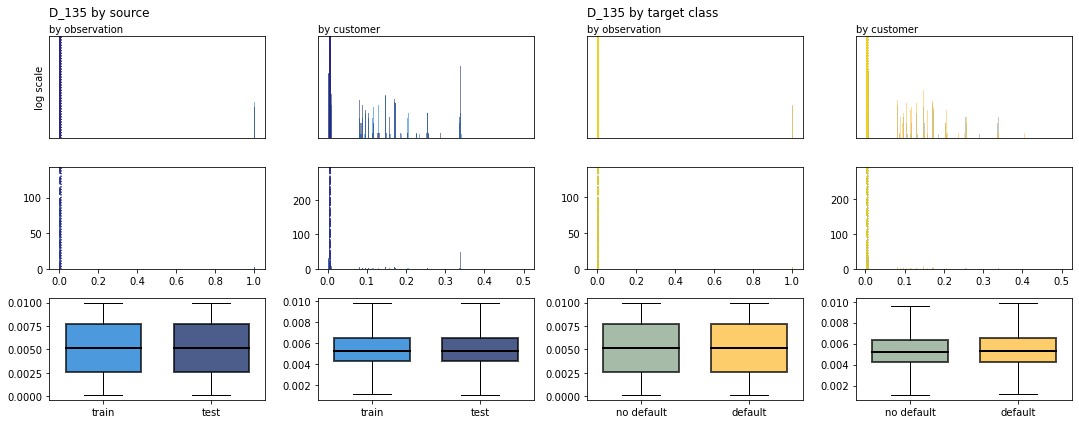


-

D_135
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00511           0.00511           0.00509           0.00512
              mean           0.02997           0.02678           0.02730           0.03170
               std           0.15610           0.14598           0.14772           0.16126
----------------------------------------------------------------------------------------------------
by_cust     median           0.00523           0.00521           0.00520           0.00526
              mean           0.03100           0.02637           0.02852           0.03272
               std           0.09613           0.08304           0.09337           0.09796
----------------------------------------------------------------------------------------------------
_________________________________________________

In [480]:
plot_next()

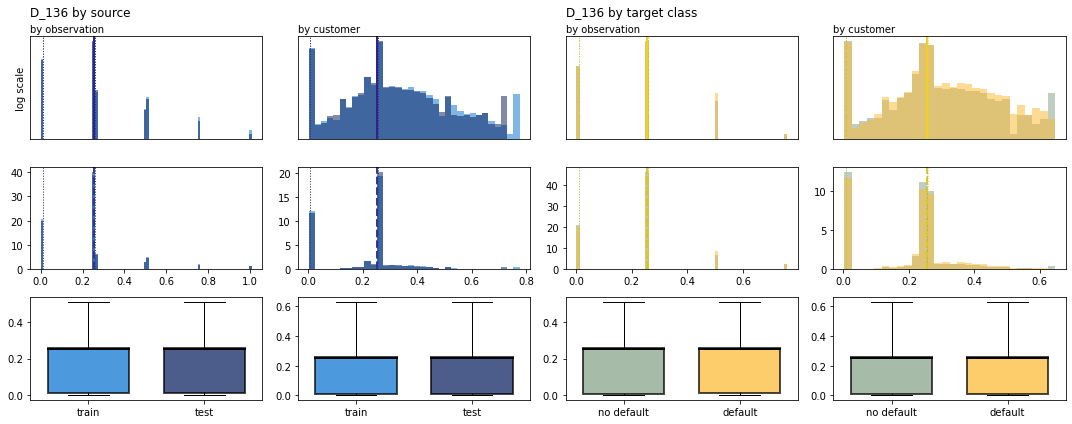


-

D_136
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.25395           0.25402           0.25369           0.25412
              mean           0.24277           0.24214           0.22846           0.25203
               std           0.21013           0.20418           0.18790           0.22285
----------------------------------------------------------------------------------------------------
by_cust     median           0.25423           0.25432           0.25411           0.25431
              mean           0.21277           0.21338           0.20278           0.21970
               std           0.16341           0.15743           0.15072           0.17132
----------------------------------------------------------------------------------------------------
_________________________________________________

In [481]:
plot_next()

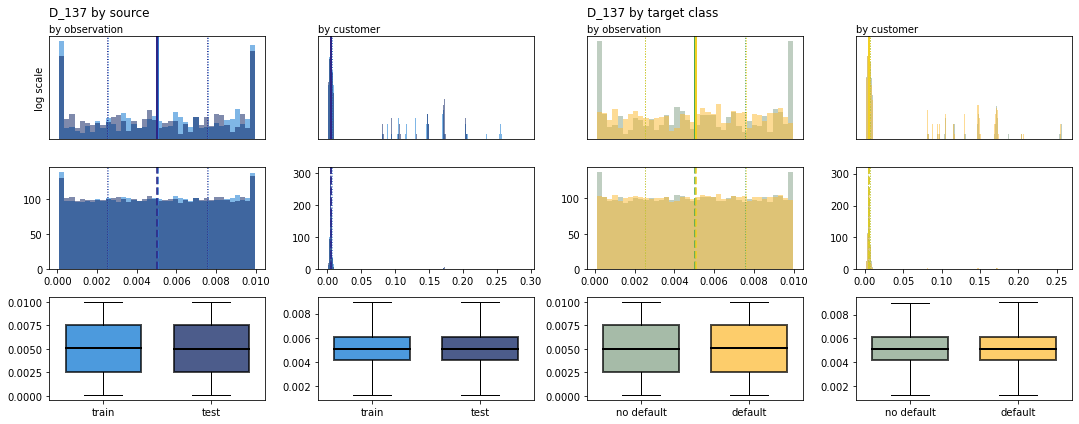


-

D_137
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00507           0.00504           0.00506           0.00508
              mean           0.01424           0.01359           0.01318           0.01493
               std           0.09571           0.09235           0.09009           0.09917
----------------------------------------------------------------------------------------------------
by_cust     median           0.00509           0.00508           0.00508           0.00510
              mean           0.01706           0.01566           0.01619           0.01766
               std           0.07231           0.06460           0.07256           0.07213
----------------------------------------------------------------------------------------------------
_________________________________________________

In [482]:
plot_next()

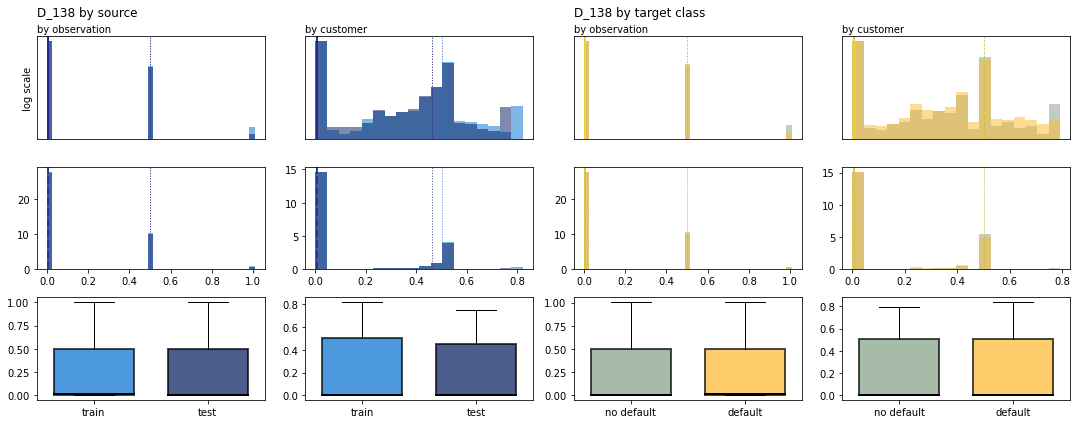


-

D_138
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00704           0.00697           0.00700           0.00706
              mean           0.16462           0.15697           0.15920           0.16812
               std           0.26702           0.25639           0.25679           0.27337
----------------------------------------------------------------------------------------------------
by_cust     median           0.00593           0.00591           0.00595           0.00592
              mean           0.16938           0.16197           0.16729           0.17083
               std           0.24342           0.23672           0.23939           0.24617
----------------------------------------------------------------------------------------------------
_________________________________________________

In [483]:
plot_next()

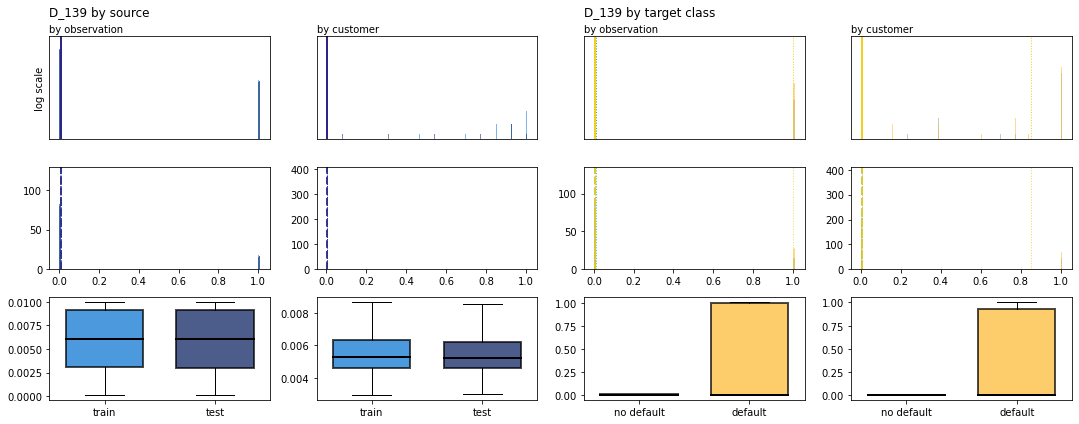


-

D_139
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00605           0.00606           0.00586           0.00674
              mean           0.17893           0.17961           0.15122           0.26337
               std           0.37906           0.37964           0.35334           0.43775
----------------------------------------------------------------------------------------------------
by_cust     median           0.00525           0.00525           0.00520           0.00543
              mean           0.18294           0.18256           0.15492           0.26301
               std           0.37773           0.37757           0.35203           0.43315
----------------------------------------------------------------------------------------------------
_________________________________________________

In [484]:
plot_next()

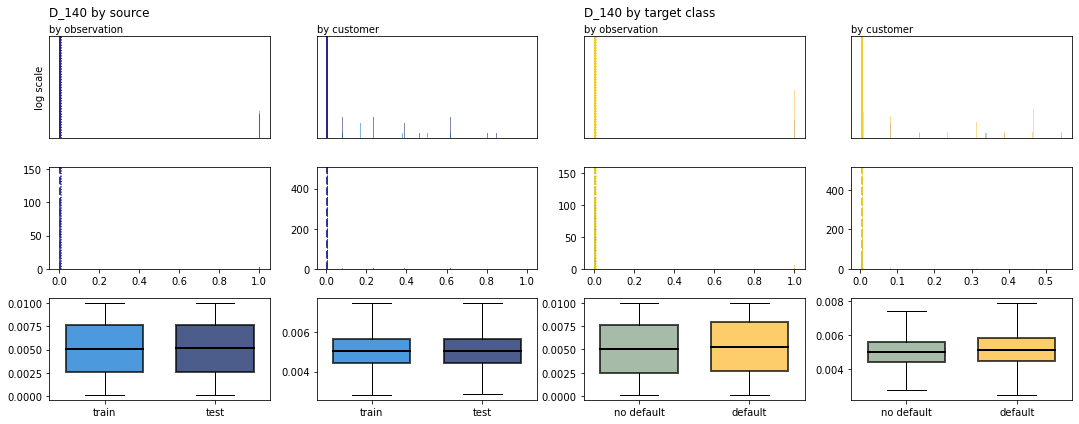


-

D_140
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00511           0.00511           0.00506           0.00527
              mean           0.02664           0.02770           0.01686           0.05632
               std           0.14555           0.14897           0.10830           0.22067
----------------------------------------------------------------------------------------------------
by_cust     median           0.00504           0.00504           0.00503           0.00510
              mean           0.02757           0.02820           0.01744           0.05656
               std           0.13120           0.13387           0.09597           0.19744
----------------------------------------------------------------------------------------------------
_________________________________________________

In [485]:
plot_next()

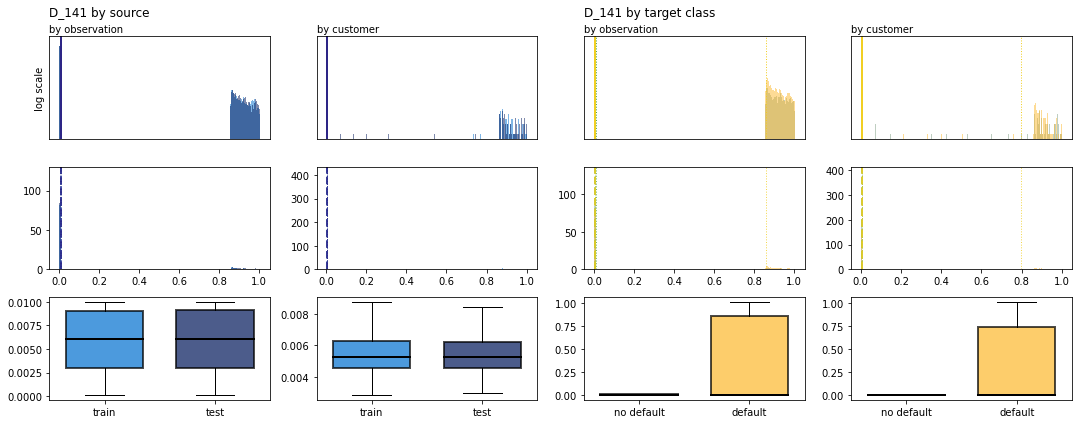


-

D_141
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00605           0.00606           0.00585           0.00675
              mean           0.16452           0.16558           0.13967           0.24026
               std           0.34828           0.34981           0.32597           0.39940
----------------------------------------------------------------------------------------------------
by_cust     median           0.00525           0.00525           0.00520           0.00542
              mean           0.16804           0.16819           0.14294           0.23979
               std           0.34672           0.34765           0.32444           0.39499
----------------------------------------------------------------------------------------------------
_________________________________________________

In [486]:
plot_next()

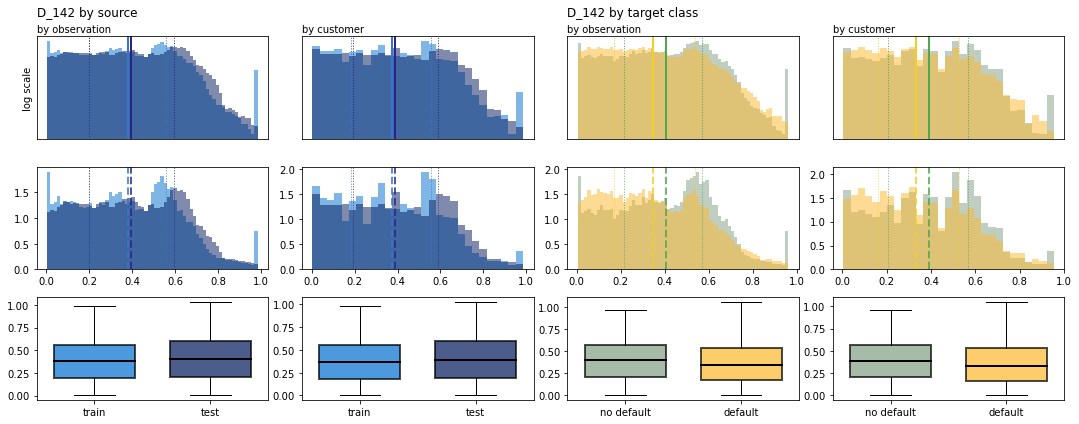


-

D_142
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.38214           0.39509           0.40444           0.34553
              mean           0.39080           0.40689           0.40163           0.37212
               std           0.23618           0.24843           0.22929           0.24651
----------------------------------------------------------------------------------------------------
by_cust     median           0.37357           0.38613           0.39004           0.33200
              mean           0.38247           0.40038           0.39310           0.36442
               std           0.23756           0.24935           0.23108           0.24714
----------------------------------------------------------------------------------------------------
_________________________________________________

In [487]:
plot_next()

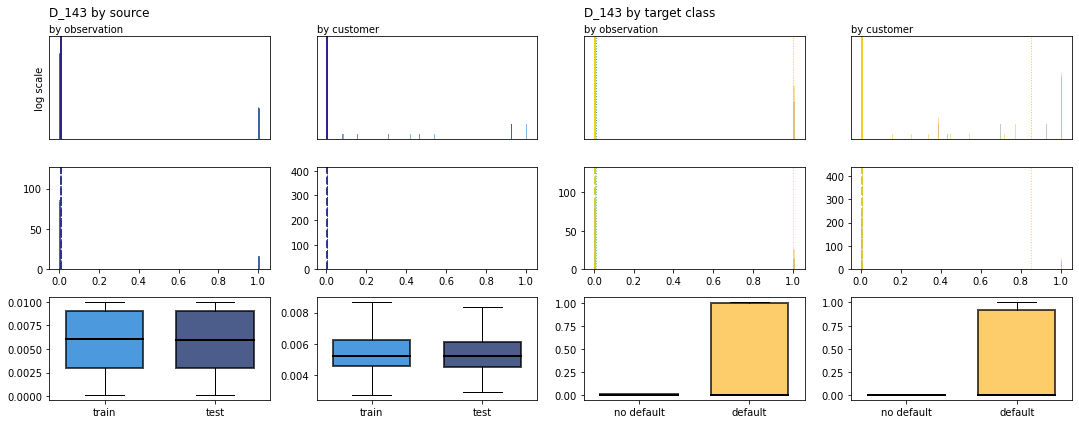


-

D_143
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00605           0.00605           0.00586           0.00674
              mean           0.17880           0.17949           0.15109           0.26324
               std           0.37895           0.37954           0.35321           0.43768
----------------------------------------------------------------------------------------------------
by_cust     median           0.00525           0.00524           0.00520           0.00542
              mean           0.18281           0.18244           0.15479           0.26289
               std           0.37763           0.37745           0.35191           0.43310
----------------------------------------------------------------------------------------------------
_________________________________________________

In [488]:
plot_next()

In [ ]:
D_143.dist_type = 'binary'
D_143.processing_steps['as binary'] = methodcaller('round')

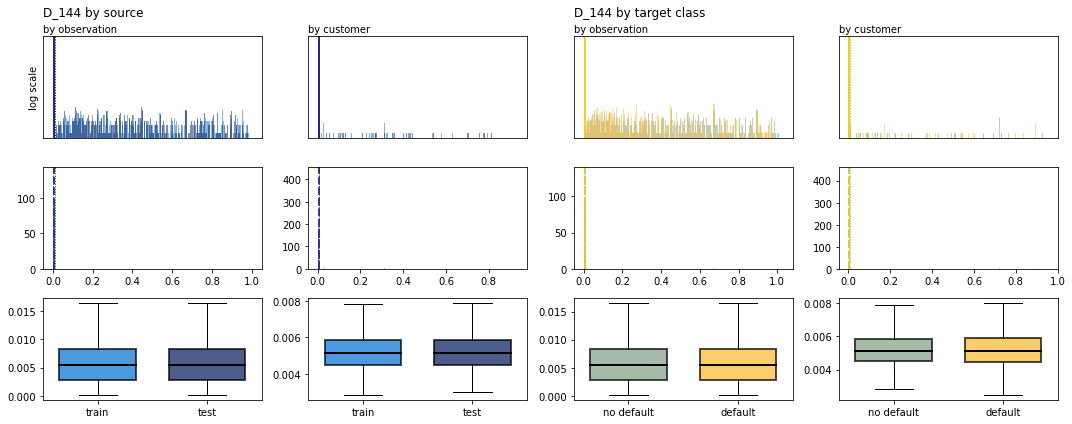


-

D_144
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00551           0.00550           0.00550           0.00554
              mean           0.05239           0.05199           0.05286           0.05095
               std           0.18251           0.18215           0.18449           0.17638
----------------------------------------------------------------------------------------------------
by_cust     median           0.00513           0.00513           0.00512           0.00514
              mean           0.05168           0.05161           0.05243           0.04953
               std           0.17322           0.17364           0.17538           0.16689
----------------------------------------------------------------------------------------------------
_________________________________________________

In [489]:
plot_next()

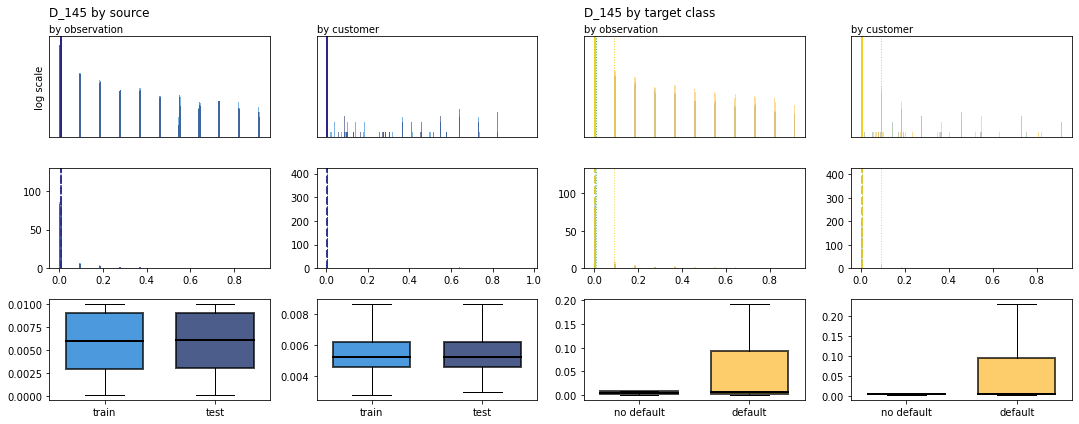


-

D_145
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00605           0.00606           0.00586           0.00674
              mean           0.06233           0.06378           0.04945           0.10159
               std           0.19349           0.19737           0.16368           0.26047
----------------------------------------------------------------------------------------------------
by_cust     median           0.00525           0.00524           0.00521           0.00542
              mean           0.06415           0.06514           0.05110           0.10144
               std           0.19486           0.19811           0.16550           0.25755
----------------------------------------------------------------------------------------------------
_________________________________________________

In [490]:
plot_next()

#### Payment Features

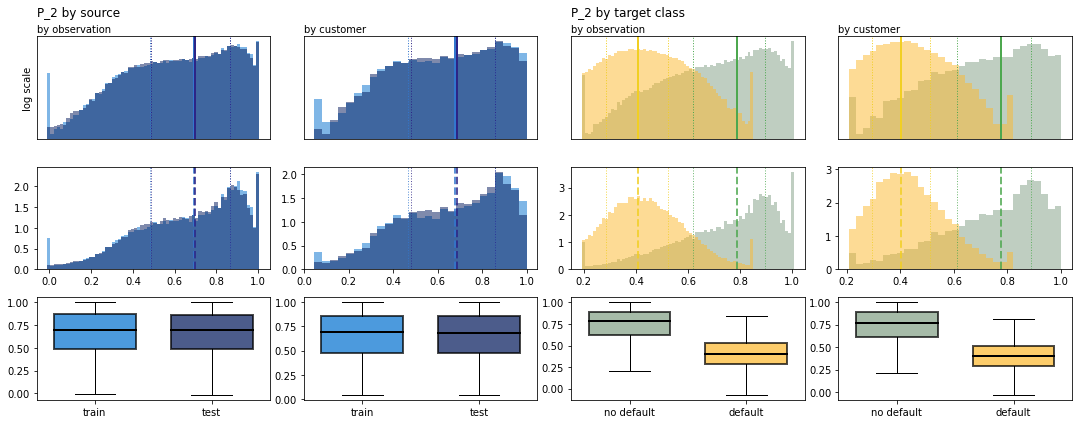


-

P_2
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.69429           0.69877           0.78619           0.40695
              mean           0.65633           0.65769           0.74238           0.39686
               std           0.24465           0.24689           0.19344           0.19456
----------------------------------------------------------------------------------------------------
by_cust     median           0.67850           0.68828           0.77711           0.40130
              mean           0.64833           0.65311           0.73613           0.39768
               std           0.23656           0.23761           0.18879           0.17070
----------------------------------------------------------------------------------------------------
___________________________________________________

In [491]:
plot_next()

In [ ]:
P_2.dist_type = 'multimodal'
P_2.subset_dist_types['default'] = 'Tukey-Lambda'
P_2.subset_dist_types['no default'] = 'lognormal, chi square'

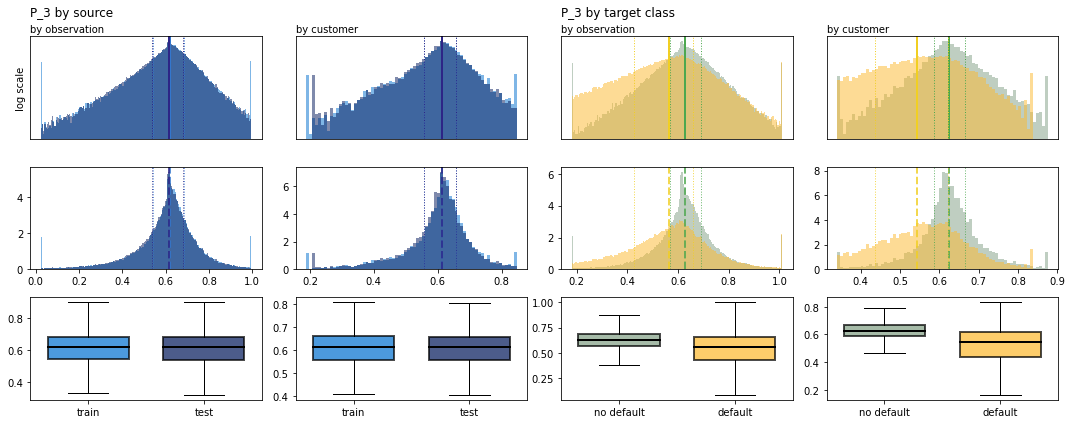


-

P_3
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.61830           0.61633           0.62720           0.56224
              mean           0.60129           0.59893           0.62455           0.52677
               std           0.17080           0.17172           0.14197           0.22534
----------------------------------------------------------------------------------------------------
by_cust     median           0.61362           0.61194           0.62359           0.54363
              mean           0.59666           0.59631           0.62360           0.51784
               std           0.12143           0.11739           0.09110           0.15897
----------------------------------------------------------------------------------------------------
___________________________________________________

In [492]:
plot_next()

In [ ]:
P_3.dist_type = 'double exponential'

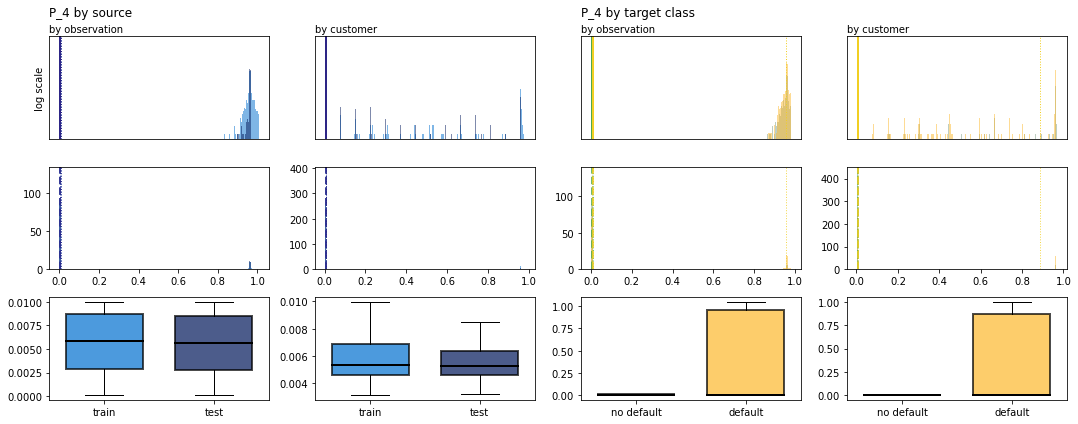


-

P_4
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00585           0.00568           0.00554           0.00703
              mean           0.14393           0.11996           0.09765           0.28342
               std           0.33827           0.31119           0.28315           0.43792
----------------------------------------------------------------------------------------------------
by_cust     median           0.00535           0.00529           0.00522           0.00620
              mean           0.18833           0.16033           0.13439           0.34270
               std           0.34996           0.32504           0.30653           0.41460
----------------------------------------------------------------------------------------------------
___________________________________________________

In [493]:
plot_next()

In [ ]:
P_4.dist_type = 'multimodal, unknown'

#### Risk Features

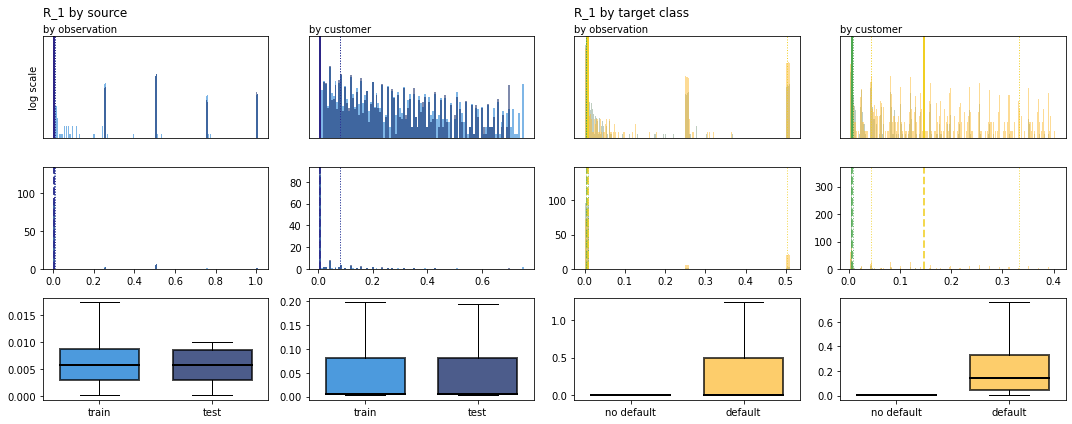


-

R_1
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00578           0.00569           0.00535           0.00767
              mean           0.07880           0.07490           0.03121           0.22228
               std           0.22640           0.21606           0.12211           0.36525
----------------------------------------------------------------------------------------------------
by_cust     median           0.00585           0.00567           0.00541           0.14665
              mean           0.08019           0.07474           0.03143           0.21976
               std           0.15831           0.14929           0.07473           0.23349
----------------------------------------------------------------------------------------------------
___________________________________________________

In [494]:
plot_next()

In [ ]:
R_1.dist_type = 'Poisson'

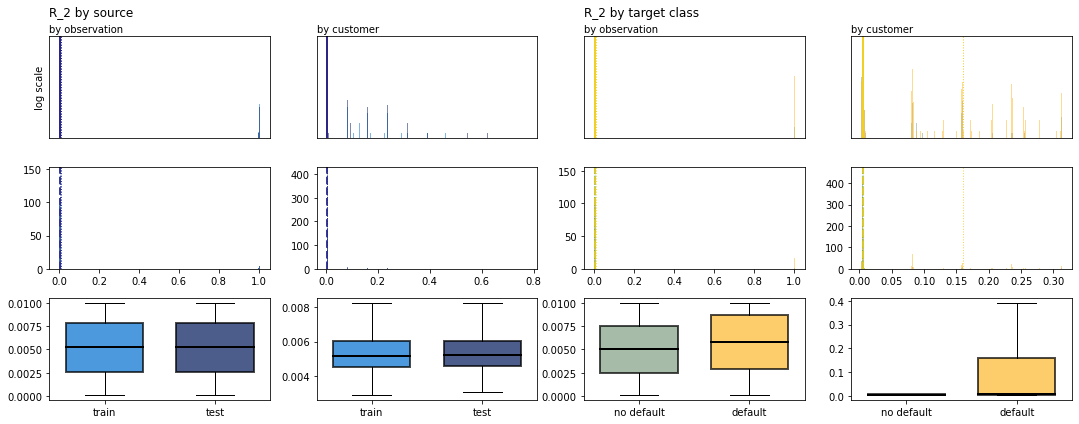


-

R_2
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00522           0.00522           0.00506           0.00579
              mean           0.04752           0.04721           0.01687           0.13992
               std           0.20178           0.20108           0.10832           0.34164
----------------------------------------------------------------------------------------------------
by_cust     median           0.00519           0.00519           0.00507           0.00597
              mean           0.04781           0.04665           0.01684           0.13645
               std           0.13705           0.13335           0.06564           0.22272
----------------------------------------------------------------------------------------------------
___________________________________________________

In [495]:
plot_next()

In [ ]:
R_2.dist_type = 'binary'
R_2.processing_steps['as binary'] = methodcaller('round')

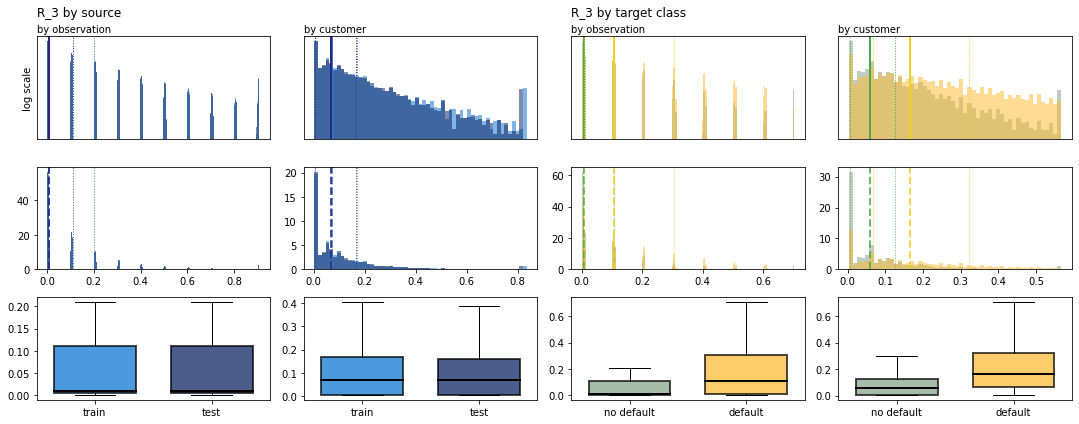


-

R_3
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00940           0.00924           0.00842           0.10743
              mean           0.12083           0.11572           0.08606           0.22565
               std           0.21052           0.19901           0.14497           0.31610
----------------------------------------------------------------------------------------------------
by_cust     median           0.07293           0.06728           0.05820           0.16606
              mean           0.13080           0.12341           0.09226           0.24108
               std           0.18721           0.17147           0.12407           0.27365
----------------------------------------------------------------------------------------------------
___________________________________________________

In [496]:
plot_next()

In [ ]:
R_3.dist_type = 'Poisson'

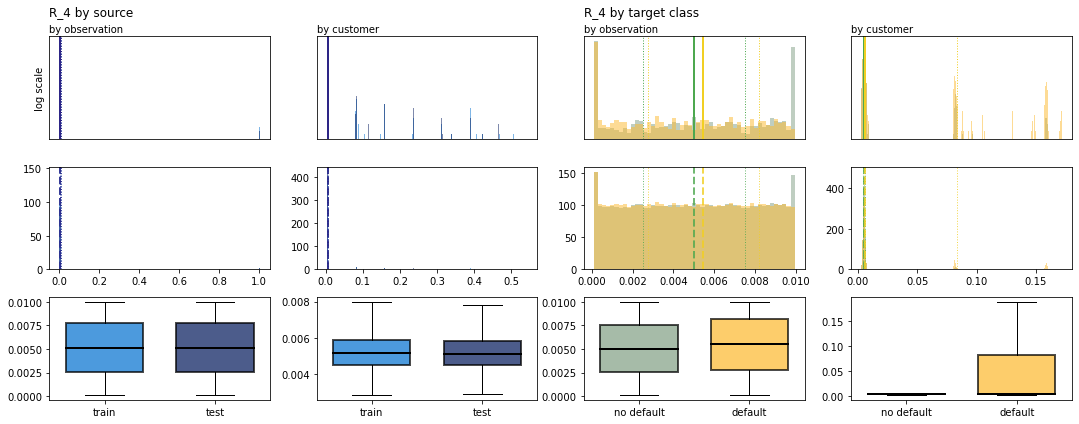


-

R_4
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00513           0.00513           0.00503           0.00548
              mean           0.03120           0.03143           0.01086           0.09253
               std           0.15977           0.16045           0.07638           0.28263
----------------------------------------------------------------------------------------------------
by_cust     median           0.00514           0.00514           0.00504           0.00559
              mean           0.03136           0.03103           0.01079           0.09023
               std           0.09644           0.09443           0.03770           0.16486
----------------------------------------------------------------------------------------------------
___________________________________________________

In [497]:
plot_next()

In [ ]:
R_4.dist_type = 'binary'
R_4.processing_steps = methodcaller('round')

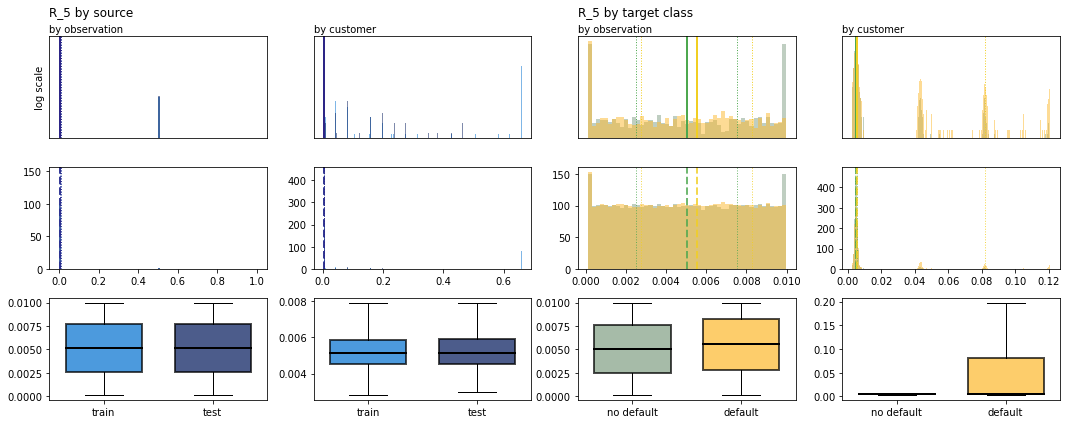


-

R_5
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00515           0.00515           0.00504           0.00552
              mean           0.03459           0.03425           0.00985           0.10918
               std           0.25681           0.24727           0.07831           0.48873
----------------------------------------------------------------------------------------------------
by_cust     median           0.00515           0.00514           0.00505           0.00562
              mean           0.03516           0.03372           0.00978           0.10779
               std           0.16114           0.13662           0.04024           0.29754
----------------------------------------------------------------------------------------------------
___________________________________________________

In [498]:
plot_next()

In [ ]:
R_5.dist_type = 'Poisson'

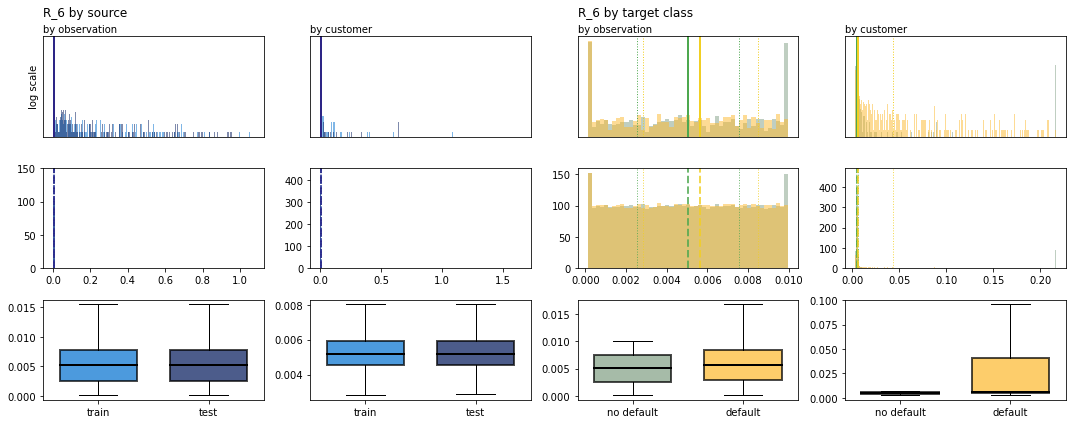


-

R_6
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00519           0.00519           0.00505           0.00565
              mean           0.05853           0.05483           0.01855           0.17905
               std           0.64157           0.60775           0.33847           1.13477
----------------------------------------------------------------------------------------------------
by_cust     median           0.00517           0.00516           0.00506           0.00574
              mean           0.05967           0.05428           0.01858           0.17725
               std           0.38794           0.34085           0.18150           0.68432
----------------------------------------------------------------------------------------------------
___________________________________________________

In [499]:
plot_next()

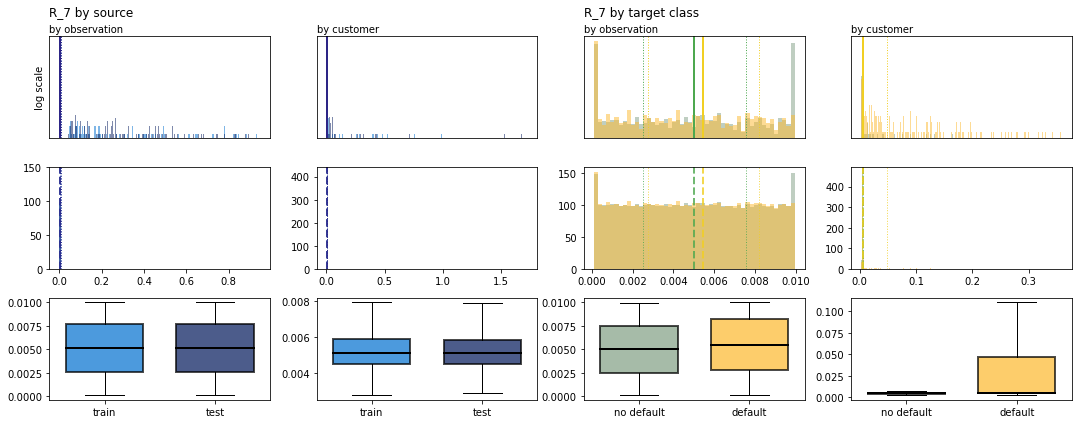


-

R_7
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00514           0.00514           0.00503           0.00548
              mean           0.08806           0.08495           0.03135           0.25903
               std           1.55087           1.54065           1.00510           2.56348
----------------------------------------------------------------------------------------------------
by_cust     median           0.00514           0.00514           0.00504           0.00560
              mean           0.08784           0.08350           0.03105           0.25037
               std           0.76150           0.73455           0.44828           1.27621
----------------------------------------------------------------------------------------------------
___________________________________________________

In [500]:
plot_next()

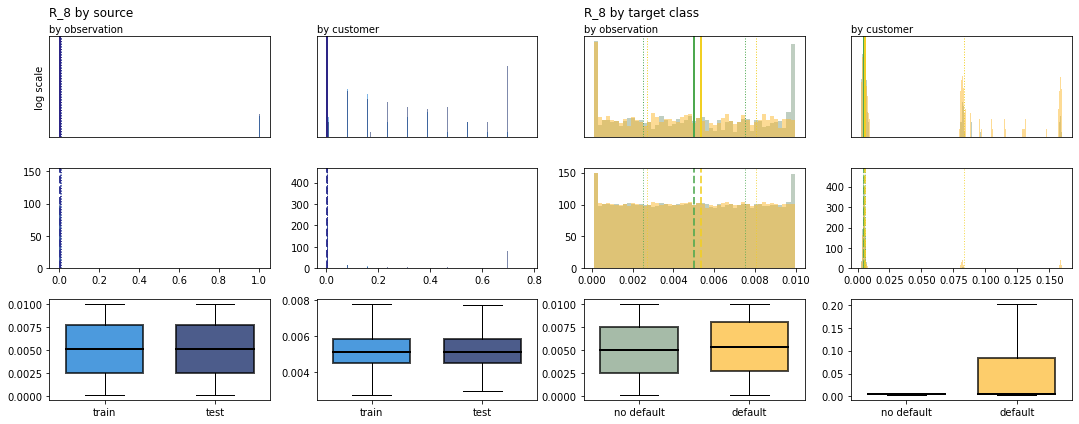


-

R_8
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00511           0.00511           0.00503           0.00536
              mean           0.03812           0.03716           0.01117           0.11935
               std           0.30364           0.28684           0.09932           0.57585
----------------------------------------------------------------------------------------------------
by_cust     median           0.00513           0.00513           0.00504           0.00556
              mean           0.03871           0.03670           0.01110           0.11774
               std           0.16454           0.13568           0.04469           0.30069
----------------------------------------------------------------------------------------------------
___________________________________________________

In [501]:
plot_next()

In [ ]:
R_8.dist_type = 'binary'
R_8.processing_steps['as binary'] = methodcaller('round')

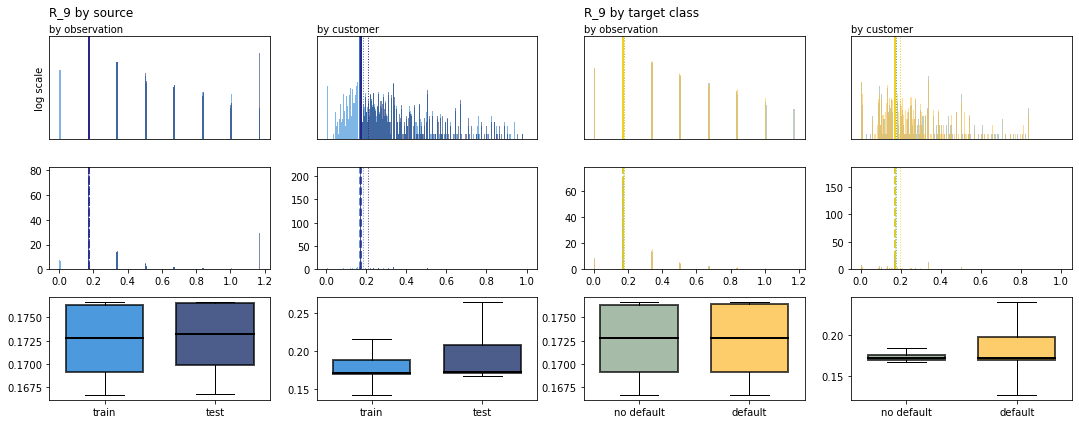


-

R_9
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.17275           0.17327           0.17276           0.17274
              mean           0.22989           0.24884           0.23346           0.22729
               std           0.18917           0.18606           0.19914           0.18154
----------------------------------------------------------------------------------------------------
by_cust     median           0.17180           0.17224           0.17178           0.17182
              mean           0.21119           0.23439           0.21375           0.20938
               std           0.15760           0.15937           0.16914           0.14890
----------------------------------------------------------------------------------------------------
___________________________________________________

In [502]:
plot_next()

In [ ]:
R_9.dist_type = 'Poisson'

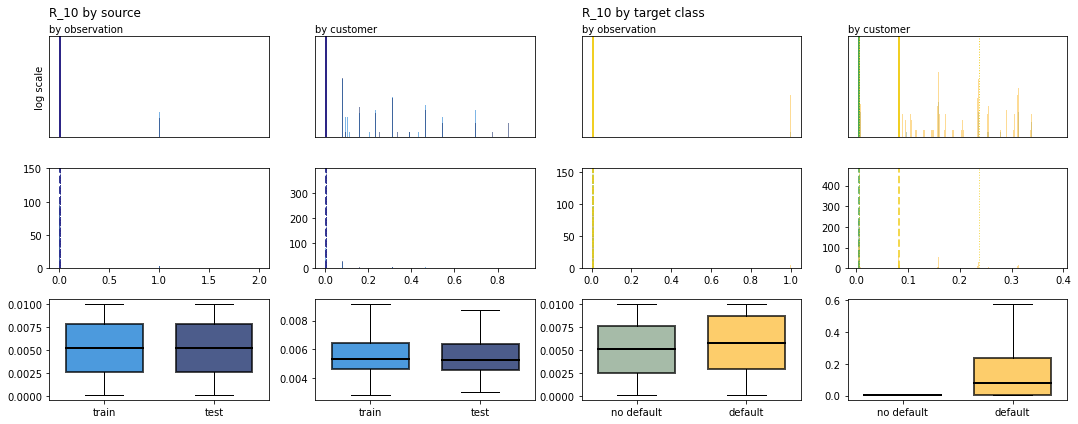


-

R_10
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00525           0.00525           0.00508           0.00581
              mean           0.06478           0.06542           0.02343           0.18942
               std           0.30569           0.30965           0.15367           0.53223
----------------------------------------------------------------------------------------------------
by_cust     median           0.00530           0.00528           0.00511           0.08169
              mean           0.06559           0.06500           0.02356           0.18587
               std           0.17644           0.17458           0.08195           0.28545
----------------------------------------------------------------------------------------------------
__________________________________________________

In [503]:
plot_next()

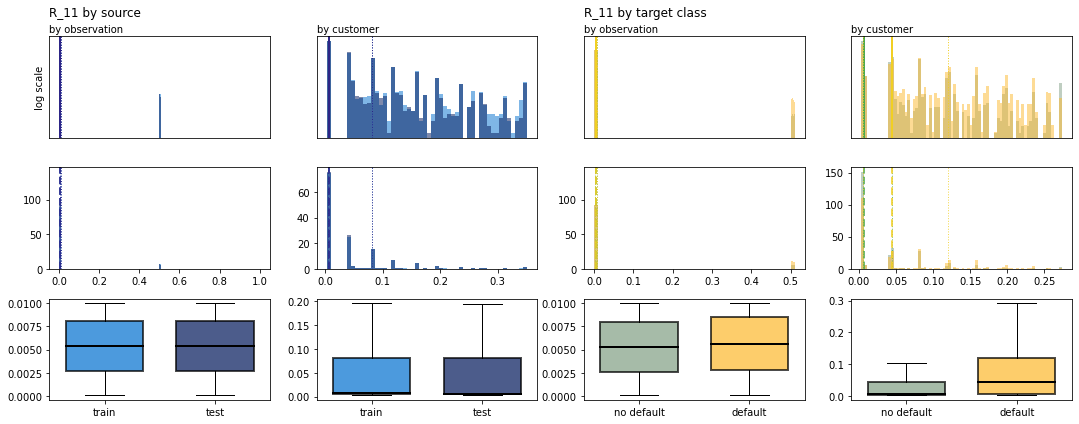


-

R_11
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00541           0.00539           0.00533           0.00567
              mean           0.05083           0.04822           0.04114           0.08004
               std           0.17562           0.17011           0.15008           0.23407
----------------------------------------------------------------------------------------------------
by_cust     median           0.00660           0.00636           0.00604           0.04386
              mean           0.05286           0.04944           0.04190           0.08424
               std           0.08294           0.07592           0.06350           0.11703
----------------------------------------------------------------------------------------------------
__________________________________________________

In [504]:
plot_next()

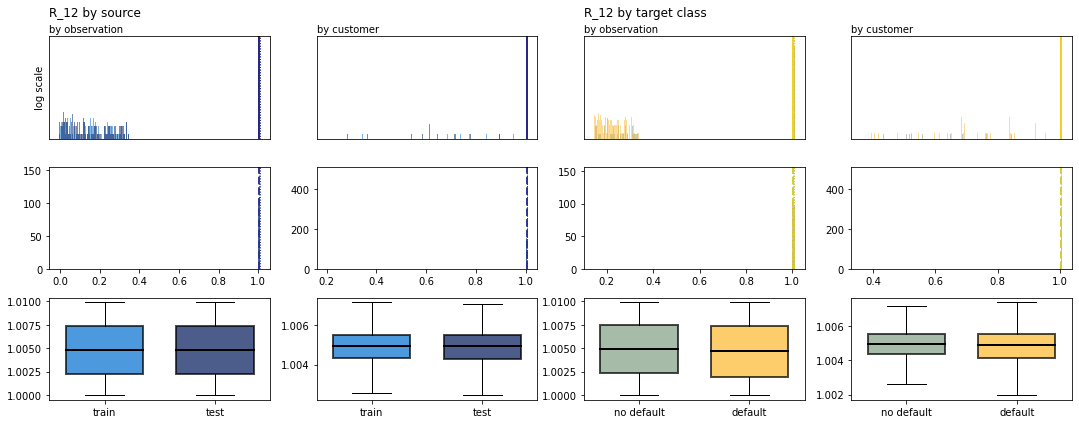


-

R_12
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           1.00486           1.00483           1.00492           1.00465
              mean           0.97922           0.97430           0.99121           0.94308
               std           0.15374           0.16729           0.11164           0.23576
----------------------------------------------------------------------------------------------------
by_cust     median           1.00494           1.00494           1.00497           1.00486
              mean           0.98006           0.97512           0.99166           0.94687
               std           0.12616           0.13907           0.09211           0.18894
----------------------------------------------------------------------------------------------------
__________________________________________________

In [505]:
plot_next()

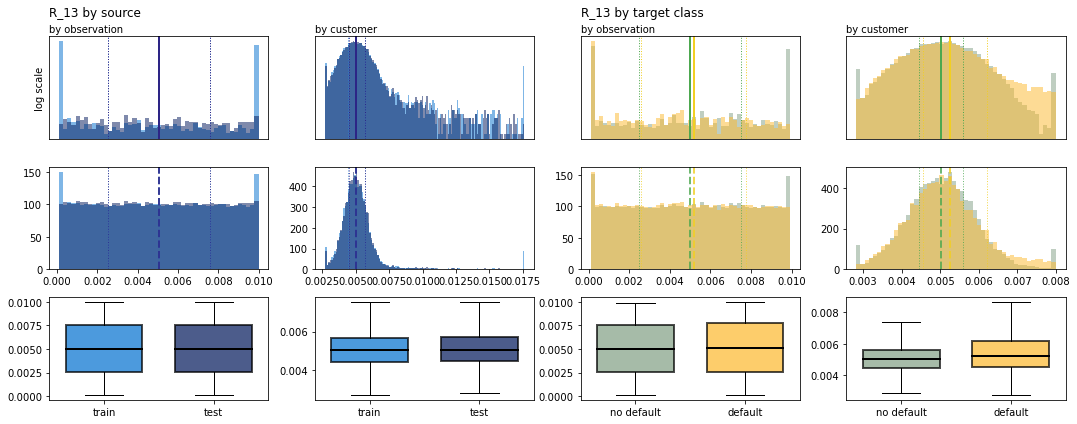


-

R_13
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00504           0.00505           0.00500           0.00517
              mean           0.00548           0.00547           0.00506           0.00675
               std           0.00728           0.00703           0.00354           0.01314
----------------------------------------------------------------------------------------------------
by_cust     median           0.00506           0.00506           0.00501           0.00524
              mean           0.00550           0.00546           0.00506           0.00674
               std           0.00384           0.00296           0.00127           0.00708
----------------------------------------------------------------------------------------------------
__________________________________________________

In [506]:
plot_next()

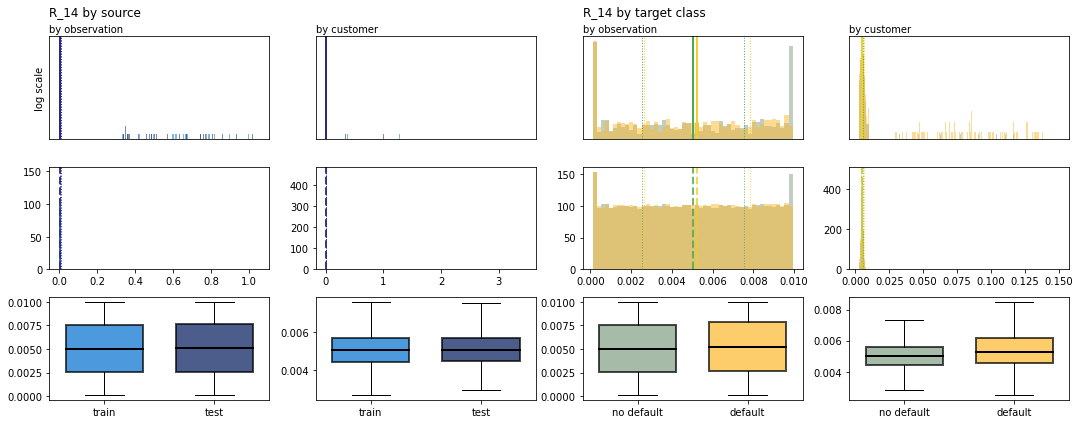


-

R_14
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00507           0.00507           0.00502           0.00522
              mean           0.24144           0.20921           0.07439           0.74500
               std           8.35645           7.04601           4.95710          14.34996
----------------------------------------------------------------------------------------------------
by_cust     median           0.00507           0.00507           0.00502           0.00523
              mean           0.23662           0.20393           0.07392           0.70228
               std           5.31763           4.07536           3.25116           8.86922
----------------------------------------------------------------------------------------------------
__________________________________________________

In [507]:
plot_next()

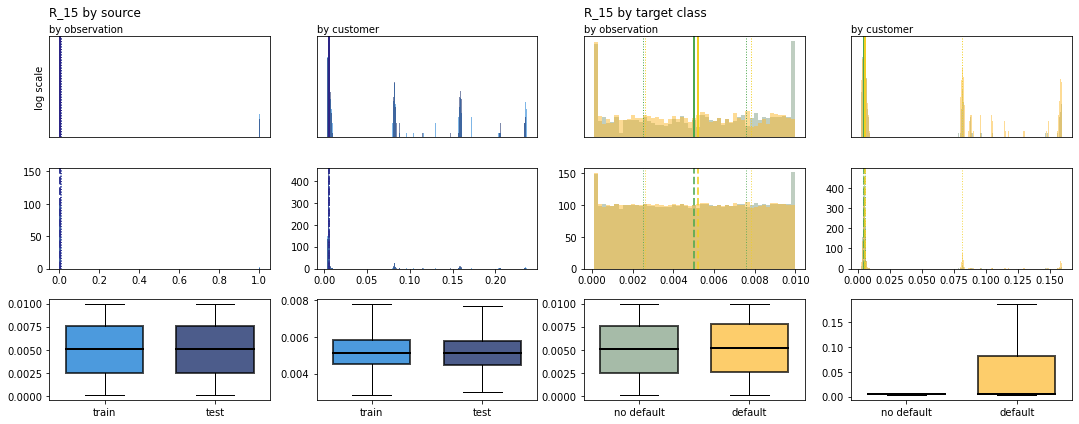


-

R_15
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00508           0.00507           0.00503           0.00523
              mean           0.02028           0.01908           0.01111           0.04793
               std           0.12271           0.11788           0.07798           0.20274
----------------------------------------------------------------------------------------------------
by_cust     median           0.00513           0.00512           0.00505           0.00545
              mean           0.02089           0.01951           0.01125           0.04848
               std           0.05534           0.05066           0.03261           0.08807
----------------------------------------------------------------------------------------------------
__________________________________________________

In [508]:
plot_next()

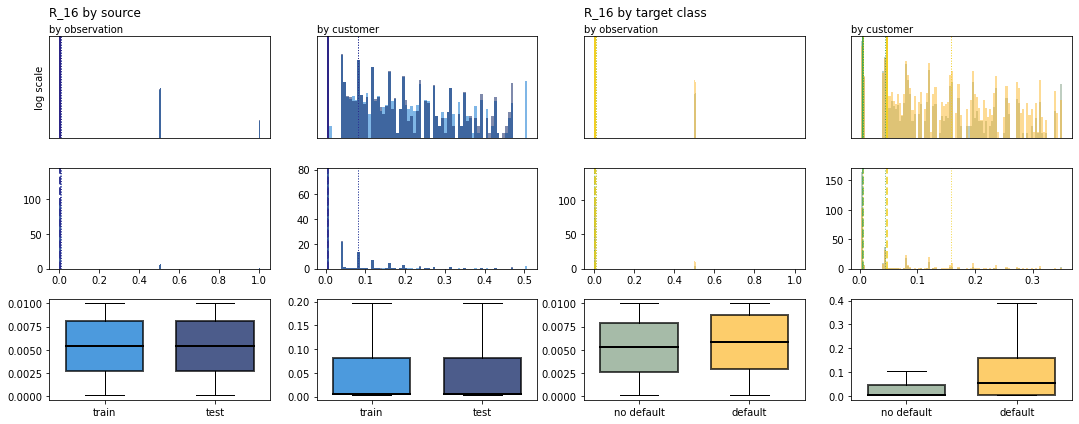


-

R_16
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00541           0.00541           0.00530           0.00579
              mean           0.05854           0.05882           0.04061           0.11259
               std           0.23925           0.23898           0.17448           0.36623
----------------------------------------------------------------------------------------------------
by_cust     median           0.00625           0.00631           0.00579           0.04694
              mean           0.06148           0.06042           0.04164           0.11824
               std           0.12086           0.11148           0.07664           0.18775
----------------------------------------------------------------------------------------------------
__________________________________________________

In [509]:
plot_next()

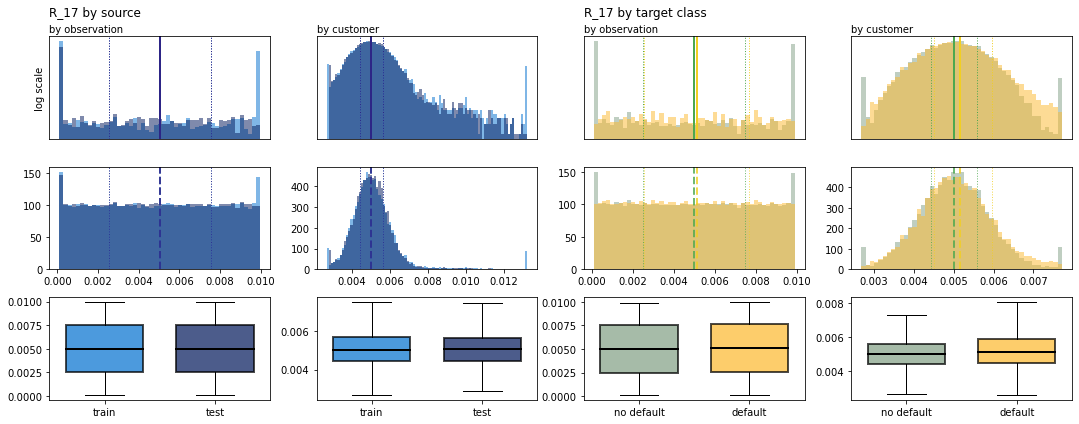


-

R_17
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00503           0.00503           0.00500           0.00511
              mean           0.00532           0.00533           0.00505           0.00614
               std           0.00638           0.00662           0.00364           0.01108
----------------------------------------------------------------------------------------------------
by_cust     median           0.00504           0.00504           0.00501           0.00517
              mean           0.00532           0.00533           0.00504           0.00611
               std           0.00291           0.00267           0.00123           0.00524
----------------------------------------------------------------------------------------------------
__________________________________________________

In [510]:
plot_next()

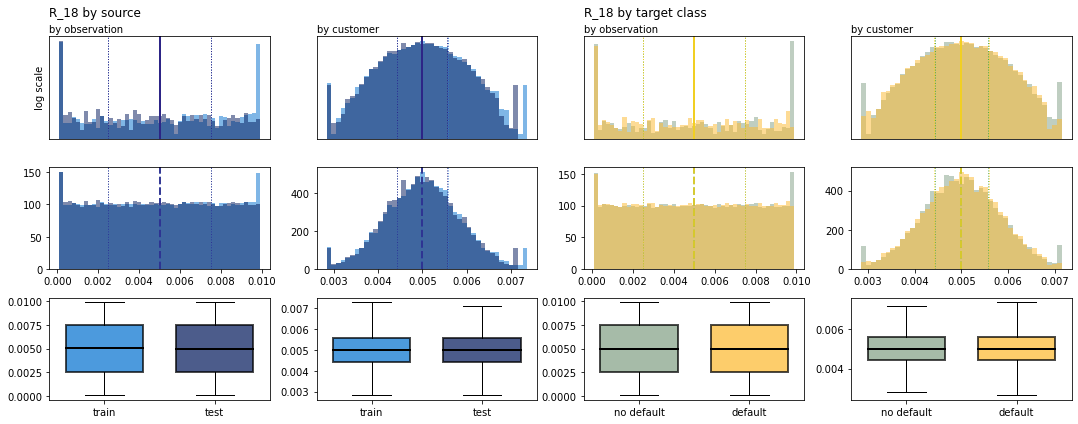


-

R_18
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00500           0.00500           0.00500           0.00500
              mean           0.00501           0.00501           0.00501           0.00502
               std           0.00324           0.00319           0.00306           0.00373
----------------------------------------------------------------------------------------------------
by_cust     median           0.00500           0.00500           0.00500           0.00500
              mean           0.00501           0.00501           0.00500           0.00502
               std           0.00134           0.00108           0.00102           0.00198
----------------------------------------------------------------------------------------------------
__________________________________________________

In [511]:
plot_next()

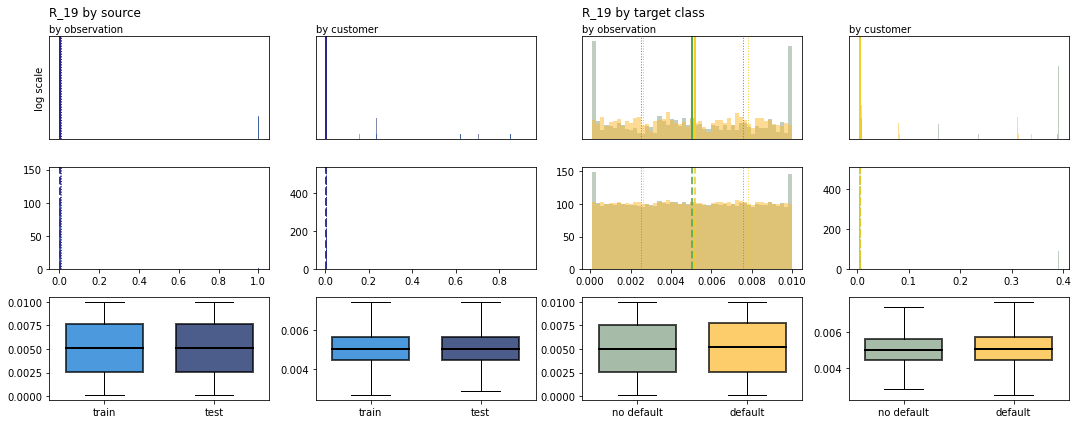


-

R_19
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00509           0.00510           0.00505           0.00521
              mean           0.02270           0.02492           0.01495           0.04605
               std           0.13187           0.13975           0.09928           0.19842
----------------------------------------------------------------------------------------------------
by_cust     median           0.00503           0.00504           0.00502           0.00508
              mean           0.02200           0.02399           0.01458           0.04324
               std           0.11531           0.12163           0.08620           0.17168
----------------------------------------------------------------------------------------------------
__________________________________________________

In [512]:
plot_next()

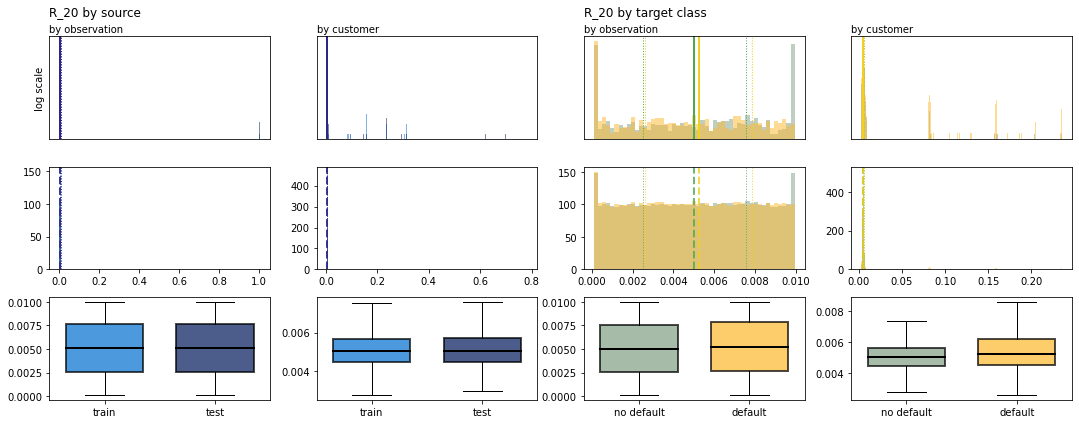


-

R_20
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00508           0.00508           0.00502           0.00524
              mean           0.03695           0.03825           0.01281           0.10969
               std           0.37806           0.39603           0.16294           0.69766
----------------------------------------------------------------------------------------------------
by_cust     median           0.00507           0.00507           0.00502           0.00523
              mean           0.03662           0.03741           0.01288           0.10454
               std           0.22242           0.22410           0.09581           0.39820
----------------------------------------------------------------------------------------------------
__________________________________________________

In [513]:
plot_next()

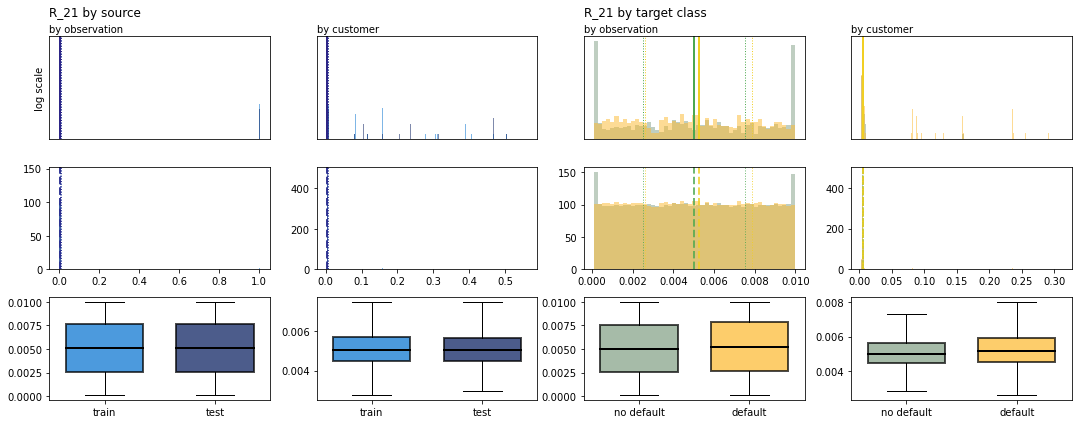


-

R_21
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00508           0.00507           0.00502           0.00526
              mean           0.02161           0.01906           0.01031           0.05566
               std           0.12785           0.11778           0.07278           0.21933
----------------------------------------------------------------------------------------------------
by_cust     median           0.00505           0.00504           0.00502           0.00515
              mean           0.02305           0.01959           0.01060           0.05870
               std           0.10172           0.08925           0.05449           0.17248
----------------------------------------------------------------------------------------------------
__________________________________________________

In [514]:
plot_next()

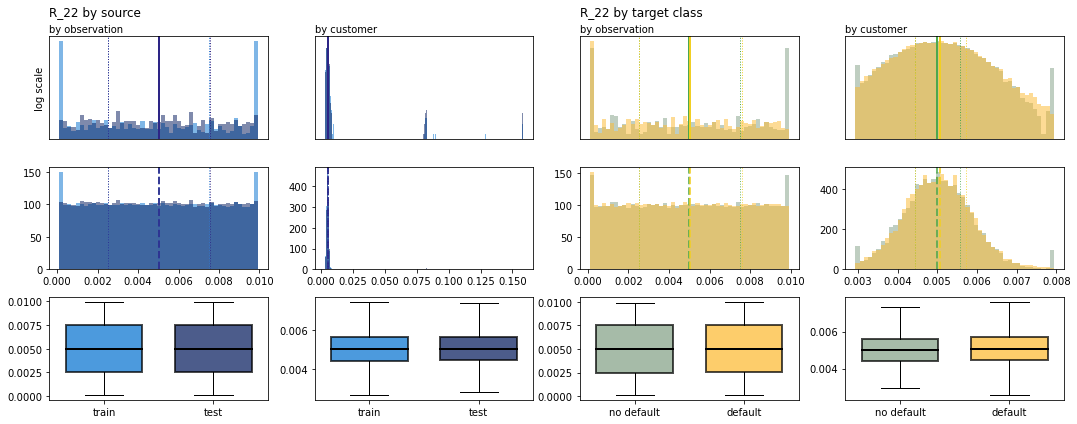


-

R_22
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00502           0.00502           0.00501           0.00505
              mean           0.00860           0.00906           0.00637           0.01533
               std           0.06001           0.06365           0.03718           0.10114
----------------------------------------------------------------------------------------------------
by_cust     median           0.00502           0.00502           0.00501           0.00506
              mean           0.00844           0.00890           0.00633           0.01449
               std           0.02767           0.02923           0.01738           0.04520
----------------------------------------------------------------------------------------------------
__________________________________________________

In [515]:
plot_next()

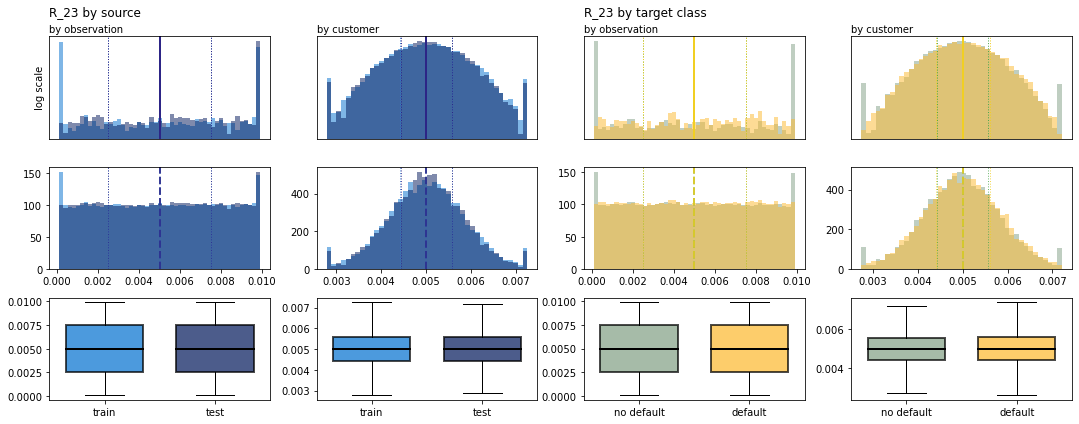


-

R_23
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00500           0.00500           0.00500           0.00500
              mean           0.00530           0.00503           0.00513           0.00578
               std           0.01744           0.00589           0.01192           0.02814
----------------------------------------------------------------------------------------------------
by_cust     median           0.00500           0.00500           0.00500           0.00500
              mean           0.00528           0.00503           0.00513           0.00572
               std           0.01101           0.00352           0.00753           0.01749
----------------------------------------------------------------------------------------------------
__________________________________________________

In [516]:
plot_next()

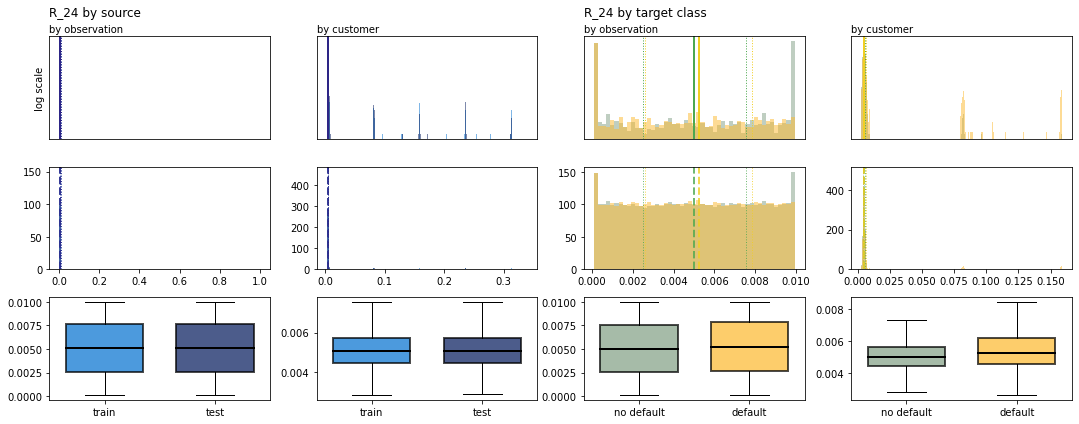


-

R_24
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00507           0.00507           0.00502           0.00523
              mean           0.01892           0.01894           0.00881           0.04940
               std           0.11719           0.11729           0.06165           0.20600
----------------------------------------------------------------------------------------------------
by_cust     median           0.00506           0.00507           0.00502           0.00522
              mean           0.01891           0.01868           0.00887           0.04763
               std           0.07440           0.07034           0.03811           0.12692
----------------------------------------------------------------------------------------------------
__________________________________________________

In [517]:
plot_next()

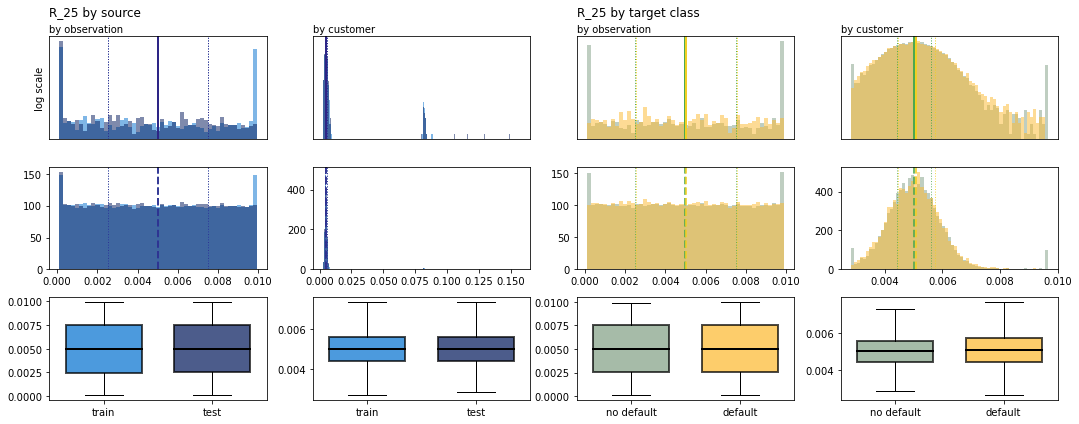


-

R_25
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00502           0.00502           0.00500           0.00505
              mean           0.00821           0.00880           0.00615           0.01441
               std           0.05660           0.06155           0.03399           0.09658
----------------------------------------------------------------------------------------------------
by_cust     median           0.00503           0.00503           0.00501           0.00507
              mean           0.00826           0.00881           0.00617           0.01427
               std           0.02652           0.02851           0.01426           0.04568
----------------------------------------------------------------------------------------------------
__________________________________________________

In [518]:
plot_next()

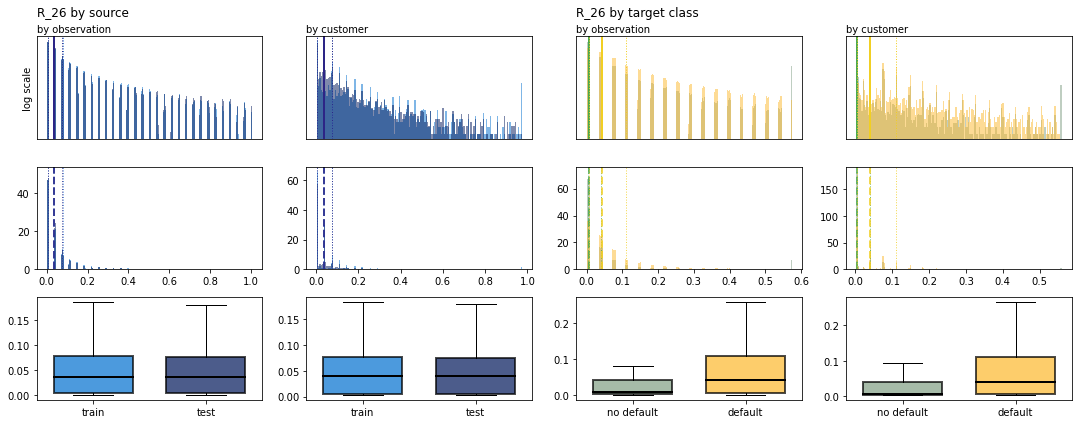


-

R_26
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.03685           0.03687           0.00755           0.04216
              mean           0.08465           0.08533           0.04614           0.11257
               std           0.24433           0.27250           0.14736           0.29220
----------------------------------------------------------------------------------------------------
by_cust     median           0.03962           0.03945           0.00567           0.04108
              mean           0.08548           0.08297           0.04729           0.11215
               std           0.24108           0.24892           0.14799           0.28582
----------------------------------------------------------------------------------------------------
__________________________________________________

In [519]:
plot_next()

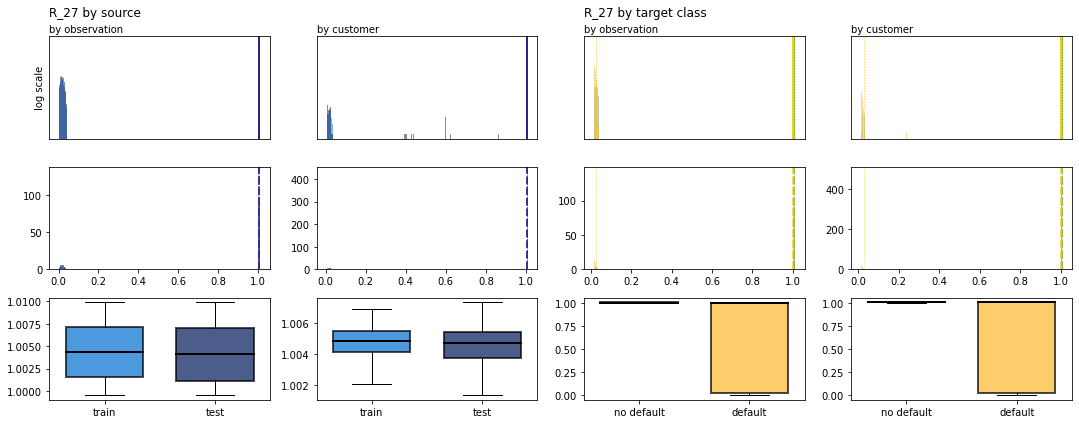


-

R_27
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           1.00436           1.00413           1.00466           1.00321
              mean           0.89369           0.85822           0.94326           0.74262
               std           0.31231           0.35135           0.23832           0.43749
----------------------------------------------------------------------------------------------------
by_cust     median           1.00486           1.00475           1.00493           1.00459
              mean           0.89000           0.85120           0.94155           0.73799
               std           0.31468           0.34263           0.24050           0.43533
----------------------------------------------------------------------------------------------------
__________________________________________________

In [520]:
plot_next()

In [ ]:
plt.hist(train_data.R_27[train_data.R_27 < 0.2], density=True);

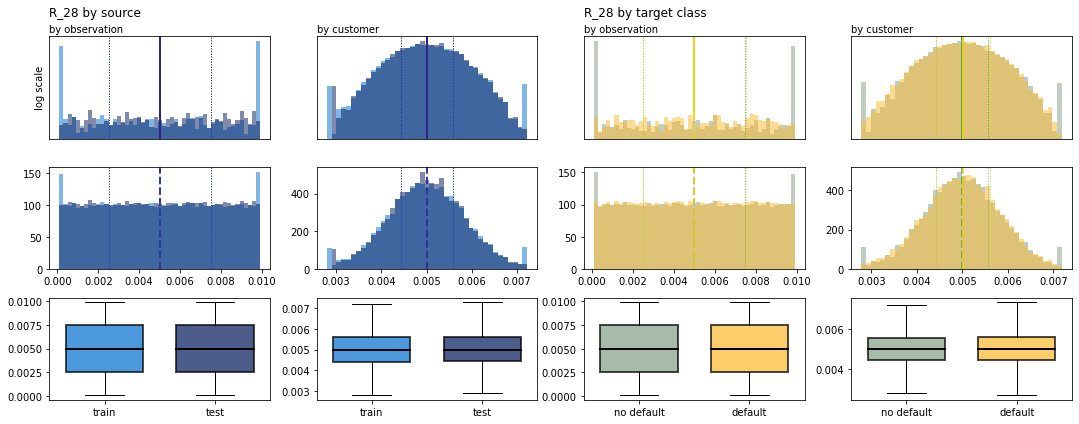


-

R_28
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00500           0.00501           0.00500           0.00501
              mean           0.00574           0.00588           0.00531           0.00704
               std           0.02738           0.02980           0.01793           0.04514
----------------------------------------------------------------------------------------------------
by_cust     median           0.00500           0.00500           0.00500           0.00501
              mean           0.00608           0.00604           0.00550           0.00773
               std           0.02687           0.02373           0.01874           0.04219
----------------------------------------------------------------------------------------------------
__________________________________________________

In [521]:
plot_next()

In [ ]:
R_28.dist_type = 'uniform'

#### Spend Features

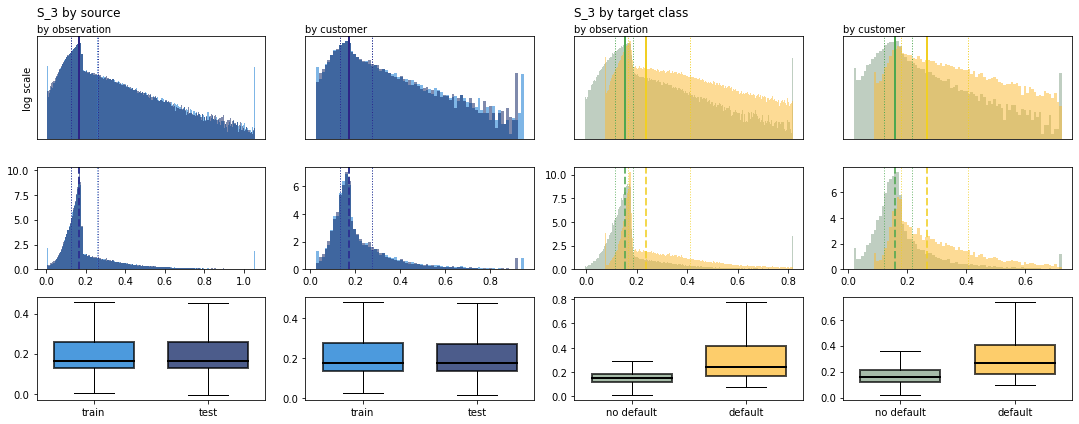


-

S_3
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.16391           0.16427           0.15213           0.23768
              mean           0.22585           0.22740           0.18676           0.32567
               std           0.19335           0.19883           0.15136           0.24592
----------------------------------------------------------------------------------------------------
by_cust     median           0.17390           0.17438           0.15912           0.26569
              mean           0.23053           0.22993           0.19132           0.32779
               std           0.17030           0.17188           0.13261           0.20989
----------------------------------------------------------------------------------------------------
___________________________________________________

In [522]:
plot_next()

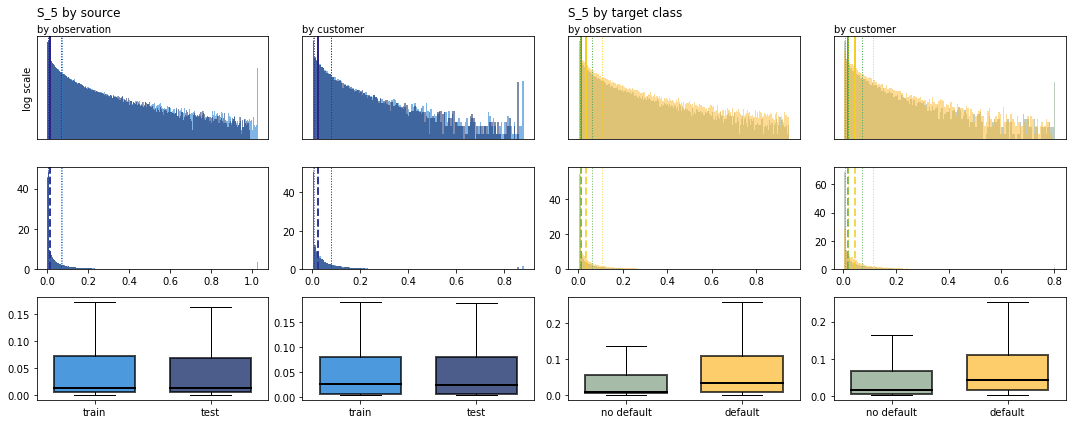


-

S_5
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.01352           0.01388           0.00963           0.03303
              mean           0.08811           0.08845           0.07760           0.11977
               std           0.40741           0.49285           0.39818           0.43249
----------------------------------------------------------------------------------------------------
by_cust     median           0.02464           0.02450           0.01775           0.04425
              mean           0.08582           0.08679           0.07576           0.11459
               std           0.30809           0.35151           0.29217           0.34807
----------------------------------------------------------------------------------------------------
___________________________________________________

In [523]:
plot_next()

In [ ]:
S_5.dist_type = 'exponential'

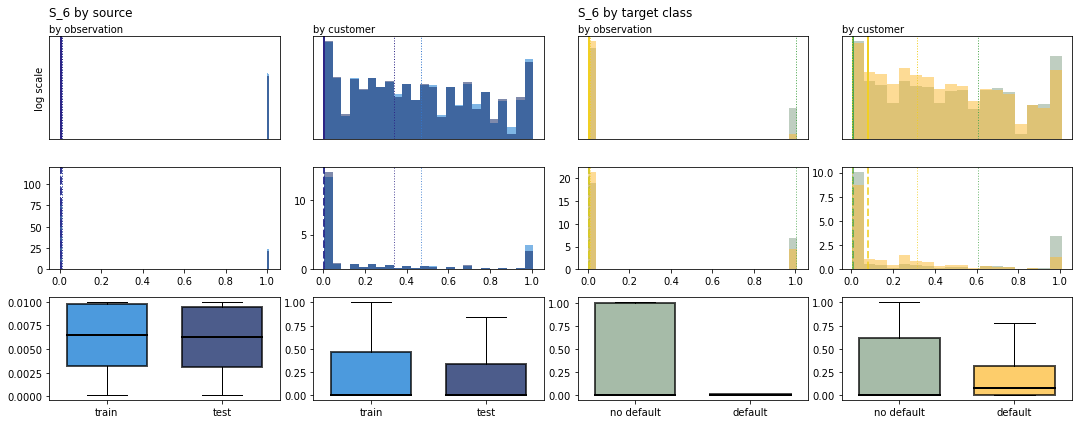


-

S_6
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00657           0.00628           0.00679           0.00600
              mean           0.24419           0.20939           0.26850           0.17090
               std           0.42660           0.40327           0.44054           0.37201
----------------------------------------------------------------------------------------------------
by_cust     median           0.00612           0.00581           0.00599           0.08087
              mean           0.27279           0.22914           0.29199           0.21782
               std           0.37622           0.34840           0.39818           0.29798
----------------------------------------------------------------------------------------------------
___________________________________________________

In [524]:
plot_next()

In [580]:
S_6.dist_type = 'binary'
S_6.processing_steps['as binary'] = methodcaller('round')

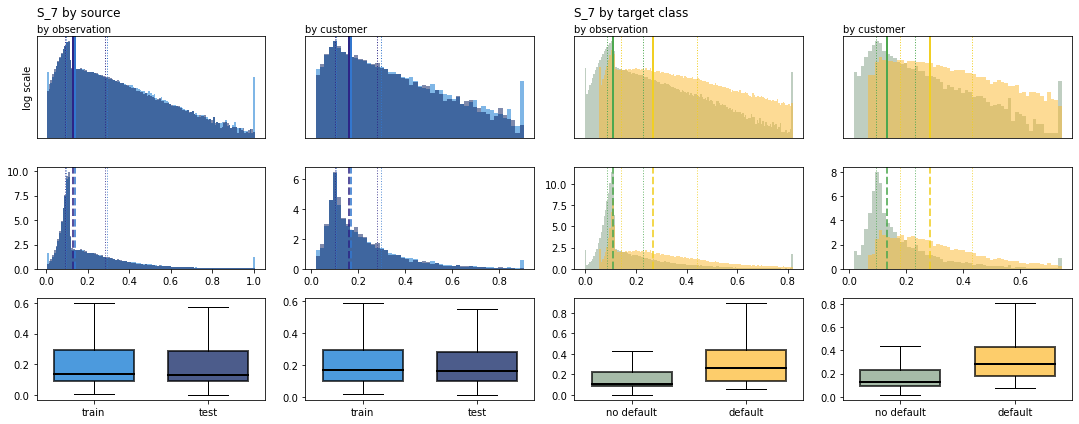


-

S_7
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.13970           0.13121           0.11028           0.26864
              mean           0.22314           0.21483           0.17994           0.33345
               std           0.20630           0.20169           0.16648           0.25207
----------------------------------------------------------------------------------------------------
by_cust     median           0.16695           0.16095           0.13332           0.28195
              mean           0.22669           0.21670           0.18344           0.33398
               std           0.18273           0.17600           0.14679           0.21592
----------------------------------------------------------------------------------------------------
___________________________________________________

In [525]:
plot_next()

In [581]:
S_7.dist_type = 'multimodal'

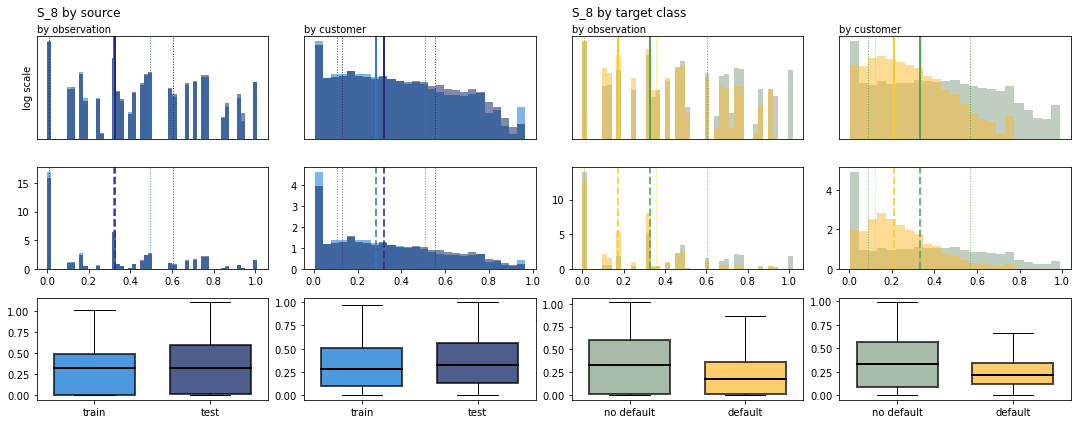


-

S_8
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.32175           0.32472           0.32559           0.17472
              mean           0.32760           0.35660           0.35450           0.24651
               std           0.30309           0.31669           0.31890           0.23121
----------------------------------------------------------------------------------------------------
by_cust     median           0.28404           0.32014           0.33300           0.21331
              mean           0.32588           0.35767           0.35378           0.24604
               std           0.25940           0.27056           0.27923           0.16770
----------------------------------------------------------------------------------------------------
___________________________________________________

In [526]:
plot_next()

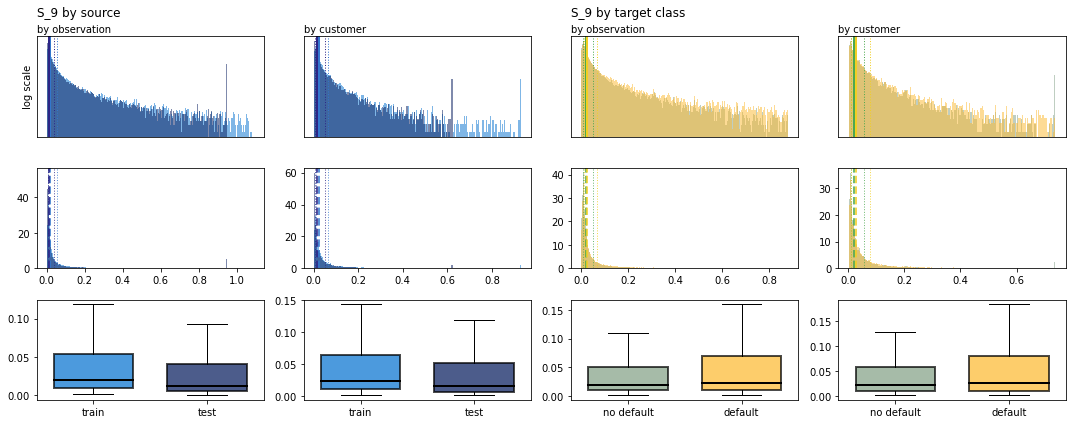


-

S_9
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.01949           0.01292           0.01875           0.02272
              mean           0.07441           0.06257           0.06680           0.10090
               std           0.19600           0.18158           0.17327           0.25823
----------------------------------------------------------------------------------------------------
by_cust     median           0.02375           0.01620           0.02271           0.02716
              mean           0.07492           0.05658           0.06579           0.09871
               std           0.17893           0.13353           0.15273           0.23213
----------------------------------------------------------------------------------------------------
___________________________________________________

In [527]:
plot_next()

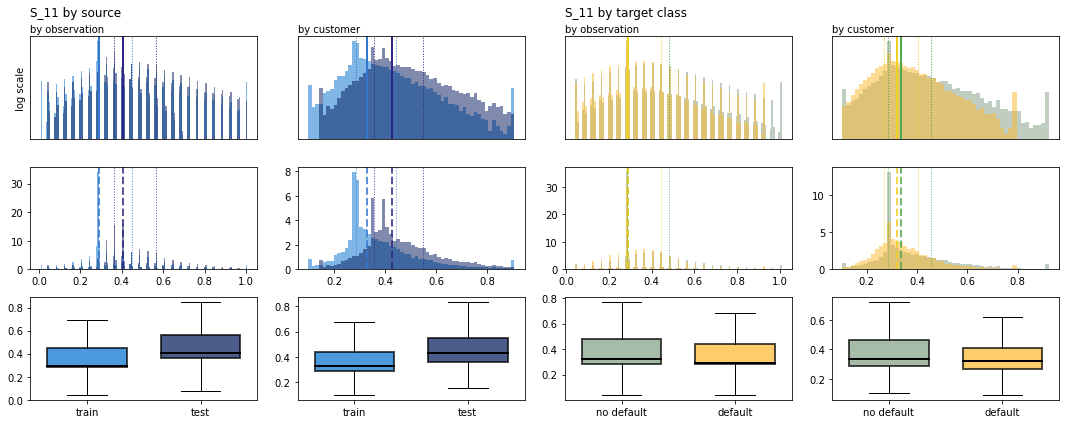


-

S_11
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.28973           0.40732           0.28992           0.28902
              mean           0.37533           0.46937           0.38473           0.34701
               std           0.19101           0.21510           0.19432           0.17768
----------------------------------------------------------------------------------------------------
by_cust     median           0.33028           0.42661           0.33451           0.32155
              mean           0.37355           0.46985           0.38360           0.34480
               std           0.15706           0.17722           0.16395           0.13123
----------------------------------------------------------------------------------------------------
__________________________________________________

In [528]:
plot_next()

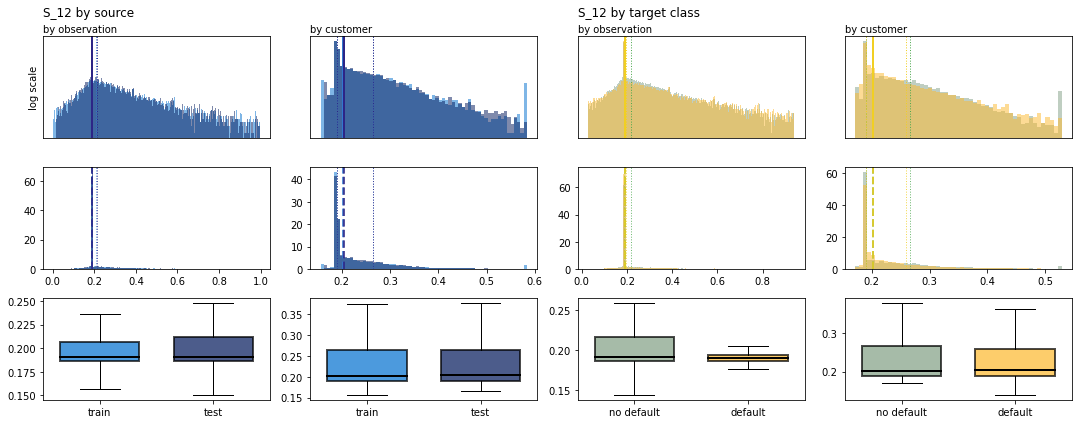


-

S_12
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.19083           0.19086           0.19097           0.19044
              mean           0.24046           0.24121           0.23938           0.24373
               std           0.25072           0.25512           0.20922           0.34697
----------------------------------------------------------------------------------------------------
by_cust     median           0.20264           0.20459           0.20254           0.20279
              mean           0.24180           0.24202           0.24054           0.24538
               std           0.11373           0.11151           0.09666           0.15229
----------------------------------------------------------------------------------------------------
__________________________________________________

In [529]:
plot_next()

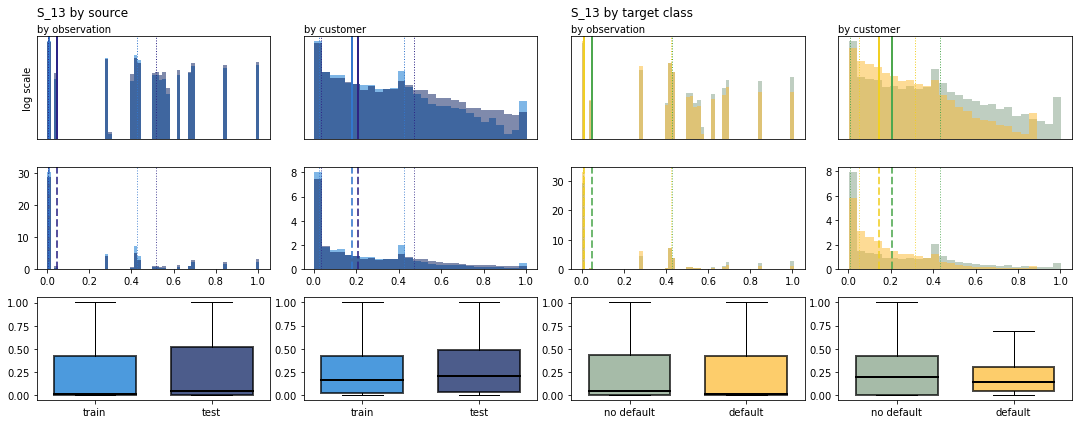


-

S_13
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00980           0.04613           0.04728           0.00881
              mean           0.25467           0.29223           0.27281           0.20000
               std           0.29667           0.33105           0.30745           0.25376
----------------------------------------------------------------------------------------------------
by_cust     median           0.17888           0.20994           0.20503           0.14537
              mean           0.25429           0.29351           0.27243           0.20240
               std           0.25361           0.28606           0.26943           0.19239
----------------------------------------------------------------------------------------------------
__________________________________________________

In [530]:
plot_next()

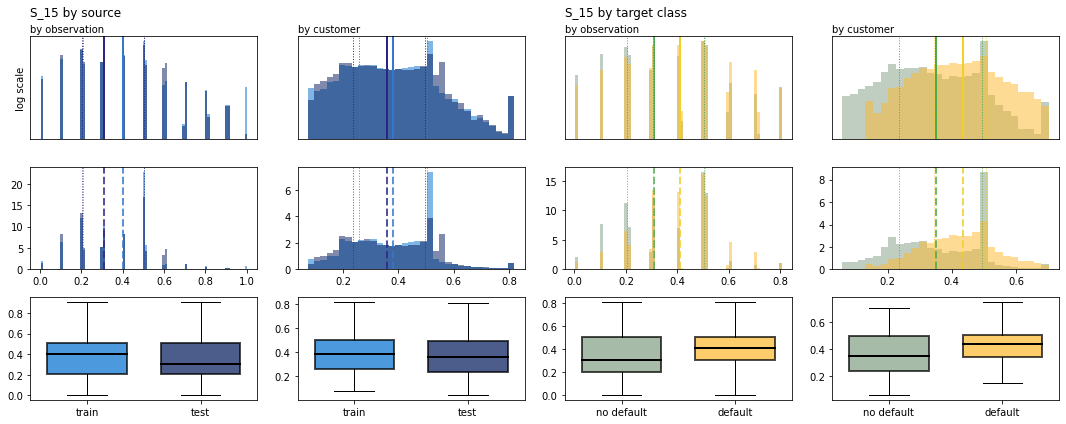


-

S_15
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.40184           0.30892           0.30877           0.40929
              mean           0.37479           0.36597           0.35309           0.44021
               std           0.19510           0.21142           0.17883           0.22517
----------------------------------------------------------------------------------------------------
by_cust     median           0.38164           0.35928           0.35050           0.43557
              mean           0.37708           0.36628           0.35412           0.44279
               std           0.15332           0.16288           0.14649           0.15343
----------------------------------------------------------------------------------------------------
__________________________________________________

In [531]:
plot_next()

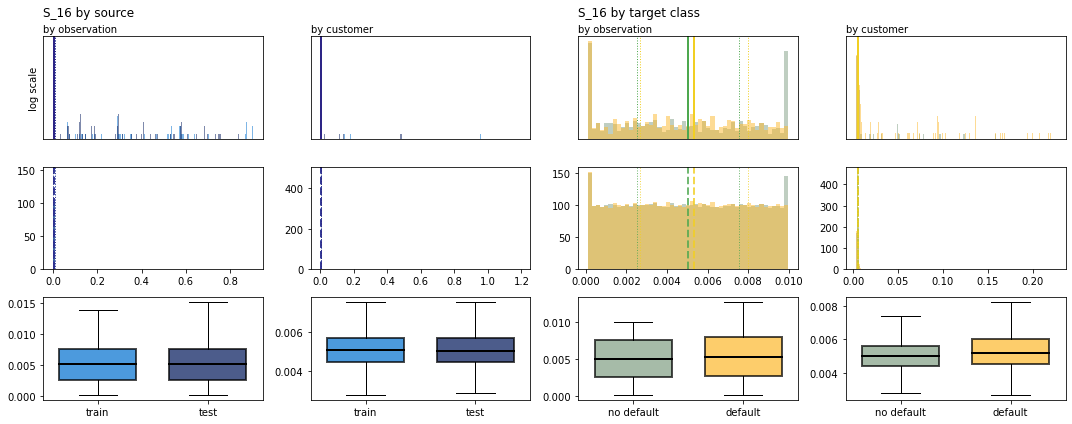


-

S_16
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00510           0.00509           0.00504           0.00532
              mean           0.05082           0.05219           0.02019           0.14314
               std           0.77249           0.89109           0.40970           1.37049
----------------------------------------------------------------------------------------------------
by_cust     median           0.00506           0.00506           0.00503           0.00518
              mean           0.05455           0.05329           0.02076           0.15126
               std           0.59572           0.65628           0.29257           1.05496
----------------------------------------------------------------------------------------------------
__________________________________________________

In [532]:
plot_next()

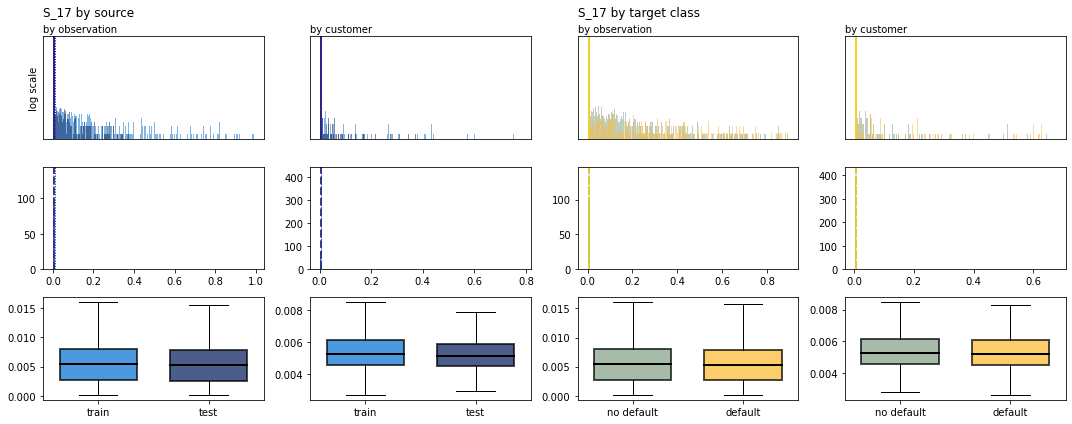


-

S_17
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00537           0.00519           0.00539           0.00531
              mean           0.03972           0.02033           0.03545           0.05259
               std           0.24102           0.15441           0.21560           0.30474
----------------------------------------------------------------------------------------------------
by_cust     median           0.00522           0.00513           0.00522           0.00520
              mean           0.03972           0.02015           0.03513           0.05285
               std           0.16228           0.09596           0.14519           0.20284
----------------------------------------------------------------------------------------------------
__________________________________________________

In [533]:
plot_next()

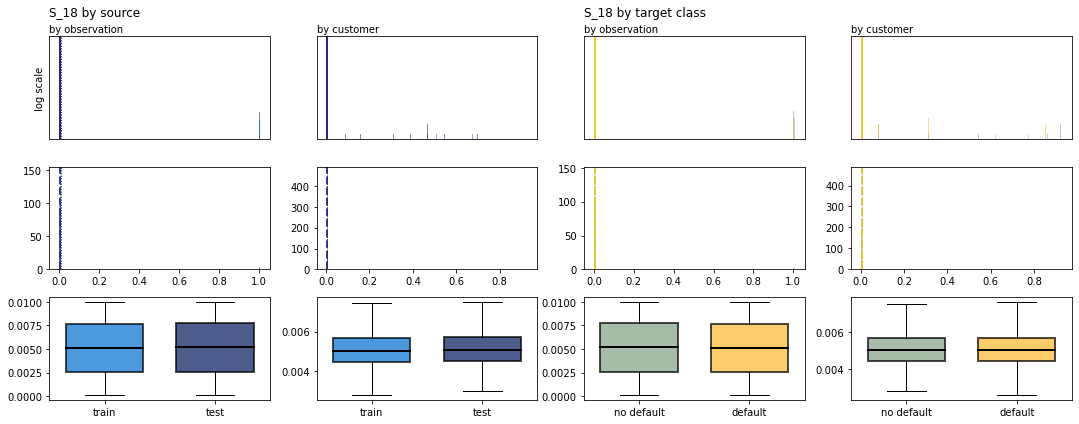


-

S_18
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00513           0.00515           0.00514           0.00512
              mean           0.03147           0.03397           0.03239           0.02867
               std           0.16055           0.16776           0.16325           0.15206
----------------------------------------------------------------------------------------------------
by_cust     median           0.00505           0.00506           0.00505           0.00504
              mean           0.03052           0.03364           0.03158           0.02750
               std           0.13692           0.14571           0.14044           0.12624
----------------------------------------------------------------------------------------------------
__________________________________________________

In [534]:
plot_next()

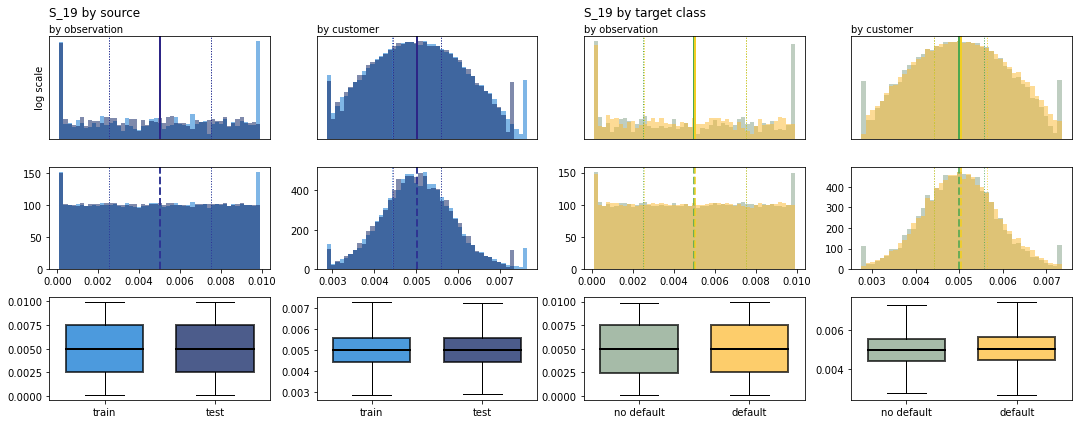


-

S_19
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00501           0.00501           0.00500           0.00503
              mean           0.00503           0.00503           0.00501           0.00508
               std           0.00307           0.00310           0.00295           0.00341
----------------------------------------------------------------------------------------------------
by_cust     median           0.00501           0.00501           0.00500           0.00503
              mean           0.00503           0.00503           0.00501           0.00510
               std           0.00115           0.00108           0.00098           0.00153
----------------------------------------------------------------------------------------------------
__________________________________________________

In [535]:
plot_next()

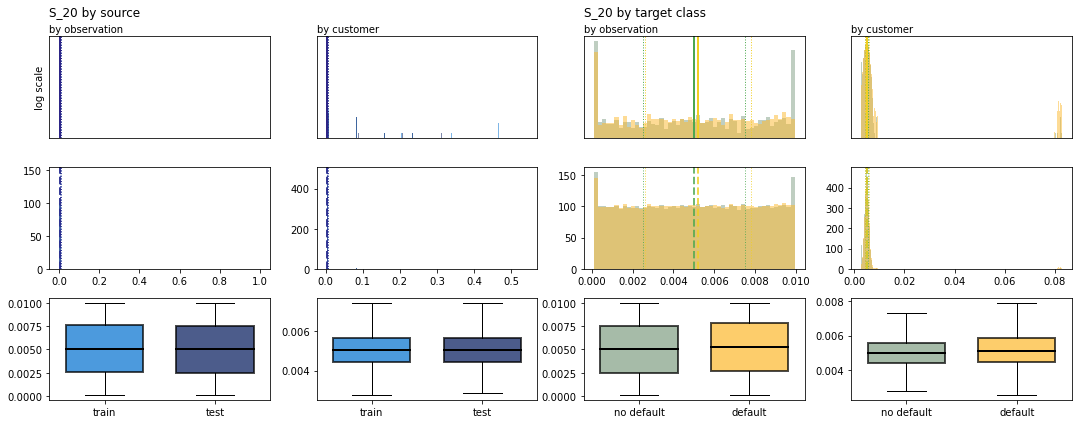


-

S_20
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00506           0.00505           0.00502           0.00519
              mean           0.01749           0.01482           0.00898           0.04313
               std           0.11109           0.09867           0.06303           0.19155
----------------------------------------------------------------------------------------------------
by_cust     median           0.00503           0.00503           0.00501           0.00511
              mean           0.01860           0.01517           0.00918           0.04557
               std           0.08953           0.07495           0.04856           0.15240
----------------------------------------------------------------------------------------------------
__________________________________________________

In [536]:
plot_next()

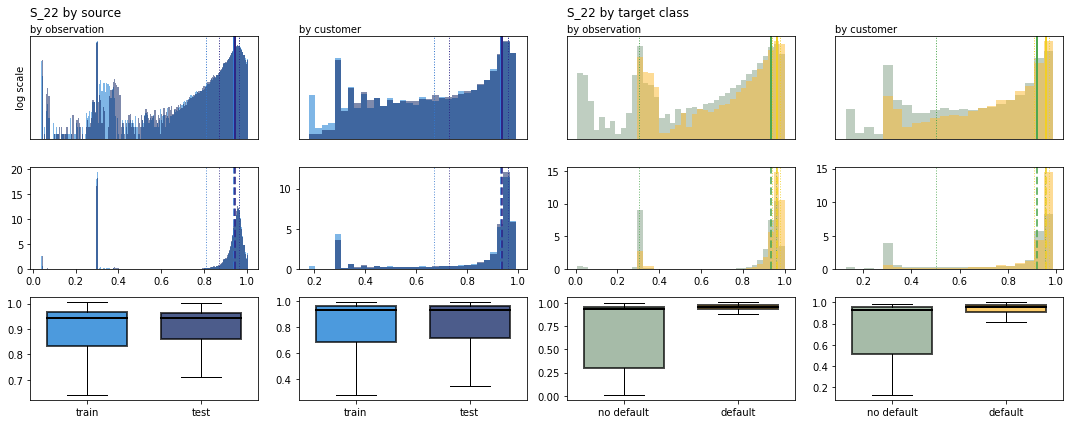


-

S_22
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.94221           0.94328           0.93266           0.96271
              mean           0.77910           0.79273           0.74242           0.88945
               std           0.71875           0.75345           0.76624           0.53688
----------------------------------------------------------------------------------------------------
by_cust     median           0.93447           0.93723           0.92235           0.95721
              mean           0.77966           0.79246           0.74277           0.88524
               std           0.41898           0.37029           0.44908           0.29275
----------------------------------------------------------------------------------------------------
__________________________________________________

In [537]:
plot_next()

Values of S_22 follow a multimodal beta distribution.

In [586]:
S_22.dist_type = 'multimodal, beta'

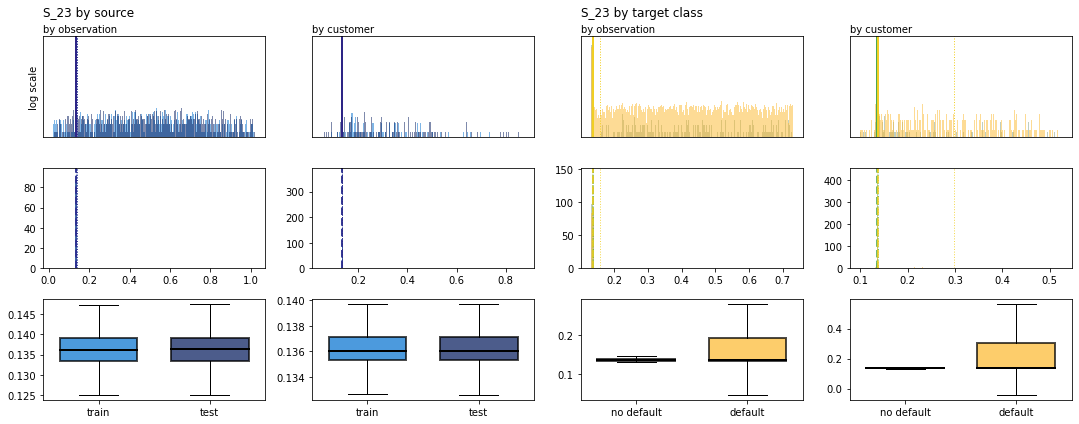


-

S_23
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.13622           0.13627           0.13596           0.13730
              mean           0.17968           0.18518           0.15170           0.26404
               std           0.85196           0.80712           0.62294           1.31708
----------------------------------------------------------------------------------------------------
by_cust     median           0.13603           0.13604           0.13590           0.13729
              mean           0.17907           0.18430           0.15172           0.25736
               std           0.39580           0.29791           0.32702           0.53914
----------------------------------------------------------------------------------------------------
__________________________________________________

In [538]:
plot_next()

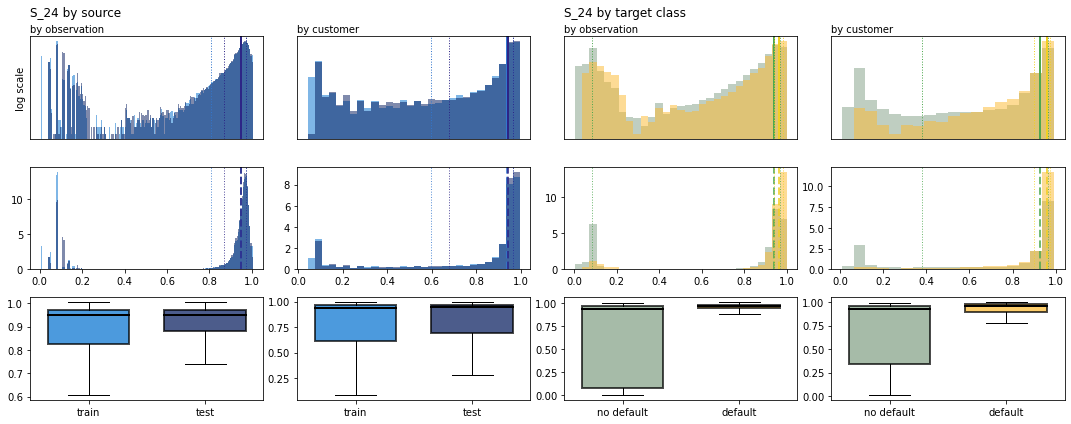


-

S_24
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.94932           0.95035           0.94062           0.96619
              mean           0.73492           0.75662           0.68960           0.87126
               std           0.83567           0.84411           0.87654           0.68052
----------------------------------------------------------------------------------------------------
by_cust     median           0.94003           0.94293           0.92825           0.95932
              mean           0.73526           0.75632           0.68982           0.86529
               std           0.52407           0.44817           0.55500           0.39539
----------------------------------------------------------------------------------------------------
__________________________________________________

In [539]:
plot_next()

In [585]:
S_24.dist_type = 'multimodal, beta'
S_24.subset_dist_types['default'] = 'beta'
S_24.subset_dist_types['no default'] = 'beta'

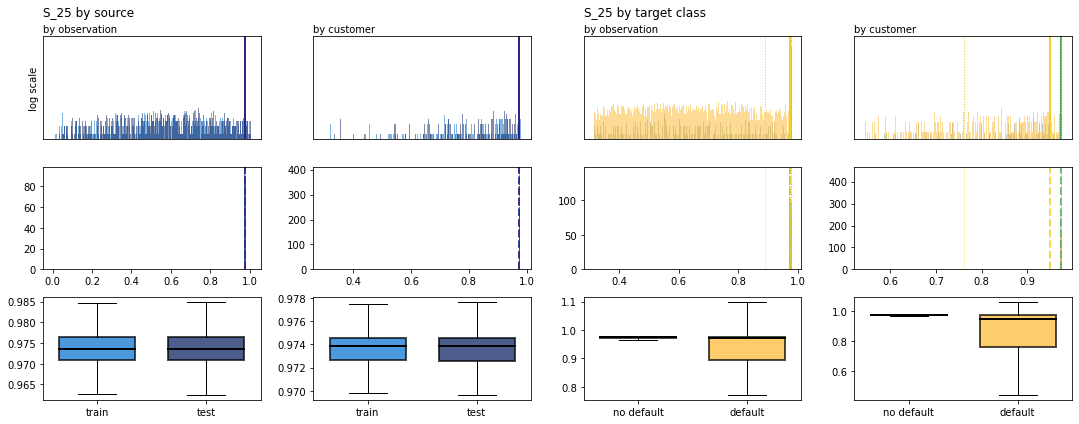


-

S_25
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.97368           0.97367           0.97396           0.97249
              mean           0.92504           0.92501           0.95434           0.83627
               std           0.20681           0.20910           0.13285           0.32923
----------------------------------------------------------------------------------------------------
by_cust     median           0.97386           0.97385           0.97403           0.94962
              mean           0.92474           0.92501           0.95400           0.84097
               std           0.14065           0.14106           0.08779           0.21185
----------------------------------------------------------------------------------------------------
__________________________________________________

In [540]:
plot_next()

The interquartile ranges of S_25 by target clas subset are distinct. Values of customers in the no default subset have a much smaller iqr.

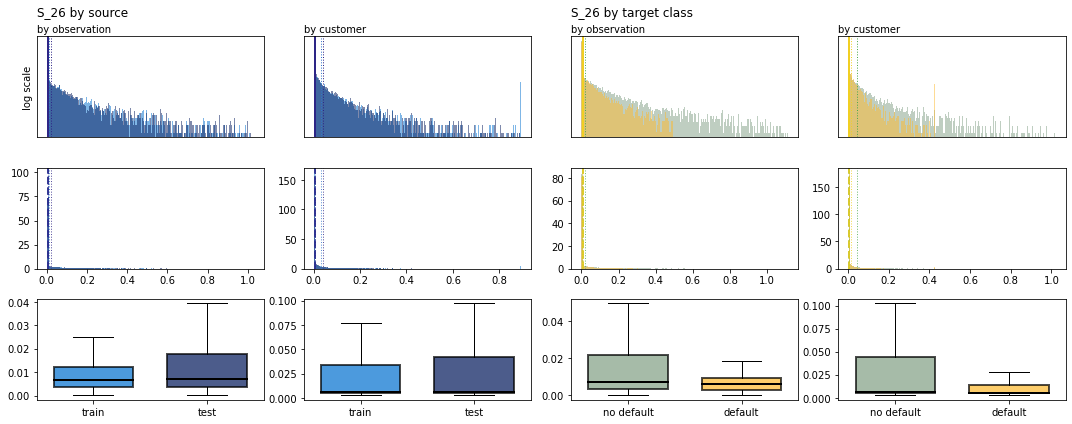


-

S_26
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.00675           0.00693           0.00699           0.00614
              mean           0.06684           0.07527           0.07813           0.03281
               std           0.46381           0.52938           0.50503           0.30527
----------------------------------------------------------------------------------------------------
by_cust     median           0.00589           0.00606           0.00605           0.00559
              mean           0.06384           0.07315           0.07531           0.03100
               std           0.41171           0.47142           0.44998           0.27144
----------------------------------------------------------------------------------------------------
__________________________________________________

In [541]:
plot_next()

Histograms of S_26 resemble those of some balance features. Values of customers in the default subset have a smaller iqr than those of the no default subset

In [584]:
S_26.dist_type = 'exponential'

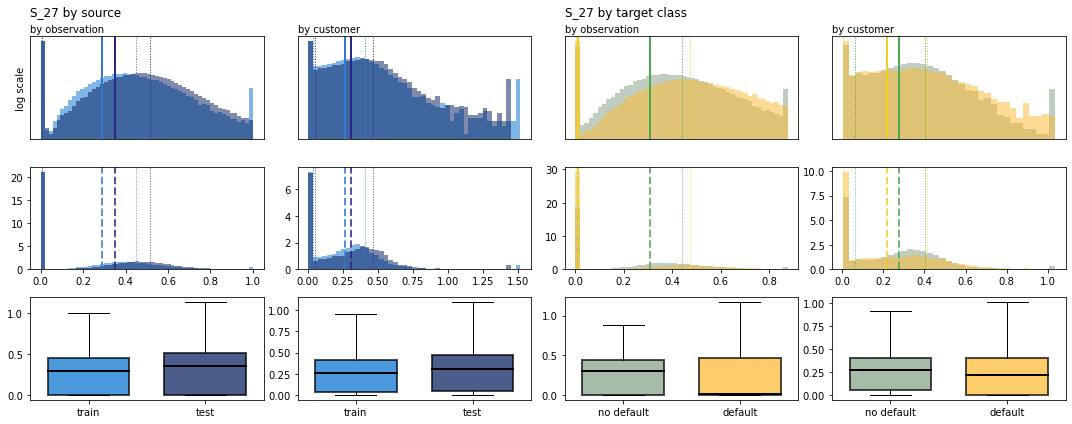


-

S_27
____________________________________________________________________________________________________

weight         agg             train              test        no default           default
by_obs      median           0.29051           0.35209           0.30800           0.00947
              mean           0.27798           0.32080           0.28269           0.26563
               std           0.32503           0.35721           0.28803           0.40612
----------------------------------------------------------------------------------------------------
by_cust     median           0.26387           0.31012           0.27699           0.21862
              mean           0.28365           0.32438           0.28197           0.28776
               std           0.35286           0.38068           0.32518           0.41298
----------------------------------------------------------------------------------------------------
__________________________________________________

In [542]:
plot_next()

Feature S_27 has a high rate of missing values. 14% of customers have no non-null values. Interestingly, only 4% of customers in the default subset have no non-null values, compared to 17% of customers in the no default subset. This feature may be useful if transformed via isnull and aggregated with all.

In [583]:
S_27.dist_type = 'multimodal'
S_27.flags.append('missing values')
S_27.processing_steps['is null transform'] = methodcaller('isnull')
S_27.processing_steps['as float'] = lambda srs: srs.astype(float)